In [1]:
'''in this version we always use the same image (times batch size), 
substract batch average at each step to obtain batch-wise advantages
use reward with axes of fft being separated'''

'in this version we always use the same image (times batch size), \nsubstract batch average at each step to obtain batch-wise advantages\nuse reward with axes of fft being separated'

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


config:  namespace(action_upper_bound=array([2., 2.]), batch_size=32, distance_penalty_coefficient=0.1, distance_penalty_enabled=True, distance_penalty_exponent=2, distance_penalty_r0=15.0, do_grayscale=True, filter=array([[[[ 0.        ],
         [ 1.        ],
         [ 0.93406058],
         [ 0.16910922],
         [-0.25916066],
         [-0.38278056],
         [-0.36833901],
         [-0.306479  ],
         [-0.23612829],
         [-0.17285442],
         [-0.12178184],
         [-0.08322866],
         [-0.05547789],
         [-0.03621425],
         [-0.02322227],
         [-0.01466442]]]]), fixed_image_num=1, foveate=None, gym_mode=False, history_length=16, image_h=224, image_hm=264, image_w=224, image_wm=264, loud=True, margin=20, max_freq=13, min_freq=1, motion_mode='velocity', sum_axes=True, t_ignore=16, t_max=50, use_dones=False)


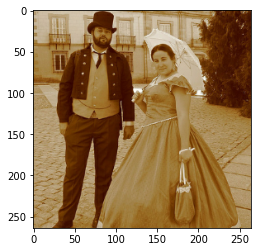

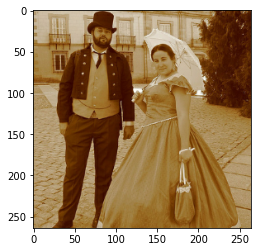

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
from imagenet_dataset import get_dataset
from retina_env import RetinaEnv, calculate_retinal_filter
from rl_networks import create_actor_model, create_critic_model, policy
from rl_core import Buffer, update_target
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from pg_core import GaussianPolicyAgent

import types
config = types.SimpleNamespace()
config.batch_size = 32
config.margin = 20
config.image_h = 224
config.image_w = 224
config.sum_axes = True
config.distance_penalty_enabled = True
config.image_hm = config.image_h+2*config.margin
config.image_wm = config.image_w+2*config.margin
config.foveate = None
config.do_grayscale = True
config.history_length = 16
config.t_ignore = 16
config.t_max =50
config.motion_mode = 'velocity'
config.use_dones = False
config.fixed_image_num = 1 #this is a nice image
config.gym_mode = False
t_vec = np.linspace(0,150,16)

balanced_filter = calculate_retinal_filter(t_vec, R=1.0)
config.filter = balanced_filter.reshape([1,1,-1,1])
config.min_freq = 1
config.max_freq = 13
config.action_upper_bound = np.array([2.0, 2.0])
actor_lr = 1e-4
dataset_dir = '/home/bnapp/datasets/tensorflow_datasets/imagenet2012/5.0.0/'

def epsilon_scheduler(episode, floor_episode=200, epsilon_floor=0.1):
    if episode < floor_episode:
        return 1.-(1.-epsilon_floor)*episode/floor_episode
    else:
        return epsilon_floor

dataset = get_dataset(dataset_dir,
                                     'validation',
                                     config.batch_size,
                                     image_h = config.image_hm,
                                     image_w = config.image_wm,
                                    deterministic=True,
                                     preprocessing='identity',
                                     rggb_mode=False,
                                     central_squeeze_and_pad_factor=-1)

# env = RetinaEnv(config, image_generator=dataset)
env = RetinaEnv(config) #freezing on first batch
for images,_ in dataset:
    break
    
images = images[config.fixed_image_num].numpy()
images = np.repeat(images[np.newaxis, :, :, :], config.batch_size, axis=0)
plt.imshow(images[0])
plt.figure()
plt.imshow(images[1])
if config.gym_mode:
    num_states = env.observation_space.shape[0]
    num_actions = env.action_space.shape[0]

    upper_bound = env.action_space.high[0]
    lower_bound = env.action_space.low[0]
else:
    num_states = env.observation_size
    num_actions = env.action_size
    upper_bound = env.action_upper_bound
    lower_bound = env.action_lower_bound


actor_model = create_actor_model(env.image_h, env.image_w,
                                 env.spectral_density_size, env.location_history_size,
                                 env.timestep_size, env.action_size)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)
actor_model.optimizer = actor_optimizer
agent = GaussianPolicyAgent(std_deviation=1.0,model=actor_model)

In [3]:
# Training loop
reward_records = []
epsilon_records = []
action_mean_records = []
action_var_records = []
action_statmean_records = []
action_statvar_records = []
episodes = 10000
best_episodic_reward = -1e9
for ep in range(episodes):
    prev_state = env.reset(images=images)
    episodic_reward = 0
    states, actions, rewards = [], [], []

#     epsilon = epsilon_scheduler(ep, floor_episode=1000)

    while True:

        deterministic_action, means,stdevs = agent.get_action(env.unflatten_observation(prev_state),
                                               return_stats=True)
        action = deterministic_action #hook in order to add noise if neccessary
        state, reward, done, info = env.step(action)
        
        if env.warmup_done:
            states.append(prev_state)
            actions.append(action)
            rewards.append(reward)
                
            episodic_reward += reward
           
            action_mean_records.append(deterministic_action.mean(axis=0))
            action_var_records.append(deterministic_action.var(axis=0))
            action_statmean_records.append(means)
            action_statvar_records.append(stdevs)
        # End this episode when `done` is True
        if done:
            break

        prev_state = np.copy(state)
    
    agent.train(np.array(states), np.array(actions), np.array(rewards),shaper_fn=env.unflatten_observation_v2,
                max_iterations=1000, loud=True)
    reward_records.append(episodic_reward)
    print(f"Episode * {ep} * Episodic Reward is ==> {episodic_reward.mean()}")
#     print(f"Episode * {ep} * Episodic Reward is ==> {episodic_reward.numpy().mean()}")
#     print(f"Episode * {ep} * exploration epsilon {epsilon} * Episodic Reward is ==> {episodic_reward.numpy().mean()}")
    print("action means and variances at step -10:", action_mean_records[-10],action_var_records[-10])
    print("action means and variances at step -5:", action_mean_records[-5],action_var_records[-5])
    print("action statmeans and variances at step -10:", action_statmean_records[-10][0],action_statvar_records[-10][0])
    print("action statmeans and variances at step -5:", action_statmean_records[-5][0],action_statvar_records[-5][0])

    
#     mean_episodic_reward = episodic_reward.numpy().mean()
    mean_episodic_reward = episodic_reward.mean()
    if mean_episodic_reward > best_episodic_reward:
        actor_model.save('actor_cp_vanilla_det_singleImg_Adv_distPen101')
        print('saved checkpoint at mean_episodic_reward=',mean_episodic_reward)
        best_episodic_reward = mean_episodic_reward + 0.

Training for 17 iterations with batchsize 64
Episode * 0 * Episodic Reward is ==> -13.274618389405695
action means and variances at step -10: [0.05922328 0.00099107] [1.00576547 0.96954398]
action means and variances at step -5: [-0.03571277  0.10060474] [1.03345929 0.92603351]
action statmeans and variances at step -10: [0.03391904 0.049676  ] [1. 1.]
action statmeans and variances at step -5: [0.0305669  0.04188447] [1. 1.]
INFO:tensorflow:Assets written to: actor_cp_vanilla_det_singleImg_Adv_distPen101/assets
saved checkpoint at mean_episodic_reward= -13.274618389405695
Training for 17 iterations with batchsize 64
Episode * 1 * Episodic Reward is ==> -13.067947193603342
action means and variances at step -10: [-0.23000114 -0.02950021] [0.90185167 0.92314324]
action means and variances at step -5: [-0.01226172  0.0986484 ] [0.89650499 0.7803476 ]
action statmeans and variances at step -10: [0.02103527 0.01462286] [1. 1.]
action statmeans and variances at step -5: [0.01532124 0.008725

INFO:tensorflow:Assets written to: actor_cp_vanilla_det_singleImg_Adv_distPen101/assets
saved checkpoint at mean_episodic_reward= -12.162151515760875
Training for 17 iterations with batchsize 64
Episode * 10 * Episodic Reward is ==> -12.192459774970704
action means and variances at step -10: [0.09204756 0.22009417] [1.03530261 1.15608726]
action means and variances at step -5: [ 0.08905691 -0.27513682] [1.28204627 0.78880667]
action statmeans and variances at step -10: [-0.0301519  -0.07173487] [1. 1.]
action statmeans and variances at step -5: [ 0.02893237 -0.06397042] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 11 * Episodic Reward is ==> -12.431540708055358
action means and variances at step -10: [-0.08071954 -0.03471692] [1.07235373 1.05379463]
action means and variances at step -5: [-0.23910837  0.1293198 ] [1.26780594 0.75716141]
action statmeans and variances at step -10: [ 0.10454468 -0.06280087] [1. 1.]
action statmeans and variances at step -5: [ 0.08809625

INFO:tensorflow:Assets written to: actor_cp_vanilla_det_singleImg_Adv_distPen101/assets
saved checkpoint at mean_episodic_reward= -11.329670595128494
Training for 17 iterations with batchsize 64
Episode * 21 * Episodic Reward is ==> -12.47156015013178
action means and variances at step -10: [-0.15184969 -0.10910879] [0.86790123 0.87066995]
action means and variances at step -5: [-0.13786387 -0.07592194] [1.01198359 0.84624451]
action statmeans and variances at step -10: [-0.0488191  -0.18483524] [1. 1.]
action statmeans and variances at step -5: [ 0.10152657 -0.08857587] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 22 * Episodic Reward is ==> -12.117679940736622
action means and variances at step -10: [ 0.22805797 -0.14514949] [1.13864109 0.95359442]
action means and variances at step -5: [-0.17321284  0.23779133] [1.19650212 1.30191565]
action statmeans and variances at step -10: [-0.08879744 -0.12004267] [1. 1.]
action statmeans and variances at step -5: [ 0.0050425

Training for 17 iterations with batchsize 64
Episode * 33 * Episodic Reward is ==> -11.156155338773178
action means and variances at step -10: [0.14057903 0.04459917] [1.00754185 0.96540153]
action means and variances at step -5: [-0.22976352  0.1501391 ] [0.85766815 0.78583683]
action statmeans and variances at step -10: [-0.27654657 -0.03555946] [1. 1.]
action statmeans and variances at step -5: [0.10130271 0.2363597 ] [1. 1.]
INFO:tensorflow:Assets written to: actor_cp_vanilla_det_singleImg_Adv_distPen101/assets
saved checkpoint at mean_episodic_reward= -11.156155338773178
Training for 17 iterations with batchsize 64
Episode * 34 * Episodic Reward is ==> -11.35795289721868
action means and variances at step -10: [0.02917674 0.00259029] [1.02162984 0.88028653]
action means and variances at step -5: [0.15881738 0.19423641] [1.00770004 1.29490109]
action statmeans and variances at step -10: [-0.4677684  -0.08609544] [1. 1.]
action statmeans and variances at step -5: [-0.4694521  -0.124

Training for 17 iterations with batchsize 64
Episode * 44 * Episodic Reward is ==> -11.716397337829463
action means and variances at step -10: [-0.02898316 -0.03017665] [0.87932201 0.83586239]
action means and variances at step -5: [-0.0370617   0.00093442] [1.06119997 0.52839471]
action statmeans and variances at step -10: [ 0.44565618 -0.22294562] [1. 1.]
action statmeans and variances at step -5: [-0.05881697 -0.05855708] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 45 * Episodic Reward is ==> -11.214589335044643
action means and variances at step -10: [-0.19176387  0.2382587 ] [1.45488409 1.10256993]
action means and variances at step -5: [ 0.08144429 -0.22340029] [0.75965868 0.72297261]
action statmeans and variances at step -10: [-0.5720316  -0.03305675] [1. 1.]
action statmeans and variances at step -5: [-0.45255655 -0.08358029] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 46 * Episodic Reward is ==> -11.180844723286418
action means and varian

Training for 17 iterations with batchsize 64
Episode * 56 * Episodic Reward is ==> -10.7104883883611
action means and variances at step -10: [ 0.1676014 -0.0691194] [0.74364899 1.3312157 ]
action means and variances at step -5: [0.07596772 0.06580619] [1.57497468 1.27251784]
action statmeans and variances at step -10: [-0.6639095  -0.23579112] [1. 1.]
action statmeans and variances at step -5: [-0.23888732  0.02842668] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 57 * Episodic Reward is ==> -10.90922013803235
action means and variances at step -10: [-0.0367703  -0.24079956] [0.97392299 0.83778237]
action means and variances at step -5: [-0.24640243 -0.05859062] [0.89666725 1.0188971 ]
action statmeans and variances at step -10: [-0.37578902 -0.12809367] [1. 1.]
action statmeans and variances at step -5: [-0.5852892   0.37553814] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 58 * Episodic Reward is ==> -10.53696491050014
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 68 * Episodic Reward is ==> -11.010542688330013
action means and variances at step -10: [ 0.15074183 -0.07220758] [0.82201868 1.39668157]
action means and variances at step -5: [0.32890822 0.31056215] [1.0803859  1.36304777]
action statmeans and variances at step -10: [-0.44788557 -0.42867416] [1. 1.]
action statmeans and variances at step -5: [-0.38525757  0.14155732] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 69 * Episodic Reward is ==> -11.44427886456285
action means and variances at step -10: [-0.10299643 -0.05171591] [0.85836956 0.99266387]
action means and variances at step -5: [-0.03108923  0.19130412] [0.88987129 2.17746761]
action statmeans and variances at step -10: [-0.11818714 -0.2853958 ] [1. 1.]
action statmeans and variances at step -5: [-0.13819598  0.1084791 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 70 * Episodic Reward is ==> -10.718340592427806
action means and variances

Training for 17 iterations with batchsize 64
Episode * 80 * Episodic Reward is ==> -10.485099075586422
action means and variances at step -10: [-0.14725063  0.04250192] [1.19475535 0.80309634]
action means and variances at step -5: [ 0.12230688 -0.26880562] [1.12540382 1.42691624]
action statmeans and variances at step -10: [-0.0944041   0.81175506] [1. 1.]
action statmeans and variances at step -5: [ 0.4590639  -0.00801865] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 81 * Episodic Reward is ==> -10.627744350193435
action means and variances at step -10: [0.01711728 0.10719699] [0.80783059 1.7324178 ]
action means and variances at step -5: [ 0.10322699 -0.09408007] [1.04611118 1.25706526]
action statmeans and variances at step -10: [-0.4353034   0.91068566] [1. 1.]
action statmeans and variances at step -5: [-0.654447   -0.43028426] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 82 * Episodic Reward is ==> -10.414904035272896
action means and variance

INFO:tensorflow:Assets written to: actor_cp_vanilla_det_singleImg_Adv_distPen101/assets
saved checkpoint at mean_episodic_reward= -10.039654489883016
Training for 17 iterations with batchsize 64
Episode * 91 * Episodic Reward is ==> -10.513551340520543
action means and variances at step -10: [0.23529314 0.43132131] [1.14046201 1.50476812]
action means and variances at step -5: [-0.40755672  0.08063631] [1.5904019  1.50401811]
action statmeans and variances at step -10: [-0.55784523 -0.53384125] [1. 1.]
action statmeans and variances at step -5: [ 0.26916465 -0.38662943] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 92 * Episodic Reward is ==> -9.985907090275667
action means and variances at step -10: [0.12663236 0.37225457] [1.86261229 1.43775338]
action means and variances at step -5: [0.06366048 0.03985453] [1.48686843 2.22803332]
action statmeans and variances at step -10: [-0.00528103 -1.1270103 ] [1. 1.]
action statmeans and variances at step -5: [0.28322148 0.501

Training for 17 iterations with batchsize 64
Episode * 102 * Episodic Reward is ==> -10.145155860538594
action means and variances at step -10: [0.06535857 0.4120126 ] [1.53987102 1.45569514]
action means and variances at step -5: [0.28993702 0.34127103] [1.36911324 1.69076691]
action statmeans and variances at step -10: [-0.18678303  1.4947224 ] [1. 1.]
action statmeans and variances at step -5: [0.6559362 1.0833477] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 103 * Episodic Reward is ==> -10.465124269021914
action means and variances at step -10: [0.12477616 0.04945393] [1.14848885 1.3481835 ]
action means and variances at step -5: [0.11185489 0.40658227] [1.4716917  0.98367597]
action statmeans and variances at step -10: [-0.65265554 -0.32508573] [1. 1.]
action statmeans and variances at step -5: [-0.5335169 -0.8075214] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 104 * Episodic Reward is ==> -9.9844256792202
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 114 * Episodic Reward is ==> -9.961393109191514
action means and variances at step -10: [ 0.49352506 -0.28449246] [1.50606481 1.51297517]
action means and variances at step -5: [-0.07518181  0.16551994] [1.50585211 1.25444615]
action statmeans and variances at step -10: [ 0.61653274 -0.2580769 ] [1. 1.]
action statmeans and variances at step -5: [-0.7027358  -0.24016744] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 115 * Episodic Reward is ==> -9.466830680627531
action means and variances at step -10: [ 0.07036529 -0.08649085] [1.28854077 0.69129021]
action means and variances at step -5: [ 0.11978218 -0.15930319] [2.28796716 2.45266203]
action statmeans and variances at step -10: [-0.4254833  -0.97320426] [1. 1.]
action statmeans and variances at step -5: [ 0.20800526 -1.2685536 ] [1. 1.]
INFO:tensorflow:Assets written to: actor_cp_vanilla_det_singleImg_Adv_distPen101/assets
saved checkpoint at mean_episodic_rewa

Training for 17 iterations with batchsize 64
Episode * 126 * Episodic Reward is ==> -9.927107356650936
action means and variances at step -10: [0.04367029 0.03638496] [1.75151199 1.11968395]
action means and variances at step -5: [0.51256424 0.17972306] [1.16658018 1.75275125]
action statmeans and variances at step -10: [1.1433764  0.35705596] [1. 1.]
action statmeans and variances at step -5: [0.09185749 0.40399766] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 127 * Episodic Reward is ==> -9.981879150211896
action means and variances at step -10: [-0.02236247 -0.29607474] [1.66029526 0.93929681]
action means and variances at step -5: [-0.01922108  0.10920323] [1.14569253 1.38813258]
action statmeans and variances at step -10: [0.6982098 0.5162368] [1. 1.]
action statmeans and variances at step -5: [-0.20535839 -0.01922296] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 128 * Episodic Reward is ==> -10.262061115259822
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 138 * Episodic Reward is ==> -9.7925650389223
action means and variances at step -10: [ 0.20337995 -0.20771912] [1.57242602 2.18049342]
action means and variances at step -5: [ 0.00588269 -0.35901994] [1.62489722 1.25413257]
action statmeans and variances at step -10: [1.1862876  0.44216073] [1. 1.]
action statmeans and variances at step -5: [0.9093156  0.57781744] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 139 * Episodic Reward is ==> -9.677019527209826
action means and variances at step -10: [ 0.21483722 -0.12700085] [1.56350922 1.9036284 ]
action means and variances at step -5: [-0.23288863 -0.28503256] [2.26799993 1.13000392]
action statmeans and variances at step -10: [ 0.7422254  -0.28752604] [1. 1.]
action statmeans and variances at step -5: [-1.0816735  -0.07647584] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 140 * Episodic Reward is ==> -9.865583592932833
action means and variances at

INFO:tensorflow:Assets written to: actor_cp_vanilla_det_singleImg_Adv_distPen101/assets
saved checkpoint at mean_episodic_reward= -9.326851599716779
Training for 17 iterations with batchsize 64
Episode * 150 * Episodic Reward is ==> -9.37907492185522
action means and variances at step -10: [-0.25534434  0.01091384] [1.41616327 1.70404424]
action means and variances at step -5: [0.20687895 0.00559109] [2.06105543 1.88879839]
action statmeans and variances at step -10: [-1.0380458  -0.63373107] [1. 1.]
action statmeans and variances at step -5: [-1.0009547 -0.4582029] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 151 * Episodic Reward is ==> -9.471280319396428
action means and variances at step -10: [ 0.06492527 -0.30027633] [1.86657188 1.40775545]
action means and variances at step -5: [-0.13755373 -0.21234962] [1.66147743 0.98090149]
action statmeans and variances at step -10: [1.321846   0.13630965] [1. 1.]
action statmeans and variances at step -5: [0.04852086 0.6026

Training for 17 iterations with batchsize 64
Episode * 162 * Episodic Reward is ==> -9.887482855066335
action means and variances at step -10: [-0.15472299 -0.04655238] [2.168004   1.73965022]
action means and variances at step -5: [-0.02220982 -0.24982542] [2.06952579 1.20670527]
action statmeans and variances at step -10: [-0.78151    -0.33688003] [1. 1.]
action statmeans and variances at step -5: [-1.0667918  -0.43183482] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 163 * Episodic Reward is ==> -9.517806353841095
action means and variances at step -10: [-0.58237896  0.16538213] [1.27705212 1.90960645]
action means and variances at step -5: [ 0.09445656 -0.41017774] [1.57230048 1.65470548]
action statmeans and variances at step -10: [-1.0621701  -0.07328752] [1. 1.]
action statmeans and variances at step -5: [0.4167139 0.5392328] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 164 * Episodic Reward is ==> -9.637605482902128
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 174 * Episodic Reward is ==> -9.680296746023405
action means and variances at step -10: [0.07179186 0.09136971] [2.3040996  1.48419492]
action means and variances at step -5: [-0.034983    0.01467276] [1.62257854 1.57149593]
action statmeans and variances at step -10: [ 0.1436095 -1.5750337] [1. 1.]
action statmeans and variances at step -5: [ 0.59724224 -1.1406657 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 175 * Episodic Reward is ==> -9.345745641295338
action means and variances at step -10: [-0.19470492  0.23710051] [1.44678502 1.45698815]
action means and variances at step -5: [-0.38608139  0.17400556] [2.05021172 1.23997806]
action statmeans and variances at step -10: [-0.9849899 -0.629985 ] [1. 1.]
action statmeans and variances at step -5: [-0.34010217  0.01788842] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 176 * Episodic Reward is ==> -9.417177639138426
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 186 * Episodic Reward is ==> -9.738087941389573
action means and variances at step -10: [-0.21275413  0.15640635] [1.97573111 1.94251188]
action means and variances at step -5: [ 0.03703945 -0.33793523] [1.28992966 1.64781649]
action statmeans and variances at step -10: [-0.82547367  0.47227952] [1. 1.]
action statmeans and variances at step -5: [-0.2764657  0.6550032] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 187 * Episodic Reward is ==> -9.740591738907334
action means and variances at step -10: [0.08347752 0.43870848] [1.09198546 1.29939991]
action means and variances at step -5: [ 0.04175344 -0.12089822] [1.90722398 1.57443485]
action statmeans and variances at step -10: [-0.7853558 -0.0052699] [1. 1.]
action statmeans and variances at step -5: [1.4083419 1.8699664] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 188 * Episodic Reward is ==> -9.526558307221507
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 198 * Episodic Reward is ==> -9.8195051231672
action means and variances at step -10: [-0.24284345 -0.28911108] [1.64919487 2.12740064]
action means and variances at step -5: [0.46674372 0.01531533] [2.44412711 1.82263736]
action statmeans and variances at step -10: [-1.2719746  -0.84265184] [1. 1.]
action statmeans and variances at step -5: [ 1.3731214  -0.59703887] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 199 * Episodic Reward is ==> -10.365426224818009
action means and variances at step -10: [-0.14155879 -0.31810122] [2.02128858 1.7320932 ]
action means and variances at step -5: [0.17805099 0.10368098] [1.00734997 1.35026079]
action statmeans and variances at step -10: [ 0.5628887 -1.8183372] [1. 1.]
action statmeans and variances at step -5: [ 0.5530544 -1.0102425] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 200 * Episodic Reward is ==> -9.593728084234701
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 210 * Episodic Reward is ==> -9.751769641961591
action means and variances at step -10: [0.05309805 0.0831842 ] [1.93819668 3.33584322]
action means and variances at step -5: [ 0.23869405 -0.04363527] [2.10808562 1.88038508]
action statmeans and variances at step -10: [ 0.33133042 -0.44683212] [1. 1.]
action statmeans and variances at step -5: [-1.315962  -1.0191699] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 211 * Episodic Reward is ==> -9.90169677685191
action means and variances at step -10: [-0.03744728  0.00294182] [2.16668203 1.73023014]
action means and variances at step -5: [-0.13642788 -0.20096253] [1.77331322 1.46630975]
action statmeans and variances at step -10: [0.9441633 1.3161987] [1. 1.]
action statmeans and variances at step -5: [ 0.8590522 -0.059847 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 212 * Episodic Reward is ==> -9.880745225131264
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 222 * Episodic Reward is ==> -10.266348901522797
action means and variances at step -10: [0.12604211 0.1648621 ] [0.97034121 1.50208614]
action means and variances at step -5: [ 0.06070687 -0.10733965] [1.3192614  1.89450279]
action statmeans and variances at step -10: [-0.5479104  0.4675914] [1. 1.]
action statmeans and variances at step -5: [-0.30159527 -1.2498163 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 223 * Episodic Reward is ==> -9.726422670322858
action means and variances at step -10: [-0.23255654 -0.38055712] [1.52195252 1.93718174]
action means and variances at step -5: [ 0.1440868  -0.26446201] [1.57371446 1.62231484]
action statmeans and variances at step -10: [-0.32228494  1.1994185 ] [1. 1.]
action statmeans and variances at step -5: [ 0.68920034 -0.80921483] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 224 * Episodic Reward is ==> -9.573973245419001
action means and variances

Training for 17 iterations with batchsize 64
Episode * 234 * Episodic Reward is ==> -9.681138538175505
action means and variances at step -10: [-0.31676968 -0.05575181] [1.50081203 1.83858356]
action means and variances at step -5: [0.51855257 0.15967142] [1.38746624 2.10557131]
action statmeans and variances at step -10: [0.3004021  0.45179027] [1. 1.]
action statmeans and variances at step -5: [-0.79233944  1.0279374 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 235 * Episodic Reward is ==> -9.33381667485363
action means and variances at step -10: [0.20774585 0.05360922] [2.22494414 1.38228707]
action means and variances at step -5: [ 0.41284005 -0.13474268] [1.91670432 1.31219246]
action statmeans and variances at step -10: [1.1526134 2.2128758] [1. 1.]
action statmeans and variances at step -5: [-1.5531313  -0.52881384] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 236 * Episodic Reward is ==> -9.45100688906938
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 246 * Episodic Reward is ==> -9.64202361148353
action means and variances at step -10: [0.01693413 0.25395372] [1.17033468 1.63899584]
action means and variances at step -5: [0.04044066 0.14492338] [2.2399369  1.45970733]
action statmeans and variances at step -10: [-0.09248097 -1.8893373 ] [1. 1.]
action statmeans and variances at step -5: [ 1.1065083 -0.3818204] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 247 * Episodic Reward is ==> -9.40496730097865
action means and variances at step -10: [-0.76330147  0.11100372] [1.51656151 1.91833847]
action means and variances at step -5: [0.05452549 0.29830153] [2.15148605 2.12678268]
action statmeans and variances at step -10: [1.1559647  0.14919421] [1. 1.]
action statmeans and variances at step -5: [0.7237381 1.6025167] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 248 * Episodic Reward is ==> -9.518557117178391
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 258 * Episodic Reward is ==> -9.503305652911013
action means and variances at step -10: [-0.40605067  0.05684553] [1.82059337 2.06701775]
action means and variances at step -5: [0.14573972 0.46523891] [1.76253306 1.89696073]
action statmeans and variances at step -10: [-1.2275773   0.00190347] [1. 1.]
action statmeans and variances at step -5: [ 1.081515   -0.15438524] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 259 * Episodic Reward is ==> -9.476837778928417
action means and variances at step -10: [-0.37196131 -0.01821966] [2.01986358 1.83415823]
action means and variances at step -5: [0.13144332 0.02883742] [1.71595589 1.49493177]
action statmeans and variances at step -10: [0.5684461 1.0018346] [1. 1.]
action statmeans and variances at step -5: [-1.0845463  0.7527489] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 260 * Episodic Reward is ==> -9.590463436776766
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 270 * Episodic Reward is ==> -9.559153545767726
action means and variances at step -10: [-0.558418   -0.00668838] [1.37728553 1.81960855]
action means and variances at step -5: [0.21409493 0.06088125] [1.87020746 1.47944976]
action statmeans and variances at step -10: [-0.542657  -1.3058698] [1. 1.]
action statmeans and variances at step -5: [ 0.5816144 -0.4193835] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 271 * Episodic Reward is ==> -9.247766043297377
action means and variances at step -10: [-0.13801949  0.48612102] [1.71969675 1.8336444 ]
action means and variances at step -5: [ 0.08105045 -0.19791911] [1.98356846 1.95517843]
action statmeans and variances at step -10: [-0.71508396  0.02761606] [1. 1.]
action statmeans and variances at step -5: [ 1.2052643 -0.7651744] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 272 * Episodic Reward is ==> -9.557468897805439
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 282 * Episodic Reward is ==> -9.739138127269337
action means and variances at step -10: [0.27121842 0.01874465] [1.82184756 2.14732095]
action means and variances at step -5: [-0.39554695 -0.02274703] [1.38502513 3.67971967]
action statmeans and variances at step -10: [-0.95622057 -0.78123677] [1. 1.]
action statmeans and variances at step -5: [ 0.8116654  -0.87283015] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 283 * Episodic Reward is ==> -9.483410131789181
action means and variances at step -10: [-0.23985979  0.28447947] [1.78017362 2.87164356]
action means and variances at step -5: [-0.03190493 -0.05545334] [1.67170549 2.77622832]
action statmeans and variances at step -10: [-0.19319195 -1.002195  ] [1. 1.]
action statmeans and variances at step -5: [ 0.58336836 -0.85262144] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 284 * Episodic Reward is ==> -9.548256767133363
action means and variance

Training for 17 iterations with batchsize 64
Episode * 294 * Episodic Reward is ==> -10.31565538153336
action means and variances at step -10: [-0.14110851 -0.00357486] [1.0882143  2.47818675]
action means and variances at step -5: [-0.04550687 -0.31149046] [1.75721559 2.25344779]
action statmeans and variances at step -10: [ 0.59293026 -0.9263797 ] [1. 1.]
action statmeans and variances at step -5: [1.4170394  0.62040055] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 295 * Episodic Reward is ==> -9.674084549420767
action means and variances at step -10: [-0.15083208 -0.44842809] [2.56176208 1.71836437]
action means and variances at step -5: [ 0.41996098 -0.10324769] [1.82872746 2.07963617]
action statmeans and variances at step -10: [-1.1521337 -1.0121399] [1. 1.]
action statmeans and variances at step -5: [0.7328227 1.386612 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 296 * Episodic Reward is ==> -9.610226663367548
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 306 * Episodic Reward is ==> -9.551048204042376
action means and variances at step -10: [0.22335432 0.05080147] [2.30000754 2.04954792]
action means and variances at step -5: [0.24136926 0.11961113] [1.16371507 1.73255836]
action statmeans and variances at step -10: [ 1.0146682  -0.48700172] [1. 1.]
action statmeans and variances at step -5: [-0.7637092  0.6648088] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 307 * Episodic Reward is ==> -9.5239460108262
action means and variances at step -10: [-0.37787795 -0.41652552] [1.15031605 1.70792415]
action means and variances at step -5: [0.34906132 0.22274161] [2.08500419 1.96975691]
action statmeans and variances at step -10: [-1.1672528  1.6560812] [1. 1.]
action statmeans and variances at step -5: [-1.1233109  1.1664286] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 308 * Episodic Reward is ==> -9.411701436573324
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 318 * Episodic Reward is ==> -9.51369579308667
action means and variances at step -10: [-0.20225187 -0.16380705] [1.72709205 1.71292797]
action means and variances at step -5: [-0.30352742 -0.17331969] [2.73862486 2.60993028]
action statmeans and variances at step -10: [1.0143874 1.4122921] [1. 1.]
action statmeans and variances at step -5: [-0.18372644  1.640806  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 319 * Episodic Reward is ==> -9.534561426528757
action means and variances at step -10: [-0.36950558  0.05735042] [1.544993   2.33613947]
action means and variances at step -5: [ 0.25967711 -0.03672568] [2.10384881 1.44976368]
action statmeans and variances at step -10: [-1.0267481 -1.4823651] [1. 1.]
action statmeans and variances at step -5: [ 0.8316393 -1.643471 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 320 * Episodic Reward is ==> -9.87027953322009
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 330 * Episodic Reward is ==> -9.303706258062265
action means and variances at step -10: [ 0.36802729 -0.18400477] [1.16350579 2.05327701]
action means and variances at step -5: [ 0.07826671 -0.24111485] [3.01039387 1.69794229]
action statmeans and variances at step -10: [1.7800157 1.1303867] [1. 1.]
action statmeans and variances at step -5: [-1.4150232 -0.2749337] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 331 * Episodic Reward is ==> -9.533376620605164
action means and variances at step -10: [-0.25944207 -0.14014655] [2.06836929 1.63161397]
action means and variances at step -5: [0.26569652 0.13555721] [2.54519603 2.19162929]
action statmeans and variances at step -10: [1.6672211 1.1191778] [1. 1.]
action statmeans and variances at step -5: [ 0.49304056 -0.77649224] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 332 * Episodic Reward is ==> -9.260903216424008
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 342 * Episodic Reward is ==> -9.298558345166471
action means and variances at step -10: [-0.20374279 -0.48968265] [2.66139896 1.93965557]
action means and variances at step -5: [ 0.08180563 -0.09408586] [2.56114766 2.38715651]
action statmeans and variances at step -10: [-0.9542185   0.16362907] [1. 1.]
action statmeans and variances at step -5: [1.1703241 1.5047672] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 343 * Episodic Reward is ==> -9.672383113981724
action means and variances at step -10: [ 0.04000692 -0.00555959] [2.52752891 2.18166651]
action means and variances at step -5: [-0.29549986 -0.35454183] [1.85683308 1.53661947]
action statmeans and variances at step -10: [-1.1176345   0.57743585] [1. 1.]
action statmeans and variances at step -5: [ 1.283661  -1.0333456] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 344 * Episodic Reward is ==> -9.827654515207334
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 354 * Episodic Reward is ==> -9.721513755282416
action means and variances at step -10: [0.28467342 0.27268275] [1.96230606 1.36337269]
action means and variances at step -5: [-0.22649564 -0.17711114] [1.89587389 2.62368382]
action statmeans and variances at step -10: [0.5333363  0.53241354] [1. 1.]
action statmeans and variances at step -5: [-0.95578647 -2.2630773 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 355 * Episodic Reward is ==> -9.572107187578908
action means and variances at step -10: [0.23754941 0.22134225] [1.51626148 3.19426474]
action means and variances at step -5: [-0.05042306  0.01090164] [2.34499017 2.65779828]
action statmeans and variances at step -10: [ 0.95578825 -0.82019   ] [1. 1.]
action statmeans and variances at step -5: [-1.4817078 -1.1030812] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 356 * Episodic Reward is ==> -9.660713384671569
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 366 * Episodic Reward is ==> -9.45278086299796
action means and variances at step -10: [ 0.14447716 -0.41248153] [1.47611646 3.16482652]
action means and variances at step -5: [0.11043559 0.47029191] [2.08366473 2.35852002]
action statmeans and variances at step -10: [-0.48415473 -1.8294072 ] [1. 1.]
action statmeans and variances at step -5: [ 0.91234577 -1.6900203 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 367 * Episodic Reward is ==> -9.421179815364795
action means and variances at step -10: [ 0.02755461 -0.43161075] [1.89603241 3.09120154]
action means and variances at step -5: [0.07990034 0.02434124] [2.315843  2.0913707]
action statmeans and variances at step -10: [-1.3524532 -0.9398294] [1. 1.]
action statmeans and variances at step -5: [-0.1329965   0.70467424] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 368 * Episodic Reward is ==> -9.405363495353466
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 378 * Episodic Reward is ==> -9.292271765718567
action means and variances at step -10: [-0.43110627  0.15752275] [1.87954637 2.6697814 ]
action means and variances at step -5: [0.09352479 0.26394943] [1.86418668 1.62225607]
action statmeans and variances at step -10: [1.5927842 1.1300788] [1. 1.]
action statmeans and variances at step -5: [-0.20010267 -1.5432048 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 379 * Episodic Reward is ==> -9.380432795585705
action means and variances at step -10: [0.00878797 0.07816331] [2.28906904 2.85633548]
action means and variances at step -5: [-0.23361193 -0.24165023] [2.22260563 1.45389098]
action statmeans and variances at step -10: [ 0.93419397 -1.8263638 ] [1. 1.]
action statmeans and variances at step -5: [-1.0267621 -1.0268996] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 380 * Episodic Reward is ==> -9.033359431095887
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 390 * Episodic Reward is ==> -9.367159785920006
action means and variances at step -10: [0.10933529 0.21281804] [1.69928182 1.74925879]
action means and variances at step -5: [ 0.02235888 -0.02616061] [1.62363241 2.46150816]
action statmeans and variances at step -10: [-0.44619521  0.4627452 ] [1. 1.]
action statmeans and variances at step -5: [1.3064222 1.6734014] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 391 * Episodic Reward is ==> -9.42949209573837
action means and variances at step -10: [-0.31761133  0.07826963] [2.02311411 3.01819483]
action means and variances at step -5: [-0.32676531 -0.24515373] [2.0680229  1.98555962]
action statmeans and variances at step -10: [-0.72372985 -0.5727905 ] [1. 1.]
action statmeans and variances at step -5: [-0.6085506  1.0385723] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 392 * Episodic Reward is ==> -9.167283848536659
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 402 * Episodic Reward is ==> -9.318574302190965
action means and variances at step -10: [ 0.13152227 -0.21307533] [1.42658762 2.05639939]
action means and variances at step -5: [0.19134795 0.04763531] [2.36875027 1.90685084]
action statmeans and variances at step -10: [1.1768092 1.5889957] [1. 1.]
action statmeans and variances at step -5: [-1.2539935  -0.20814258] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 403 * Episodic Reward is ==> -9.120716368433328
action means and variances at step -10: [ 0.21618677 -0.31379815] [2.08440371 2.80495484]
action means and variances at step -5: [ 0.27347356 -0.05331639] [2.05744738 1.77151562]
action statmeans and variances at step -10: [1.4008634 1.3752788] [1. 1.]
action statmeans and variances at step -5: [-0.7505635   0.04239655] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 404 * Episodic Reward is ==> -9.323241199575897
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 414 * Episodic Reward is ==> -9.386919981634353
action means and variances at step -10: [-0.02753449 -0.4990795 ] [1.46761133 1.78580776]
action means and variances at step -5: [-0.51126087  0.35680479] [1.97185053 1.35124259]
action statmeans and variances at step -10: [1.1718874  0.68285304] [1. 1.]
action statmeans and variances at step -5: [-1.6311865 -0.9315736] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 415 * Episodic Reward is ==> -9.781859149279486
action means and variances at step -10: [ 0.05528923 -0.00584316] [1.5779935  1.48585517]
action means and variances at step -5: [0.04794392 0.02299088] [2.03596355 1.83988248]
action statmeans and variances at step -10: [ 0.8747463  -0.49397922] [1. 1.]
action statmeans and variances at step -5: [ 1.0651017  -0.06470653] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 416 * Episodic Reward is ==> -9.682192516884705
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 426 * Episodic Reward is ==> -9.312919069539891
action means and variances at step -10: [ 0.61943541 -0.44536757] [1.80656122 2.28087751]
action means and variances at step -5: [-0.24985933 -0.03687886] [2.52420188 1.30913795]
action statmeans and variances at step -10: [-1.2180532 -1.5407968] [1. 1.]
action statmeans and variances at step -5: [1.6691725  0.48572946] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 427 * Episodic Reward is ==> -9.0244715379304
action means and variances at step -10: [-0.26109899  0.04278006] [2.26724245 1.88550373]
action means and variances at step -5: [-0.23491959 -0.25938872] [1.70054033 2.66131936]
action statmeans and variances at step -10: [-1.4004505  -0.48244706] [1. 1.]
action statmeans and variances at step -5: [-0.17811303 -1.4986514 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 428 * Episodic Reward is ==> -9.14636537149454
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 438 * Episodic Reward is ==> -9.456267625489922
action means and variances at step -10: [ 0.08558036 -0.31674271] [2.79444036 1.77572348]
action means and variances at step -5: [ 0.23183092 -0.0912923 ] [2.0362223  2.48361257]
action statmeans and variances at step -10: [-1.2650876  1.6569407] [1. 1.]
action statmeans and variances at step -5: [-1.0917958  -0.90801555] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 439 * Episodic Reward is ==> -9.168003080675799
action means and variances at step -10: [0.01836414 0.33547299] [3.0406891  1.69073464]
action means and variances at step -5: [-0.07628658 -0.22305213] [2.85605683 2.01289438]
action statmeans and variances at step -10: [0.40097854 1.5251911 ] [1. 1.]
action statmeans and variances at step -5: [-0.5964102 -0.7687626] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 440 * Episodic Reward is ==> -9.243393418686944
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 450 * Episodic Reward is ==> -9.43591854289696
action means and variances at step -10: [ 0.24859189 -0.14638319] [1.776659   3.88292473]
action means and variances at step -5: [-0.22052924 -0.13413091] [1.49830213 2.5128495 ]
action statmeans and variances at step -10: [-0.9198338 -1.808012 ] [1. 1.]
action statmeans and variances at step -5: [-0.3676109   0.79058707] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 451 * Episodic Reward is ==> -8.962697386780075
action means and variances at step -10: [ 0.0034148  -0.14026215] [1.7252054  3.49576749]
action means and variances at step -5: [-0.48725253  0.34253479] [2.29498787 1.85848365]
action statmeans and variances at step -10: [-0.97915494  1.5995929 ] [1. 1.]
action statmeans and variances at step -5: [0.6528884 0.8514688] [1. 1.]
INFO:tensorflow:Assets written to: actor_cp_vanilla_det_singleImg_Adv_distPen101/assets
saved checkpoint at mean_episodic_reward= -8.

Training for 17 iterations with batchsize 64
Episode * 461 * Episodic Reward is ==> -9.23605040794071
action means and variances at step -10: [0.35297145 0.47479235] [2.32910575 1.71153022]
action means and variances at step -5: [-0.1707565 -0.1630915] [2.36921206 2.69832817]
action statmeans and variances at step -10: [0.86993766 2.011524  ] [1. 1.]
action statmeans and variances at step -5: [-1.5042105  1.2238314] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 462 * Episodic Reward is ==> -9.127802340070957
action means and variances at step -10: [0.28423503 0.32067771] [1.15673694 2.19444984]
action means and variances at step -5: [-0.17026162  0.0462843 ] [2.43954242 1.43611062]
action statmeans and variances at step -10: [1.5317456 1.8051684] [1. 1.]
action statmeans and variances at step -5: [-0.7918308 -1.3080641] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 463 * Episodic Reward is ==> -9.494761877457954
action means and variances at step -10: 

Training for 17 iterations with batchsize 64
Episode * 473 * Episodic Reward is ==> -9.245341549297835
action means and variances at step -10: [-0.18437877 -0.20496034] [1.95691137 1.55027707]
action means and variances at step -5: [-0.39178796 -0.1483813 ] [2.04866814 2.98431301]
action statmeans and variances at step -10: [-1.3354702 -1.6563046] [1. 1.]
action statmeans and variances at step -5: [ 0.88578147 -1.1310686 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 474 * Episodic Reward is ==> -9.625285079303548
action means and variances at step -10: [0.19109934 0.34583732] [2.65026321 3.42021991]
action means and variances at step -5: [-0.0248607  -0.70452238] [1.54928305 2.85510575]
action statmeans and variances at step -10: [ 0.7147591 -1.5720502] [1. 1.]
action statmeans and variances at step -5: [-0.03075104  1.7091231 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 475 * Episodic Reward is ==> -9.423035690231679
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 485 * Episodic Reward is ==> -9.128735965521168
action means and variances at step -10: [-0.35090479 -0.38252425] [2.35280586 3.01378978]
action means and variances at step -5: [0.19738209 0.12743913] [2.63026142 3.09483601]
action statmeans and variances at step -10: [ 1.3700228  -0.21188384] [1. 1.]
action statmeans and variances at step -5: [-1.4538699 -1.6403601] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 486 * Episodic Reward is ==> -9.118018274341868
action means and variances at step -10: [0.07632654 0.62334066] [3.43872277 2.10732356]
action means and variances at step -5: [-0.33396875 -0.23153298] [1.08910393 1.92597727]
action statmeans and variances at step -10: [-1.410177    0.40621054] [1. 1.]
action statmeans and variances at step -5: [-1.2497799   0.49833933] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 487 * Episodic Reward is ==> -9.190078623076085
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 497 * Episodic Reward is ==> -9.438484967155478
action means and variances at step -10: [0.09479086 0.26421301] [1.89232659 2.21901429]
action means and variances at step -5: [-0.10278216  0.03822498] [2.1244069  2.31523465]
action statmeans and variances at step -10: [ 0.5219115 -0.5612725] [1. 1.]
action statmeans and variances at step -5: [ 0.7803195 -0.9433023] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 498 * Episodic Reward is ==> -9.56106396166955
action means and variances at step -10: [0.12296918 0.05694537] [1.83204097 2.69084934]
action means and variances at step -5: [-0.13973082 -0.11671688] [1.39928119 2.37498459]
action statmeans and variances at step -10: [-0.7186666 -1.5713634] [1. 1.]
action statmeans and variances at step -5: [ 0.27938017 -0.54263675] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 499 * Episodic Reward is ==> -9.635605693297684
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 509 * Episodic Reward is ==> -9.440716643823832
action means and variances at step -10: [-0.07269028  0.11735268] [2.94181747 3.00942714]
action means and variances at step -5: [-0.56377447  0.20067889] [1.2906456  1.85600537]
action statmeans and variances at step -10: [ 0.8164444  -0.29977143] [1. 1.]
action statmeans and variances at step -5: [-0.26741537 -0.89226544] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 510 * Episodic Reward is ==> -9.32893222067873
action means and variances at step -10: [ 0.03373085 -0.2320731 ] [1.73687526 1.89513483]
action means and variances at step -5: [-0.07521294 -0.09108607] [1.6556723  1.72548113]
action statmeans and variances at step -10: [0.6306877 2.394355 ] [1. 1.]
action statmeans and variances at step -5: [-1.610458   0.6922532] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 511 * Episodic Reward is ==> -9.37540797652996
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 521 * Episodic Reward is ==> -9.315397968610526
action means and variances at step -10: [ 0.06258195 -0.14244407] [2.35724391 2.1911404 ]
action means and variances at step -5: [ 0.24069275 -0.02818987] [2.11472328 2.91047324]
action statmeans and variances at step -10: [ 1.0691118 -0.2704912] [1. 1.]
action statmeans and variances at step -5: [ 0.6126201  -0.10858823] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 522 * Episodic Reward is ==> -9.317618643819987
action means and variances at step -10: [0.28640261 0.28189132] [1.45872625 2.41087961]
action means and variances at step -5: [0.02011552 0.21213695] [1.92341136 2.42098991]
action statmeans and variances at step -10: [1.5209754  0.07768665] [1. 1.]
action statmeans and variances at step -5: [ 1.2346913  -0.55002725] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 523 * Episodic Reward is ==> -9.060456832352532
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 533 * Episodic Reward is ==> -9.196103948900081
action means and variances at step -10: [0.18835926 0.40245568] [2.28723032 3.40814903]
action means and variances at step -5: [0.44489983 0.07485233] [1.81852526 3.32115899]
action statmeans and variances at step -10: [1.2600663 0.5983685] [1. 1.]
action statmeans and variances at step -5: [-0.92520607  0.8473438 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 534 * Episodic Reward is ==> -9.010323295252464
action means and variances at step -10: [0.00027881 0.16988779] [1.73301576 3.061048  ]
action means and variances at step -5: [-0.05103392  0.11745646] [1.84569228 3.59499346]
action statmeans and variances at step -10: [1.6990932  0.06102176] [1. 1.]
action statmeans and variances at step -5: [ 0.584885  -1.2789357] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 535 * Episodic Reward is ==> -9.057544685526125
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 545 * Episodic Reward is ==> -9.35927346144154
action means and variances at step -10: [0.26332903 0.08838395] [1.76568977 1.90248011]
action means and variances at step -5: [ 0.47237994 -0.3592533 ] [1.9345154  2.59932545]
action statmeans and variances at step -10: [-0.03250585  1.7607074 ] [1. 1.]
action statmeans and variances at step -5: [-0.98634785  0.12482529] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 546 * Episodic Reward is ==> -8.965088673387264
action means and variances at step -10: [0.07765726 0.58753332] [1.75303918 2.50833263]
action means and variances at step -5: [0.09547753 0.07552812] [1.45569564 2.62984179]
action statmeans and variances at step -10: [-0.08068942  1.9353372 ] [1. 1.]
action statmeans and variances at step -5: [-0.41266733 -0.853274  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 547 * Episodic Reward is ==> -9.41643948660733
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 557 * Episodic Reward is ==> -9.195106133879383
action means and variances at step -10: [ 0.27986684 -0.14432259] [1.92667403 3.29104531]
action means and variances at step -5: [-0.45696991  0.1389316 ] [1.83956594 2.12531216]
action statmeans and variances at step -10: [-0.75551224 -1.0769383 ] [1. 1.]
action statmeans and variances at step -5: [ 0.16760841 -0.21818855] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 558 * Episodic Reward is ==> -9.134546803866833
action means and variances at step -10: [ 0.29016625 -0.54626621] [1.61328666 1.8456893 ]
action means and variances at step -5: [-0.39785971 -0.22160691] [1.62082426 1.82574378]
action statmeans and variances at step -10: [-1.3670002  1.0819557] [1. 1.]
action statmeans and variances at step -5: [-1.2475866   0.64259815] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 559 * Episodic Reward is ==> -9.389708004022904
action means and variance

Training for 17 iterations with batchsize 64
Episode * 569 * Episodic Reward is ==> -9.314567453027852
action means and variances at step -10: [ 0.0215785  -0.25638013] [2.25987447 1.39763795]
action means and variances at step -5: [-0.31918476  0.36591145] [1.99216285 2.74264691]
action statmeans and variances at step -10: [-1.120601    0.24737981] [1. 1.]
action statmeans and variances at step -5: [1.6619289 1.2411511] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 570 * Episodic Reward is ==> -9.348344524608097
action means and variances at step -10: [-0.11306092  0.31671775] [1.24362135 2.23471178]
action means and variances at step -5: [ 0.07322538 -0.29156132] [2.01483151 2.56457489]
action statmeans and variances at step -10: [ 0.6767098 -1.9618351] [1. 1.]
action statmeans and variances at step -5: [-0.4245861  1.412543 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 571 * Episodic Reward is ==> -9.395291576573808
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 581 * Episodic Reward is ==> -9.06519474137994
action means and variances at step -10: [-0.11501067  0.26595594] [2.423691   2.14981749]
action means and variances at step -5: [ 0.51968514 -0.15281618] [2.21278122 2.67148469]
action statmeans and variances at step -10: [-1.2024617  1.6672506] [1. 1.]
action statmeans and variances at step -5: [1.1709092 1.8178443] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 582 * Episodic Reward is ==> -8.869218274815047
action means and variances at step -10: [-0.10150899 -0.66685612] [1.5539258  2.37322856]
action means and variances at step -5: [-0.13564438  0.15457734] [1.33150896 2.48428751]
action statmeans and variances at step -10: [-0.01151601 -1.798778  ] [1. 1.]
action statmeans and variances at step -5: [-0.8664378 -1.0197182] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 583 * Episodic Reward is ==> -9.015493834784621
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 593 * Episodic Reward is ==> -9.254838367883153
action means and variances at step -10: [-0.26629931 -0.00180294] [1.51664806 1.59860129]
action means and variances at step -5: [ 0.35652783 -0.09281334] [1.31135642 1.87299693]
action statmeans and variances at step -10: [ 0.71902716 -1.2879899 ] [1. 1.]
action statmeans and variances at step -5: [-1.4556024   0.66518235] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 594 * Episodic Reward is ==> -8.888524236451584
action means and variances at step -10: [ 0.01166199 -0.72484084] [2.15159594 1.62884037]
action means and variances at step -5: [-0.00735189 -0.01334564] [1.42938814 1.83052073]
action statmeans and variances at step -10: [1.004432  1.6323032] [1. 1.]
action statmeans and variances at step -5: [-0.24382234  1.823509  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 595 * Episodic Reward is ==> -9.19675548140539
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 605 * Episodic Reward is ==> -9.196150694685679
action means and variances at step -10: [ 0.04567405 -0.45278499] [1.59414589 1.33876604]
action means and variances at step -5: [ 0.23572926 -0.09853159] [1.56299377 2.68447172]
action statmeans and variances at step -10: [-0.7900207 -1.6267545] [1. 1.]
action statmeans and variances at step -5: [0.29428285 0.08919577] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 606 * Episodic Reward is ==> -9.514773433807614
action means and variances at step -10: [-0.14284879  0.1471894 ] [1.18127463 1.80249411]
action means and variances at step -5: [-0.02040178  0.56404355] [1.72893627 1.3009884 ]
action statmeans and variances at step -10: [ 0.2179499  -0.13648058] [1. 1.]
action statmeans and variances at step -5: [-1.3472803  -0.69893426] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 607 * Episodic Reward is ==> -9.387660712620768
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 617 * Episodic Reward is ==> -9.173715720777507
action means and variances at step -10: [-0.11817577 -0.0661238 ] [1.88769938 3.3489172 ]
action means and variances at step -5: [-0.03723833 -0.10307384] [2.90021121 1.96453629]
action statmeans and variances at step -10: [ 0.36502242 -1.6476213 ] [1. 1.]
action statmeans and variances at step -5: [-0.12695004  0.80584395] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 618 * Episodic Reward is ==> -9.137121611574294
action means and variances at step -10: [ 0.13631403 -0.09317422] [2.1283453 1.7446717]
action means and variances at step -5: [-0.08983411 -0.31403538] [2.62368212 2.52269776]
action statmeans and variances at step -10: [ 1.6765461 -0.6115288] [1. 1.]
action statmeans and variances at step -5: [-1.127878   -0.11071305] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 619 * Episodic Reward is ==> -9.2410821702642
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 629 * Episodic Reward is ==> -9.05265903155432
action means and variances at step -10: [0.3830003  0.18719818] [2.351748   2.72846516]
action means and variances at step -5: [-0.27592612 -0.21291059] [2.20841985 2.59491057]
action statmeans and variances at step -10: [ 0.9407673 -1.3339214] [1. 1.]
action statmeans and variances at step -5: [ 0.8914225  -0.05916403] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 630 * Episodic Reward is ==> -8.888852418646618
action means and variances at step -10: [0.08717827 0.4926134 ] [1.95154359 3.61470471]
action means and variances at step -5: [-0.0468132  -0.11836146] [2.68783477 3.17671889]
action statmeans and variances at step -10: [-0.9924482  1.0081224] [1. 1.]
action statmeans and variances at step -5: [-0.07723958 -0.27038416] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 631 * Episodic Reward is ==> -9.170691871119882
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 641 * Episodic Reward is ==> -9.261478107719027
action means and variances at step -10: [0.26243443 0.10376857] [2.360251   1.70859611]
action means and variances at step -5: [-0.17190558  0.49634145] [3.36080813 1.66091475]
action statmeans and variances at step -10: [1.3711762  0.65437335] [1. 1.]
action statmeans and variances at step -5: [-1.5726869  -0.24753484] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 642 * Episodic Reward is ==> -9.223647020178474
action means and variances at step -10: [-0.14606009  0.00283943] [3.23216152 2.12591541]
action means and variances at step -5: [-0.21643104  0.07333783] [2.84968751 2.21643274]
action statmeans and variances at step -10: [-1.8057916 -0.0960398] [1. 1.]
action statmeans and variances at step -5: [-0.8164156 -1.1927797] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 643 * Episodic Reward is ==> -9.146109237497885
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 653 * Episodic Reward is ==> -9.340180066499403
action means and variances at step -10: [-0.18146805 -0.39610894] [2.1242427  1.47028508]
action means and variances at step -5: [ 0.35985371 -0.01636964] [1.39738437 2.94115093]
action statmeans and variances at step -10: [-0.9378737  -0.73056716] [1. 1.]
action statmeans and variances at step -5: [0.85996556 1.3919153 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 654 * Episodic Reward is ==> -9.05798515030962
action means and variances at step -10: [-0.36295961  0.11337228] [2.08737671 2.54802069]
action means and variances at step -5: [ 0.26376169 -0.2274597 ] [1.41979409 2.72957364]
action statmeans and variances at step -10: [-0.6012534  -0.47108808] [1. 1.]
action statmeans and variances at step -5: [ 0.5882893  -0.63375044] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 655 * Episodic Reward is ==> -9.359887970050192
action means and variances

Training for 17 iterations with batchsize 64
Episode * 665 * Episodic Reward is ==> -9.177571657342758
action means and variances at step -10: [ 0.0556771  -0.16406286] [1.48424337 1.6313074 ]
action means and variances at step -5: [-0.11374727  0.30125206] [2.23792635 2.44609016]
action statmeans and variances at step -10: [-1.1350929   0.13081092] [1. 1.]
action statmeans and variances at step -5: [ 0.29366726 -1.6079748 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 666 * Episodic Reward is ==> -9.177184996338589
action means and variances at step -10: [ 0.01759883 -0.13234192] [1.19006481 3.28123545]
action means and variances at step -5: [-0.11436109 -0.63355391] [2.04810712 1.74956731]
action statmeans and variances at step -10: [1.4777794 0.580933 ] [1. 1.]
action statmeans and variances at step -5: [-1.2895346 -0.4666313] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 667 * Episodic Reward is ==> -9.274243516653929
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 677 * Episodic Reward is ==> -9.094285182118899
action means and variances at step -10: [-0.1999994   0.02812316] [2.13869492 2.57656701]
action means and variances at step -5: [ 0.02780428 -0.23697687] [2.61251576 2.45191976]
action statmeans and variances at step -10: [ 0.9214264 -1.9346505] [1. 1.]
action statmeans and variances at step -5: [-1.1076927 -1.1441705] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 678 * Episodic Reward is ==> -8.978507256119249
action means and variances at step -10: [-0.38825802  0.47225743] [1.52120949 1.49191985]
action means and variances at step -5: [-0.17269948  0.23645406] [1.63165433 1.89154225]
action statmeans and variances at step -10: [-0.09628614 -1.428608  ] [1. 1.]
action statmeans and variances at step -5: [1.8252261 1.5088522] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 679 * Episodic Reward is ==> -9.18793862046288
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 689 * Episodic Reward is ==> -9.021901556793107
action means and variances at step -10: [0.44602978 0.40970511] [1.63841949 2.62618502]
action means and variances at step -5: [-0.43347728 -0.09744831] [1.37226003 2.2558009 ]
action statmeans and variances at step -10: [ 0.9403664 -1.6801152] [1. 1.]
action statmeans and variances at step -5: [-1.0309207 -1.3080322] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 690 * Episodic Reward is ==> -9.22141814083998
action means and variances at step -10: [-0.00161911 -0.01079747] [2.34802079 2.44766042]
action means and variances at step -5: [-0.82079353 -0.3741318 ] [1.48452096 0.95750016]
action statmeans and variances at step -10: [ 0.9883231 -1.2391564] [1. 1.]
action statmeans and variances at step -5: [-0.9869701 -1.4110533] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 691 * Episodic Reward is ==> -9.009689198531591
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 701 * Episodic Reward is ==> -9.127586313857087
action means and variances at step -10: [-0.0101014  -0.44301588] [2.26208466 1.96364375]
action means and variances at step -5: [-0.13739228 -0.18620387] [2.13242604 2.17244965]
action statmeans and variances at step -10: [-0.5014454  -0.28806353] [1. 1.]
action statmeans and variances at step -5: [-0.445908  -1.9858042] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 702 * Episodic Reward is ==> -9.012607717638428
action means and variances at step -10: [-0.0201612  -0.54143574] [1.54851761 2.21553898]
action means and variances at step -5: [ 0.06961275 -0.00345614] [2.09575631 2.84022835]
action statmeans and variances at step -10: [ 1.0436692 -1.4893451] [1. 1.]
action statmeans and variances at step -5: [ 1.0427909 -1.6445172] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 703 * Episodic Reward is ==> -9.171619996458169
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 713 * Episodic Reward is ==> -8.84062119696004
action means and variances at step -10: [-0.00610936  0.28545579] [2.04681413 1.54518156]
action means and variances at step -5: [ 0.26613815 -0.18640757] [1.7798395  2.37747283]
action statmeans and variances at step -10: [ 1.2663852 -0.8921051] [1. 1.]
action statmeans and variances at step -5: [-0.44135213  0.8995005 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 714 * Episodic Reward is ==> -8.79072919583937
action means and variances at step -10: [-0.24561991  0.25742493] [3.09302716 2.97641778]
action means and variances at step -5: [0.13355395 0.11635803] [2.03174412 1.89853281]
action statmeans and variances at step -10: [-0.77615494 -0.77209663] [1. 1.]
action statmeans and variances at step -5: [-1.2120728 -0.8089615] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 715 * Episodic Reward is ==> -8.899299470140376
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 725 * Episodic Reward is ==> -9.17653198614904
action means and variances at step -10: [-0.03093291  0.12022145] [1.87323561 1.93444195]
action means and variances at step -5: [0.00236766 0.22951736] [1.64505589 2.82812907]
action statmeans and variances at step -10: [1.3968198 1.0186766] [1. 1.]
action statmeans and variances at step -5: [-1.0098209  1.421655 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 726 * Episodic Reward is ==> -9.300201485576933
action means and variances at step -10: [-0.19383481  0.26148808] [1.6205269  3.00845913]
action means and variances at step -5: [ 0.01471467 -0.23921799] [1.35921127 3.29896134]
action statmeans and variances at step -10: [ 0.32922173 -1.8236829 ] [1. 1.]
action statmeans and variances at step -5: [-0.38070694 -0.37098253] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 727 * Episodic Reward is ==> -8.87645430254518
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 737 * Episodic Reward is ==> -9.121831439152231
action means and variances at step -10: [-0.55040003  0.02195368] [2.05972634 1.64473395]
action means and variances at step -5: [0.1036155  0.32161143] [2.00725553 2.74286231]
action statmeans and variances at step -10: [1.0708752  0.27233088] [1. 1.]
action statmeans and variances at step -5: [-1.098803   -0.50026727] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 738 * Episodic Reward is ==> -9.153978636409805
action means and variances at step -10: [-0.62846469 -0.43242871] [1.78314467 1.44326169]
action means and variances at step -5: [0.25441057 0.1331833 ] [1.32078304 3.59173347]
action statmeans and variances at step -10: [-0.95194244 -0.69307995] [1. 1.]
action statmeans and variances at step -5: [ 0.89365304 -0.8552655 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 739 * Episodic Reward is ==> -9.117015157629664
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 749 * Episodic Reward is ==> -8.939759894315712
action means and variances at step -10: [ 0.57300962 -0.09921597] [1.56094399 3.22510948]
action means and variances at step -5: [-0.0493655   0.22225763] [2.1116478  2.51102011]
action statmeans and variances at step -10: [ 0.70880544 -2.0425756 ] [1. 1.]
action statmeans and variances at step -5: [0.87519497 2.030629  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 750 * Episodic Reward is ==> -9.221017404244943
action means and variances at step -10: [ 0.05045997 -0.2205912 ] [1.81025455 1.82824386]
action means and variances at step -5: [ 0.43515698 -0.60592048] [1.91104416 2.2392659 ]
action statmeans and variances at step -10: [-1.5933747   0.38038945] [1. 1.]
action statmeans and variances at step -5: [ 1.0632476 -1.8754666] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 751 * Episodic Reward is ==> -9.000994301158645
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 761 * Episodic Reward is ==> -9.1514739238311
action means and variances at step -10: [ 0.07880879 -0.0554712 ] [1.87108426 2.31294721]
action means and variances at step -5: [-0.10703881  0.32594425] [2.13031575 1.82225817]
action statmeans and variances at step -10: [ 0.50230527 -0.8606597 ] [1. 1.]
action statmeans and variances at step -5: [-1.5847532   0.37582392] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 762 * Episodic Reward is ==> -9.182080039471451
action means and variances at step -10: [-0.08340324  0.36317991] [2.71591549 1.75081985]
action means and variances at step -5: [0.29605679 0.13366207] [1.6013782  3.45847532]
action statmeans and variances at step -10: [-0.3144431  1.2726843] [1. 1.]
action statmeans and variances at step -5: [1.269975  1.4935195] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 763 * Episodic Reward is ==> -8.978391344280821
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 773 * Episodic Reward is ==> -9.120183968584598
action means and variances at step -10: [ 0.14017091 -0.149769  ] [1.73808007 2.32020475]
action means and variances at step -5: [0.00619485 0.109132  ] [1.64512563 2.85160932]
action statmeans and variances at step -10: [ 0.06748602 -0.6522361 ] [1. 1.]
action statmeans and variances at step -5: [-1.1451173  1.662257 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 774 * Episodic Reward is ==> -9.197002616883028
action means and variances at step -10: [-0.03761197  0.04454374] [2.80556167 2.14651269]
action means and variances at step -5: [0.17815603 0.28669321] [2.51825645 1.93139943]
action statmeans and variances at step -10: [-0.8505603  1.5508163] [1. 1.]
action statmeans and variances at step -5: [0.66008115 1.3134446 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 775 * Episodic Reward is ==> -9.156708565276556
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 785 * Episodic Reward is ==> -8.942445499176177
action means and variances at step -10: [-0.33300987  0.11062305] [1.96224443 2.11138018]
action means and variances at step -5: [0.35944788 0.13741145] [2.07301564 1.9951315 ]
action statmeans and variances at step -10: [ 0.1976717 -1.9565978] [1. 1.]
action statmeans and variances at step -5: [-0.7547863   0.24532649] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 786 * Episodic Reward is ==> -9.32265085509787
action means and variances at step -10: [-0.06073812  0.16839874] [2.00515108 2.44552733]
action means and variances at step -5: [0.07926762 0.25699773] [1.76794039 3.39887046]
action statmeans and variances at step -10: [-1.1868994  -0.41489115] [1. 1.]
action statmeans and variances at step -5: [1.5193273 1.8580388] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 787 * Episodic Reward is ==> -8.957416511132225
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 797 * Episodic Reward is ==> -8.981245891490286
action means and variances at step -10: [-0.10265709 -0.09763384] [1.97198666 2.294371  ]
action means and variances at step -5: [ 0.20218466 -0.29614963] [1.87451325 1.76559352]
action statmeans and variances at step -10: [1.3128414 1.8056445] [1. 1.]
action statmeans and variances at step -5: [-0.25253996 -1.5434221 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 798 * Episodic Reward is ==> -9.11167819618316
action means and variances at step -10: [ 0.08098924 -0.12518945] [2.47824959 2.00164167]
action means and variances at step -5: [-0.33392449  0.07334141] [2.38315588 1.58988527]
action statmeans and variances at step -10: [1.7628634 0.6262126] [1. 1.]
action statmeans and variances at step -5: [-0.4892182  -0.44466305] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 799 * Episodic Reward is ==> -9.022181027127065
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 809 * Episodic Reward is ==> -9.148706123797496
action means and variances at step -10: [-0.21358521 -0.22759282] [1.53254217 1.58002504]
action means and variances at step -5: [0.48397627 0.01042896] [1.48517943 1.74361325]
action statmeans and variances at step -10: [-1.4590753 -0.1280551] [1. 1.]
action statmeans and variances at step -5: [ 1.1948841 -0.3908835] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 810 * Episodic Reward is ==> -8.943548105581026
action means and variances at step -10: [-0.05196926 -0.26610635] [1.84160848 3.53308879]
action means and variances at step -5: [-0.04825489 -0.19550595] [1.89090161 1.75831169]
action statmeans and variances at step -10: [ 0.05428491 -1.114825  ] [1. 1.]
action statmeans and variances at step -5: [-1.8047812   0.01953382] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 811 * Episodic Reward is ==> -9.300883908537205
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 821 * Episodic Reward is ==> -9.515416200592124
action means and variances at step -10: [-0.58273194 -0.05956915] [2.39801096 1.89721852]
action means and variances at step -5: [0.71513946 0.26325972] [2.24486942 2.21558483]
action statmeans and variances at step -10: [ 1.2702762 -0.6694374] [1. 1.]
action statmeans and variances at step -5: [ 0.57482684 -0.27753985] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 822 * Episodic Reward is ==> -9.00824702494851
action means and variances at step -10: [ 0.21509563 -0.69003256] [1.46508161 2.51031343]
action means and variances at step -5: [ 0.26240307 -0.40687421] [1.48823384 1.99931195]
action statmeans and variances at step -10: [1.0809135  0.58840764] [1. 1.]
action statmeans and variances at step -5: [-0.6718305   0.47566646] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 823 * Episodic Reward is ==> -9.250458924822944
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 833 * Episodic Reward is ==> -9.400642048812905
action means and variances at step -10: [-0.23560279  0.24947669] [2.61333438 2.27936662]
action means and variances at step -5: [0.1950782  0.20124306] [1.34957677 2.58490379]
action statmeans and variances at step -10: [-1.0575302 -1.9853084] [1. 1.]
action statmeans and variances at step -5: [1.3678265 1.0587742] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 834 * Episodic Reward is ==> -9.21102673269365
action means and variances at step -10: [-0.01332897 -0.04319308] [3.20922979 3.3395465 ]
action means and variances at step -5: [ 0.07636485 -0.18567648] [2.16075514 4.03727172]
action statmeans and variances at step -10: [ 1.3880099  -0.59473646] [1. 1.]
action statmeans and variances at step -5: [-0.38080418  2.5828254 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 835 * Episodic Reward is ==> -9.095541823438923
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 845 * Episodic Reward is ==> -9.103014804324134
action means and variances at step -10: [-0.29359029  0.20912831] [2.93052509 2.02373929]
action means and variances at step -5: [0.21857141 0.05565282] [2.69236581 2.12118986]
action statmeans and variances at step -10: [-1.7054505  0.6751622] [1. 1.]
action statmeans and variances at step -5: [-0.88358796  1.0620244 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 846 * Episodic Reward is ==> -9.385912473028837
action means and variances at step -10: [-0.18136707 -0.15304794] [2.08810448 2.16231725]
action means and variances at step -5: [ 0.07295666 -0.28198407] [2.50593482 2.44493186]
action statmeans and variances at step -10: [-1.8243728 -1.116348 ] [1. 1.]
action statmeans and variances at step -5: [-1.0994738  -0.93000466] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 847 * Episodic Reward is ==> -8.811256282736402
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 857 * Episodic Reward is ==> -9.10402939611711
action means and variances at step -10: [-0.60196077 -0.46035171] [2.3073004  3.05649887]
action means and variances at step -5: [0.66395602 0.01051509] [1.93879448 2.40251902]
action statmeans and variances at step -10: [-1.0035979 -2.1330662] [1. 1.]
action statmeans and variances at step -5: [ 1.3030863 -0.6330222] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 858 * Episodic Reward is ==> -9.204985535269849
action means and variances at step -10: [ 0.47137564 -0.20472443] [2.4188162  1.44726828]
action means and variances at step -5: [-0.46050523  0.16656495] [3.7222036  2.80479662]
action statmeans and variances at step -10: [-1.323622  -2.0832357] [1. 1.]
action statmeans and variances at step -5: [ 1.8035743  -0.27606046] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 859 * Episodic Reward is ==> -9.164661511831195
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 869 * Episodic Reward is ==> -8.944094855981527
action means and variances at step -10: [-0.55145754  0.18717362] [2.75561205 1.87556741]
action means and variances at step -5: [0.85607626 0.08380948] [2.37458625 2.20150859]
action statmeans and variances at step -10: [-1.187162   0.3974956] [1. 1.]
action statmeans and variances at step -5: [-0.26415956  0.65286875] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 870 * Episodic Reward is ==> -9.144279361406706
action means and variances at step -10: [-0.29747386  0.43893423] [3.11179707 2.71350545]
action means and variances at step -5: [0.08582012 0.09602697] [2.68449243 2.19937798]
action statmeans and variances at step -10: [2.0316648 1.610609 ] [1. 1.]
action statmeans and variances at step -5: [-1.6528834  -0.25069448] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 871 * Episodic Reward is ==> -9.110789779153215
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 881 * Episodic Reward is ==> -9.388395481894793
action means and variances at step -10: [-0.3127856   0.19635012] [1.94204533 1.97069466]
action means and variances at step -5: [0.01573437 0.08610317] [3.14832207 1.30736729]
action statmeans and variances at step -10: [-1.188042  -0.7517545] [1. 1.]
action statmeans and variances at step -5: [0.20582944 0.02152989] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 882 * Episodic Reward is ==> -9.201977871911161
action means and variances at step -10: [0.23793009 0.11421122] [2.35051136 1.7473332 ]
action means and variances at step -5: [-0.14947465 -0.20884734] [3.03660755 1.86027425]
action statmeans and variances at step -10: [0.6187087 1.0888653] [1. 1.]
action statmeans and variances at step -5: [1.5478044  0.35840315] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 883 * Episodic Reward is ==> -9.07686215371633
action means and variances at step -10

Training for 17 iterations with batchsize 64
Episode * 893 * Episodic Reward is ==> -9.013267185401709
action means and variances at step -10: [ 0.37116163 -0.11162506] [3.44176012 1.80208502]
action means and variances at step -5: [-0.56752536  0.22118686] [2.71177002 1.48285225]
action statmeans and variances at step -10: [-1.4254143 -1.333943 ] [1. 1.]
action statmeans and variances at step -5: [0.69667095 0.9195173 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 894 * Episodic Reward is ==> -8.94970559439172
action means and variances at step -10: [0.01433021 0.39745129] [2.87758787 1.89663633]
action means and variances at step -5: [-0.23560046  0.1935513 ] [3.20222258 2.2656942 ]
action statmeans and variances at step -10: [ 1.9016478 -0.7399272] [1. 1.]
action statmeans and variances at step -5: [-1.9443424   0.14095622] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 895 * Episodic Reward is ==> -8.974189846610722
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 905 * Episodic Reward is ==> -9.31761649494282
action means and variances at step -10: [-0.31406134 -0.47221471] [1.38148604 2.50538635]
action means and variances at step -5: [-0.17550053 -0.14299372] [2.25721776 2.5435724 ]
action statmeans and variances at step -10: [-0.1435258 -0.5586676] [1. 1.]
action statmeans and variances at step -5: [-0.5250986  -0.29996428] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 906 * Episodic Reward is ==> -9.05893440577146
action means and variances at step -10: [-0.22640253 -0.12478579] [2.38644325 2.07229183]
action means and variances at step -5: [0.35412687 0.02769958] [2.96643428 2.75124152]
action statmeans and variances at step -10: [ 0.1370892 -0.3923185] [1. 1.]
action statmeans and variances at step -5: [-0.22468683 -0.29403067] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 907 * Episodic Reward is ==> -8.808236495201859
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 917 * Episodic Reward is ==> -9.076028624131922
action means and variances at step -10: [-0.00818092 -0.23992258] [2.30217592 2.44366145]
action means and variances at step -5: [-0.08045173 -0.08904624] [1.80509891 1.84181194]
action statmeans and variances at step -10: [ 0.8002975 -1.1205821] [1. 1.]
action statmeans and variances at step -5: [-0.94410944 -0.50578266] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 918 * Episodic Reward is ==> -9.19931771366747
action means and variances at step -10: [-0.33186527  0.20768118] [1.76054602 2.17836723]
action means and variances at step -5: [ 0.01674765 -0.03978069] [2.22367678 2.72861895]
action statmeans and variances at step -10: [1.2174736 1.3320568] [1. 1.]
action statmeans and variances at step -5: [-0.269436   -0.33899972] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 919 * Episodic Reward is ==> -9.176130753398777
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 929 * Episodic Reward is ==> -9.06293912982358
action means and variances at step -10: [ 0.05509472 -0.2274622 ] [1.41454742 3.3802545 ]
action means and variances at step -5: [-0.37885075 -0.00981157] [1.91871711 2.42541196]
action statmeans and variances at step -10: [0.6163471 0.6317575] [1. 1.]
action statmeans and variances at step -5: [-1.5042474  1.2738109] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 930 * Episodic Reward is ==> -9.115495601596852
action means and variances at step -10: [-0.17325868  0.03262435] [2.04641792 2.46809965]
action means and variances at step -5: [-0.41181796 -0.14086404] [2.69672266 2.13590992]
action statmeans and variances at step -10: [-0.80015993 -0.63662153] [1. 1.]
action statmeans and variances at step -5: [-1.0942678  0.6658195] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 931 * Episodic Reward is ==> -9.111728440788028
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 941 * Episodic Reward is ==> -9.216026709987538
action means and variances at step -10: [-0.02766276  0.02057067] [1.76763825 2.47695214]
action means and variances at step -5: [-0.23754428  0.20525112] [1.99115151 1.71549957]
action statmeans and variances at step -10: [0.89491427 0.7264011 ] [1. 1.]
action statmeans and variances at step -5: [0.8083154  0.74278843] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 942 * Episodic Reward is ==> -9.190237688793813
action means and variances at step -10: [-0.01906396 -0.01297084] [2.24540114 3.51830936]
action means and variances at step -5: [-0.27244737  0.10365197] [2.36899662 2.54934069]
action statmeans and variances at step -10: [ 0.5458176 -1.1977825] [1. 1.]
action statmeans and variances at step -5: [-1.5533266 -1.4045175] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 943 * Episodic Reward is ==> -9.201832828644626
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 953 * Episodic Reward is ==> -9.02093315466184
action means and variances at step -10: [-0.11360226  0.35199628] [1.48883678 2.77946929]
action means and variances at step -5: [-0.56795634  0.02664486] [2.29228347 1.84348927]
action statmeans and variances at step -10: [-0.09361295  0.11577476] [1. 1.]
action statmeans and variances at step -5: [ 1.0300863 -1.4035372] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 954 * Episodic Reward is ==> -8.974178088862963
action means and variances at step -10: [0.22875467 0.06250761] [2.28290921 3.02425238]
action means and variances at step -5: [-0.24511878  0.25135087] [1.64069202 2.36461535]
action statmeans and variances at step -10: [-1.4314067  1.2489538] [1. 1.]
action statmeans and variances at step -5: [1.146318  1.3032982] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 955 * Episodic Reward is ==> -9.062659900131083
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 965 * Episodic Reward is ==> -9.203675616693944
action means and variances at step -10: [0.09385063 0.25923367] [2.56635926 1.05501824]
action means and variances at step -5: [0.346438   0.47993405] [1.25843341 1.81174292]
action statmeans and variances at step -10: [ 0.17266378 -1.1212429 ] [1. 1.]
action statmeans and variances at step -5: [-1.9559515  0.8382646] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 966 * Episodic Reward is ==> -9.036744625121376
action means and variances at step -10: [0.28790458 0.06984243] [0.99927249 3.41581872]
action means and variances at step -5: [ 0.05440602 -0.02952461] [2.05545356 2.98558864]
action statmeans and variances at step -10: [ 0.90835845 -0.79551554] [1. 1.]
action statmeans and variances at step -5: [-0.34447077 -2.0068407 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 967 * Episodic Reward is ==> -9.056496714694347
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 977 * Episodic Reward is ==> -9.0163685850859
action means and variances at step -10: [-0.13101354 -0.38835191] [1.45348689 2.38736128]
action means and variances at step -5: [0.36234775 0.00326806] [1.78090232 2.80523252]
action statmeans and variances at step -10: [-1.0244982 -0.7266922] [1. 1.]
action statmeans and variances at step -5: [-0.9531015  -0.75118643] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 978 * Episodic Reward is ==> -9.491682178925757
action means and variances at step -10: [-0.43442434  0.40147399] [1.96003661 2.80686025]
action means and variances at step -5: [-0.03659864  0.05605029] [2.04508857 3.63400523]
action statmeans and variances at step -10: [0.54089695 2.0855381 ] [1. 1.]
action statmeans and variances at step -5: [-1.4876325  1.393621 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 979 * Episodic Reward is ==> -9.207983434406115
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 989 * Episodic Reward is ==> -9.36613855062804
action means and variances at step -10: [0.39633152 0.4871637 ] [1.4302692  2.30414381]
action means and variances at step -5: [ 0.25390589 -0.01874765] [0.9572039  2.13395931]
action statmeans and variances at step -10: [-0.3099674  -0.57826686] [1. 1.]
action statmeans and variances at step -5: [-1.6418905  1.6488755] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 990 * Episodic Reward is ==> -9.193816722059966
action means and variances at step -10: [0.03573893 0.30247344] [1.13501407 2.43058512]
action means and variances at step -5: [-0.09312466 -0.38797987] [1.44904892 2.42104578]
action statmeans and variances at step -10: [1.2320483  0.86651176] [1. 1.]
action statmeans and variances at step -5: [-0.3127028 -1.2579646] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 991 * Episodic Reward is ==> -9.089762843601182
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 1001 * Episodic Reward is ==> -9.272739746937944
action means and variances at step -10: [0.31626084 0.074916  ] [1.89395498 3.34753579]
action means and variances at step -5: [-0.29236546 -0.06938319] [1.31779705 3.29445104]
action statmeans and variances at step -10: [-0.03941597 -1.8264205 ] [1. 1.]
action statmeans and variances at step -5: [-1.2688253 -1.0510952] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1002 * Episodic Reward is ==> -9.23605189244019
action means and variances at step -10: [ 0.01485887 -0.10157154] [1.35393382 2.87798205]
action means and variances at step -5: [ 0.06894275 -0.5173419 ] [2.40390468 1.87506385]
action statmeans and variances at step -10: [0.49860418 1.4399765 ] [1. 1.]
action statmeans and variances at step -5: [-0.62574726  0.47660536] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1003 * Episodic Reward is ==> -9.126053858479501
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 1013 * Episodic Reward is ==> -9.120724749060685
action means and variances at step -10: [-0.12134639  0.34249323] [2.69558159 2.32356249]
action means and variances at step -5: [ 0.2732279  -0.68580555] [1.597202   3.05322873]
action statmeans and variances at step -10: [-1.1582742 -1.2464504] [1. 1.]
action statmeans and variances at step -5: [ 1.454531  -1.2534654] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1014 * Episodic Reward is ==> -8.794745708286015
action means and variances at step -10: [-0.37825197 -0.71364451] [1.47089779 3.31731115]
action means and variances at step -5: [ 0.27112346 -0.01335759] [1.9708347  2.59504731]
action statmeans and variances at step -10: [-0.4073781 -1.3274995] [1. 1.]
action statmeans and variances at step -5: [-1.2177728  2.0052586] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1015 * Episodic Reward is ==> -9.1909957016374
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 1025 * Episodic Reward is ==> -8.812348814986148
action means and variances at step -10: [ 0.12819165 -0.1014269 ] [2.61452153 3.5713869 ]
action means and variances at step -5: [-0.41230456 -0.17390058] [1.75392153 2.39633693]
action statmeans and variances at step -10: [-0.83295876  1.4258926 ] [1. 1.]
action statmeans and variances at step -5: [ 0.23644456 -2.0337515 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1026 * Episodic Reward is ==> -9.297342190106027
action means and variances at step -10: [-0.24172257  0.27188909] [1.90075344 2.5505904 ]
action means and variances at step -5: [ 0.03625829 -0.45519685] [1.89476311 1.89651304]
action statmeans and variances at step -10: [ 1.6551273  -0.91190225] [1. 1.]
action statmeans and variances at step -5: [-0.9216304  0.6963049] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1027 * Episodic Reward is ==> -8.918991954202673
action means and varia

Training for 17 iterations with batchsize 64
Episode * 1037 * Episodic Reward is ==> -9.316024444623189
action means and variances at step -10: [ 0.03680073 -0.35836014] [1.57211554 2.28147142]
action means and variances at step -5: [ 0.43056562 -0.10558552] [1.89544669 3.06378787]
action statmeans and variances at step -10: [-0.89135206 -0.5981617 ] [1. 1.]
action statmeans and variances at step -5: [ 1.1656529 -1.0701958] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1038 * Episodic Reward is ==> -8.946582219981984
action means and variances at step -10: [ 0.21607107 -0.05766068] [2.18743945 1.68523226]
action means and variances at step -5: [0.1034302  0.42133878] [2.1091076  2.30710882]
action statmeans and variances at step -10: [1.8677019 0.6116839] [1. 1.]
action statmeans and variances at step -5: [1.2388908 1.8403597] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1039 * Episodic Reward is ==> -9.306202716948302
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 1049 * Episodic Reward is ==> -9.209434892806659
action means and variances at step -10: [-0.34718323  0.09867219] [2.31352091 3.87302256]
action means and variances at step -5: [ 0.00870028 -0.28796482] [3.0213388  2.25360336]
action statmeans and variances at step -10: [-0.10231277  2.0047216 ] [1. 1.]
action statmeans and variances at step -5: [0.94622755 1.0543817 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1050 * Episodic Reward is ==> -9.163153587174419
action means and variances at step -10: [0.14070162 0.25005504] [2.40168934 2.19189924]
action means and variances at step -5: [0.08034609 0.25602542] [2.64503336 1.78032799]
action statmeans and variances at step -10: [-1.5259734 -1.4441097] [1. 1.]
action statmeans and variances at step -5: [0.9433621  0.56003547] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1051 * Episodic Reward is ==> -9.32371894295769
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 1061 * Episodic Reward is ==> -9.380967016872024
action means and variances at step -10: [ 0.01137276 -0.16121219] [1.58544557 2.31669683]
action means and variances at step -5: [ 0.04286241 -0.05045897] [2.68938718 2.68069488]
action statmeans and variances at step -10: [-0.98559976 -1.8126559 ] [1. 1.]
action statmeans and variances at step -5: [-0.9141739 -1.9673607] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1062 * Episodic Reward is ==> -9.018096422232752
action means and variances at step -10: [0.13967954 0.2819168 ] [1.98620764 2.18603723]
action means and variances at step -5: [-0.13316678 -0.10262355] [1.9814209  2.40476505]
action statmeans and variances at step -10: [ 0.93026996 -2.1260295 ] [1. 1.]
action statmeans and variances at step -5: [-0.67767465  2.0128698 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1063 * Episodic Reward is ==> -9.210622410422902
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 1073 * Episodic Reward is ==> -9.17126156217384
action means and variances at step -10: [-0.06942229  0.12927469] [1.62764018 1.46548397]
action means and variances at step -5: [-0.13860645  0.28623321] [3.76537685 1.94090623]
action statmeans and variances at step -10: [-1.3353573 -1.1123347] [1. 1.]
action statmeans and variances at step -5: [ 1.6002109 -0.7575524] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1074 * Episodic Reward is ==> -9.14473509911183
action means and variances at step -10: [-0.12065899 -0.15601572] [1.74898506 2.34844526]
action means and variances at step -5: [0.09477371 0.27818357] [2.16976762 2.28164103]
action statmeans and variances at step -10: [ 1.4029621 -0.7915015] [1. 1.]
action statmeans and variances at step -5: [-1.0758263 -1.6778889] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1075 * Episodic Reward is ==> -8.817373323074086
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 1085 * Episodic Reward is ==> -8.81835743311198
action means and variances at step -10: [-0.31891939 -0.02216257] [2.4878294  1.82746412]
action means and variances at step -5: [0.2757581  0.18121579] [1.81112155 2.46798108]
action statmeans and variances at step -10: [-0.4833474  0.8115351] [1. 1.]
action statmeans and variances at step -5: [1.5289875 1.7234418] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1086 * Episodic Reward is ==> -8.917424387241361
action means and variances at step -10: [-0.00476135  0.14711513] [2.38195851 1.45764115]
action means and variances at step -5: [ 0.07790643 -0.10597274] [2.77205045 1.7399995 ]
action statmeans and variances at step -10: [-0.93454266 -1.6957973 ] [1. 1.]
action statmeans and variances at step -5: [-0.9618078 -0.3695176] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1087 * Episodic Reward is ==> -9.176230151586084
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 1097 * Episodic Reward is ==> -8.849016334534754
action means and variances at step -10: [-0.35161875  0.34433441] [2.13645115 1.60244325]
action means and variances at step -5: [ 0.20833656 -0.43198226] [1.55848695 3.15843164]
action statmeans and variances at step -10: [-1.8180568 -1.012059 ] [1. 1.]
action statmeans and variances at step -5: [ 1.374845  -1.1576505] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1098 * Episodic Reward is ==> -9.160712593250956
action means and variances at step -10: [ 0.05908839 -0.07171776] [1.49298495 2.59144386]
action means and variances at step -5: [-0.38310469 -0.39315063] [0.92792559 2.85834526]
action statmeans and variances at step -10: [ 0.5936711 -0.4227317] [1. 1.]
action statmeans and variances at step -5: [ 0.91266793 -0.69732106] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1099 * Episodic Reward is ==> -9.31979809693879
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 1109 * Episodic Reward is ==> -8.885532722905815
action means and variances at step -10: [-0.00795648  0.27260513] [2.29883906 1.67013039]
action means and variances at step -5: [-0.53685801  0.31130838] [2.60445486 3.18613429]
action statmeans and variances at step -10: [-1.8138843  -0.18818673] [1. 1.]
action statmeans and variances at step -5: [0.19613275 0.00776816] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1110 * Episodic Reward is ==> -8.859044989979672
action means and variances at step -10: [0.1011955  0.26184989] [2.82067268 2.05801146]
action means and variances at step -5: [-0.02381929 -0.22274796] [3.03846368 1.94627307]
action statmeans and variances at step -10: [-1.1784726 -1.0932113] [1. 1.]
action statmeans and variances at step -5: [ 0.9568117  -0.02327907] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1111 * Episodic Reward is ==> -9.245962196994244
action means and variances

Training for 17 iterations with batchsize 64
Episode * 1121 * Episodic Reward is ==> -8.855295475607932
action means and variances at step -10: [-0.33876858  0.28412933] [1.41193427 1.58167464]
action means and variances at step -5: [0.07716862 0.35885257] [1.89780271 2.67057244]
action statmeans and variances at step -10: [1.2092745 2.2753038] [1. 1.]
action statmeans and variances at step -5: [ 0.30310816 -0.9039092 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1122 * Episodic Reward is ==> -8.94559694591451
action means and variances at step -10: [-0.79429944  0.69246564] [2.31116901 2.80587876]
action means and variances at step -5: [ 0.3309561  -0.00820493] [2.23007072 2.09798228]
action statmeans and variances at step -10: [-0.3794796  1.1330204] [1. 1.]
action statmeans and variances at step -5: [ 0.7797674 -1.128864 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1123 * Episodic Reward is ==> -8.9260775429041
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 1133 * Episodic Reward is ==> -8.888419190551359
action means and variances at step -10: [-0.04796017  0.79444959] [2.3482292  2.08584865]
action means and variances at step -5: [0.57522619 0.03914888] [1.96774409 2.10651922]
action statmeans and variances at step -10: [-0.48276937  0.31126502] [1. 1.]
action statmeans and variances at step -5: [ 0.63179564 -1.1750497 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1134 * Episodic Reward is ==> -9.305550983114925
action means and variances at step -10: [-0.28738579  0.10037518] [2.16558135 2.08897634]
action means and variances at step -5: [0.08405307 0.25215814] [2.26249181 2.58887879]
action statmeans and variances at step -10: [-1.5882158   0.71666497] [1. 1.]
action statmeans and variances at step -5: [0.4629616  0.23995352] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1135 * Episodic Reward is ==> -9.224756753575154
action means and variances

Training for 17 iterations with batchsize 64
Episode * 1145 * Episodic Reward is ==> -9.295380561498952
action means and variances at step -10: [-0.24592607  0.20002697] [1.84651964 1.89787957]
action means and variances at step -5: [-0.62570498 -0.30664106] [2.00921185 2.32038873]
action statmeans and variances at step -10: [-0.02976799 -1.8266151 ] [1. 1.]
action statmeans and variances at step -5: [-0.42563993 -0.01104667] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1146 * Episodic Reward is ==> -9.566216300173057
action means and variances at step -10: [-0.12929503 -0.06281808] [1.43156152 2.71143753]
action means and variances at step -5: [0.05162441 0.42469162] [1.46908887 3.0492904 ]
action statmeans and variances at step -10: [-1.9485137 -0.7811954] [1. 1.]
action statmeans and variances at step -5: [ 0.3616237  -0.12151062] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1147 * Episodic Reward is ==> -8.838153184888165
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 1157 * Episodic Reward is ==> -8.942439229685641
action means and variances at step -10: [0.17577268 0.18117281] [1.53556154 2.94289904]
action means and variances at step -5: [0.47099719 0.09361768] [2.38144484 1.92698564]
action statmeans and variances at step -10: [-2.1803703 -0.5538841] [1. 1.]
action statmeans and variances at step -5: [1.7902286 1.3877842] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1158 * Episodic Reward is ==> -8.914894007911071
action means and variances at step -10: [-0.28477944 -0.45675374] [1.78447943 1.63736619]
action means and variances at step -5: [0.06833638 0.07075292] [1.72400319 2.32559023]
action statmeans and variances at step -10: [-1.9389678 -1.0451932] [1. 1.]
action statmeans and variances at step -5: [-0.82851005 -1.4255551 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1159 * Episodic Reward is ==> -8.841411941812392
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 1169 * Episodic Reward is ==> -9.099712630418187
action means and variances at step -10: [-0.63953098 -0.25923922] [2.73845481 3.06457762]
action means and variances at step -5: [ 0.02252249 -0.1430993 ] [2.53954996 2.79868881]
action statmeans and variances at step -10: [-0.7454454 -2.2593095] [1. 1.]
action statmeans and variances at step -5: [-0.29050183  0.256901  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1170 * Episodic Reward is ==> -9.018598285185805
action means and variances at step -10: [-0.23828105  0.38725075] [1.96131733 2.90349684]
action means and variances at step -5: [0.37230129 0.10693636] [2.01881957 2.80415477]
action statmeans and variances at step -10: [-1.8381339 -1.5580362] [1. 1.]
action statmeans and variances at step -5: [ 1.103823  -1.3592355] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1171 * Episodic Reward is ==> -9.069255471025352
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 1181 * Episodic Reward is ==> -9.209175444413544
action means and variances at step -10: [-0.21375168 -0.39780946] [1.72920067 2.76451794]
action means and variances at step -5: [0.21460419 0.01379213] [2.92352567 2.55253273]
action statmeans and variances at step -10: [-1.5890412 -0.6328158] [1. 1.]
action statmeans and variances at step -5: [-1.5201588  0.3816132] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1182 * Episodic Reward is ==> -8.850529261967804
action means and variances at step -10: [ 0.73003389 -0.23803734] [2.20067356 3.5422912 ]
action means and variances at step -5: [-0.43177899 -0.12288994] [1.68282647 2.3227317 ]
action statmeans and variances at step -10: [1.2307023 1.6673502] [1. 1.]
action statmeans and variances at step -5: [-0.25374818  0.21625116] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1183 * Episodic Reward is ==> -9.032165876825028
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 1193 * Episodic Reward is ==> -9.176747051381117
action means and variances at step -10: [-0.14306763  0.12598289] [1.99160275 2.62339095]
action means and variances at step -5: [ 0.02471923 -0.21947854] [1.81622148 2.50315785]
action statmeans and variances at step -10: [-0.88726276  1.0548633 ] [1. 1.]
action statmeans and variances at step -5: [0.95584023 0.3993061 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1194 * Episodic Reward is ==> -9.058175539856606
action means and variances at step -10: [ 0.38822072 -0.46313681] [2.72620558 1.19278573]
action means and variances at step -5: [-0.43171975 -0.11968504] [2.45888451 2.59306303]
action statmeans and variances at step -10: [-1.0012759  1.7884221] [1. 1.]
action statmeans and variances at step -5: [ 0.61642045 -1.5840971 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1195 * Episodic Reward is ==> -9.128466312160533
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 1205 * Episodic Reward is ==> -9.045147307013417
action means and variances at step -10: [ 0.23831704 -0.44267629] [2.81944942 1.66892113]
action means and variances at step -5: [0.01304173 0.17751969] [1.94253724 2.65847506]
action statmeans and variances at step -10: [-1.73042    0.4630141] [1. 1.]
action statmeans and variances at step -5: [-0.21438807  1.6114072 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1206 * Episodic Reward is ==> -8.82974284674766
action means and variances at step -10: [-0.20763029 -0.45493116] [1.81024837 3.24048646]
action means and variances at step -5: [-0.21741055 -0.06906322] [2.40338818 2.41254174]
action statmeans and variances at step -10: [ 1.2878212 -0.745381 ] [1. 1.]
action statmeans and variances at step -5: [-1.2312615  -0.37212533] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1207 * Episodic Reward is ==> -9.131987678018598
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 1217 * Episodic Reward is ==> -9.20315527382901
action means and variances at step -10: [0.30063074 0.43611154] [2.19044946 2.65287475]
action means and variances at step -5: [-0.24969885  0.6337204 ] [2.54997993 2.51865941]
action statmeans and variances at step -10: [ 1.0070184 -2.115241 ] [1. 1.]
action statmeans and variances at step -5: [-1.3211477  1.4202746] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1218 * Episodic Reward is ==> -9.15048840856255
action means and variances at step -10: [-0.33509057  0.49338351] [3.76197441 2.75444862]
action means and variances at step -5: [-0.21553459  0.29991206] [3.007899   3.01629899]
action statmeans and variances at step -10: [-1.6569259   0.66335166] [1. 1.]
action statmeans and variances at step -5: [ 0.9092015 -1.745872 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1219 * Episodic Reward is ==> -8.811156053659596
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 1229 * Episodic Reward is ==> -9.162359557806596
action means and variances at step -10: [0.27890962 0.13998083] [2.85965034 3.14008182]
action means and variances at step -5: [-0.28338615  0.64197843] [2.29046631 2.30961466]
action statmeans and variances at step -10: [-0.68676883 -0.27216342] [1. 1.]
action statmeans and variances at step -5: [1.0700858  0.12717068] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1230 * Episodic Reward is ==> -8.983751130165686
action means and variances at step -10: [0.16902868 0.06707842] [2.95340123 3.33841942]
action means and variances at step -5: [-0.34552354  0.01728509] [3.05422129 3.44074375]
action statmeans and variances at step -10: [-1.9505174   0.70210993] [1. 1.]
action statmeans and variances at step -5: [1.406237 1.318889] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1231 * Episodic Reward is ==> -9.028327291111015
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 1241 * Episodic Reward is ==> -9.270473160117037
action means and variances at step -10: [-0.28465438  0.06640494] [1.53336055 2.35817736]
action means and variances at step -5: [-0.04123168 -0.19761118] [1.54420732 2.95920559]
action statmeans and variances at step -10: [-0.603319  -1.0069209] [1. 1.]
action statmeans and variances at step -5: [-1.3947337  1.7888968] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1242 * Episodic Reward is ==> -9.15440993035491
action means and variances at step -10: [-0.31881281 -0.31509742] [1.60542806 2.5717531 ]
action means and variances at step -5: [0.57043101 0.28730237] [2.26097362 1.91610552]
action statmeans and variances at step -10: [-1.0790658 -2.3939083] [1. 1.]
action statmeans and variances at step -5: [0.7830913 1.620767 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1243 * Episodic Reward is ==> -9.083176813167587
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 1253 * Episodic Reward is ==> -9.282975443788036
action means and variances at step -10: [ 0.40695686 -0.24978392] [1.92571113 2.57876798]
action means and variances at step -5: [-0.30905005 -0.31848631] [3.0055308  2.52408857]
action statmeans and variances at step -10: [0.32924742 0.03654226] [1. 1.]
action statmeans and variances at step -5: [-1.2692046 -0.1336996] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1254 * Episodic Reward is ==> -9.074107435591097
action means and variances at step -10: [ 0.26290151 -0.08689379] [2.31374016 2.44216638]
action means and variances at step -5: [ 0.00418823 -0.01000977] [1.77114638 2.1821723 ]
action statmeans and variances at step -10: [ 1.5953116 -0.8215065] [1. 1.]
action statmeans and variances at step -5: [ 1.1969995 -1.1797519] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1255 * Episodic Reward is ==> -8.975955243878058
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 1265 * Episodic Reward is ==> -9.275447612215718
action means and variances at step -10: [-0.10411036  0.16382195] [2.16241304 1.54297768]
action means and variances at step -5: [-0.03135884 -0.33150201] [2.62813811 2.87805532]
action statmeans and variances at step -10: [-2.0038905  -0.25152892] [1. 1.]
action statmeans and variances at step -5: [-0.73676676  0.20603305] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1266 * Episodic Reward is ==> -9.243083013313841
action means and variances at step -10: [ 0.4227091  -0.01457317] [2.15057344 2.25160404]
action means and variances at step -5: [-0.23413902  0.10819037] [2.34990822 2.61073943]
action statmeans and variances at step -10: [1.1391642 1.3820872] [1. 1.]
action statmeans and variances at step -5: [-1.6849692  -0.48890847] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1267 * Episodic Reward is ==> -9.127896391512548
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 1277 * Episodic Reward is ==> -8.973805757535832
action means and variances at step -10: [-0.85694064 -0.12247112] [2.69333711 4.06098906]
action means and variances at step -5: [0.14064482 0.22359028] [2.36193758 1.94638949]
action statmeans and variances at step -10: [-1.9796717 -1.0579742] [1. 1.]
action statmeans and variances at step -5: [0.4946009 1.0645248] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1278 * Episodic Reward is ==> -9.074271121333604
action means and variances at step -10: [-0.20150727  0.35401062] [2.36634775 2.68225708]
action means and variances at step -5: [ 0.15136194 -0.04642303] [2.74410606 2.65513606]
action statmeans and variances at step -10: [-0.68566966 -0.51692975] [1. 1.]
action statmeans and variances at step -5: [1.6375532 0.232571 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1279 * Episodic Reward is ==> -8.958306359067434
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 1289 * Episodic Reward is ==> -9.074245984559905
action means and variances at step -10: [ 0.21552943 -0.24943095] [3.52535188 2.4617829 ]
action means and variances at step -5: [-0.4396372  -0.06779433] [2.09587671 2.86157556]
action statmeans and variances at step -10: [ 0.2836802 -1.80163  ] [1. 1.]
action statmeans and variances at step -5: [-1.2076643 -1.7248735] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1290 * Episodic Reward is ==> -9.053180631675168
action means and variances at step -10: [-0.32945659 -0.31707048] [1.90474271 2.38897502]
action means and variances at step -5: [-0.3487295  -0.22988576] [2.24746792 2.39579425]
action statmeans and variances at step -10: [ 1.7658536 -1.1518154] [1. 1.]
action statmeans and variances at step -5: [-0.59519124 -1.8901651 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1291 * Episodic Reward is ==> -9.264515391952838
action means and variances

Training for 17 iterations with batchsize 64
Episode * 1301 * Episodic Reward is ==> -8.924797650807335
action means and variances at step -10: [-0.11227912  0.31775773] [3.3482949  3.06557617]
action means and variances at step -5: [-0.27649642  0.2362905 ] [2.33546193 2.48184964]
action statmeans and variances at step -10: [-1.7210952 -0.8873235] [1. 1.]
action statmeans and variances at step -5: [-1.0780509   0.83533967] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1302 * Episodic Reward is ==> -9.337313453974744
action means and variances at step -10: [ 0.36919816 -0.18293913] [1.89196862 2.517095  ]
action means and variances at step -5: [-0.40417468  0.04816395] [2.45310224 1.74634373]
action statmeans and variances at step -10: [ 1.2372141 -1.1290903] [1. 1.]
action statmeans and variances at step -5: [-0.9504974   0.69461334] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1303 * Episodic Reward is ==> -9.141220185063396
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 1313 * Episodic Reward is ==> -9.306685017705558
action means and variances at step -10: [-0.27695403 -0.05824424] [2.59037469 3.26702269]
action means and variances at step -5: [-0.21627257 -0.43494699] [2.2120202  3.32921764]
action statmeans and variances at step -10: [1.0382411  0.16827747] [1. 1.]
action statmeans and variances at step -5: [-0.2647724  2.2796493] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1314 * Episodic Reward is ==> -9.225715979736794
action means and variances at step -10: [-0.28841181  0.33816532] [1.8606063  1.76465612]
action means and variances at step -5: [0.16813115 0.14918647] [2.688651   1.78955404]
action statmeans and variances at step -10: [-1.1301162  0.8734664] [1. 1.]
action statmeans and variances at step -5: [-0.8565718  0.3608089] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1315 * Episodic Reward is ==> -9.217001824553503
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 1325 * Episodic Reward is ==> -8.872605500160397
action means and variances at step -10: [0.12140141 0.30066887] [3.07097534 2.6498638 ]
action means and variances at step -5: [0.07284235 0.10121819] [3.33783519 1.35906714]
action statmeans and variances at step -10: [ 0.75428677 -0.26494098] [1. 1.]
action statmeans and variances at step -5: [-0.3910641  -0.69029164] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1326 * Episodic Reward is ==> -9.304221263314503
action means and variances at step -10: [-0.15870586  0.1099547 ] [1.12242795 2.73297758]
action means and variances at step -5: [-0.1770735  -0.37142701] [1.785861   2.82583846]
action statmeans and variances at step -10: [ 1.1490346 -1.7348351] [1. 1.]
action statmeans and variances at step -5: [ 0.2776919  -0.72915816] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1327 * Episodic Reward is ==> -8.931365778650552
action means and variances

Training for 17 iterations with batchsize 64
Episode * 1337 * Episodic Reward is ==> -8.798033394195919
action means and variances at step -10: [-0.62791211 -0.0282607 ] [1.43402782 1.73439815]
action means and variances at step -5: [-0.08482088 -0.12250372] [3.30106001 2.16638985]
action statmeans and variances at step -10: [-0.06720848 -0.7480416 ] [1. 1.]
action statmeans and variances at step -5: [-0.9188801 -1.7048874] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1338 * Episodic Reward is ==> -8.877660757748217
action means and variances at step -10: [-0.36380598  0.18558677] [3.54998805 2.93490377]
action means and variances at step -5: [-0.11774317 -0.05008392] [3.10070921 2.33667866]
action statmeans and variances at step -10: [1.865991  1.5690846] [1. 1.]
action statmeans and variances at step -5: [-1.5164123  -0.33276734] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1339 * Episodic Reward is ==> -9.048187894411662
action means and variances

Training for 17 iterations with batchsize 64
Episode * 1349 * Episodic Reward is ==> -9.124265843460737
action means and variances at step -10: [-0.59573066  0.24959649] [2.96650693 1.89192512]
action means and variances at step -5: [ 0.71631157 -0.45881497] [2.88835672 1.77976017]
action statmeans and variances at step -10: [1.789628  0.8058374] [1. 1.]
action statmeans and variances at step -5: [-1.7580001  1.0433396] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1350 * Episodic Reward is ==> -8.960719986710043
action means and variances at step -10: [-0.19278258  0.51712592] [3.01372765 1.85421498]
action means and variances at step -5: [0.52305437 0.05704141] [3.38503026 2.3245645 ]
action statmeans and variances at step -10: [ 0.793555  -1.3213302] [1. 1.]
action statmeans and variances at step -5: [-2.1805987 -0.5093391] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1351 * Episodic Reward is ==> -9.25072012228702
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 1361 * Episodic Reward is ==> -9.042361033028953
action means and variances at step -10: [-0.38545371 -0.37532397] [3.11393074 2.48223732]
action means and variances at step -5: [-0.10955781 -0.02225728] [2.29274745 2.49425067]
action statmeans and variances at step -10: [-0.6732203 -2.1228914] [1. 1.]
action statmeans and variances at step -5: [-1.4793662  2.048123 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1362 * Episodic Reward is ==> -9.135914625899389
action means and variances at step -10: [ 0.27139284 -0.30154989] [3.59620224 2.86786124]
action means and variances at step -5: [0.2505341  0.13349221] [2.43158791 3.02373079]
action statmeans and variances at step -10: [-1.8268006 -1.2152901] [1. 1.]
action statmeans and variances at step -5: [2.1513472 2.5536973] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1363 * Episodic Reward is ==> -9.122909120939848
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 1373 * Episodic Reward is ==> -8.952108855801846
action means and variances at step -10: [0.3980255  0.38300586] [3.14629446 3.11589001]
action means and variances at step -5: [-0.1696042  -0.00813711] [3.14884655 1.73479396]
action statmeans and variances at step -10: [ 1.5830011 -0.3731614] [1. 1.]
action statmeans and variances at step -5: [-1.0747304 -1.3089925] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1374 * Episodic Reward is ==> -9.121198895372586
action means and variances at step -10: [0.34373438 0.30257258] [2.51604298 2.72912068]
action means and variances at step -5: [-0.30619216  0.06511343] [4.03849262 1.46814816]
action statmeans and variances at step -10: [1.2457932 2.028891 ] [1. 1.]
action statmeans and variances at step -5: [ 1.1165385  -0.11085664] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1375 * Episodic Reward is ==> -8.811814873078493
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 1385 * Episodic Reward is ==> -9.215704802742817
action means and variances at step -10: [-0.09951306 -0.22673507] [2.54994119 2.80678087]
action means and variances at step -5: [-0.61239463  0.63483632] [3.75065447 1.97830552]
action statmeans and variances at step -10: [ 0.4818495 -1.8760695] [1. 1.]
action statmeans and variances at step -5: [-1.564574   0.3852998] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1386 * Episodic Reward is ==> -9.259382121108468
action means and variances at step -10: [-0.43082031  0.1088649 ] [2.73258478 3.13169924]
action means and variances at step -5: [0.24913855 0.35771932] [3.32144043 2.56420294]
action statmeans and variances at step -10: [-1.8230653 -0.7920445] [1. 1.]
action statmeans and variances at step -5: [2.0558972  0.54220504] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1387 * Episodic Reward is ==> -9.086515949172561
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 1397 * Episodic Reward is ==> -9.05256540100048
action means and variances at step -10: [ 0.59410026 -0.11165308] [1.83953254 2.2856798 ]
action means and variances at step -5: [ 0.39380994 -0.24090136] [2.62397641 3.33629888]
action statmeans and variances at step -10: [1.6337682 1.4988674] [1. 1.]
action statmeans and variances at step -5: [-0.50733477  2.5817006 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1398 * Episodic Reward is ==> -8.962777103836261
action means and variances at step -10: [0.13905887 0.66760551] [2.54921265 2.53621592]
action means and variances at step -5: [-0.02069674 -0.20525876] [2.1411756  1.39964835]
action statmeans and variances at step -10: [1.7676003 1.2572622] [1. 1.]
action statmeans and variances at step -5: [ 0.9890946  -0.18160954] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1399 * Episodic Reward is ==> -8.762437369970872
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 1409 * Episodic Reward is ==> -9.325417677395011
action means and variances at step -10: [ 0.10684537 -0.03406406] [3.06609952 1.86701202]
action means and variances at step -5: [-0.03025128 -0.19390537] [3.44222487 1.77454162]
action statmeans and variances at step -10: [-1.8017467   0.42193663] [1. 1.]
action statmeans and variances at step -5: [0.01364068 1.5854956 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1410 * Episodic Reward is ==> -9.179948803767122
action means and variances at step -10: [ 0.32003546 -0.13294612] [2.40252599 2.35873034]
action means and variances at step -5: [-0.07396797 -0.14005276] [3.54141471 2.4417355 ]
action statmeans and variances at step -10: [-1.0255263  1.3891215] [1. 1.]
action statmeans and variances at step -5: [1.315301  1.2740085] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1411 * Episodic Reward is ==> -9.049642827023359
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 1421 * Episodic Reward is ==> -8.991014732112832
action means and variances at step -10: [0.16066892 0.10190113] [2.44809914 2.90898983]
action means and variances at step -5: [-0.2602661  -0.06447694] [1.94242904 2.50244234]
action statmeans and variances at step -10: [-2.0892954  0.7480401] [1. 1.]
action statmeans and variances at step -5: [1.7867837 1.0937245] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1422 * Episodic Reward is ==> -8.977983495026763
action means and variances at step -10: [0.06165728 0.15618128] [1.7238757  2.10548616]
action means and variances at step -5: [0.0199219  0.16871537] [2.08758195 2.64917092]
action statmeans and variances at step -10: [ 1.0768178 -1.5946965] [1. 1.]
action statmeans and variances at step -5: [ 0.21834558 -1.185223  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1423 * Episodic Reward is ==> -8.963260691148845
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 1433 * Episodic Reward is ==> -9.127708947243573
action means and variances at step -10: [ 0.24300944 -0.01912404] [2.3529746  2.34319337]
action means and variances at step -5: [-0.46938938 -0.06043326] [3.41974927 2.21745622]
action statmeans and variances at step -10: [1.0631031  0.83359087] [1. 1.]
action statmeans and variances at step -5: [-1.8399575 -0.5982946] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1434 * Episodic Reward is ==> -8.982747995626628
action means and variances at step -10: [-0.93686538 -0.09026854] [3.65081698 2.39522799]
action means and variances at step -5: [1.05425656 0.44243697] [2.10450519 2.10231933]
action statmeans and variances at step -10: [-1.7246218  -0.40286607] [1. 1.]
action statmeans and variances at step -5: [1.8014714 2.3428574] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1435 * Episodic Reward is ==> -8.8869220814374
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 1445 * Episodic Reward is ==> -9.039204156624937
action means and variances at step -10: [0.01443308 0.06372865] [3.04832935 3.33469944]
action means and variances at step -5: [-0.1277146  -0.09386521] [3.86071481 2.20480004]
action statmeans and variances at step -10: [-0.11692116  1.7458066 ] [1. 1.]
action statmeans and variances at step -5: [2.0534945 2.2182875] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1446 * Episodic Reward is ==> -9.303246064274688
action means and variances at step -10: [ 0.14793358 -0.08221881] [2.80150489 1.66741707]
action means and variances at step -5: [ 0.1395658  -0.22621162] [2.55767578 4.51564647]
action statmeans and variances at step -10: [ 0.36669576 -0.4777754 ] [1. 1.]
action statmeans and variances at step -5: [-0.6997978  2.2779784] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1447 * Episodic Reward is ==> -9.308147255529558
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 1457 * Episodic Reward is ==> -8.830243864069331
action means and variances at step -10: [-0.03484558  0.06724406] [2.83213402 3.83480401]
action means and variances at step -5: [0.32010401 0.61513082] [3.09476184 4.59951691]
action statmeans and variances at step -10: [ 1.6063237  -0.13303955] [1. 1.]
action statmeans and variances at step -5: [0.06880866 2.5391388 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1458 * Episodic Reward is ==> -9.328554307875516
action means and variances at step -10: [ 0.49398718 -0.27721919] [2.52508369 2.49555406]
action means and variances at step -5: [-0.35721414 -0.1322143 ] [2.39359674 2.19619659]
action statmeans and variances at step -10: [-2.245499  -1.2058752] [1. 1.]
action statmeans and variances at step -5: [2.0652676  0.42923176] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1459 * Episodic Reward is ==> -9.204569933452774
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 1469 * Episodic Reward is ==> -9.237435732825235
action means and variances at step -10: [-1.10280439 -0.23353542] [3.12844804 2.47364539]
action means and variances at step -5: [0.28815206 0.01215714] [2.88435555 3.13872304]
action statmeans and variances at step -10: [-1.4425908  0.5786638] [1. 1.]
action statmeans and variances at step -5: [-0.18850735 -2.5305064 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1470 * Episodic Reward is ==> -9.443790797099426
action means and variances at step -10: [ 0.11322061 -0.22612562] [3.14437241 2.63206317]
action means and variances at step -5: [ 0.29033579 -0.13821698] [4.1412123  2.45670933]
action statmeans and variances at step -10: [-0.21031982  0.43397152] [1. 1.]
action statmeans and variances at step -5: [0.05982184 2.110477  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1471 * Episodic Reward is ==> -9.298381379724356
action means and variances

Training for 17 iterations with batchsize 64
Episode * 1481 * Episodic Reward is ==> -9.168189391123905
action means and variances at step -10: [-0.07437814 -0.6240914 ] [2.9653617  3.03612706]
action means and variances at step -5: [0.00764765 0.44173343] [2.82930595 2.60543133]
action statmeans and variances at step -10: [0.78324926 0.2552778 ] [1. 1.]
action statmeans and variances at step -5: [ 1.1133665 -1.3496952] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1482 * Episodic Reward is ==> -9.165809355347665
action means and variances at step -10: [-1.07923687  0.32152174] [1.70824418 3.15381949]
action means and variances at step -5: [ 0.78133262 -0.09285969] [1.52880873 2.97741879]
action statmeans and variances at step -10: [-1.0038599  1.6659755] [1. 1.]
action statmeans and variances at step -5: [ 1.8693073 -1.1011553] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1483 * Episodic Reward is ==> -9.060714647806876
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 1493 * Episodic Reward is ==> -9.151730107163068
action means and variances at step -10: [-0.82127516 -0.3222372 ] [2.06990249 3.17537437]
action means and variances at step -5: [ 0.11800116 -0.13525662] [2.96770795 3.4104615 ]
action statmeans and variances at step -10: [-0.8616406  0.6223537] [1. 1.]
action statmeans and variances at step -5: [ 1.1049345 -0.6816478] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1494 * Episodic Reward is ==> -8.952315180603486
action means and variances at step -10: [-0.44106707 -0.2508976 ] [2.37588295 2.22765349]
action means and variances at step -5: [ 0.46895247 -0.0189553 ] [4.0221088  2.31548643]
action statmeans and variances at step -10: [-1.8378556 -1.1376774] [1. 1.]
action statmeans and variances at step -5: [1.8377442 2.3244386] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1495 * Episodic Reward is ==> -9.230309683419875
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 1505 * Episodic Reward is ==> -9.30704190079611
action means and variances at step -10: [-0.42787595 -0.65356473] [1.8091302  2.38739204]
action means and variances at step -5: [ 0.07696582 -0.38050773] [3.00564248 2.59817541]
action statmeans and variances at step -10: [-1.0849102 -1.6152012] [1. 1.]
action statmeans and variances at step -5: [-0.01093344 -2.3842819 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1506 * Episodic Reward is ==> -9.345733002349572
action means and variances at step -10: [-0.73636779 -0.09393086] [1.64936686 2.29530295]
action means and variances at step -5: [0.00961595 0.08936532] [1.94280786 2.16208907]
action statmeans and variances at step -10: [-0.4112121  0.1298143] [1. 1.]
action statmeans and variances at step -5: [-1.1177211 -1.0265454] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1507 * Episodic Reward is ==> -8.884324090235385
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 1517 * Episodic Reward is ==> -9.14617029172455
action means and variances at step -10: [-0.18469231 -0.19783896] [4.56327191 1.92555642]
action means and variances at step -5: [0.07131076 0.01083241] [3.71154164 3.06610412]
action statmeans and variances at step -10: [1.8340571 2.2008708] [1. 1.]
action statmeans and variances at step -5: [-1.8599803 -0.8700812] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1518 * Episodic Reward is ==> -9.176599773224563
action means and variances at step -10: [-0.03831277 -0.42094169] [2.57298392 2.85344712]
action means and variances at step -5: [ 0.25135634 -0.0258852 ] [3.61922391 3.9280245 ]
action statmeans and variances at step -10: [-1.4745307 -1.4188426] [1. 1.]
action statmeans and variances at step -5: [-1.9961817 -2.1913729] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1519 * Episodic Reward is ==> -9.182306628500164
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 1529 * Episodic Reward is ==> -9.042520862540918
action means and variances at step -10: [-0.18775412 -0.24310405] [4.04306351 2.13800666]
action means and variances at step -5: [0.40219599 0.08060826] [3.65630213 2.33816368]
action statmeans and variances at step -10: [1.5873839 1.4828222] [1. 1.]
action statmeans and variances at step -5: [1.4196122 2.0324779] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1530 * Episodic Reward is ==> -8.897171642536687
action means and variances at step -10: [-0.2428065   0.05279468] [4.88726932 1.79853388]
action means and variances at step -5: [1.21275904 0.09176504] [3.2319696  2.94123459]
action statmeans and variances at step -10: [-1.8113455  -0.03399666] [1. 1.]
action statmeans and variances at step -5: [ 0.96856016 -1.4271724 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1531 * Episodic Reward is ==> -8.989361668246108
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 1541 * Episodic Reward is ==> -9.013800312186241
action means and variances at step -10: [ 0.04614549 -0.09873101] [2.78393393 1.17493958]
action means and variances at step -5: [0.31683246 0.2097929 ] [3.16202504 2.26523971]
action statmeans and variances at step -10: [ 1.6744663 -1.3578513] [1. 1.]
action statmeans and variances at step -5: [-2.096616   1.2651368] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1542 * Episodic Reward is ==> -8.999863192429697
action means and variances at step -10: [-0.50876113  0.06191356] [2.24659384 1.83722057]
action means and variances at step -5: [ 0.55285721 -0.15365322] [2.65444567 1.71845168]
action statmeans and variances at step -10: [0.350387  1.1604959] [1. 1.]
action statmeans and variances at step -5: [ 1.5295258 -1.1826817] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1543 * Episodic Reward is ==> -9.007458341629928
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 1553 * Episodic Reward is ==> -9.083640093653933
action means and variances at step -10: [-0.50189648  0.76813742] [3.98746397 2.14142922]
action means and variances at step -5: [ 0.72869813 -0.20921025] [4.45308377 2.38354653]
action statmeans and variances at step -10: [1.3311576 1.9024369] [1. 1.]
action statmeans and variances at step -5: [-0.7304474 -1.9017702] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1554 * Episodic Reward is ==> -9.20233500537608
action means and variances at step -10: [-0.95729773  0.25511159] [2.99940542 2.33866504]
action means and variances at step -5: [ 0.78034523 -0.06465838] [2.79570992 3.03990503]
action statmeans and variances at step -10: [-1.8957055 -1.3542649] [1. 1.]
action statmeans and variances at step -5: [1.9646325 2.4705565] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1555 * Episodic Reward is ==> -9.106056036519597
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 1565 * Episodic Reward is ==> -8.85535928061752
action means and variances at step -10: [-0.38970954 -0.22407863] [2.66106269 2.06723732]
action means and variances at step -5: [0.67866321 0.17164989] [4.54716008 3.26768546]
action statmeans and variances at step -10: [-1.9011729  -0.17076606] [1. 1.]
action statmeans and variances at step -5: [2.0678225 0.6660891] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1566 * Episodic Reward is ==> -9.143335562147684
action means and variances at step -10: [-0.18904091  0.07928455] [3.41302636 2.81402595]
action means and variances at step -5: [0.04232685 0.21391435] [3.02516204 2.73544518]
action statmeans and variances at step -10: [ 1.2349274 -0.5673762] [1. 1.]
action statmeans and variances at step -5: [-2.2362187 -1.2905142] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1567 * Episodic Reward is ==> -9.081152064124698
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 1577 * Episodic Reward is ==> -9.347666834804407
action means and variances at step -10: [-0.59014484  0.19866673] [1.57933848 2.46791534]
action means and variances at step -5: [-0.35782417 -0.1392802 ] [1.71802384 1.52674564]
action statmeans and variances at step -10: [1.0361269  0.83505595] [1. 1.]
action statmeans and variances at step -5: [-0.26949677 -1.0324862 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1578 * Episodic Reward is ==> -9.122729076506538
action means and variances at step -10: [-0.64256482  0.19260005] [1.401902   2.95971625]
action means and variances at step -5: [ 0.42677294 -0.45790076] [2.64790405 1.93782117]
action statmeans and variances at step -10: [-0.91975415  0.9611047 ] [1. 1.]
action statmeans and variances at step -5: [-0.3072732  -0.03050667] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1579 * Episodic Reward is ==> -9.00477055486554
action means and varian

Training for 17 iterations with batchsize 64
Episode * 1589 * Episodic Reward is ==> -9.232241440507986
action means and variances at step -10: [-0.10527932  0.41413532] [3.02897678 3.10693033]
action means and variances at step -5: [ 0.47079214 -0.08407621] [1.86194309 2.80928854]
action statmeans and variances at step -10: [ 0.02551816 -2.29273   ] [1. 1.]
action statmeans and variances at step -5: [-1.4312922  1.7430387] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1590 * Episodic Reward is ==> -8.907022413790745
action means and variances at step -10: [-0.52704114 -0.49217768] [3.0926977  2.33785551]
action means and variances at step -5: [0.31233996 0.29893803] [3.28180458 2.43645414]
action statmeans and variances at step -10: [-1.9402637  -0.26075217] [1. 1.]
action statmeans and variances at step -5: [0.22697455 0.67400986] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1591 * Episodic Reward is ==> -9.171965715915142
action means and variances

Training for 17 iterations with batchsize 64
Episode * 1601 * Episodic Reward is ==> -8.719895593179322
action means and variances at step -10: [-0.05045165  0.49134561] [2.08691375 2.09514604]
action means and variances at step -5: [0.43039719 0.11366731] [2.20117161 2.95683769]
action statmeans and variances at step -10: [1.3429902 1.1227063] [1. 1.]
action statmeans and variances at step -5: [-1.4946938   0.87550366] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1602 * Episodic Reward is ==> -8.977190684663451
action means and variances at step -10: [-0.65413312 -0.40047864] [3.01120037 2.31162234]
action means and variances at step -5: [0.50363508 0.13391123] [3.00195418 3.00470782]
action statmeans and variances at step -10: [-1.4494357  0.8948638] [1. 1.]
action statmeans and variances at step -5: [2.1812475 0.7284707] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1603 * Episodic Reward is ==> -9.093344637797692
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 1613 * Episodic Reward is ==> -9.102022913348561
action means and variances at step -10: [ 0.02254027 -0.00951881] [2.48156302 2.06657747]
action means and variances at step -5: [ 0.08088667 -0.07462882] [2.08865996 2.4828913 ]
action statmeans and variances at step -10: [1.5574906  0.90127206] [1. 1.]
action statmeans and variances at step -5: [-1.4332378 -0.4329579] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1614 * Episodic Reward is ==> -8.940194117197285
action means and variances at step -10: [0.12255236 0.3240885 ] [2.85251797 1.96591265]
action means and variances at step -5: [0.10108433 0.15023361] [2.43760862 2.89869043]
action statmeans and variances at step -10: [-1.5609484  1.0289488] [1. 1.]
action statmeans and variances at step -5: [ 0.64428985 -0.800148  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1615 * Episodic Reward is ==> -9.021305385853678
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 1625 * Episodic Reward is ==> -8.827063718260002
action means and variances at step -10: [0.03153026 0.15494276] [1.87596366 2.30724622]
action means and variances at step -5: [ 0.11444006 -0.08525008] [1.48869591 2.52644417]
action statmeans and variances at step -10: [1.0730658  0.20307955] [1. 1.]
action statmeans and variances at step -5: [-1.0901694  -0.43939233] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1626 * Episodic Reward is ==> -9.040495348477837
action means and variances at step -10: [ 0.35820869 -0.02043337] [2.19604856 2.00781653]
action means and variances at step -5: [-0.11473763 -0.29923246] [1.73274895 2.17290669]
action statmeans and variances at step -10: [1.6309929 1.4200147] [1. 1.]
action statmeans and variances at step -5: [-1.2442826 -1.090145 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1627 * Episodic Reward is ==> -8.75781957189401
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 1637 * Episodic Reward is ==> -9.121187062065307
action means and variances at step -10: [-0.46623006 -0.0259887 ] [3.19176208 2.12934078]
action means and variances at step -5: [-0.16767032  0.0002227 ] [2.45768022 2.71522729]
action statmeans and variances at step -10: [ 0.42414945 -1.0127561 ] [1. 1.]
action statmeans and variances at step -5: [-1.5789967  1.2525904] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1638 * Episodic Reward is ==> -9.03382381319165
action means and variances at step -10: [0.53717355 0.30745259] [2.51710221 1.86257191]
action means and variances at step -5: [-0.31486354  0.40647885] [3.03996355 1.93289532]
action statmeans and variances at step -10: [1.7592897 1.9653454] [1. 1.]
action statmeans and variances at step -5: [0.7754681 1.981288 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1639 * Episodic Reward is ==> -9.164987635042856
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 1649 * Episodic Reward is ==> -8.97620126193038
action means and variances at step -10: [ 0.1481104  -0.00618579] [2.10920121 1.660212  ]
action means and variances at step -5: [-0.63774542  0.05927075] [2.8435112  2.31535471]
action statmeans and variances at step -10: [ 0.21035254 -1.1647356 ] [1. 1.]
action statmeans and variances at step -5: [-0.39392826 -1.0043457 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1650 * Episodic Reward is ==> -8.990242002180922
action means and variances at step -10: [-0.26657063 -0.00480803] [3.9822774  1.78391126]
action means and variances at step -5: [ 0.26739946 -0.20221442] [2.77687668 2.25852133]
action statmeans and variances at step -10: [-1.7864997  0.5940184] [1. 1.]
action statmeans and variances at step -5: [ 1.2413958 -0.8333037] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1651 * Episodic Reward is ==> -9.013340272432881
action means and variance

Training for 17 iterations with batchsize 64
Episode * 1661 * Episodic Reward is ==> -8.875349277101847
action means and variances at step -10: [-0.2109773  -0.26663535] [3.08638785 2.15847597]
action means and variances at step -5: [ 0.51610889 -0.10478857] [2.73973064 3.18657226]
action statmeans and variances at step -10: [ 1.4247177 -1.2456949] [1. 1.]
action statmeans and variances at step -5: [ 1.1082689 -0.2971894] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1662 * Episodic Reward is ==> -9.043359897331163
action means and variances at step -10: [-0.04517693 -0.13847894] [2.01651259 3.70185465]
action means and variances at step -5: [ 0.27648854 -0.02018169] [3.55747036 2.23515933]
action statmeans and variances at step -10: [-0.7555375  1.9446387] [1. 1.]
action statmeans and variances at step -5: [ 1.7775843  -0.16869107] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1663 * Episodic Reward is ==> -8.684925051606989
action means and variances

Training for 17 iterations with batchsize 64
Episode * 1673 * Episodic Reward is ==> -9.095617118693852
action means and variances at step -10: [-0.22704834  0.39451521] [3.77079484 3.8164183 ]
action means and variances at step -5: [ 0.12495758 -0.08810038] [3.37055568 3.44212771]
action statmeans and variances at step -10: [-2.2457511  -0.74622375] [1. 1.]
action statmeans and variances at step -5: [ 1.0166776 -1.8820134] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1674 * Episodic Reward is ==> -8.908066487295411
action means and variances at step -10: [ 0.04181318 -0.53487423] [3.39097101 2.14147427]
action means and variances at step -5: [-0.1106726  -0.11765139] [3.75027269 1.97001151]
action statmeans and variances at step -10: [ 0.6479925 -0.4922457] [1. 1.]
action statmeans and variances at step -5: [-2.0062196 -1.4986148] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1675 * Episodic Reward is ==> -9.161397563110318
action means and variances

Training for 17 iterations with batchsize 64
Episode * 1685 * Episodic Reward is ==> -9.182487043996174
action means and variances at step -10: [0.6122637  0.13566216] [2.464151   3.08254821]
action means and variances at step -5: [0.36672022 0.06731738] [2.11375264 2.44035847]
action statmeans and variances at step -10: [0.42169645 2.2211356 ] [1. 1.]
action statmeans and variances at step -5: [1.8754804 2.0974765] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1686 * Episodic Reward is ==> -9.26066198179501
action means and variances at step -10: [ 0.57403445 -0.0217782 ] [2.47983088 2.93019345]
action means and variances at step -5: [-0.93933096 -0.06911349] [2.45402541 2.20816194]
action statmeans and variances at step -10: [ 1.503104   -0.46351504] [1. 1.]
action statmeans and variances at step -5: [1.1121211 0.4303927] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1687 * Episodic Reward is ==> -8.87905526354346
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 1697 * Episodic Reward is ==> -9.093729641507299
action means and variances at step -10: [-0.46077268 -0.56385633] [2.62294831 2.05019341]
action means and variances at step -5: [0.60019073 0.02385216] [3.65182879 1.70033943]
action statmeans and variances at step -10: [-2.2128255  -0.98588634] [1. 1.]
action statmeans and variances at step -5: [0.8753996 0.2697969] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1698 * Episodic Reward is ==> -9.076488641039631
action means and variances at step -10: [-0.31943851 -0.40251115] [4.1929701  1.43912277]
action means and variances at step -5: [ 0.38649211 -0.0206634 ] [4.38427526 2.02986473]
action statmeans and variances at step -10: [-1.9585757 -1.3818394] [1. 1.]
action statmeans and variances at step -5: [2.152881  1.8073735] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1699 * Episodic Reward is ==> -9.132853474964772
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 1709 * Episodic Reward is ==> -9.131504006244036
action means and variances at step -10: [-0.55436549  0.1450106 ] [2.63869075 2.81036478]
action means and variances at step -5: [0.34783874 0.29898089] [2.92703006 2.37134356]
action statmeans and variances at step -10: [1.0124147 0.5414779] [1. 1.]
action statmeans and variances at step -5: [-2.023933   -0.92697394] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1710 * Episodic Reward is ==> -9.037171440567011
action means and variances at step -10: [0.19254333 0.3462948 ] [3.66012641 3.58831397]
action means and variances at step -5: [-0.28413857 -0.22973748] [3.26671214 2.58401679]
action statmeans and variances at step -10: [-0.4142906  0.8731354] [1. 1.]
action statmeans and variances at step -5: [-1.2312174   0.02153388] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1711 * Episodic Reward is ==> -9.20897406767254
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 1721 * Episodic Reward is ==> -9.089243467238425
action means and variances at step -10: [-0.3650121  -0.08596076] [2.70906514 2.36251503]
action means and variances at step -5: [ 0.63403969 -0.42224124] [1.86948179 2.86394056]
action statmeans and variances at step -10: [-1.5065964  1.895798 ] [1. 1.]
action statmeans and variances at step -5: [-1.5205624  -0.44708446] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1722 * Episodic Reward is ==> -8.892495551037733
action means and variances at step -10: [-0.94034923  0.31098736] [1.2798827  1.66196345]
action means and variances at step -5: [ 0.29022423 -0.02945499] [2.15095384 2.82101579]
action statmeans and variances at step -10: [-1.383489   1.4093133] [1. 1.]
action statmeans and variances at step -5: [ 1.7714112 -1.2604556] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1723 * Episodic Reward is ==> -9.09514613100313
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 1733 * Episodic Reward is ==> -8.779646975490687
action means and variances at step -10: [0.30869446 0.23152565] [3.19183559 1.61136411]
action means and variances at step -5: [-0.26636835  0.31922713] [2.68643881 2.93503442]
action statmeans and variances at step -10: [ 1.6225691 -0.1845888] [1. 1.]
action statmeans and variances at step -5: [-1.6842488 -1.0979396] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1734 * Episodic Reward is ==> -8.878038867046602
action means and variances at step -10: [0.14688989 0.01620525] [3.34196125 2.23661444]
action means and variances at step -5: [-0.14313644  0.12697171] [2.50130622 2.74540637]
action statmeans and variances at step -10: [-1.4950062  -0.60504705] [1. 1.]
action statmeans and variances at step -5: [-0.42217112 -0.33794585] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1735 * Episodic Reward is ==> -9.229622184733428
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 1745 * Episodic Reward is ==> -8.970841698342705
action means and variances at step -10: [-0.58262571  0.48693309] [2.27108641 3.7177967 ]
action means and variances at step -5: [0.35162823 0.123072  ] [3.39875222 2.32041924]
action statmeans and variances at step -10: [-1.4777647   0.49823028] [1. 1.]
action statmeans and variances at step -5: [0.8988097 1.0343294] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1746 * Episodic Reward is ==> -8.792676270537005
action means and variances at step -10: [-0.99120613  0.28107302] [2.2043458  2.03171089]
action means and variances at step -5: [0.01408594 0.45033819] [2.95417208 2.90444867]
action statmeans and variances at step -10: [-1.7758832  0.3583203] [1. 1.]
action statmeans and variances at step -5: [-1.3173457 -0.3280049] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1747 * Episodic Reward is ==> -9.000102133324415
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 1757 * Episodic Reward is ==> -8.856573746764756
action means and variances at step -10: [-1.08665707  0.30797913] [2.61469012 2.14077537]
action means and variances at step -5: [0.10753024 0.14989516] [3.53306399 3.80124697]
action statmeans and variances at step -10: [-1.2650388  1.8077846] [1. 1.]
action statmeans and variances at step -5: [ 1.1250775 -1.377099 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1758 * Episodic Reward is ==> -8.779884670086407
action means and variances at step -10: [-0.11515485 -0.15116429] [3.16988025 2.27750133]
action means and variances at step -5: [-0.12028646 -0.44528399] [3.90923309 3.48447398]
action statmeans and variances at step -10: [-1.7222583  0.7421158] [1. 1.]
action statmeans and variances at step -5: [-0.41388732  1.7776484 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1759 * Episodic Reward is ==> -8.891478387904613
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 1769 * Episodic Reward is ==> -8.721421598805245
action means and variances at step -10: [-0.87187275 -0.00649206] [2.47262579 3.75158333]
action means and variances at step -5: [0.20458683 0.03092226] [2.16180516 2.48525011]
action statmeans and variances at step -10: [-1.4247663  0.7307448] [1. 1.]
action statmeans and variances at step -5: [-1.3147922  1.1830964] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1770 * Episodic Reward is ==> -8.805995254125378
action means and variances at step -10: [-0.08724512  0.5724214 ] [2.29162564 2.18732178]
action means and variances at step -5: [ 0.34617595 -0.18975482] [3.09992487 2.48691532]
action statmeans and variances at step -10: [0.05460584 2.1977673 ] [1. 1.]
action statmeans and variances at step -5: [-0.9992777   0.26561823] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1771 * Episodic Reward is ==> -8.95991094404203
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 1781 * Episodic Reward is ==> -8.80693721342371
action means and variances at step -10: [-0.51889136  0.39970197] [2.14221767 2.59617418]
action means and variances at step -5: [-0.01354049 -0.27271588] [3.00812177 2.20941421]
action statmeans and variances at step -10: [1.4135253 1.7800472] [1. 1.]
action statmeans and variances at step -5: [-1.1125721  1.9313657] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1782 * Episodic Reward is ==> -8.617898767599211
action means and variances at step -10: [-0.40919875 -0.09162369] [2.99150619 2.1099231 ]
action means and variances at step -5: [0.49214492 0.50773178] [3.39449885 3.75644224]
action statmeans and variances at step -10: [0.22362864 2.1925583 ] [1. 1.]
action statmeans and variances at step -5: [1.7566656 2.109314 ] [1. 1.]
INFO:tensorflow:Assets written to: actor_cp_vanilla_det_singleImg_Adv_distPen101/assets
saved checkpoint at mean_episodic_reward= -8.617898

Training for 17 iterations with batchsize 64
Episode * 1793 * Episodic Reward is ==> -9.007005886743102
action means and variances at step -10: [-0.78795566  0.16954898] [1.82272745 3.32401925]
action means and variances at step -5: [0.93852254 0.09641832] [2.42124837 2.14792066]
action statmeans and variances at step -10: [-1.236187   -0.82090664] [1. 1.]
action statmeans and variances at step -5: [ 0.48226637 -0.24028808] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1794 * Episodic Reward is ==> -9.023193822400275
action means and variances at step -10: [-0.632605    0.13714657] [2.18320477 3.27608775]
action means and variances at step -5: [0.29020338 0.3205046 ] [3.41597286 2.63625089]
action statmeans and variances at step -10: [2.1877608 2.5257826] [1. 1.]
action statmeans and variances at step -5: [-1.306299   2.3702753] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1795 * Episodic Reward is ==> -8.639625143981398
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 1805 * Episodic Reward is ==> -8.86965838829256
action means and variances at step -10: [-0.41489329 -0.39352829] [2.58637559 1.74328862]
action means and variances at step -5: [-0.05626244 -0.15307684] [2.97850311 2.46189782]
action statmeans and variances at step -10: [-1.6123822 -0.4953122] [1. 1.]
action statmeans and variances at step -5: [-0.7899701  -0.47033566] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1806 * Episodic Reward is ==> -8.898788980634695
action means and variances at step -10: [-0.27621958 -0.05315955] [2.94416205 2.95305298]
action means and variances at step -5: [-0.21281585  0.08210261] [2.58756909 3.61395772]
action statmeans and variances at step -10: [ 1.708324  -1.6470554] [1. 1.]
action statmeans and variances at step -5: [-1.3353269  2.0985327] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1807 * Episodic Reward is ==> -9.328198115397692
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 1817 * Episodic Reward is ==> -8.986591166853644
action means and variances at step -10: [ 0.1348356  -0.41496289] [2.6786459  2.42451468]
action means and variances at step -5: [-0.58474006  0.25509267] [2.4620295  3.53632974]
action statmeans and variances at step -10: [-0.8920736   0.80389977] [1. 1.]
action statmeans and variances at step -5: [ 1.2984636 -2.0171032] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1818 * Episodic Reward is ==> -8.77996846664949
action means and variances at step -10: [-0.33315039 -0.05369617] [3.23093015 2.63855476]
action means and variances at step -5: [-0.11217052  0.41754218] [2.41389063 2.2748481 ]
action statmeans and variances at step -10: [-0.21850307  2.5300994 ] [1. 1.]
action statmeans and variances at step -5: [1.9713597 1.9843614] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1819 * Episodic Reward is ==> -8.921551289308097
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 1829 * Episodic Reward is ==> -9.107279971279748
action means and variances at step -10: [-0.28790188  0.02444651] [3.32102803 2.7391976 ]
action means and variances at step -5: [-0.42712327 -0.15358302] [3.26160416 2.83047531]
action statmeans and variances at step -10: [-1.0025201 -2.3949594] [1. 1.]
action statmeans and variances at step -5: [0.5406244 1.2011836] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1830 * Episodic Reward is ==> -8.576034305045784
action means and variances at step -10: [-0.29490629 -0.05682871] [2.38400575 3.81262418]
action means and variances at step -5: [-0.09623853  0.30747465] [2.87591206 3.83162859]
action statmeans and variances at step -10: [-1.8955396 -2.4175034] [1. 1.]
action statmeans and variances at step -5: [1.2378664 0.65601  ] [1. 1.]
INFO:tensorflow:Assets written to: actor_cp_vanilla_det_singleImg_Adv_distPen101/assets
saved checkpoint at mean_episodic_reward= -8.576

Training for 17 iterations with batchsize 64
Episode * 1841 * Episodic Reward is ==> -9.296015219897322
action means and variances at step -10: [0.17388228 0.39553257] [3.60937673 3.34605388]
action means and variances at step -5: [-0.13830269 -0.11146339] [3.21918907 3.5366085 ]
action statmeans and variances at step -10: [2.3233168 2.241656 ] [1. 1.]
action statmeans and variances at step -5: [ 1.4113188 -0.7142298] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1842 * Episodic Reward is ==> -9.031299777586197
action means and variances at step -10: [-0.12712049  0.12705052] [3.29843985 2.98904465]
action means and variances at step -5: [0.10698716 0.36728666] [3.72934582 2.76893895]
action statmeans and variances at step -10: [1.831349 2.48703 ] [1. 1.]
action statmeans and variances at step -5: [0.26946092 0.58624953] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1843 * Episodic Reward is ==> -9.393534815338473
action means and variances at step -10

Training for 17 iterations with batchsize 64
Episode * 1853 * Episodic Reward is ==> -8.877488009818144
action means and variances at step -10: [0.10025877 0.30220709] [2.3434985  3.61618519]
action means and variances at step -5: [-0.65098802  0.37511739] [2.22076109 3.05032885]
action statmeans and variances at step -10: [1.5096776 1.7283549] [1. 1.]
action statmeans and variances at step -5: [-0.43786025  2.4975832 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1854 * Episodic Reward is ==> -9.081869949715102
action means and variances at step -10: [-0.27985967 -0.01102418] [2.28639826 3.98331586]
action means and variances at step -5: [ 0.29033269 -0.60603756] [2.06021529 2.5872115 ]
action statmeans and variances at step -10: [-2.2847495 -2.0454686] [1. 1.]
action statmeans and variances at step -5: [1.6307634 2.3249586] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1855 * Episodic Reward is ==> -9.29189575794083
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 1865 * Episodic Reward is ==> -8.874903522482038
action means and variances at step -10: [0.56870127 0.00899256] [1.48360957 3.80512269]
action means and variances at step -5: [-0.56437668 -0.08137919] [3.13943694 2.85238861]
action statmeans and variances at step -10: [ 1.0633495 -1.8867228] [1. 1.]
action statmeans and variances at step -5: [-1.6340296  2.0451274] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1866 * Episodic Reward is ==> -8.961595572505232
action means and variances at step -10: [ 0.07670282 -0.64667496] [2.12279852 2.86713555]
action means and variances at step -5: [-0.43470454 -0.36718247] [3.41913649 2.40660565]
action statmeans and variances at step -10: [1.0440782  0.23285678] [1. 1.]
action statmeans and variances at step -5: [-1.7920542   0.03864544] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1867 * Episodic Reward is ==> -9.145614494477767
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 1877 * Episodic Reward is ==> -9.228744765627015
action means and variances at step -10: [-0.02907137  0.15950446] [3.90421452 2.45549226]
action means and variances at step -5: [0.08025402 0.00712009] [2.45846381 1.88604261]
action statmeans and variances at step -10: [1.5670531 1.250471 ] [1. 1.]
action statmeans and variances at step -5: [-2.6229935 -0.9944153] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1878 * Episodic Reward is ==> -9.014174600190767
action means and variances at step -10: [0.37273157 0.17422751] [2.8388143  2.68838174]
action means and variances at step -5: [ 0.19472597 -0.25263521] [3.17835162 3.51844428]
action statmeans and variances at step -10: [0.99957645 0.4919306 ] [1. 1.]
action statmeans and variances at step -5: [ 1.14517   -1.4951754] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1879 * Episodic Reward is ==> -8.943991633279417
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 1889 * Episodic Reward is ==> -9.034701900198606
action means and variances at step -10: [-0.79293674 -0.04151805] [3.02244467 2.30132095]
action means and variances at step -5: [0.63551199 0.46171017] [3.39694301 1.24820526]
action statmeans and variances at step -10: [-1.2074376  -0.06366562] [1. 1.]
action statmeans and variances at step -5: [-1.0898292  0.8039101] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1890 * Episodic Reward is ==> -9.08783423236571
action means and variances at step -10: [-0.30730237 -0.18405175] [2.48905811 3.11993277]
action means and variances at step -5: [ 1.03889175 -0.50165186] [2.50274118 1.71402204]
action statmeans and variances at step -10: [1.2232533  0.86888355] [1. 1.]
action statmeans and variances at step -5: [-0.4008721 -0.7904289] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1891 * Episodic Reward is ==> -8.987119230088302
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 1901 * Episodic Reward is ==> -8.748942097476498
action means and variances at step -10: [-0.54904674  0.34091683] [2.144455   2.87797846]
action means and variances at step -5: [0.86070268 0.0271432 ] [1.84198515 2.68516462]
action statmeans and variances at step -10: [1.6625793 1.9690559] [1. 1.]
action statmeans and variances at step -5: [-2.1358104 -2.2162902] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1902 * Episodic Reward is ==> -9.021947165127123
action means and variances at step -10: [-0.08533208  0.30857041] [4.92448938 3.59941679]
action means and variances at step -5: [0.1374455  0.25540013] [2.67288244 3.19325566]
action statmeans and variances at step -10: [-0.5553772 -2.4250379] [1. 1.]
action statmeans and variances at step -5: [ 0.77748215 -2.2156625 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1903 * Episodic Reward is ==> -9.119100571695737
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 1913 * Episodic Reward is ==> -8.96107869389719
action means and variances at step -10: [-0.21030623  0.07584028] [3.28506837 1.62893309]
action means and variances at step -5: [0.03343702 0.61032843] [3.02385663 1.88852509]
action statmeans and variances at step -10: [-2.1340394  -0.14993094] [1. 1.]
action statmeans and variances at step -5: [0.4422657  0.62718964] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1914 * Episodic Reward is ==> -8.831542519589306
action means and variances at step -10: [0.20660736 0.05117264] [2.84118395 3.22257082]
action means and variances at step -5: [ 0.10713867 -0.15165218] [2.05990913 2.88597098]
action statmeans and variances at step -10: [-1.3543116   0.19491366] [1. 1.]
action statmeans and variances at step -5: [ 1.7807926  -0.78690434] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1915 * Episodic Reward is ==> -8.993873643025482
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 1925 * Episodic Reward is ==> -8.979235767000716
action means and variances at step -10: [0.32250289 0.13818606] [2.86518063 3.61468751]
action means and variances at step -5: [0.09811262 0.17175626] [3.25573208 2.06122613]
action statmeans and variances at step -10: [ 0.276573  -1.5425982] [1. 1.]
action statmeans and variances at step -5: [-1.1070817  0.985836 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1926 * Episodic Reward is ==> -8.957985324782918
action means and variances at step -10: [-0.48800535 -0.09864803] [3.59716875 2.01772479]
action means and variances at step -5: [-0.2446097  -0.20286301] [2.97619106 2.28723778]
action statmeans and variances at step -10: [-1.7959187  1.4129901] [1. 1.]
action statmeans and variances at step -5: [-1.7254615 -0.5908997] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1927 * Episodic Reward is ==> -8.761241916455813
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 1937 * Episodic Reward is ==> -9.25560055319631
action means and variances at step -10: [-0.49905079  0.01833623] [2.72960238 2.77779053]
action means and variances at step -5: [ 0.46102883 -0.12515285] [2.34542674 3.02380186]
action statmeans and variances at step -10: [-1.9665008 -1.3106576] [1. 1.]
action statmeans and variances at step -5: [ 1.4884596 -1.2443098] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1938 * Episodic Reward is ==> -8.700856147489887
action means and variances at step -10: [-0.27801107  0.65229879] [2.59527353 2.09764349]
action means and variances at step -5: [-0.17234354  0.43570459] [1.67020064 2.52604606]
action statmeans and variances at step -10: [ 1.9688039 -1.2824547] [1. 1.]
action statmeans and variances at step -5: [-1.3710501  0.6141235] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1939 * Episodic Reward is ==> -8.881016984319663
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 1949 * Episodic Reward is ==> -9.273669491978938
action means and variances at step -10: [-0.93544626 -0.06662215] [2.64533754 3.59760792]
action means and variances at step -5: [0.42690513 0.14282843] [2.6720022  2.69703551]
action statmeans and variances at step -10: [-1.980585   -0.45763248] [1. 1.]
action statmeans and variances at step -5: [ 1.6530508  -0.30150968] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1950 * Episodic Reward is ==> -9.028747426036059
action means and variances at step -10: [-0.01639524 -0.36502401] [2.89759815 3.83397947]
action means and variances at step -5: [0.20757182 0.48373196] [2.90789684 3.14054606]
action statmeans and variances at step -10: [1.409084  1.5737221] [1. 1.]
action statmeans and variances at step -5: [0.5994551 2.2983122] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1951 * Episodic Reward is ==> -9.176532016950555
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 1961 * Episodic Reward is ==> -8.808305704243466
action means and variances at step -10: [-0.51749851  0.0403935 ] [2.80432545 2.70942087]
action means and variances at step -5: [ 3.32784513e-05 -2.99759879e-01] [1.61568156 1.86721299]
action statmeans and variances at step -10: [-1.7209747 -1.619933 ] [1. 1.]
action statmeans and variances at step -5: [ 0.3490153 -0.9574264] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1962 * Episodic Reward is ==> -9.206230502054549
action means and variances at step -10: [0.0175011  0.35043267] [1.82855836 2.92676607]
action means and variances at step -5: [-0.04793685  0.04031819] [3.73572461 1.85419986]
action statmeans and variances at step -10: [ 0.9753486 -1.1622183] [1. 1.]
action statmeans and variances at step -5: [-0.87134796  2.388046  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1963 * Episodic Reward is ==> -9.067777637207781
action means and var

Training for 17 iterations with batchsize 64
Episode * 1973 * Episodic Reward is ==> -8.808324389196997
action means and variances at step -10: [-0.67727716  0.1256138 ] [2.28679056 2.3019505 ]
action means and variances at step -5: [0.45291468 0.23867046] [2.2862623  1.77340581]
action statmeans and variances at step -10: [1.1781839  0.37379584] [1. 1.]
action statmeans and variances at step -5: [ 0.12975755 -1.3294016 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1974 * Episodic Reward is ==> -9.064417272815673
action means and variances at step -10: [-0.53526923 -0.52381444] [2.43484517 3.22619127]
action means and variances at step -5: [-0.15214273 -0.00466243] [3.20737169 2.74952569]
action statmeans and variances at step -10: [-1.816194  -1.8355861] [1. 1.]
action statmeans and variances at step -5: [ 0.50521684 -2.4562888 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1975 * Episodic Reward is ==> -8.971652950697486
action means and variances

Training for 17 iterations with batchsize 64
Episode * 1985 * Episodic Reward is ==> -9.052644991186453
action means and variances at step -10: [ 0.44515306 -0.60379136] [2.03194621 2.51530067]
action means and variances at step -5: [-0.1778712  -0.20673192] [1.74508888 2.49504913]
action statmeans and variances at step -10: [-0.81504303 -1.5220783 ] [1. 1.]
action statmeans and variances at step -5: [2.147264  2.2961898] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1986 * Episodic Reward is ==> -8.877522007073663
action means and variances at step -10: [-0.14865321  0.01275867] [2.53703851 3.70992645]
action means and variances at step -5: [ 0.16656242 -0.03335984] [2.14095953 2.51859052]
action statmeans and variances at step -10: [-1.3902307   0.91022754] [1. 1.]
action statmeans and variances at step -5: [ 0.2700224 -1.1443696] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1987 * Episodic Reward is ==> -9.05818542086871
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 1997 * Episodic Reward is ==> -8.900492086788976
action means and variances at step -10: [0.37742909 0.482995  ] [3.31603265 2.24832131]
action means and variances at step -5: [-0.20984085 -0.39071635] [2.33860981 1.96139885]
action statmeans and variances at step -10: [-1.6220016  2.3692815] [1. 1.]
action statmeans and variances at step -5: [ 1.3514248  -0.80872774] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1998 * Episodic Reward is ==> -8.99640495589626
action means and variances at step -10: [-0.50178996 -0.11107318] [1.77497322 2.65034149]
action means and variances at step -5: [0.03443985 0.05879267] [2.51774308 2.44683997]
action statmeans and variances at step -10: [-1.5410254 -0.8277066] [1. 1.]
action statmeans and variances at step -5: [ 0.11909667 -0.8712567 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1999 * Episodic Reward is ==> -9.055484631633178
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 2009 * Episodic Reward is ==> -9.275694587928244
action means and variances at step -10: [-0.1943108   0.03915749] [2.17672456 1.67875636]
action means and variances at step -5: [0.29013478 0.03209836] [2.17007923 3.26848815]
action statmeans and variances at step -10: [ 0.48797023 -0.33423978] [1. 1.]
action statmeans and variances at step -5: [-0.0197865 -1.1476272] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2010 * Episodic Reward is ==> -8.952043971921128
action means and variances at step -10: [ 0.04426629 -0.15076345] [2.21744961 1.98580237]
action means and variances at step -5: [0.09064055 0.54711909] [3.31317673 1.83962486]
action statmeans and variances at step -10: [-0.1099899 -0.5734566] [1. 1.]
action statmeans and variances at step -5: [1.2839586  0.32900527] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2011 * Episodic Reward is ==> -9.19343401847649
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 2021 * Episodic Reward is ==> -9.269761097422462
action means and variances at step -10: [-0.14617827 -0.24787381] [3.46236071 2.63471363]
action means and variances at step -5: [ 0.06051613 -0.29070096] [3.372306   3.13437129]
action statmeans and variances at step -10: [-1.9012803 -1.2919189] [1. 1.]
action statmeans and variances at step -5: [1.411253  0.8559013] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2022 * Episodic Reward is ==> -8.770164167307081
action means and variances at step -10: [-0.08468795 -0.42529832] [2.97160279 3.47652532]
action means and variances at step -5: [-0.44998751  0.00760472] [2.74403041 2.24708931]
action statmeans and variances at step -10: [-1.7216249 -1.3839436] [1. 1.]
action statmeans and variances at step -5: [-1.3412206  2.4129882] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2023 * Episodic Reward is ==> -8.808668364962866
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 2033 * Episodic Reward is ==> -9.18026759955216
action means and variances at step -10: [-0.22787608  0.22195745] [4.00856277 4.25326289]
action means and variances at step -5: [0.47699997 0.31033349] [2.08006056 3.50024964]
action statmeans and variances at step -10: [ 0.3525051 -0.5728662] [1. 1.]
action statmeans and variances at step -5: [ 1.2499585  -0.38357422] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2034 * Episodic Reward is ==> -8.817425872733992
action means and variances at step -10: [0.3002158  0.68759826] [2.62496393 2.76136912]
action means and variances at step -5: [-0.14264889 -0.03951742] [1.9862627  2.62112356]
action statmeans and variances at step -10: [-0.4338625  0.8917835] [1. 1.]
action statmeans and variances at step -5: [2.2737713 1.830839 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2035 * Episodic Reward is ==> -8.95924160135386
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 2045 * Episodic Reward is ==> -8.694307764130782
action means and variances at step -10: [0.37034347 0.21499331] [3.63238982 2.37036755]
action means and variances at step -5: [-0.08409512 -0.17022739] [3.52199694 1.9259677 ]
action statmeans and variances at step -10: [-0.9267843  0.580405 ] [1. 1.]
action statmeans and variances at step -5: [ 1.7292516 -1.6140265] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2046 * Episodic Reward is ==> -9.0731927253538
action means and variances at step -10: [0.24867391 0.14889719] [2.82950498 2.92734253]
action means and variances at step -5: [0.39855092 0.0350045 ] [2.92679352 2.59054823]
action statmeans and variances at step -10: [2.22259   1.0639066] [1. 1.]
action statmeans and variances at step -5: [-0.15096658 -0.7152414 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2047 * Episodic Reward is ==> -9.087010990966741
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 2057 * Episodic Reward is ==> -8.840787251913584
action means and variances at step -10: [-0.20874102 -0.35259671] [3.06685752 2.19118317]
action means and variances at step -5: [0.59920631 0.58595548] [3.48986086 2.4716228 ]
action statmeans and variances at step -10: [-0.8958129  -0.37797922] [1. 1.]
action statmeans and variances at step -5: [1.1092303  0.55669326] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2058 * Episodic Reward is ==> -8.774609656573915
action means and variances at step -10: [-0.16850518 -0.16887261] [4.69518902 2.0215718 ]
action means and variances at step -5: [-0.23251793 -0.22348813] [2.6905945  1.69907025]
action statmeans and variances at step -10: [-1.658186   0.8832302] [1. 1.]
action statmeans and variances at step -5: [-0.13536963 -0.29351398] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2059 * Episodic Reward is ==> -9.00490015594826
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 2069 * Episodic Reward is ==> -9.047195710195915
action means and variances at step -10: [-0.38255928 -0.06561991] [3.2705379  1.91102501]
action means and variances at step -5: [ 0.3441596  -0.18553575] [3.42158561 3.07961408]
action statmeans and variances at step -10: [-1.4020782   0.10116401] [1. 1.]
action statmeans and variances at step -5: [ 1.3003564 -1.6985581] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2070 * Episodic Reward is ==> -8.769370608517942
action means and variances at step -10: [-0.37254186 -0.19419448] [2.77936878 2.79171001]
action means and variances at step -5: [-0.309648   -0.31712761] [2.82648556 3.58169897]
action statmeans and variances at step -10: [0.32499316 1.8471069 ] [1. 1.]
action statmeans and variances at step -5: [-1.2611308 -1.8929188] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2071 * Episodic Reward is ==> -8.840047899112218
action means and variances

Training for 17 iterations with batchsize 64
Episode * 2081 * Episodic Reward is ==> -8.774126703675279
action means and variances at step -10: [-0.39389067 -0.06563721] [2.73248822 2.18736194]
action means and variances at step -5: [-0.0010289   0.20463011] [3.64166698 2.456351  ]
action statmeans and variances at step -10: [ 1.1810942  -0.24685386] [1. 1.]
action statmeans and variances at step -5: [-1.8106488  -0.78322804] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2082 * Episodic Reward is ==> -8.917369852590948
action means and variances at step -10: [-0.54902736 -0.0867492 ] [3.14993935 2.31850475]
action means and variances at step -5: [ 0.18635241 -0.17929283] [4.19404548 1.99767829]
action statmeans and variances at step -10: [-1.8660861  0.5775063] [1. 1.]
action statmeans and variances at step -5: [2.574888  2.4021988] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2083 * Episodic Reward is ==> -9.028813328363373
action means and variances

Training for 17 iterations with batchsize 64
Episode * 2093 * Episodic Reward is ==> -8.761069578176638
action means and variances at step -10: [-0.16037924  0.18340708] [3.86081415 2.54388718]
action means and variances at step -5: [0.26858666 0.08804909] [2.6718782 1.8886045]
action statmeans and variances at step -10: [-1.2226971  1.3935039] [1. 1.]
action statmeans and variances at step -5: [0.01193519 1.2502006 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2094 * Episodic Reward is ==> -9.14657462587924
action means and variances at step -10: [-1.15242219  0.02899995] [1.30285326 2.55065252]
action means and variances at step -5: [0.07292645 0.0269913 ] [2.98665342 3.04389763]
action statmeans and variances at step -10: [0.29317936 1.736815  ] [1. 1.]
action statmeans and variances at step -5: [-2.3779874 -2.0459015] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2095 * Episodic Reward is ==> -8.875121196798014
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 2105 * Episodic Reward is ==> -9.10109186814293
action means and variances at step -10: [-0.18988385  0.50206114] [2.63156006 2.304502  ]
action means and variances at step -5: [0.12905427 0.20374744] [3.37644151 2.4137598 ]
action statmeans and variances at step -10: [-1.4628276   0.27770728] [1. 1.]
action statmeans and variances at step -5: [0.06743325 0.2965564 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2106 * Episodic Reward is ==> -9.323763576611904
action means and variances at step -10: [-0.54640987  0.1477435 ] [2.39594006 2.31947643]
action means and variances at step -5: [ 0.36125565 -0.08262986] [2.6968694  2.49891959]
action statmeans and variances at step -10: [ 0.7974495  -0.31362063] [1. 1.]
action statmeans and variances at step -5: [ 0.6004121  -0.06128493] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2107 * Episodic Reward is ==> -8.92941593740294
action means and variances

Training for 17 iterations with batchsize 64
Episode * 2117 * Episodic Reward is ==> -8.864035165874467
action means and variances at step -10: [-0.13473592  0.53297892] [2.61340892 2.62975436]
action means and variances at step -5: [0.49286958 0.44166589] [2.48848964 2.36780497]
action statmeans and variances at step -10: [0.00421215 0.65618116] [1. 1.]
action statmeans and variances at step -5: [-0.9806516  0.9856689] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2118 * Episodic Reward is ==> -9.052519879480434
action means and variances at step -10: [ 0.05673467 -0.10170179] [2.58846879 2.94045122]
action means and variances at step -5: [0.31363838 0.14333545] [3.12359082 3.57841795]
action statmeans and variances at step -10: [-0.92826015  1.2024946 ] [1. 1.]
action statmeans and variances at step -5: [ 0.5039294 -1.7351987] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2119 * Episodic Reward is ==> -9.156997922630467
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 2129 * Episodic Reward is ==> -8.78189571556085
action means and variances at step -10: [-0.29120096  0.30495063] [2.69547218 2.25776512]
action means and variances at step -5: [ 0.28932907 -0.25206957] [3.43357973 2.61328509]
action statmeans and variances at step -10: [-1.81428   -0.8571741] [1. 1.]
action statmeans and variances at step -5: [ 0.31921875 -1.8707919 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2130 * Episodic Reward is ==> -8.75216672845783
action means and variances at step -10: [-0.49933092  0.17201042] [2.56648135 2.3000293 ]
action means and variances at step -5: [0.37709169 0.19349237] [2.68259118 3.68980404]
action statmeans and variances at step -10: [ 0.4915703 -1.509182 ] [1. 1.]
action statmeans and variances at step -5: [-0.4726252  1.0656306] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2131 * Episodic Reward is ==> -8.754843658688673
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 2141 * Episodic Reward is ==> -8.980518483368641
action means and variances at step -10: [-0.02661346  0.51800361] [2.2059724  1.93294814]
action means and variances at step -5: [-0.03149527  0.39401152] [3.9759814  2.20738055]
action statmeans and variances at step -10: [1.4645615 1.042723 ] [1. 1.]
action statmeans and variances at step -5: [0.622274  1.3213494] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2142 * Episodic Reward is ==> -9.113288484809225
action means and variances at step -10: [0.39840517 0.01752008] [2.6822961 2.5417036]
action means and variances at step -5: [0.0797295  0.00600008] [2.30273571 1.98733505]
action statmeans and variances at step -10: [0.06484813 1.1202116 ] [1. 1.]
action statmeans and variances at step -5: [2.4269598 2.5316858] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2143 * Episodic Reward is ==> -9.027369297024599
action means and variances at step -10: 

Training for 17 iterations with batchsize 64
Episode * 2153 * Episodic Reward is ==> -8.696370450470615
action means and variances at step -10: [-0.17361816  0.03147531] [3.82399479 1.91866864]
action means and variances at step -5: [ 0.04159312 -0.14884546] [2.7770431  3.30754878]
action statmeans and variances at step -10: [-1.9942434 -0.5779069] [1. 1.]
action statmeans and variances at step -5: [2.1748922 0.5161073] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2154 * Episodic Reward is ==> -8.951531832364218
action means and variances at step -10: [ 0.18480362 -0.0742675 ] [3.7457169  1.95289226]
action means and variances at step -5: [ 0.15101087 -0.04127805] [3.21645475 2.99960676]
action statmeans and variances at step -10: [ 0.949267   -0.49600363] [1. 1.]
action statmeans and variances at step -5: [-2.2739036 -2.0493035] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2155 * Episodic Reward is ==> -8.732060237241399
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 2165 * Episodic Reward is ==> -8.944991181543877
action means and variances at step -10: [-0.13981209 -0.65055503] [2.59626216 2.62461038]
action means and variances at step -5: [ 0.19068028 -0.33018604] [4.14975245 1.69367106]
action statmeans and variances at step -10: [ 1.0958889  -0.69316024] [1. 1.]
action statmeans and variances at step -5: [ 1.0105464  -0.78637075] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2166 * Episodic Reward is ==> -8.838404319901095
action means and variances at step -10: [-0.24311877 -0.12922924] [3.91970104 2.28412921]
action means and variances at step -5: [-0.17194215  0.07573683] [1.91091616 2.67099516]
action statmeans and variances at step -10: [ 1.1417273 -0.9461501] [1. 1.]
action statmeans and variances at step -5: [0.80154335 0.00930008] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2167 * Episodic Reward is ==> -8.705842673912894
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 2177 * Episodic Reward is ==> -8.97470196085836
action means and variances at step -10: [-0.44415421  0.10622026] [2.80461553 2.47073612]
action means and variances at step -5: [0.23185098 0.43779762] [3.09567088 3.67040248]
action statmeans and variances at step -10: [-1.4654069 -1.2708244] [1. 1.]
action statmeans and variances at step -5: [ 1.1699702 -2.376994 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2178 * Episodic Reward is ==> -8.91034708414422
action means and variances at step -10: [-0.04614479  0.1102094 ] [2.80641239 3.54520926]
action means and variances at step -5: [ 0.1853568  -0.23397582] [2.91839347 2.60013439]
action statmeans and variances at step -10: [2.1974025 2.421197 ] [1. 1.]
action statmeans and variances at step -5: [0.7148446 1.1987541] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2179 * Episodic Reward is ==> -9.037463105106324
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 2189 * Episodic Reward is ==> -8.878438175781561
action means and variances at step -10: [0.51366376 0.14811842] [2.34371756 2.38288822]
action means and variances at step -5: [-0.38333303  0.30690621] [3.92897997 2.4779437 ]
action statmeans and variances at step -10: [-1.9748788 -1.7833424] [1. 1.]
action statmeans and variances at step -5: [-1.6353276  -0.91260356] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2190 * Episodic Reward is ==> -8.871482360185317
action means and variances at step -10: [-0.65969851  0.31620022] [1.25254528 2.42770094]
action means and variances at step -5: [-0.31247946  0.10226691] [3.0410917  2.34183255]
action statmeans and variances at step -10: [-2.197625  -1.7050931] [1. 1.]
action statmeans and variances at step -5: [-0.15835486  0.8668568 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2191 * Episodic Reward is ==> -9.00030358680665
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 2201 * Episodic Reward is ==> -8.6996057799195
action means and variances at step -10: [-0.01032216  0.44670776] [1.9975305  2.37546436]
action means and variances at step -5: [ 0.27302979 -0.02954622] [2.16523077 1.73623523]
action statmeans and variances at step -10: [-0.61177766  0.11614598] [1. 1.]
action statmeans and variances at step -5: [2.172891  2.3852925] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2202 * Episodic Reward is ==> -8.839675740452853
action means and variances at step -10: [ 0.11287367 -0.1408009 ] [2.34489205 2.63748766]
action means and variances at step -5: [ 0.09067843 -0.07251976] [2.44625677 2.30416038]
action statmeans and variances at step -10: [-0.5619576  -0.51514906] [1. 1.]
action statmeans and variances at step -5: [-0.4188474  0.4984566] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2203 * Episodic Reward is ==> -9.057602409770094
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 2213 * Episodic Reward is ==> -8.641823650628933
action means and variances at step -10: [-0.08871903  0.20028707] [1.86812268 2.28844434]
action means and variances at step -5: [0.37964062 0.46284744] [1.99562682 3.46371938]
action statmeans and variances at step -10: [ 0.25522384 -0.5660719 ] [1. 1.]
action statmeans and variances at step -5: [-0.98980665  2.4220145 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2214 * Episodic Reward is ==> -9.086297046851165
action means and variances at step -10: [-0.31089945 -0.32935193] [2.19547686 2.52470513]
action means and variances at step -5: [-0.46413287 -0.04594625] [3.37684829 3.5073123 ]
action statmeans and variances at step -10: [1.6279688  0.43901655] [1. 1.]
action statmeans and variances at step -5: [-2.1106694 -0.8540826] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2215 * Episodic Reward is ==> -8.990943734051951
action means and variances

Training for 17 iterations with batchsize 64
Episode * 2225 * Episodic Reward is ==> -8.984708285996124
action means and variances at step -10: [ 0.09768749 -0.22704122] [1.85619085 3.66472109]
action means and variances at step -5: [-0.04408841 -0.51725917] [2.45205917 2.46553437]
action statmeans and variances at step -10: [-0.90118086  0.6285186 ] [1. 1.]
action statmeans and variances at step -5: [-0.8238902  -0.49422872] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2226 * Episodic Reward is ==> -8.786488073118635
action means and variances at step -10: [-0.35897828  0.22810398] [1.51084969 3.77723576]
action means and variances at step -5: [ 0.40378798 -0.02810926] [2.12658993 2.89597167]
action statmeans and variances at step -10: [0.2414162 2.1401443] [1. 1.]
action statmeans and variances at step -5: [1.4189398 1.1958495] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2227 * Episodic Reward is ==> -8.789497179094917
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 2237 * Episodic Reward is ==> -8.896971031855626
action means and variances at step -10: [-0.31223314  0.31280628] [2.17247014 2.70936207]
action means and variances at step -5: [-0.00615021  0.22376973] [2.07946648 1.96725466]
action statmeans and variances at step -10: [-2.0278573 -1.688662 ] [1. 1.]
action statmeans and variances at step -5: [ 1.0611917 -1.6570814] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2238 * Episodic Reward is ==> -8.991473677216835
action means and variances at step -10: [-0.52276197  0.19220469] [1.54203029 2.70306883]
action means and variances at step -5: [0.22045378 0.13797553] [2.16764685 3.30025207]
action statmeans and variances at step -10: [-1.0558679  0.0206621] [1. 1.]
action statmeans and variances at step -5: [-0.6732056  1.882832 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2239 * Episodic Reward is ==> -8.882393299351698
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 2249 * Episodic Reward is ==> -9.010337362500557
action means and variances at step -10: [-0.53227895  0.28053969] [2.55779253 2.54226379]
action means and variances at step -5: [-0.01926052 -0.20717152] [2.40147289 1.98863224]
action statmeans and variances at step -10: [2.0124273 1.8706015] [1. 1.]
action statmeans and variances at step -5: [-1.7757246 -1.2416272] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2250 * Episodic Reward is ==> -8.740608943886777
action means and variances at step -10: [-0.08549196 -0.23999016] [1.76020879 2.59340605]
action means and variances at step -5: [0.56825797 0.22305488] [2.59042763 2.08004965]
action statmeans and variances at step -10: [ 0.6231129  -0.40397564] [1. 1.]
action statmeans and variances at step -5: [0.5842333 2.4853826] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2251 * Episodic Reward is ==> -8.863194075326964
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 2261 * Episodic Reward is ==> -8.597770465151978
action means and variances at step -10: [-0.02397096 -0.30395002] [1.57150841 2.70305989]
action means and variances at step -5: [ 0.31594139 -0.17895032] [2.68127402 2.68006257]
action statmeans and variances at step -10: [ 1.8679036 -0.8215432] [1. 1.]
action statmeans and variances at step -5: [-1.2934958   0.11106238] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2262 * Episodic Reward is ==> -8.793237961342388
action means and variances at step -10: [0.07420733 0.4324159 ] [1.67698687 3.01767061]
action means and variances at step -5: [ 0.3696363  -0.18557991] [1.43998393 2.80936151]
action statmeans and variances at step -10: [1.3719547 2.6139195] [1. 1.]
action statmeans and variances at step -5: [0.22371277 1.9870937 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2263 * Episodic Reward is ==> -9.245254641861736
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 2273 * Episodic Reward is ==> -8.868277492271138
action means and variances at step -10: [0.07174818 0.62236366] [2.9589166  2.74603216]
action means and variances at step -5: [ 0.28303436 -0.24871387] [1.94091204 3.21825624]
action statmeans and variances at step -10: [2.3614292 1.486493 ] [1. 1.]
action statmeans and variances at step -5: [-0.80833495 -1.7909255 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2274 * Episodic Reward is ==> -9.049899403359447
action means and variances at step -10: [-0.20784226 -0.37942547] [1.79471101 3.03945833]
action means and variances at step -5: [-0.26659981 -0.1439422 ] [2.58141498 2.96281174]
action statmeans and variances at step -10: [-0.3916997 -2.557845 ] [1. 1.]
action statmeans and variances at step -5: [1.2591974 1.3976924] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2275 * Episodic Reward is ==> -9.097681457667804
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 2285 * Episodic Reward is ==> -8.833872074682002
action means and variances at step -10: [0.18604138 0.14229928] [2.89175813 3.06169018]
action means and variances at step -5: [-0.27566576  0.68917682] [2.25905715 4.03541787]
action statmeans and variances at step -10: [-0.72166353 -2.4032257 ] [1. 1.]
action statmeans and variances at step -5: [-0.52583396  2.1761613 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2286 * Episodic Reward is ==> -9.221569270059838
action means and variances at step -10: [0.01038832 0.13806015] [1.91666072 3.66187544]
action means and variances at step -5: [-0.52964054 -0.99707824] [1.91784928 2.85598917]
action statmeans and variances at step -10: [ 0.2103543  -0.72111815] [1. 1.]
action statmeans and variances at step -5: [-1.575505  -0.2875391] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2287 * Episodic Reward is ==> -9.22037590853849
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 2297 * Episodic Reward is ==> -9.182149282377724
action means and variances at step -10: [-0.24162326 -0.37183749] [2.56112833 2.84101113]
action means and variances at step -5: [0.26654458 0.03347927] [3.36818019 1.53482716]
action statmeans and variances at step -10: [ 0.78642595 -0.5951365 ] [1. 1.]
action statmeans and variances at step -5: [ 1.4979122 -0.0176673] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2298 * Episodic Reward is ==> -9.163287420800733
action means and variances at step -10: [ 0.77955291 -0.07319733] [2.24935224 3.6390486 ]
action means and variances at step -5: [-0.0165931   0.10696324] [2.87954497 3.99822352]
action statmeans and variances at step -10: [-2.1108897 -1.9448755] [1. 1.]
action statmeans and variances at step -5: [-1.6364658 -1.0858438] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2299 * Episodic Reward is ==> -9.274400112570243
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 2309 * Episodic Reward is ==> -9.253160975620059
action means and variances at step -10: [ 0.48174537 -0.00613176] [2.27485377 2.92759755]
action means and variances at step -5: [0.26553192 0.24105308] [2.74316711 4.74624765]
action statmeans and variances at step -10: [ 0.6628576 -0.8987874] [1. 1.]
action statmeans and variances at step -5: [-2.3640757 -2.453356 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2310 * Episodic Reward is ==> -8.93300194387286
action means and variances at step -10: [0.13299277 0.34146458] [2.27624188 2.95535895]
action means and variances at step -5: [-0.09398996  0.2056004 ] [4.21292108 3.62014607]
action statmeans and variances at step -10: [1.8539736  0.36728448] [1. 1.]
action statmeans and variances at step -5: [-1.6671212  0.9597489] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2311 * Episodic Reward is ==> -9.049222757474464
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 2321 * Episodic Reward is ==> -8.905161963448958
action means and variances at step -10: [ 0.11924972 -0.01857937] [2.76092656 2.44626928]
action means and variances at step -5: [-0.16822489  0.09721579] [2.11807354 2.5862346 ]
action statmeans and variances at step -10: [0.67667186 1.3830165 ] [1. 1.]
action statmeans and variances at step -5: [-0.5349782  2.6523108] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2322 * Episodic Reward is ==> -9.044145230124029
action means and variances at step -10: [0.21268914 0.46908674] [2.35174012 2.67419064]
action means and variances at step -5: [-0.05789909  0.18117007] [2.56627431 2.42146125]
action statmeans and variances at step -10: [-0.31564578 -0.587524  ] [1. 1.]
action statmeans and variances at step -5: [-1.6736319 -1.920992 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2323 * Episodic Reward is ==> -9.099627430182363
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 2333 * Episodic Reward is ==> -8.675777850830702
action means and variances at step -10: [-0.42203127 -0.19717143] [3.1522678  3.20110275]
action means and variances at step -5: [ 0.0511639  -0.01164788] [2.55440351 1.53452667]
action statmeans and variances at step -10: [-0.6684934 -1.1508559] [1. 1.]
action statmeans and variances at step -5: [0.90667856 0.7361094 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2334 * Episodic Reward is ==> -8.703856804929636
action means and variances at step -10: [-0.23446827 -0.24919652] [2.52984984 3.14479377]
action means and variances at step -5: [ 0.13907485 -0.10556952] [3.57055867 2.26905875]
action statmeans and variances at step -10: [-1.1316081   0.10609418] [1. 1.]
action statmeans and variances at step -5: [-0.61841196  2.2409363 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2335 * Episodic Reward is ==> -8.725153221936296
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 2345 * Episodic Reward is ==> -9.222733213215959
action means and variances at step -10: [0.18500618 0.44239825] [3.13866736 2.24835442]
action means and variances at step -5: [0.24436848 0.20548252] [3.7253598  3.75663236]
action statmeans and variances at step -10: [ 1.34529  -2.172681] [1. 1.]
action statmeans and variances at step -5: [-1.8302368 -0.8170146] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2346 * Episodic Reward is ==> -8.925369037687169
action means and variances at step -10: [ 1.10786651 -0.05934323] [3.0820008  3.06826775]
action means and variances at step -5: [-0.69113329 -0.1285209 ] [3.25954038 2.40156075]
action statmeans and variances at step -10: [2.1778831 2.0862212] [1. 1.]
action statmeans and variances at step -5: [-2.1610765 -2.1149063] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2347 * Episodic Reward is ==> -8.538633391684451
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 2357 * Episodic Reward is ==> -8.890131609600555
action means and variances at step -10: [-0.13308449 -0.36208378] [3.02609933 2.76368342]
action means and variances at step -5: [0.35661029 0.20602557] [3.57135964 2.60318271]
action statmeans and variances at step -10: [-0.85926235  0.5080264 ] [1. 1.]
action statmeans and variances at step -5: [1.8700328 1.8021137] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2358 * Episodic Reward is ==> -8.739988716311831
action means and variances at step -10: [-0.18905106 -0.25444667] [3.35720315 2.40504192]
action means and variances at step -5: [0.46140798 0.45852535] [3.08540073 2.76922371]
action statmeans and variances at step -10: [-0.55939305  2.070169  ] [1. 1.]
action statmeans and variances at step -5: [2.449616  2.2198296] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2359 * Episodic Reward is ==> -8.777985490471274
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 2369 * Episodic Reward is ==> -8.84966806049012
action means and variances at step -10: [0.51607733 0.1205956 ] [2.39216757 2.52681343]
action means and variances at step -5: [-0.44668648 -0.06918315] [3.61098289 2.0256254 ]
action statmeans and variances at step -10: [-2.0414698 -0.4460848] [1. 1.]
action statmeans and variances at step -5: [-1.1834028  0.190889 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2370 * Episodic Reward is ==> -8.815601586714173
action means and variances at step -10: [-0.05781     0.16604823] [3.30007554 2.15777046]
action means and variances at step -5: [0.28609245 0.02613419] [2.99521687 1.64067887]
action statmeans and variances at step -10: [-1.9061155 -0.8520246] [1. 1.]
action statmeans and variances at step -5: [2.3169384 2.2854092] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2371 * Episodic Reward is ==> -8.793252557055347
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 2381 * Episodic Reward is ==> -8.804359798027964
action means and variances at step -10: [-0.00992075  0.1939779 ] [2.79401114 2.24241936]
action means and variances at step -5: [ 0.29447493 -0.00337781] [1.90812566 1.89082143]
action statmeans and variances at step -10: [-0.38139796  1.1513885 ] [1. 1.]
action statmeans and variances at step -5: [1.394924  1.1912503] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2382 * Episodic Reward is ==> -8.851165691337698
action means and variances at step -10: [ 0.09324251 -0.14961722] [2.804769   2.42652488]
action means and variances at step -5: [-0.02848705  0.16661529] [3.00387621 2.02328658]
action statmeans and variances at step -10: [1.4562113 1.2491386] [1. 1.]
action statmeans and variances at step -5: [-1.925001   -0.54932547] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2383 * Episodic Reward is ==> -9.018401903156402
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 2393 * Episodic Reward is ==> -8.89532348588727
action means and variances at step -10: [-0.2098237   0.08954579] [1.78353184 1.89691934]
action means and variances at step -5: [ 0.41891482 -0.16489157] [2.0550979  1.56938247]
action statmeans and variances at step -10: [-0.21437043  1.0077418 ] [1. 1.]
action statmeans and variances at step -5: [-0.95899475  0.42862326] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2394 * Episodic Reward is ==> -8.898711156215441
action means and variances at step -10: [0.35248271 0.19644205] [1.99664002 2.92486035]
action means and variances at step -5: [-0.01464692 -0.61217322] [4.21235638 2.12488804]
action statmeans and variances at step -10: [1.6640639 0.4420526] [1. 1.]
action statmeans and variances at step -5: [ 1.6143267 -1.1258566] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2395 * Episodic Reward is ==> -8.936577041053996
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 2405 * Episodic Reward is ==> -8.824567370976032
action means and variances at step -10: [-0.60301451 -0.08465803] [1.64825454 1.46437486]
action means and variances at step -5: [0.73599892 0.04163189] [3.37232136 2.14313748]
action statmeans and variances at step -10: [-2.1010315 -1.1982591] [1. 1.]
action statmeans and variances at step -5: [2.078006  1.2678708] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2406 * Episodic Reward is ==> -8.788371560769225
action means and variances at step -10: [-0.19625456  0.70397911] [3.20138369 2.2987676 ]
action means and variances at step -5: [-0.06257307 -0.1768287 ] [3.05386556 2.16718236]
action statmeans and variances at step -10: [-0.98493934  0.8735352 ] [1. 1.]
action statmeans and variances at step -5: [2.0631123 1.3017166] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2407 * Episodic Reward is ==> -8.624697788803031
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 2417 * Episodic Reward is ==> -8.745314166086699
action means and variances at step -10: [0.31261032 0.40639047] [2.25808974 1.98823447]
action means and variances at step -5: [-0.10521722  0.16765323] [3.42373718 1.85738295]
action statmeans and variances at step -10: [-0.9833123 -1.3400369] [1. 1.]
action statmeans and variances at step -5: [-0.52249545  1.1667814 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2418 * Episodic Reward is ==> -8.88058908354903
action means and variances at step -10: [-0.26021339  0.15772406] [3.49259361 1.9214059 ]
action means and variances at step -5: [0.14663249 0.13858868] [2.58184486 1.68997865]
action statmeans and variances at step -10: [-0.8690369  0.924371 ] [1. 1.]
action statmeans and variances at step -5: [ 0.45813888 -1.2842067 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2419 * Episodic Reward is ==> -8.747291481508062
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 2429 * Episodic Reward is ==> -8.805275866665319
action means and variances at step -10: [-0.40089392  0.16965839] [2.28160363 1.8725226 ]
action means and variances at step -5: [0.52893422 0.33659946] [2.95931582 2.91671319]
action statmeans and variances at step -10: [1.5245891 0.681858 ] [1. 1.]
action statmeans and variances at step -5: [-1.7153604  -0.64517546] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2430 * Episodic Reward is ==> -8.736170441813227
action means and variances at step -10: [0.23993609 0.19143033] [3.42481264 2.70259911]
action means and variances at step -5: [0.20286016 0.64651069] [2.41275617 2.97874765]
action statmeans and variances at step -10: [ 0.6742697  -0.16716993] [1. 1.]
action statmeans and variances at step -5: [1.1992596 1.7257471] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2431 * Episodic Reward is ==> -8.585111172491
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 2441 * Episodic Reward is ==> -8.846005274760726
action means and variances at step -10: [-0.25532477 -0.10779764] [2.8236771  2.38350837]
action means and variances at step -5: [-0.07773215 -0.31830431] [1.52893481 1.74408034]
action statmeans and variances at step -10: [-2.043883   -0.75640285] [1. 1.]
action statmeans and variances at step -5: [-0.3643201   0.97601163] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2442 * Episodic Reward is ==> -8.86347992803816
action means and variances at step -10: [-0.42661372 -0.49395737] [1.84133932 2.36077921]
action means and variances at step -5: [0.23049559 0.09861469] [3.05439528 1.74085159]
action statmeans and variances at step -10: [-1.1185365  1.8364974] [1. 1.]
action statmeans and variances at step -5: [ 0.01839656 -0.01996469] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2443 * Episodic Reward is ==> -9.075295659983894
action means and variance

Training for 17 iterations with batchsize 64
Episode * 2453 * Episodic Reward is ==> -8.86386283409944
action means and variances at step -10: [0.47594969 0.26496269] [2.43656447 1.48794748]
action means and variances at step -5: [-0.13987166 -0.70872553] [2.18967895 3.68459789]
action statmeans and variances at step -10: [1.9601889 1.0954193] [1. 1.]
action statmeans and variances at step -5: [2.1600158 2.8394637] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2454 * Episodic Reward is ==> -8.885009785364904
action means and variances at step -10: [0.21758147 0.1583408 ] [3.88123707 4.48672845]
action means and variances at step -5: [-0.15388423 -0.10822617] [4.30707868 3.1346595 ]
action statmeans and variances at step -10: [1.7257466 1.8161216] [1. 1.]
action statmeans and variances at step -5: [-0.44847214  0.3145686 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2455 * Episodic Reward is ==> -8.980326892615725
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 2465 * Episodic Reward is ==> -8.84621822352296
action means and variances at step -10: [ 0.28544171 -0.09876605] [3.10567525 2.33783361]
action means and variances at step -5: [-0.37228186 -0.31039959] [2.46757015 3.03397067]
action statmeans and variances at step -10: [0.359443  1.8716617] [1. 1.]
action statmeans and variances at step -5: [0.49328086 0.93571806] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2466 * Episodic Reward is ==> -9.042179267260229
action means and variances at step -10: [ 0.18265051 -0.45329162] [3.03653156 2.73286928]
action means and variances at step -5: [-0.12592729 -0.08156704] [3.62709931 3.4994765 ]
action statmeans and variances at step -10: [2.680066  2.5048847] [1. 1.]
action statmeans and variances at step -5: [-1.5744262 -1.5757022] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2467 * Episodic Reward is ==> -9.04099941455065
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 2477 * Episodic Reward is ==> -8.878645142435747
action means and variances at step -10: [0.15508614 0.40679961] [2.7295079  2.23150434]
action means and variances at step -5: [-0.40311163 -0.32225051] [2.62323105 1.79003694]
action statmeans and variances at step -10: [2.1980455 2.2108963] [1. 1.]
action statmeans and variances at step -5: [-0.5715109  0.6924348] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2478 * Episodic Reward is ==> -8.772775838949837
action means and variances at step -10: [-0.35093516 -0.05312383] [3.21569047 2.2620828 ]
action means and variances at step -5: [-0.02503481  0.33687217] [2.9751844  2.50805207]
action statmeans and variances at step -10: [2.1354654 2.2930484] [1. 1.]
action statmeans and variances at step -5: [ 0.9132849  -0.41768909] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2479 * Episodic Reward is ==> -8.716851777253584
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 2489 * Episodic Reward is ==> -8.822817866761284
action means and variances at step -10: [-0.57636387 -0.19516156] [2.44391011 2.99183336]
action means and variances at step -5: [ 0.01913754 -0.42235393] [2.6796436  2.61901312]
action statmeans and variances at step -10: [-0.29919472 -2.2303202 ] [1. 1.]
action statmeans and variances at step -5: [-0.9092355  -0.38739717] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2490 * Episodic Reward is ==> -8.853152645007864
action means and variances at step -10: [0.25457448 0.44587536] [2.37689985 2.08969817]
action means and variances at step -5: [0.29171719 0.18308782] [3.0879035  1.53330442]
action statmeans and variances at step -10: [1.0364544  0.76823884] [1. 1.]
action statmeans and variances at step -5: [-1.4682689 -0.385773 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2491 * Episodic Reward is ==> -8.87232026561537
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 2501 * Episodic Reward is ==> -8.91822490332132
action means and variances at step -10: [-0.07393579  0.14687086] [2.94274404 3.58417744]
action means and variances at step -5: [-0.16659549 -0.18258289] [1.44538892 2.65555685]
action statmeans and variances at step -10: [0.90320706 1.8045752 ] [1. 1.]
action statmeans and variances at step -5: [-0.28736824 -1.4815153 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2502 * Episodic Reward is ==> -8.971627485340488
action means and variances at step -10: [-0.34280758 -0.3939564 ] [3.04229352 3.80505394]
action means and variances at step -5: [0.57205158 0.42799846] [2.35015424 2.40875717]
action statmeans and variances at step -10: [2.0961084 1.7120736] [1. 1.]
action statmeans and variances at step -5: [-0.40492916  0.31916896] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2503 * Episodic Reward is ==> -8.682909588882008
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 2513 * Episodic Reward is ==> -8.939479384355451
action means and variances at step -10: [-0.05820601 -0.02380101] [2.75711998 3.38464206]
action means and variances at step -5: [ 0.2601855  -0.16357206] [1.82047831 2.55034592]
action statmeans and variances at step -10: [ 0.75298953 -1.1995523 ] [1. 1.]
action statmeans and variances at step -5: [-1.7653434 -1.5599473] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2514 * Episodic Reward is ==> -8.830193004906999
action means and variances at step -10: [-0.0283201  -0.18430172] [2.46630776 3.54610833]
action means and variances at step -5: [ 0.12924799 -0.30203476] [2.36347798 1.91859746]
action statmeans and variances at step -10: [-0.6107372  2.336257 ] [1. 1.]
action statmeans and variances at step -5: [0.73243266 0.6960889 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2515 * Episodic Reward is ==> -8.859568506820404
action means and variances

Training for 17 iterations with batchsize 64
Episode * 2525 * Episodic Reward is ==> -8.849137924250392
action means and variances at step -10: [-0.39343741  0.29646564] [2.06230655 2.85262007]
action means and variances at step -5: [0.43176434 0.32582407] [2.94396535 3.71349699]
action statmeans and variances at step -10: [-0.0757934  1.1493979] [1. 1.]
action statmeans and variances at step -5: [0.4266433  0.82672566] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2526 * Episodic Reward is ==> -9.012968909093214
action means and variances at step -10: [-0.07559694  0.43880916] [1.68276182 2.37936213]
action means and variances at step -5: [ 0.40174298 -0.12005126] [2.46772121 1.83352046]
action statmeans and variances at step -10: [1.1981394 1.6342041] [1. 1.]
action statmeans and variances at step -5: [ 0.7567488  -0.01773153] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2527 * Episodic Reward is ==> -8.813286188879378
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 2537 * Episodic Reward is ==> -8.71669533290449
action means and variances at step -10: [-0.11073397  0.07432487] [1.93684555 2.93272315]
action means and variances at step -5: [0.26396672 0.01285899] [1.7234687  2.43940327]
action statmeans and variances at step -10: [-1.8665981  -0.07159245] [1. 1.]
action statmeans and variances at step -5: [-1.0912983  -0.53571796] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2538 * Episodic Reward is ==> -8.898786068109413
action means and variances at step -10: [0.0151684  0.02220126] [2.36798292 2.14433484]
action means and variances at step -5: [0.3542655  0.07493302] [1.96029258 1.60189434]
action statmeans and variances at step -10: [1.1666632 1.6662315] [1. 1.]
action statmeans and variances at step -5: [-0.41976988 -0.37103593] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2539 * Episodic Reward is ==> -8.948988671945333
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 2549 * Episodic Reward is ==> -8.920298478414491
action means and variances at step -10: [0.28699727 0.05202953] [2.47540036 2.48842994]
action means and variances at step -5: [-0.27737961  0.05193058] [2.28128176 1.68000222]
action statmeans and variances at step -10: [0.9492512  0.47977686] [1. 1.]
action statmeans and variances at step -5: [-0.5675081  -0.36375326] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2550 * Episodic Reward is ==> -8.678046142944876
action means and variances at step -10: [0.00284023 0.17554732] [3.08735301 1.67222356]
action means and variances at step -5: [-0.03720141 -0.03229625] [2.09281726 2.19956134]
action statmeans and variances at step -10: [ 1.523061   -0.68846124] [1. 1.]
action statmeans and variances at step -5: [0.3754334  0.93501824] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2551 * Episodic Reward is ==> -8.796479240254168
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 2561 * Episodic Reward is ==> -8.91944947060434
action means and variances at step -10: [ 0.35035787 -0.09178342] [0.89685093 1.77460898]
action means and variances at step -5: [-0.15379139 -0.20540476] [1.69963247 2.36035255]
action statmeans and variances at step -10: [-0.42288935 -0.7407945 ] [1. 1.]
action statmeans and variances at step -5: [-0.21817407  1.0577644 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2562 * Episodic Reward is ==> -9.038733620828413
action means and variances at step -10: [ 0.09261456 -0.37350554] [1.15287264 3.03905561]
action means and variances at step -5: [-0.03768989 -0.2399444 ] [1.6140091  1.57042524]
action statmeans and variances at step -10: [ 0.5690289  -0.16835898] [1. 1.]
action statmeans and variances at step -5: [-0.2876708  0.3468961] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2563 * Episodic Reward is ==> -9.043719103860408
action means and varian

Training for 17 iterations with batchsize 64
Episode * 2573 * Episodic Reward is ==> -8.793775302425233
action means and variances at step -10: [-0.04762358  0.12556874] [2.38562096 3.49482393]
action means and variances at step -5: [-0.43814619  0.17618462] [1.64030209 3.13028965]
action statmeans and variances at step -10: [-0.84629893  1.7522538 ] [1. 1.]
action statmeans and variances at step -5: [ 0.7050959 -0.9348762] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2574 * Episodic Reward is ==> -8.913734083122147
action means and variances at step -10: [-0.15651647 -0.30805176] [1.62798514 3.06015245]
action means and variances at step -5: [0.13782692 0.06302634] [1.73004044 2.89461629]
action statmeans and variances at step -10: [1.0340998 0.4373865] [1. 1.]
action statmeans and variances at step -5: [-1.4032519 -0.8045187] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2575 * Episodic Reward is ==> -8.860934534739712
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 2585 * Episodic Reward is ==> -8.785400584009027
action means and variances at step -10: [-0.35299407 -0.40537675] [2.89894326 3.07480543]
action means and variances at step -5: [0.1111339  0.64560644] [2.87461272 2.70863478]
action statmeans and variances at step -10: [-1.4961475 -1.4789562] [1. 1.]
action statmeans and variances at step -5: [0.17984933 2.3599095 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2586 * Episodic Reward is ==> -8.817666073254305
action means and variances at step -10: [-0.27950834 -0.23781854] [2.2480555  3.32081994]
action means and variances at step -5: [-0.03076022  0.08501009] [2.2712369  1.81504729]
action statmeans and variances at step -10: [-2.066889  -2.1292837] [1. 1.]
action statmeans and variances at step -5: [-1.0927632 -1.1161143] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2587 * Episodic Reward is ==> -8.893993542934464
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 2597 * Episodic Reward is ==> -9.087921261758932
action means and variances at step -10: [-0.06527991  0.12121506] [2.18550883 2.54927337]
action means and variances at step -5: [0.12185689 0.29282263] [2.25919222 2.43614684]
action statmeans and variances at step -10: [-1.1735168  -0.08387008] [1. 1.]
action statmeans and variances at step -5: [-1.3198876 -1.0435201] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2598 * Episodic Reward is ==> -8.95555966010874
action means and variances at step -10: [0.05386999 0.25677322] [2.80612116 2.13560411]
action means and variances at step -5: [0.17993257 0.21874676] [2.08308457 3.16745046]
action statmeans and variances at step -10: [-2.0901585 -0.212114 ] [1. 1.]
action statmeans and variances at step -5: [-1.1047124 -1.5327973] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2599 * Episodic Reward is ==> -9.039152892715286
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 2609 * Episodic Reward is ==> -8.823474288064157
action means and variances at step -10: [-0.19554416 -0.00358915] [3.53392137 2.90525645]
action means and variances at step -5: [-0.08711883  0.41074447] [3.07460544 2.7616644 ]
action statmeans and variances at step -10: [-0.86644876 -1.7310376 ] [1. 1.]
action statmeans and variances at step -5: [ 1.6943282 -1.2970498] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2610 * Episodic Reward is ==> -8.997252231151275
action means and variances at step -10: [ 0.25520397 -0.04139218] [3.44323713 3.46431029]
action means and variances at step -5: [-0.06174678 -0.33171241] [3.46364148 3.84905173]
action statmeans and variances at step -10: [-1.4500606  1.6480658] [1. 1.]
action statmeans and variances at step -5: [-0.06247161 -2.721004  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2611 * Episodic Reward is ==> -9.047533620189343
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 2621 * Episodic Reward is ==> -8.907840068073597
action means and variances at step -10: [0.30584502 0.56257628] [1.70650709 2.79519917]
action means and variances at step -5: [-0.38658039 -0.31977795] [1.97166519 4.42990382]
action statmeans and variances at step -10: [0.9875748 2.2295098] [1. 1.]
action statmeans and variances at step -5: [-0.46719548 -2.2066102 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2622 * Episodic Reward is ==> -8.88263716786727
action means and variances at step -10: [-0.16355854 -0.31894976] [2.57369192 4.61102531]
action means and variances at step -5: [ 0.02279503 -0.02815347] [1.65735049 2.69747401]
action statmeans and variances at step -10: [ 0.28963664 -2.02309   ] [1. 1.]
action statmeans and variances at step -5: [-0.9652437  2.0504684] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2623 * Episodic Reward is ==> -8.701715304260173
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 2633 * Episodic Reward is ==> -9.025902925248625
action means and variances at step -10: [0.11724906 0.02510513] [1.35230644 2.92263637]
action means and variances at step -5: [-0.16331649  0.31322985] [2.18135174 2.12681523]
action statmeans and variances at step -10: [1.8702166 0.5533762] [1. 1.]
action statmeans and variances at step -5: [-1.0707377  -0.40283144] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2634 * Episodic Reward is ==> -8.772419914026049
action means and variances at step -10: [ 0.467142  -0.1566436] [2.41959682 2.95145803]
action means and variances at step -5: [-0.21405762  0.50619873] [2.059706   2.58460095]
action statmeans and variances at step -10: [-0.53351057 -0.16870204] [1. 1.]
action statmeans and variances at step -5: [0.2726272 0.7177659] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2635 * Episodic Reward is ==> -8.842517980013191
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 2645 * Episodic Reward is ==> -8.686825355195033
action means and variances at step -10: [ 0.18024758 -0.15555058] [2.75476258 2.47298256]
action means and variances at step -5: [-0.53335429  0.04698261] [2.36284559 2.42179676]
action statmeans and variances at step -10: [ 1.2402108 -2.285563 ] [1. 1.]
action statmeans and variances at step -5: [-1.3478338 -2.2674267] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2646 * Episodic Reward is ==> -8.564169479853096
action means and variances at step -10: [0.0990705  0.25092928] [2.65068336 1.67076653]
action means and variances at step -5: [-0.2036117  0.0133083] [2.41347277 2.54850185]
action statmeans and variances at step -10: [-1.3354299  -0.01024513] [1. 1.]
action statmeans and variances at step -5: [-0.21089736 -1.5121219 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2647 * Episodic Reward is ==> -8.450301900023142
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 2657 * Episodic Reward is ==> -8.660246174802477
action means and variances at step -10: [0.00881756 0.34599087] [2.7845617  2.06939929]
action means and variances at step -5: [-0.04517155 -0.13684777] [2.25708251 2.36628918]
action statmeans and variances at step -10: [ 1.6874254  -0.27250612] [1. 1.]
action statmeans and variances at step -5: [-1.2468047  -0.05326461] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2658 * Episodic Reward is ==> -8.881533022294958
action means and variances at step -10: [-0.07419494 -0.5124808 ] [1.83313567 2.10981702]
action means and variances at step -5: [-0.17543608 -0.30311904] [1.69619823 1.72625371]
action statmeans and variances at step -10: [-0.7212862   0.03491062] [1. 1.]
action statmeans and variances at step -5: [0.49504262 1.3251534 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2659 * Episodic Reward is ==> -8.573553043027552
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 2669 * Episodic Reward is ==> -8.741883111201183
action means and variances at step -10: [ 0.78909839 -0.37757162] [2.8168656  2.51443949]
action means and variances at step -5: [-0.53771237  0.09216884] [2.74489368 2.28509066]
action statmeans and variances at step -10: [-0.15836526 -1.6750535 ] [1. 1.]
action statmeans and variances at step -5: [0.5344285 2.2614377] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2670 * Episodic Reward is ==> -8.59864613857194
action means and variances at step -10: [0.27886646 0.05566228] [1.71836968 2.85269641]
action means and variances at step -5: [-0.91195421  0.0336049 ] [2.23506881 2.96021114]
action statmeans and variances at step -10: [1.5428143 2.650706 ] [1. 1.]
action statmeans and variances at step -5: [0.19613516 1.8561432 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2671 * Episodic Reward is ==> -8.689145424555036
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 2681 * Episodic Reward is ==> -8.657072614193506
action means and variances at step -10: [0.10380742 0.35120076] [2.30336209 2.12710097]
action means and variances at step -5: [ 0.34967284 -0.03254721] [3.11258481 3.26439818]
action statmeans and variances at step -10: [0.40598837 0.04248339] [1. 1.]
action statmeans and variances at step -5: [0.7352346  0.09786463] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2682 * Episodic Reward is ==> -8.997807874047428
action means and variances at step -10: [-0.04657778  0.2066957 ] [1.44810713 3.16581543]
action means and variances at step -5: [-0.0463356   0.16642864] [2.28834079 2.702396  ]
action statmeans and variances at step -10: [-1.6402647 -1.6508958] [1. 1.]
action statmeans and variances at step -5: [-1.2008592 -1.0753403] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2683 * Episodic Reward is ==> -8.928167317701662
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 2693 * Episodic Reward is ==> -8.693621743591272
action means and variances at step -10: [0.19636457 0.06649728] [2.32779546 2.55343387]
action means and variances at step -5: [-0.60793932  0.33939364] [1.72560234 2.22693594]
action statmeans and variances at step -10: [0.24184895 0.50268143] [1. 1.]
action statmeans and variances at step -5: [-1.0019314  1.5516868] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2694 * Episodic Reward is ==> -8.888623984970167
action means and variances at step -10: [-0.49338028 -0.26727175] [1.9228592  2.79517142]
action means and variances at step -5: [0.38578834 0.51314955] [1.85504364 1.62349802]
action statmeans and variances at step -10: [-1.5007406  -0.17802386] [1. 1.]
action statmeans and variances at step -5: [-0.2799844  0.7541983] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2695 * Episodic Reward is ==> -8.946035529471786
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 2705 * Episodic Reward is ==> -8.850488270313194
action means and variances at step -10: [0.1379283  0.24739288] [2.09727232 1.9153413 ]
action means and variances at step -5: [-0.6762554  0.4954532] [1.89471824 2.66953029]
action statmeans and variances at step -10: [1.9872231 1.9339459] [1. 1.]
action statmeans and variances at step -5: [-1.5845335  1.2571524] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2706 * Episodic Reward is ==> -8.955411257942409
action means and variances at step -10: [-0.16763902 -0.06753177] [2.26697684 1.7300035 ]
action means and variances at step -5: [-0.17498545  0.04062867] [2.01234697 2.10743679]
action statmeans and variances at step -10: [-1.5855463  -0.11437674] [1. 1.]
action statmeans and variances at step -5: [ 1.2869327 -1.2556338] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2707 * Episodic Reward is ==> -8.453729232838706
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 2717 * Episodic Reward is ==> -8.928696152009707
action means and variances at step -10: [-0.73019099 -0.05186297] [1.33600364 2.44694338]
action means and variances at step -5: [0.78043392 0.01796521] [2.10638934 3.58297972]
action statmeans and variances at step -10: [0.42836207 0.20244488] [1. 1.]
action statmeans and variances at step -5: [-0.23906869  0.47734785] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2718 * Episodic Reward is ==> -8.728645407486953
action means and variances at step -10: [-0.19627767  0.319048  ] [2.29957912 1.99465339]
action means and variances at step -5: [0.15166295 0.91787237] [2.45873368 2.56340358]
action statmeans and variances at step -10: [-0.8720058 -1.3760126] [1. 1.]
action statmeans and variances at step -5: [0.6538758 1.177384 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2719 * Episodic Reward is ==> -8.749391141839258
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 2729 * Episodic Reward is ==> -8.798170968773205
action means and variances at step -10: [-0.56377627 -0.08104251] [1.93806568 3.42272583]
action means and variances at step -5: [ 0.23700923 -0.02414188] [2.76530487 3.24490252]
action statmeans and variances at step -10: [-0.6143341  2.4666712] [1. 1.]
action statmeans and variances at step -5: [ 0.61155933 -0.14254212] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2730 * Episodic Reward is ==> -9.077619446997268
action means and variances at step -10: [-0.29239506  0.04592036] [2.29908419 1.95054893]
action means and variances at step -5: [ 0.37631819 -0.22297976] [2.19316305 1.66716434]
action statmeans and variances at step -10: [ 0.15128206 -0.8322681 ] [1. 1.]
action statmeans and variances at step -5: [-2.0842776 -2.1215553] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2731 * Episodic Reward is ==> -8.898737798810334
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 2741 * Episodic Reward is ==> -8.632349475094824
action means and variances at step -10: [-0.08651109  0.39486652] [3.15438455 1.90218917]
action means and variances at step -5: [ 0.23869742 -0.15074479] [3.15556599 2.96373676]
action statmeans and variances at step -10: [-0.33077812 -0.27695185] [1. 1.]
action statmeans and variances at step -5: [-0.9568904  0.9122156] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2742 * Episodic Reward is ==> -8.70004751742589
action means and variances at step -10: [-0.51072065  0.18444425] [2.35575457 1.89892387]
action means and variances at step -5: [ 0.34369226 -0.11403598] [2.65988815 1.94432449]
action statmeans and variances at step -10: [-1.5697486  0.5466649] [1. 1.]
action statmeans and variances at step -5: [ 1.3102021 -0.1894443] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2743 * Episodic Reward is ==> -8.71021942049227
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 2753 * Episodic Reward is ==> -9.01552603054396
action means and variances at step -10: [0.14397275 0.30887509] [3.05255501 2.14235692]
action means and variances at step -5: [ 0.40462216 -0.17735881] [2.36477185 2.22127971]
action statmeans and variances at step -10: [1.263355 0.369621] [1. 1.]
action statmeans and variances at step -5: [-1.230854  -0.8752922] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2754 * Episodic Reward is ==> -8.74428183108742
action means and variances at step -10: [-0.35554623 -0.56575897] [2.77726774 1.96074405]
action means and variances at step -5: [ 0.27403824 -0.37038854] [2.40064021 2.81914323]
action statmeans and variances at step -10: [-0.9647114 -0.3339751] [1. 1.]
action statmeans and variances at step -5: [1.3848643  0.24109648] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2755 * Episodic Reward is ==> -9.259404639336502
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 2765 * Episodic Reward is ==> -8.93690450884193
action means and variances at step -10: [0.07606303 0.67280115] [2.30249179 2.46578671]
action means and variances at step -5: [0.4740789  0.20955279] [2.57326309 2.08122303]
action statmeans and variances at step -10: [1.1837956 1.7282722] [1. 1.]
action statmeans and variances at step -5: [-1.1139846  1.0314075] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2766 * Episodic Reward is ==> -8.83265200196767
action means and variances at step -10: [-0.37330388 -0.58486605] [2.87430212 2.87382198]
action means and variances at step -5: [0.45172703 0.3940447 ] [3.02143023 1.92554908]
action statmeans and variances at step -10: [-1.7083586  0.4505842] [1. 1.]
action statmeans and variances at step -5: [2.0656471 2.1439178] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2767 * Episodic Reward is ==> -8.963974491568477
action means and variances at step -10: 

Training for 17 iterations with batchsize 64
Episode * 2777 * Episodic Reward is ==> -8.886424138376942
action means and variances at step -10: [0.12207872 0.10806335] [2.11654338 1.37048403]
action means and variances at step -5: [0.24703143 0.35566728] [2.06226666 2.16069541]
action statmeans and variances at step -10: [ 0.3721605 -0.4584833] [1. 1.]
action statmeans and variances at step -5: [-2.1588054 -1.955104 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2778 * Episodic Reward is ==> -9.096246921797583
action means and variances at step -10: [0.21743552 0.55893117] [0.81638507 2.28016697]
action means and variances at step -5: [0.30085043 0.28124944] [1.48490468 3.37096079]
action statmeans and variances at step -10: [1.3080742 2.1492064] [1. 1.]
action statmeans and variances at step -5: [1.2381608 2.718423 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2779 * Episodic Reward is ==> -8.979877940513326
action means and variances at step -10: 

Training for 17 iterations with batchsize 64
Episode * 2789 * Episodic Reward is ==> -9.076547780410646
action means and variances at step -10: [ 0.21708561 -0.19101555] [2.88886611 2.66275507]
action means and variances at step -5: [ 0.25258333 -0.02339385] [3.7019905  2.70504193]
action statmeans and variances at step -10: [-0.9585312 -0.6005928] [1. 1.]
action statmeans and variances at step -5: [-0.7307588  1.5187087] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2790 * Episodic Reward is ==> -8.840567389347218
action means and variances at step -10: [-0.19294595  0.26336002] [2.82872127 2.38835379]
action means and variances at step -5: [ 0.46059583 -0.06883917] [2.2410697  2.85028229]
action statmeans and variances at step -10: [-1.7148488  -0.90932083] [1. 1.]
action statmeans and variances at step -5: [ 1.2476995 -0.5254706] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2791 * Episodic Reward is ==> -8.595378325472915
action means and variances

Training for 17 iterations with batchsize 64
Episode * 2801 * Episodic Reward is ==> -8.834172177881625
action means and variances at step -10: [ 0.33778869 -0.20733975] [1.91202949 2.72231505]
action means and variances at step -5: [-0.00476712 -0.20368364] [2.20876401 2.64942319]
action statmeans and variances at step -10: [0.4311462  0.10218856] [1. 1.]
action statmeans and variances at step -5: [ 0.7577169 -1.7379723] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2802 * Episodic Reward is ==> -8.88985838740004
action means and variances at step -10: [0.17481897 0.50581945] [2.32426264 2.45062638]
action means and variances at step -5: [0.52763773 0.08362233] [3.88700117 2.92466539]
action statmeans and variances at step -10: [-0.9491874  -0.08710256] [1. 1.]
action statmeans and variances at step -5: [-0.02581492 -1.0563545 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2803 * Episodic Reward is ==> -8.78929336218452
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 2813 * Episodic Reward is ==> -8.820800290524616
action means and variances at step -10: [-0.8347672  -0.06273947] [3.11760463 2.54823848]
action means and variances at step -5: [ 0.98111254 -0.27655879] [2.47507957 2.35470297]
action statmeans and variances at step -10: [-2.3325639 -1.2195759] [1. 1.]
action statmeans and variances at step -5: [-0.5753347 -1.8574913] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2814 * Episodic Reward is ==> -9.00522483103821
action means and variances at step -10: [-1.06893315 -0.07679941] [1.5760705  1.68491466]
action means and variances at step -5: [ 0.64378528 -0.17785874] [3.32625506 2.243839  ]
action statmeans and variances at step -10: [-1.2175695 -1.0216067] [1. 1.]
action statmeans and variances at step -5: [ 1.5673985 -1.2184879] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2815 * Episodic Reward is ==> -8.8567196534201
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 2825 * Episodic Reward is ==> -8.850142150823256
action means and variances at step -10: [-0.63993869 -0.50118204] [2.22535086 2.41608867]
action means and variances at step -5: [0.11961329 0.02071208] [2.93869427 2.77346039]
action statmeans and variances at step -10: [-1.2287167  0.5573485] [1. 1.]
action statmeans and variances at step -5: [-0.69727135 -1.2490144 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2826 * Episodic Reward is ==> -8.812238817334759
action means and variances at step -10: [-0.0944218  -0.14135464] [1.96222177 2.78059454]
action means and variances at step -5: [-0.04531406 -0.48246511] [2.41435888 2.89391492]
action statmeans and variances at step -10: [-0.84674835  2.2144685 ] [1. 1.]
action statmeans and variances at step -5: [1.5377979 1.8947022] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2827 * Episodic Reward is ==> -8.911109989972985
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 2837 * Episodic Reward is ==> -9.105363728532964
action means and variances at step -10: [-0.45408104 -0.55582582] [2.59875407 2.47771395]
action means and variances at step -5: [-0.10298308  0.0364002 ] [2.4104704  2.22153984]
action statmeans and variances at step -10: [-2.2152534  -0.81692505] [1. 1.]
action statmeans and variances at step -5: [1.3585228 0.6420976] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2838 * Episodic Reward is ==> -8.898544980534755
action means and variances at step -10: [-0.47723656  0.24355393] [2.28338532 2.1055061 ]
action means and variances at step -5: [ 0.31787675 -0.19689335] [3.10194312 1.74582092]
action statmeans and variances at step -10: [-0.09512404 -1.185848  ] [1. 1.]
action statmeans and variances at step -5: [1.0872074 0.3116209] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2839 * Episodic Reward is ==> -8.912636271876341
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 2849 * Episodic Reward is ==> -8.996846725344096
action means and variances at step -10: [-0.57297314 -0.17156409] [2.45969023 1.9969682 ]
action means and variances at step -5: [0.11726758 0.15790257] [1.58800234 1.62530029]
action statmeans and variances at step -10: [-1.6162221 -1.1485877] [1. 1.]
action statmeans and variances at step -5: [1.2453572  0.20036381] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2850 * Episodic Reward is ==> -8.863069426502506
action means and variances at step -10: [-0.13349981 -0.18981552] [2.62114929 1.21298983]
action means and variances at step -5: [ 0.18850798 -0.19932933] [2.12838298 1.37564243]
action statmeans and variances at step -10: [-1.1432726  1.0312895] [1. 1.]
action statmeans and variances at step -5: [ 0.91636133 -0.21205737] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2851 * Episodic Reward is ==> -8.813121591841506
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 2861 * Episodic Reward is ==> -8.925642657215967
action means and variances at step -10: [ 0.36465583 -0.16176117] [2.80835222 1.09032581]
action means and variances at step -5: [-0.37677249 -0.03601737] [2.21127541 1.43401147]
action statmeans and variances at step -10: [1.4170592  0.44949514] [1. 1.]
action statmeans and variances at step -5: [-1.3066813  1.2708495] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2862 * Episodic Reward is ==> -8.97191904786499
action means and variances at step -10: [0.15332424 0.51126859] [2.01003237 2.55430565]
action means and variances at step -5: [-0.09955278  0.02748625] [3.05973989 2.64554536]
action statmeans and variances at step -10: [ 0.792884  -0.6999308] [1. 1.]
action statmeans and variances at step -5: [-1.824784  -1.2262154] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2863 * Episodic Reward is ==> -8.911311286969871
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 2873 * Episodic Reward is ==> -8.979137125511294
action means and variances at step -10: [0.3024476  0.29580116] [3.12659362 2.48695268]
action means and variances at step -5: [-0.04211342 -0.02877614] [2.55100426 1.76545701]
action statmeans and variances at step -10: [ 1.1637311  -0.99552566] [1. 1.]
action statmeans and variances at step -5: [ 1.6543002 -0.6927484] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2874 * Episodic Reward is ==> -9.079978712238201
action means and variances at step -10: [ 0.17057787 -0.00677381] [2.24495176 1.91327166]
action means and variances at step -5: [-0.05927809 -0.00694293] [2.84691494 2.57546664]
action statmeans and variances at step -10: [1.5975094 2.3755968] [1. 1.]
action statmeans and variances at step -5: [1.3499258 0.5020887] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2875 * Episodic Reward is ==> -8.85891152236777
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 2885 * Episodic Reward is ==> -8.878561703870968
action means and variances at step -10: [0.22392258 0.40179635] [3.39772078 2.09758374]
action means and variances at step -5: [-0.02589317 -0.14795108] [2.8574425  1.84851195]
action statmeans and variances at step -10: [1.3305116 0.9488877] [1. 1.]
action statmeans and variances at step -5: [0.1340336  0.20567414] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2886 * Episodic Reward is ==> -9.237566157569685
action means and variances at step -10: [-0.13360748  0.07468739] [4.8199819 2.1685929]
action means and variances at step -5: [-0.04841533  0.20324677] [4.22779888 2.21537783]
action statmeans and variances at step -10: [ 1.3969345  -0.39584014] [1. 1.]
action statmeans and variances at step -5: [0.7539316  0.00621833] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2887 * Episodic Reward is ==> -8.913531980541116
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 2897 * Episodic Reward is ==> -9.066185201309974
action means and variances at step -10: [ 0.20611957 -0.29850737] [3.19253813 2.14822259]
action means and variances at step -5: [-0.37479227  0.11624765] [2.6694424  2.51998645]
action statmeans and variances at step -10: [-2.3415356  1.0771405] [1. 1.]
action statmeans and variances at step -5: [1.6822761 0.3850925] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2898 * Episodic Reward is ==> -9.142479402871773
action means and variances at step -10: [-0.19217404  0.1114117 ] [2.78689335 3.28608052]
action means and variances at step -5: [-0.20829021 -0.04165849] [2.03696673 3.03711793]
action statmeans and variances at step -10: [0.7277695 2.3983047] [1. 1.]
action statmeans and variances at step -5: [-0.02378659 -2.4671893 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2899 * Episodic Reward is ==> -8.69651572321819
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 2909 * Episodic Reward is ==> -8.828163910552151
action means and variances at step -10: [-0.51756448 -0.2352833 ] [2.97819943 3.34622163]
action means and variances at step -5: [-0.06306133 -0.32928714] [2.08840491 1.90860551]
action statmeans and variances at step -10: [-0.6124122 -1.0042636] [1. 1.]
action statmeans and variances at step -5: [-0.14906901  1.1776607 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2910 * Episodic Reward is ==> -8.870211520789649
action means and variances at step -10: [-0.20685788 -0.0827135 ] [2.77561299 2.97123032]
action means and variances at step -5: [-0.16097595 -0.30226218] [2.81470789 2.35333006]
action statmeans and variances at step -10: [-1.3187861  2.2683613] [1. 1.]
action statmeans and variances at step -5: [-0.26680213 -0.68842787] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2911 * Episodic Reward is ==> -8.91243065466217
action means and variance

Training for 17 iterations with batchsize 64
Episode * 2921 * Episodic Reward is ==> -8.827881960392839
action means and variances at step -10: [-0.02830967  0.4687972 ] [2.44308165 2.26919499]
action means and variances at step -5: [-0.36201404  0.31406028] [2.05879402 2.78054635]
action statmeans and variances at step -10: [0.9271866  0.79070044] [1. 1.]
action statmeans and variances at step -5: [-1.1748109  -0.26793462] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2922 * Episodic Reward is ==> -9.064927996483668
action means and variances at step -10: [0.17693066 0.24326854] [1.41440817 2.34978778]
action means and variances at step -5: [0.01340583 0.1186312 ] [2.35811573 2.52211618]
action statmeans and variances at step -10: [ 0.73753524 -0.1391644 ] [1. 1.]
action statmeans and variances at step -5: [-1.8238451 -1.6039977] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2923 * Episodic Reward is ==> -9.02410187850532
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 2933 * Episodic Reward is ==> -9.22095659668918
action means and variances at step -10: [-0.20513923  0.55399704] [3.05852062 1.84171126]
action means and variances at step -5: [0.28562659 0.0703635 ] [3.32100458 2.9618577 ]
action statmeans and variances at step -10: [-1.3250026 -0.960276 ] [1. 1.]
action statmeans and variances at step -5: [ 0.98744524 -1.3657044 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2934 * Episodic Reward is ==> -8.852989477370787
action means and variances at step -10: [0.25109727 0.46291097] [2.48835239 2.39077704]
action means and variances at step -5: [ 0.55775362 -0.04220981] [2.63685498 2.89125533]
action statmeans and variances at step -10: [1.6893153 1.0568488] [1. 1.]
action statmeans and variances at step -5: [-2.0805187 -1.6308646] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2935 * Episodic Reward is ==> -8.617071611525157
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 2945 * Episodic Reward is ==> -8.932570823811302
action means and variances at step -10: [0.21811876 0.30657555] [2.00287905 3.38397353]
action means and variances at step -5: [0.08902054 0.54312937] [2.75198076 3.20952297]
action statmeans and variances at step -10: [ 0.25594968 -0.8485968 ] [1. 1.]
action statmeans and variances at step -5: [ 0.39807478 -1.9019494 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2946 * Episodic Reward is ==> -9.124757017692492
action means and variances at step -10: [-0.0484708  -0.26339174] [2.73945533 3.59053838]
action means and variances at step -5: [0.33995825 0.0411161 ] [3.67157046 2.00947261]
action statmeans and variances at step -10: [-1.7952883 -1.8361604] [1. 1.]
action statmeans and variances at step -5: [1.7568538  0.63176835] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2947 * Episodic Reward is ==> -9.110650228506824
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 2957 * Episodic Reward is ==> -9.102711746971586
action means and variances at step -10: [-0.47503421  0.11784655] [3.04501515 3.30166757]
action means and variances at step -5: [0.58370724 0.25370507] [3.13684585 2.67115496]
action statmeans and variances at step -10: [-1.365667  -1.5993862] [1. 1.]
action statmeans and variances at step -5: [2.170626 2.2985  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2958 * Episodic Reward is ==> -9.04173046867798
action means and variances at step -10: [0.15087068 0.54529214] [2.79234932 4.18131126]
action means and variances at step -5: [0.17599116 0.25818055] [2.77080264 2.5361871 ]
action statmeans and variances at step -10: [-1.107813   1.4381338] [1. 1.]
action statmeans and variances at step -5: [-0.4566511  1.7505065] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2959 * Episodic Reward is ==> -8.939934022599399
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 2969 * Episodic Reward is ==> -8.829770027060267
action means and variances at step -10: [-0.25833138  0.08112465] [3.35542488 3.17826587]
action means and variances at step -5: [ 0.00089577 -0.23396817] [3.2771131  4.25333672]
action statmeans and variances at step -10: [-1.5411413   0.16622978] [1. 1.]
action statmeans and variances at step -5: [ 0.04372436 -2.125196  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2970 * Episodic Reward is ==> -8.811084987767268
action means and variances at step -10: [0.14507402 0.43131867] [1.84369414 2.52933001]
action means and variances at step -5: [-0.55674265 -0.53708528] [2.95823255 4.71025665]
action statmeans and variances at step -10: [ 1.0188781 -1.6495242] [1. 1.]
action statmeans and variances at step -5: [2.0993874 2.3037124] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2971 * Episodic Reward is ==> -9.03990468265517
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 2981 * Episodic Reward is ==> -8.966685672791385
action means and variances at step -10: [-0.24826446 -0.32976769] [1.98824042 2.1215999 ]
action means and variances at step -5: [ 0.39014521 -0.17359907] [2.32139754 3.04177648]
action statmeans and variances at step -10: [-0.91517293 -0.05447999] [1. 1.]
action statmeans and variances at step -5: [0.5881211  0.09511764] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2982 * Episodic Reward is ==> -8.916313981873634
action means and variances at step -10: [-0.08808896 -0.09905698] [3.12910528 3.24990161]
action means and variances at step -5: [-0.48975526 -0.05543662] [3.33717852 2.49872299]
action statmeans and variances at step -10: [ 0.29292858 -2.2825131 ] [1. 1.]
action statmeans and variances at step -5: [-1.1469415  -0.34430975] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2983 * Episodic Reward is ==> -9.059300653378683
action means and varia

Training for 17 iterations with batchsize 64
Episode * 2993 * Episodic Reward is ==> -8.78518719541052
action means and variances at step -10: [-0.3025283  -0.03624881] [3.21745453 2.5050811 ]
action means and variances at step -5: [ 0.06254696 -0.31993081] [1.76063342 2.12423776]
action statmeans and variances at step -10: [-0.34550202  0.8506539 ] [1. 1.]
action statmeans and variances at step -5: [2.197991  2.1480794] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2994 * Episodic Reward is ==> -8.93376404528166
action means and variances at step -10: [-0.75825416  0.09521167] [2.59729626 1.95933224]
action means and variances at step -5: [-0.22435641  0.2475588 ] [3.64433498 2.63863241]
action statmeans and variances at step -10: [-1.5452695 -1.2323704] [1. 1.]
action statmeans and variances at step -5: [2.1168227 2.5048094] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2995 * Episodic Reward is ==> -8.975374936552821
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 3005 * Episodic Reward is ==> -9.071490774417157
action means and variances at step -10: [0.17906902 0.16323811] [2.92181238 2.33392112]
action means and variances at step -5: [-0.20444272  0.17885797] [1.65632334 2.50559491]
action statmeans and variances at step -10: [-1.1718965 -1.2304826] [1. 1.]
action statmeans and variances at step -5: [-0.36291143 -1.0011654 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3006 * Episodic Reward is ==> -8.85037653026745
action means and variances at step -10: [ 0.23356095 -0.31859665] [1.80161976 3.17872148]
action means and variances at step -5: [-0.38677695 -0.33489088] [2.63820161 2.34523017]
action statmeans and variances at step -10: [0.24938138 1.2845075 ] [1. 1.]
action statmeans and variances at step -5: [-1.6599537  -0.43480402] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3007 * Episodic Reward is ==> -8.879122198739282
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 3017 * Episodic Reward is ==> -8.673708548033222
action means and variances at step -10: [-0.18416964  0.13134028] [1.53423687 2.09815211]
action means and variances at step -5: [0.22129485 0.18443384] [2.32641732 2.47022042]
action statmeans and variances at step -10: [-0.9720742  0.7803227] [1. 1.]
action statmeans and variances at step -5: [-0.9049039  -0.04910509] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3018 * Episodic Reward is ==> -8.826979281485688
action means and variances at step -10: [0.16094651 0.45815908] [2.82779354 2.1342758 ]
action means and variances at step -5: [-0.27068967  0.36063875] [2.30600167 2.01537528]
action statmeans and variances at step -10: [-1.256947   -0.65566015] [1. 1.]
action statmeans and variances at step -5: [1.5602837  0.14563066] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3019 * Episodic Reward is ==> -9.009776109108683
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 3029 * Episodic Reward is ==> -8.798410631057372
action means and variances at step -10: [-0.11525789 -0.16274983] [3.3217271 2.7111155]
action means and variances at step -5: [0.10919685 0.34710274] [2.43331557 1.47292634]
action statmeans and variances at step -10: [-0.6187575 -0.8886373] [1. 1.]
action statmeans and variances at step -5: [0.41268057 0.63734734] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3030 * Episodic Reward is ==> -8.728637955092001
action means and variances at step -10: [-0.3810639   0.19979391] [1.49145628 1.8655641 ]
action means and variances at step -5: [-0.11878096 -0.35426756] [1.9153961  2.61557656]
action statmeans and variances at step -10: [1.5048777 1.0723426] [1. 1.]
action statmeans and variances at step -5: [-0.32520536 -1.2782526 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3031 * Episodic Reward is ==> -8.98472073623416
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 3041 * Episodic Reward is ==> -8.857159622831533
action means and variances at step -10: [ 0.06588552 -0.07889648] [1.89963812 3.39521209]
action means and variances at step -5: [-0.00396    -0.07607332] [1.96022536 2.57830507]
action statmeans and variances at step -10: [ 1.5797708 -0.1700437] [1. 1.]
action statmeans and variances at step -5: [-0.12523131 -0.26768368] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3042 * Episodic Reward is ==> -9.048638991735574
action means and variances at step -10: [-0.18522687  0.59741154] [1.41253998 2.89504701]
action means and variances at step -5: [-0.15882487 -0.18633243] [2.90802683 2.75506552]
action statmeans and variances at step -10: [ 1.5255501  -0.28021336] [1. 1.]
action statmeans and variances at step -5: [1.7020721  0.44727963] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3043 * Episodic Reward is ==> -8.711170120736519
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 3053 * Episodic Reward is ==> -8.827110359347316
action means and variances at step -10: [-0.0996516  0.2428915] [2.27743738 2.1540088 ]
action means and variances at step -5: [-0.38001918 -0.12606106] [1.65516013 3.01052384]
action statmeans and variances at step -10: [0.27751744 2.547644  ] [1. 1.]
action statmeans and variances at step -5: [-1.6534934 -1.436437 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3054 * Episodic Reward is ==> -8.68473509086971
action means and variances at step -10: [0.03913747 0.63110945] [2.70982193 1.83286529]
action means and variances at step -5: [ 0.7725247  -0.33877027] [2.3309909 1.4619926]
action statmeans and variances at step -10: [-0.75916195  0.99581563] [1. 1.]
action statmeans and variances at step -5: [1.3371024 0.6065396] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3055 * Episodic Reward is ==> -8.7667032321798
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 3065 * Episodic Reward is ==> -8.916259207309913
action means and variances at step -10: [-0.59630427  0.08272   ] [2.58411056 1.55413791]
action means and variances at step -5: [0.7248908  0.15332265] [2.00757977 2.43509706]
action statmeans and variances at step -10: [ 0.66074383 -1.2373779 ] [1. 1.]
action statmeans and variances at step -5: [0.8858001 1.2980981] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3066 * Episodic Reward is ==> -8.932930229449935
action means and variances at step -10: [-0.10308454 -0.0415511 ] [3.26558053 3.46385081]
action means and variances at step -5: [-0.30313444 -0.06476268] [2.72822627 3.18782998]
action statmeans and variances at step -10: [-1.507312   -0.67061317] [1. 1.]
action statmeans and variances at step -5: [-0.38170797  0.10100757] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3067 * Episodic Reward is ==> -8.906675076060163
action means and variances

Training for 17 iterations with batchsize 64
Episode * 3077 * Episodic Reward is ==> -8.935331912408959
action means and variances at step -10: [0.02739714 0.39151036] [3.08739032 2.17487792]
action means and variances at step -5: [ 0.29359446 -0.21387607] [2.77965058 2.80872417]
action statmeans and variances at step -10: [1.1712403 1.8669357] [1. 1.]
action statmeans and variances at step -5: [-0.70761424 -2.6247065 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3078 * Episodic Reward is ==> -8.892273658015363
action means and variances at step -10: [-0.073719   -0.04035978] [1.86407107 2.18583657]
action means and variances at step -5: [ 0.29993913 -0.34010569] [1.80848973 2.40090282]
action statmeans and variances at step -10: [1.5307013 1.0060124] [1. 1.]
action statmeans and variances at step -5: [-1.6524029 -1.3701495] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3079 * Episodic Reward is ==> -8.901725630063366
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 3089 * Episodic Reward is ==> -8.978506267893156
action means and variances at step -10: [-0.23230185  0.3648587 ] [3.01495068 2.50823641]
action means and variances at step -5: [0.05632918 0.7904172 ] [3.085973   2.34876539]
action statmeans and variances at step -10: [-1.0284582   0.79684913] [1. 1.]
action statmeans and variances at step -5: [1.5508425 0.7158923] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3090 * Episodic Reward is ==> -8.889318457902469
action means and variances at step -10: [-0.19147256 -0.26408355] [2.96557156 1.68045027]
action means and variances at step -5: [0.32405148 0.27170649] [3.59777274 3.20021566]
action statmeans and variances at step -10: [-1.7892573 -2.0851445] [1. 1.]
action statmeans and variances at step -5: [ 1.1969059 -1.7591925] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3091 * Episodic Reward is ==> -8.926133744819921
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 3101 * Episodic Reward is ==> -8.830308774924315
action means and variances at step -10: [ 0.15770785 -0.01656324] [3.39222566 2.65580158]
action means and variances at step -5: [-0.13388699 -0.10370474] [3.23000788 3.27326615]
action statmeans and variances at step -10: [ 1.6193329 -0.7667239] [1. 1.]
action statmeans and variances at step -5: [-1.2144126 -2.0046406] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3102 * Episodic Reward is ==> -9.05840099984164
action means and variances at step -10: [-0.65703319  0.26477984] [2.1916621  2.80776683]
action means and variances at step -5: [ 0.57926193 -0.28506757] [2.47412834 3.18381831]
action statmeans and variances at step -10: [ 0.16829753 -0.7744515 ] [1. 1.]
action statmeans and variances at step -5: [ 1.2739738 -0.5082512] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3103 * Episodic Reward is ==> -8.788259323230946
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 3113 * Episodic Reward is ==> -9.097475741731909
action means and variances at step -10: [-0.08832819  0.50052972] [2.92074731 3.26436786]
action means and variances at step -5: [-0.09609395  0.01671501] [2.5385637 2.2988002]
action statmeans and variances at step -10: [-0.78446615  1.8138752 ] [1. 1.]
action statmeans and variances at step -5: [-1.0339047  1.5669519] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3114 * Episodic Reward is ==> -9.065228341908886
action means and variances at step -10: [-0.14022632  0.07111138] [2.67155829 3.73032804]
action means and variances at step -5: [0.09028547 0.31281768] [2.09014086 2.00242042]
action statmeans and variances at step -10: [-1.4699178  1.9305707] [1. 1.]
action statmeans and variances at step -5: [0.50185424 0.56879526] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3115 * Episodic Reward is ==> -8.826558542691174
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 3125 * Episodic Reward is ==> -9.122544036724753
action means and variances at step -10: [-0.41101565 -0.43327427] [2.93383825 2.72120342]
action means and variances at step -5: [ 0.17565792 -0.01854596] [2.1303777  2.65397901]
action statmeans and variances at step -10: [-1.1897978  0.9008487] [1. 1.]
action statmeans and variances at step -5: [1.3113723 1.8829883] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3126 * Episodic Reward is ==> -8.887875848712039
action means and variances at step -10: [0.07081964 0.01280221] [4.20395364 2.74703798]
action means and variances at step -5: [ 0.51759858 -0.10691889] [4.22790241 2.7579231 ]
action statmeans and variances at step -10: [-0.5443655 -1.184281 ] [1. 1.]
action statmeans and variances at step -5: [0.34777316 0.16571954] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3127 * Episodic Reward is ==> -9.028444170891092
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 3137 * Episodic Reward is ==> -9.016457238235471
action means and variances at step -10: [0.23865755 0.41765503] [1.77056808 3.2008576 ]
action means and variances at step -5: [-0.11996456  0.31981375] [2.49336287 1.41014987]
action statmeans and variances at step -10: [ 0.7899008 -0.6742815] [1. 1.]
action statmeans and variances at step -5: [0.43765327 0.7740834 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3138 * Episodic Reward is ==> -8.816060973877093
action means and variances at step -10: [-0.72367083 -0.0963927 ] [2.43614667 3.97711979]
action means and variances at step -5: [0.40279975 0.52972657] [2.81240152 2.80866008]
action statmeans and variances at step -10: [-1.6268423 -2.2350206] [1. 1.]
action statmeans and variances at step -5: [1.9456494 1.6147653] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3139 * Episodic Reward is ==> -8.99285696056413
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 3149 * Episodic Reward is ==> -8.977411075645637
action means and variances at step -10: [0.23395606 0.11217805] [2.72156895 2.85810032]
action means and variances at step -5: [-0.27119692  0.24338161] [2.31037795 5.37779691]
action statmeans and variances at step -10: [0.8184706  0.64099556] [1. 1.]
action statmeans and variances at step -5: [-1.8430977  1.5406299] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3150 * Episodic Reward is ==> -9.013557720151326
action means and variances at step -10: [-0.37981479  0.04063735] [2.30544707 4.63505597]
action means and variances at step -5: [-0.33747222 -0.26197715] [2.51609543 3.32415074]
action statmeans and variances at step -10: [ 1.0041739 -1.7292999] [1. 1.]
action statmeans and variances at step -5: [-2.0878983 -1.2749298] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3151 * Episodic Reward is ==> -8.993086599273882
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 3161 * Episodic Reward is ==> -9.153559459098307
action means and variances at step -10: [ 0.00603429 -0.1919263 ] [2.25438565 2.19095755]
action means and variances at step -5: [0.15134961 0.16383723] [2.95659639 3.06886276]
action statmeans and variances at step -10: [1.0883071 1.8869407] [1. 1.]
action statmeans and variances at step -5: [1.2676138 1.1887362] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3162 * Episodic Reward is ==> -9.080451889881555
action means and variances at step -10: [0.07743156 0.06807133] [2.70835558 2.18324566]
action means and variances at step -5: [ 0.21454153 -0.44756827] [1.77549638 1.68867975]
action statmeans and variances at step -10: [-1.7759173  2.1705265] [1. 1.]
action statmeans and variances at step -5: [-1.0864717 -1.4423127] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3163 * Episodic Reward is ==> -8.829832397685394
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 3173 * Episodic Reward is ==> -9.14057504636176
action means and variances at step -10: [ 0.03039778 -0.12902823] [2.7192435  4.37315405]
action means and variances at step -5: [ 0.26681526 -0.14097395] [3.71404284 4.40935059]
action statmeans and variances at step -10: [ 0.00206935 -0.5077541 ] [1. 1.]
action statmeans and variances at step -5: [-0.7282697 -0.6271742] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3174 * Episodic Reward is ==> -9.063690784760247
action means and variances at step -10: [-0.93048767  0.26087046] [1.87769869 2.35959007]
action means and variances at step -5: [0.78665134 0.05687741] [2.48256682 3.53454406]
action statmeans and variances at step -10: [-0.38243663  0.02703183] [1. 1.]
action statmeans and variances at step -5: [-0.27537486  1.5303693 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3175 * Episodic Reward is ==> -8.967640574682921
action means and variance

Training for 17 iterations with batchsize 64
Episode * 3185 * Episodic Reward is ==> -9.184743533329783
action means and variances at step -10: [-0.37010839 -0.05569963] [1.79019691 2.46622107]
action means and variances at step -5: [ 0.16567673 -0.66297438] [2.99112938 2.42989104]
action statmeans and variances at step -10: [-0.37046003  0.35278252] [1. 1.]
action statmeans and variances at step -5: [-0.8775773  0.9059118] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3186 * Episodic Reward is ==> -9.324198817372828
action means and variances at step -10: [-0.28071948  0.15498033] [2.79541409 2.84613598]
action means and variances at step -5: [-0.13808926 -0.32623176] [2.51747413 3.19008875]
action statmeans and variances at step -10: [0.5273953 0.7427481] [1. 1.]
action statmeans and variances at step -5: [ 1.382966  -1.4356754] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3187 * Episodic Reward is ==> -9.31346795573884
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 3197 * Episodic Reward is ==> -9.015127498367331
action means and variances at step -10: [0.05001114 0.31529391] [2.60156418 3.52432898]
action means and variances at step -5: [-0.24609006  0.2192494 ] [3.14646311 3.1562507 ]
action statmeans and variances at step -10: [-1.7965722  0.9928077] [1. 1.]
action statmeans and variances at step -5: [1.605068   0.58240217] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3198 * Episodic Reward is ==> -8.966222331005076
action means and variances at step -10: [ 0.09087546 -0.24952906] [1.88497325 2.39130902]
action means and variances at step -5: [-0.06961713 -0.50843536] [2.58852669 3.08039101]
action statmeans and variances at step -10: [ 0.61078143 -0.17906532] [1. 1.]
action statmeans and variances at step -5: [ 0.7650285 -2.0532167] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3199 * Episodic Reward is ==> -8.959928365539014
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 3209 * Episodic Reward is ==> -8.74640453924912
action means and variances at step -10: [0.36687742 0.04682019] [2.06864494 3.91670447]
action means and variances at step -5: [-0.3609809   0.09634896] [3.0667183  2.14616573]
action statmeans and variances at step -10: [-1.9177799 -1.3795804] [1. 1.]
action statmeans and variances at step -5: [1.544594   0.18742739] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3210 * Episodic Reward is ==> -8.872874958250941
action means and variances at step -10: [0.42327939 0.12437913] [2.18654079 2.91457893]
action means and variances at step -5: [-0.30576651 -0.41609403] [3.50810688 1.87770476]
action statmeans and variances at step -10: [ 0.12409943 -1.2164788 ] [1. 1.]
action statmeans and variances at step -5: [-0.55432796 -0.5909463 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3211 * Episodic Reward is ==> -8.736822535382975
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 3221 * Episodic Reward is ==> -8.99534923780011
action means and variances at step -10: [0.27218996 0.11201327] [2.68882168 2.73209634]
action means and variances at step -5: [ 0.35263354 -0.80942405] [3.03560786 4.41813805]
action statmeans and variances at step -10: [1.5867581 1.249051 ] [1. 1.]
action statmeans and variances at step -5: [ 0.01322825 -1.0056305 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3222 * Episodic Reward is ==> -9.062056034744646
action means and variances at step -10: [-0.09157712 -0.39797693] [2.66291043 2.15986314]
action means and variances at step -5: [0.05030841 0.46526623] [2.57942515 3.20928974]
action statmeans and variances at step -10: [-1.9919397 -1.5889997] [1. 1.]
action statmeans and variances at step -5: [ 0.94433594 -1.1513621 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3223 * Episodic Reward is ==> -9.227779363654555
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 3233 * Episodic Reward is ==> -9.079326663416346
action means and variances at step -10: [-0.12967605  0.10395009] [3.3186271  2.91347626]
action means and variances at step -5: [0.68692853 0.21766266] [2.92094292 1.62767079]
action statmeans and variances at step -10: [ 1.6640521 -1.6706111] [1. 1.]
action statmeans and variances at step -5: [-2.2942753  1.5677729] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3234 * Episodic Reward is ==> -8.981171817165915
action means and variances at step -10: [-0.03982859  0.24483404] [3.19172085 3.16005739]
action means and variances at step -5: [-0.28357739  0.2623573 ] [3.11030518 3.6200913 ]
action statmeans and variances at step -10: [ 1.8370754 -0.7424227] [1. 1.]
action statmeans and variances at step -5: [-0.46937647 -1.1951946 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3235 * Episodic Reward is ==> -8.795067898696942
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 3245 * Episodic Reward is ==> -9.008032871903223
action means and variances at step -10: [ 0.87873117 -0.32117356] [1.48122148 2.22282797]
action means and variances at step -5: [-0.52732454 -0.11020887] [2.51709107 3.01982779]
action statmeans and variances at step -10: [0.5800108 0.7000779] [1. 1.]
action statmeans and variances at step -5: [ 1.2374773 -1.6632886] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3246 * Episodic Reward is ==> -8.737961836791978
action means and variances at step -10: [ 0.13794003 -0.32396547] [2.74577311 3.92554694]
action means and variances at step -5: [-0.14395282 -0.23502245] [2.15240135 2.70546831]
action statmeans and variances at step -10: [ 0.07589951 -1.6338782 ] [1. 1.]
action statmeans and variances at step -5: [ 0.741266  -1.9121186] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3247 * Episodic Reward is ==> -8.949242331860084
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 3257 * Episodic Reward is ==> -8.927246257152095
action means and variances at step -10: [-0.26738477  0.1598451 ] [3.82576601 3.78837994]
action means and variances at step -5: [-0.0435611   0.14620854] [3.87157529 3.91077293]
action statmeans and variances at step -10: [-1.8674822 -1.9590635] [1. 1.]
action statmeans and variances at step -5: [0.8061749  0.14425085] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3258 * Episodic Reward is ==> -9.021291457116682
action means and variances at step -10: [-0.12367462 -0.15638227] [3.50471738 2.65333868]
action means and variances at step -5: [ 0.05119479 -0.45118657] [3.04037488 3.14622994]
action statmeans and variances at step -10: [-1.4626199 -0.8094456] [1. 1.]
action statmeans and variances at step -5: [2.1619744 1.7173505] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3259 * Episodic Reward is ==> -9.085397432772629
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 3269 * Episodic Reward is ==> -8.830818304639006
action means and variances at step -10: [ 0.22535972 -0.15525826] [1.92237946 2.66541946]
action means and variances at step -5: [-0.0581703  -0.69378698] [1.62023722 2.2593279 ]
action statmeans and variances at step -10: [1.3119462 1.4838762] [1. 1.]
action statmeans and variances at step -5: [-0.54746395  0.58163464] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3270 * Episodic Reward is ==> -8.626298176970193
action means and variances at step -10: [0.42698623 0.501498  ] [2.17143056 2.71753332]
action means and variances at step -5: [-0.7686677 -0.2092626] [2.19127285 2.21005306]
action statmeans and variances at step -10: [0.45722198 1.0875219 ] [1. 1.]
action statmeans and variances at step -5: [-1.5635755  -0.86987203] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3271 * Episodic Reward is ==> -8.795274510986985
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 3281 * Episodic Reward is ==> -8.655339218545304
action means and variances at step -10: [0.3529834  0.19682379] [2.89216399 3.26182701]
action means and variances at step -5: [-0.06229133  0.15214964] [1.85155829 2.34469564]
action statmeans and variances at step -10: [-2.0745609 -2.2273703] [1. 1.]
action statmeans and variances at step -5: [ 1.3871018 -1.5127783] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3282 * Episodic Reward is ==> -8.7892650809009
action means and variances at step -10: [ 0.38707694 -0.34840025] [2.03730515 3.57551368]
action means and variances at step -5: [-0.0665903   0.02642127] [2.29268135 2.46054716]
action statmeans and variances at step -10: [-0.68756807 -1.1962756 ] [1. 1.]
action statmeans and variances at step -5: [-0.8880209 -0.7927253] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3283 * Episodic Reward is ==> -8.636036636023219
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 3293 * Episodic Reward is ==> -8.86406245899203
action means and variances at step -10: [ 0.8702615  -0.30133387] [3.02842699 3.10024652]
action means and variances at step -5: [-0.33954709  0.31229181] [3.72346849 1.8372128 ]
action statmeans and variances at step -10: [ 1.6775422 -0.3253673] [1. 1.]
action statmeans and variances at step -5: [-1.196176  -0.9746073] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3294 * Episodic Reward is ==> -8.74116703576483
action means and variances at step -10: [0.51441168 0.38967522] [1.69977413 2.17106287]
action means and variances at step -5: [-0.0540229  -0.75020933] [2.5016175  2.38209204]
action statmeans and variances at step -10: [ 0.89927185 -0.7087852 ] [1. 1.]
action statmeans and variances at step -5: [-1.2641479   0.12541558] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3295 * Episodic Reward is ==> -8.735198688995862
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 3305 * Episodic Reward is ==> -8.973467955062134
action means and variances at step -10: [ 0.26339261 -0.56218763] [1.36302605 2.49983663]
action means and variances at step -5: [-0.31556447 -0.08560257] [2.78688493 3.11400344]
action statmeans and variances at step -10: [-0.6375417  1.704334 ] [1. 1.]
action statmeans and variances at step -5: [ 0.9100883 -1.0003736] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3306 * Episodic Reward is ==> -9.030033976462374
action means and variances at step -10: [0.24045004 0.01974063] [2.43953993 3.21983749]
action means and variances at step -5: [-0.5420684   0.14127169] [2.16402047 2.25686378]
action statmeans and variances at step -10: [1.6931307 0.157158 ] [1. 1.]
action statmeans and variances at step -5: [0.00523424 0.04162469] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3307 * Episodic Reward is ==> -8.934291593155447
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 3317 * Episodic Reward is ==> -9.188385731760619
action means and variances at step -10: [-0.0831754 -0.0508374] [3.41517433 2.57462642]
action means and variances at step -5: [-0.17599302 -0.22256108] [2.3476513  2.61414338]
action statmeans and variances at step -10: [ 1.5112603 -2.1944292] [1. 1.]
action statmeans and variances at step -5: [-1.7263775  1.2676845] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3318 * Episodic Reward is ==> -8.826307311154148
action means and variances at step -10: [-0.26913151  0.16705629] [3.12408405 3.38654206]
action means and variances at step -5: [0.05502027 0.04877373] [3.25805404 2.29696709]
action statmeans and variances at step -10: [-1.811127    0.42017457] [1. 1.]
action statmeans and variances at step -5: [-0.94905627 -0.01816767] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3319 * Episodic Reward is ==> -8.956321886562645
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 3329 * Episodic Reward is ==> -8.695257966411603
action means and variances at step -10: [-0.06340567  0.34510355] [2.06835551 2.49103524]
action means and variances at step -5: [-0.27761086 -0.59169765] [3.13352957 2.6939843 ]
action statmeans and variances at step -10: [-1.3331712 -2.2640512] [1. 1.]
action statmeans and variances at step -5: [ 0.9916873  -0.08059791] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3330 * Episodic Reward is ==> -9.207095306165668
action means and variances at step -10: [0.30949539 0.3389931 ] [2.40226486 3.47414853]
action means and variances at step -5: [ 0.01863708 -0.01946909] [2.89953329 1.72299753]
action statmeans and variances at step -10: [ 1.6286792  -0.97743833] [1. 1.]
action statmeans and variances at step -5: [-1.4325924  -0.02015621] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3331 * Episodic Reward is ==> -8.842193874977378
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 3341 * Episodic Reward is ==> -8.931721779659668
action means and variances at step -10: [-0.36573086  0.11466683] [2.7023019  2.61312925]
action means and variances at step -5: [0.80363441 0.42669404] [1.93823144 2.52002128]
action statmeans and variances at step -10: [-0.4395995  1.6748818] [1. 1.]
action statmeans and variances at step -5: [ 1.0159931 -0.5636281] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3342 * Episodic Reward is ==> -9.07562694542459
action means and variances at step -10: [-0.34385629 -0.02137305] [2.1121131 1.9739962]
action means and variances at step -5: [ 0.16365665 -0.11644573] [2.10360722 2.49075051]
action statmeans and variances at step -10: [-0.6164138   0.14188528] [1. 1.]
action statmeans and variances at step -5: [0.2255437 0.7896004] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3343 * Episodic Reward is ==> -8.872106313009802
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 3353 * Episodic Reward is ==> -8.924751996510285
action means and variances at step -10: [ 0.27576665 -0.2491973 ] [2.34199107 2.39417476]
action means and variances at step -5: [-0.0971885  -0.17557439] [1.54098022 2.69582773]
action statmeans and variances at step -10: [-0.86933804  0.5900846 ] [1. 1.]
action statmeans and variances at step -5: [-1.0244387 -1.6719041] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3354 * Episodic Reward is ==> -8.635410062359687
action means and variances at step -10: [0.2832079  0.51439431] [1.53840584 1.93869776]
action means and variances at step -5: [ 0.04329445 -0.46978723] [3.02071054 2.33098864]
action statmeans and variances at step -10: [-1.8579123 -1.5595026] [1. 1.]
action statmeans and variances at step -5: [ 1.7886876 -1.6589534] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3355 * Episodic Reward is ==> -9.151884657460974
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 3365 * Episodic Reward is ==> -9.05881272647731
action means and variances at step -10: [ 0.02275502 -0.12934691] [2.15862351 1.97622364]
action means and variances at step -5: [-0.01390546  0.0007345 ] [2.05849049 2.03480471]
action statmeans and variances at step -10: [ 0.5922406 -1.9189513] [1. 1.]
action statmeans and variances at step -5: [-1.3224281  0.4861521] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3366 * Episodic Reward is ==> -8.810609903258674
action means and variances at step -10: [0.06534678 0.3864926 ] [1.78909715 2.43192471]
action means and variances at step -5: [-0.11576884 -0.44894052] [1.73212567 3.18530769]
action statmeans and variances at step -10: [-0.82350844 -1.2676849 ] [1. 1.]
action statmeans and variances at step -5: [-0.09812422  1.8882458 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3367 * Episodic Reward is ==> -8.754598884730886
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 3377 * Episodic Reward is ==> -8.73584291632773
action means and variances at step -10: [-0.50934424  0.19328122] [1.70086375 1.92861338]
action means and variances at step -5: [0.20854366 0.25193089] [2.69978584 2.51100056]
action statmeans and variances at step -10: [-1.2553068   0.57376677] [1. 1.]
action statmeans and variances at step -5: [ 0.18707082 -1.7997317 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3378 * Episodic Reward is ==> -8.639422718801633
action means and variances at step -10: [ 0.11674782 -0.14312723] [2.15803068 2.37226362]
action means and variances at step -5: [-0.08625087  0.08486866] [1.9770817  1.88842603]
action statmeans and variances at step -10: [0.01062393 0.13065663] [1. 1.]
action statmeans and variances at step -5: [ 0.50668633 -2.2083495 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3379 * Episodic Reward is ==> -8.656657922441044
action means and variance

Training for 17 iterations with batchsize 64
Episode * 3389 * Episodic Reward is ==> -8.500331222607798
action means and variances at step -10: [ 0.12526748 -0.09310256] [2.4923692  1.40324493]
action means and variances at step -5: [0.08063858 0.32120194] [2.62173134 3.15163109]
action statmeans and variances at step -10: [ 1.1271656 -1.5494978] [1. 1.]
action statmeans and variances at step -5: [-1.3394678 -0.3894884] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3390 * Episodic Reward is ==> -8.611609579827936
action means and variances at step -10: [-0.35681929 -0.44084152] [1.69340283 1.6870397 ]
action means and variances at step -5: [ 0.3101644  -0.17900398] [1.52563937 1.76356517]
action statmeans and variances at step -10: [2.1377525 2.4520721] [1. 1.]
action statmeans and variances at step -5: [-1.2376744 -1.2391148] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3391 * Episodic Reward is ==> -8.70358282628472
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 3401 * Episodic Reward is ==> -8.762607964064891
action means and variances at step -10: [-0.24498727 -0.03358516] [1.77432223 3.16204984]
action means and variances at step -5: [-0.12972884 -0.40639922] [2.41523277 2.5233075 ]
action statmeans and variances at step -10: [ 1.1533093  -0.10089205] [1. 1.]
action statmeans and variances at step -5: [-0.5139265   0.33210117] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3402 * Episodic Reward is ==> -8.573826875409324
action means and variances at step -10: [-0.26708299 -0.01889704] [1.75323223 2.37564927]
action means and variances at step -5: [0.07658515 0.64090067] [3.04250505 1.99313693]
action statmeans and variances at step -10: [-1.7425978 -1.0433633] [1. 1.]
action statmeans and variances at step -5: [2.0146053 1.4786179] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3403 * Episodic Reward is ==> -8.697648150595215
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 3413 * Episodic Reward is ==> -8.687468607170839
action means and variances at step -10: [-0.31528607 -0.43728021] [2.51705555 2.44536997]
action means and variances at step -5: [ 0.30702253 -0.1180756 ] [1.72907574 2.89757209]
action statmeans and variances at step -10: [ 1.3052194 -1.3993667] [1. 1.]
action statmeans and variances at step -5: [0.3591063 1.4557016] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3414 * Episodic Reward is ==> -9.060885996622492
action means and variances at step -10: [-0.08864992  0.34029245] [2.40943362 2.40635438]
action means and variances at step -5: [0.35320461 0.09340265] [1.9052656  1.77766389]
action statmeans and variances at step -10: [-1.7040961  -0.32901153] [1. 1.]
action statmeans and variances at step -5: [-0.33364826  0.90818465] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3415 * Episodic Reward is ==> -8.758282648350656
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 3425 * Episodic Reward is ==> -8.547155872999323
action means and variances at step -10: [-0.44541978 -0.51441969] [2.18124002 2.13581785]
action means and variances at step -5: [-0.09705621  0.25536898] [2.55586493 2.63392263]
action statmeans and variances at step -10: [-0.48762304  0.16753429] [1. 1.]
action statmeans and variances at step -5: [-0.33178434  1.7663602 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3426 * Episodic Reward is ==> -8.731777641498558
action means and variances at step -10: [-0.33253376 -0.03496645] [2.02708593 1.99800309]
action means and variances at step -5: [-0.27415737 -0.19116967] [1.86614915 2.53588199]
action statmeans and variances at step -10: [-0.13633677 -1.0290443 ] [1. 1.]
action statmeans and variances at step -5: [-1.7143953  -0.36931586] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3427 * Episodic Reward is ==> -8.83763230132277
action means and vari

Training for 17 iterations with batchsize 64
Episode * 3437 * Episodic Reward is ==> -8.687680867554635
action means and variances at step -10: [-0.76130478 -0.01557228] [2.15026535 2.30594189]
action means and variances at step -5: [-0.24082283 -0.15641998] [2.18809089 2.23459206]
action statmeans and variances at step -10: [-0.97759783 -1.5741524 ] [1. 1.]
action statmeans and variances at step -5: [-0.92092735 -1.0263822 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3438 * Episodic Reward is ==> -8.57885423297643
action means and variances at step -10: [-0.28389081 -0.11226961] [2.58073779 2.03748458]
action means and variances at step -5: [ 0.21995751 -0.09606555] [3.09708024 3.3950449 ]
action statmeans and variances at step -10: [-0.3046869  1.0653695] [1. 1.]
action statmeans and variances at step -5: [ 0.56028354 -1.0553416 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3439 * Episodic Reward is ==> -8.956662566793177
action means and varian

Training for 17 iterations with batchsize 64
Episode * 3449 * Episodic Reward is ==> -8.816532969780972
action means and variances at step -10: [-0.69450605 -0.03747344] [1.18338983 3.43769537]
action means and variances at step -5: [ 0.4402688  -0.27935511] [1.79888206 3.60065315]
action statmeans and variances at step -10: [-0.8074249   0.89415026] [1. 1.]
action statmeans and variances at step -5: [-0.7528429   0.12123217] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3450 * Episodic Reward is ==> -8.992115571104966
action means and variances at step -10: [-0.20994446 -0.07682489] [2.13141827 2.97822012]
action means and variances at step -5: [-0.08760689  0.44458722] [2.15483069 2.20693496]
action statmeans and variances at step -10: [-1.5934141 -2.3229656] [1. 1.]
action statmeans and variances at step -5: [-0.6950339  1.3694911] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3451 * Episodic Reward is ==> -8.9276186370061
action means and variances

Training for 17 iterations with batchsize 64
Episode * 3461 * Episodic Reward is ==> -8.966200137227288
action means and variances at step -10: [ 0.05471033 -0.74173592] [2.95835766 2.51568603]
action means and variances at step -5: [ 0.0332855  -0.21592276] [2.61321584 2.97213446]
action statmeans and variances at step -10: [-1.2921354   0.10807613] [1. 1.]
action statmeans and variances at step -5: [ 1.087424   -0.04567948] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3462 * Episodic Reward is ==> -9.185278189906455
action means and variances at step -10: [ 0.01957653 -0.15177068] [2.90926955 3.04428298]
action means and variances at step -5: [ 0.06267314 -0.20282292] [2.91084009 3.93001054]
action statmeans and variances at step -10: [-1.2383274 -2.2098837] [1. 1.]
action statmeans and variances at step -5: [1.3094522  0.27766645] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3463 * Episodic Reward is ==> -9.07959818512317
action means and variance

Training for 17 iterations with batchsize 64
Episode * 3473 * Episodic Reward is ==> -9.098734442590871
action means and variances at step -10: [-0.05326964  0.07314448] [1.44182607 1.90853563]
action means and variances at step -5: [0.1802345  0.26224458] [2.2069302  2.78154558]
action statmeans and variances at step -10: [ 0.86442363 -0.39614028] [1. 1.]
action statmeans and variances at step -5: [1.88028   2.2704015] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3474 * Episodic Reward is ==> -9.01489848676973
action means and variances at step -10: [-0.49042532 -0.36823852] [1.89288312 3.610592  ]
action means and variances at step -5: [-0.01635409  0.25211669] [2.36114305 2.30968091]
action statmeans and variances at step -10: [-1.6414933 -2.4032786] [1. 1.]
action statmeans and variances at step -5: [1.8138518 2.5039346] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3475 * Episodic Reward is ==> -8.960524345690231
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 3485 * Episodic Reward is ==> -8.970739410603946
action means and variances at step -10: [-0.12452162 -0.44158418] [3.09949939 2.40419276]
action means and variances at step -5: [0.29352536 0.40353772] [2.15231298 1.8847777 ]
action statmeans and variances at step -10: [ 1.0467515 -0.731678 ] [1. 1.]
action statmeans and variances at step -5: [-0.46153736  2.7787352 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3486 * Episodic Reward is ==> -8.675774270897033
action means and variances at step -10: [0.26393898 0.11438793] [2.26850381 1.70703635]
action means and variances at step -5: [-0.40925283  0.69135406] [2.19587927 3.52542355]
action statmeans and variances at step -10: [0.9359127 2.0612917] [1. 1.]
action statmeans and variances at step -5: [1.9152651 2.0300307] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3487 * Episodic Reward is ==> -8.782558079478363
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 3497 * Episodic Reward is ==> -8.775289489822615
action means and variances at step -10: [-0.31315583  0.46509731] [2.92323885 2.09484833]
action means and variances at step -5: [0.3480639  0.26627759] [2.16796469 2.44646926]
action statmeans and variances at step -10: [-1.2860051  -0.22580262] [1. 1.]
action statmeans and variances at step -5: [0.5067023 0.3864782] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3498 * Episodic Reward is ==> -8.779004005523992
action means and variances at step -10: [0.03473818 0.51154059] [1.87826688 2.79717516]
action means and variances at step -5: [0.31795043 0.40686291] [2.84484854 2.42757387]
action statmeans and variances at step -10: [-0.4599571  2.117866 ] [1. 1.]
action statmeans and variances at step -5: [-1.2773639 -1.4968585] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3499 * Episodic Reward is ==> -8.665290777462445
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 3509 * Episodic Reward is ==> -8.590608011727891
action means and variances at step -10: [-0.22531331 -0.16947317] [1.66233354 1.4714919 ]
action means and variances at step -5: [ 0.27104766 -0.27490786] [1.42366286 1.8705323 ]
action statmeans and variances at step -10: [-0.162414    0.32053053] [1. 1.]
action statmeans and variances at step -5: [-0.96581215  0.7291221 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3510 * Episodic Reward is ==> -9.009041287886031
action means and variances at step -10: [-0.09758889  0.25178481] [1.29468604 1.54514796]
action means and variances at step -5: [0.55356942 0.23813426] [2.27340082 2.4194446 ]
action statmeans and variances at step -10: [-1.4152796  -0.59209144] [1. 1.]
action statmeans and variances at step -5: [2.0599842 1.845217 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3511 * Episodic Reward is ==> -8.716180698945331
action means and variances

Training for 17 iterations with batchsize 64
Episode * 3521 * Episodic Reward is ==> -8.618853883824972
action means and variances at step -10: [0.19721909 0.17185681] [1.81673088 2.27200662]
action means and variances at step -5: [ 0.15201512 -0.14822831] [3.16836232 3.00973036]
action statmeans and variances at step -10: [-0.542613  -1.0572569] [1. 1.]
action statmeans and variances at step -5: [-1.0359528 -1.3207014] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3522 * Episodic Reward is ==> -8.431679743688923
action means and variances at step -10: [-0.28379678 -0.30948405] [2.3594734 2.3119594]
action means and variances at step -5: [ 0.07987008 -0.29070239] [2.37080119 2.5590789 ]
action statmeans and variances at step -10: [-1.0497476 -1.507101 ] [1. 1.]
action statmeans and variances at step -5: [1.8649831 1.1654956] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3523 * Episodic Reward is ==> -8.879074719539947
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 3533 * Episodic Reward is ==> -8.709974668198278
action means and variances at step -10: [0.07765814 0.47333579] [2.25911683 1.79070905]
action means and variances at step -5: [0.34738809 0.43001911] [2.89718504 3.19915106]
action statmeans and variances at step -10: [-0.49910313  0.08170055] [1. 1.]
action statmeans and variances at step -5: [2.2328038 2.0639923] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3534 * Episodic Reward is ==> -8.836713489007042
action means and variances at step -10: [-0.29476911 -0.05733857] [1.97634129 2.22812614]
action means and variances at step -5: [0.56681703 0.27469282] [2.16520882 2.56484268]
action statmeans and variances at step -10: [ 0.42253017 -1.3341384 ] [1. 1.]
action statmeans and variances at step -5: [-0.26934746  2.3156028 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3535 * Episodic Reward is ==> -8.927399501889811
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 3545 * Episodic Reward is ==> -8.580411970146416
action means and variances at step -10: [-0.02078533  0.22267281] [1.72538191 2.37439703]
action means and variances at step -5: [ 0.31624595 -0.35773756] [1.8213587  2.16856294]
action statmeans and variances at step -10: [0.5815399  0.38526797] [1. 1.]
action statmeans and variances at step -5: [-1.2209299  0.4960425] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3546 * Episodic Reward is ==> -8.669871008897804
action means and variances at step -10: [0.06538237 0.20325008] [2.46282359 3.11061808]
action means and variances at step -5: [0.21127975 0.32289467] [1.7098113  2.19432893]
action statmeans and variances at step -10: [ 1.4641467  -0.24992824] [1. 1.]
action statmeans and variances at step -5: [-0.663899  -1.0019346] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3547 * Episodic Reward is ==> -8.705208669541669
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 3557 * Episodic Reward is ==> -8.974829351325921
action means and variances at step -10: [-0.17405577 -0.19548726] [3.15623973 1.71571535]
action means and variances at step -5: [0.00759589 0.36949128] [2.97340536 2.26076906]
action statmeans and variances at step -10: [-1.8853695  1.1594279] [1. 1.]
action statmeans and variances at step -5: [-1.0830922  0.9886019] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3558 * Episodic Reward is ==> -8.965028985835612
action means and variances at step -10: [-0.30128222  0.27908266] [2.81079306 2.69238868]
action means and variances at step -5: [-0.05605591  0.01694698] [2.75345723 2.03292738]
action statmeans and variances at step -10: [-1.288469   -0.82059586] [1. 1.]
action statmeans and variances at step -5: [ 1.8037407 -1.1362928] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3559 * Episodic Reward is ==> -8.881261353683119
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 3569 * Episodic Reward is ==> -8.85249622406033
action means and variances at step -10: [-0.2281453   0.08256313] [1.91367931 2.50767786]
action means and variances at step -5: [ 0.58636409 -0.04417091] [2.6058045  1.58882534]
action statmeans and variances at step -10: [-1.8270783   0.49231732] [1. 1.]
action statmeans and variances at step -5: [1.6596998 2.1104698] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3570 * Episodic Reward is ==> -8.949763776251116
action means and variances at step -10: [-0.19504091 -0.02008305] [4.01356071 1.91199339]
action means and variances at step -5: [0.14387523 0.19578808] [3.21369726 3.22759679]
action statmeans and variances at step -10: [ 1.1989876  -0.11868872] [1. 1.]
action statmeans and variances at step -5: [-1.9517652   0.99344075] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3571 * Episodic Reward is ==> -8.97088518612647
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 3581 * Episodic Reward is ==> -8.69683130292227
action means and variances at step -10: [0.15317593 0.10797083] [1.92374967 1.78041679]
action means and variances at step -5: [0.21724239 0.25478976] [2.04077817 2.60904624]
action statmeans and variances at step -10: [ 0.08567055 -2.5903883 ] [1. 1.]
action statmeans and variances at step -5: [-0.21005009 -0.14072536] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3582 * Episodic Reward is ==> -8.764461874999947
action means and variances at step -10: [ 0.31347819 -0.11881245] [2.60065316 2.77014266]
action means and variances at step -5: [-0.07765055 -0.25006532] [3.10332141 3.37283402]
action statmeans and variances at step -10: [-1.8690867   0.23589796] [1. 1.]
action statmeans and variances at step -5: [2.0836205 2.0783172] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3583 * Episodic Reward is ==> -8.858897482778515
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 3593 * Episodic Reward is ==> -8.720910339075543
action means and variances at step -10: [-0.09246438 -0.1196818 ] [2.71632279 2.40821846]
action means and variances at step -5: [0.1267673  0.05035162] [3.18318142 1.47865898]
action statmeans and variances at step -10: [ 1.6211183 -0.3931864] [1. 1.]
action statmeans and variances at step -5: [1.3287352  0.43713313] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3594 * Episodic Reward is ==> -8.710633983402893
action means and variances at step -10: [ 0.40344663 -0.27120195] [1.98135572 2.82778053]
action means and variances at step -5: [0.31690526 0.19888565] [2.97321547 1.8506633 ]
action statmeans and variances at step -10: [0.7474586  0.04005218] [1. 1.]
action statmeans and variances at step -5: [-0.663767    0.64725447] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3595 * Episodic Reward is ==> -9.060182315667271
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 3605 * Episodic Reward is ==> -8.76046499925204
action means and variances at step -10: [ 0.12953921 -0.24907134] [2.26532364 2.75780064]
action means and variances at step -5: [-0.36196548  0.26936993] [3.26412799 2.85194307]
action statmeans and variances at step -10: [-0.3112902   0.07328644] [1. 1.]
action statmeans and variances at step -5: [2.0037262 2.572514 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3606 * Episodic Reward is ==> -8.998941927276253
action means and variances at step -10: [ 0.53678638 -0.15361978] [2.61499709 1.72922591]
action means and variances at step -5: [-0.0061618   0.04932549] [3.16455264 3.69506517]
action statmeans and variances at step -10: [-0.6098316 -0.7761395] [1. 1.]
action statmeans and variances at step -5: [-0.8821869 -0.4622377] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3607 * Episodic Reward is ==> -8.974124220788113
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 3617 * Episodic Reward is ==> -8.862066033062202
action means and variances at step -10: [0.46859672 0.26327902] [2.40754583 3.5946849 ]
action means and variances at step -5: [-0.46095877  0.08059642] [2.6165051  2.39825856]
action statmeans and variances at step -10: [-0.7219005  1.8875008] [1. 1.]
action statmeans and variances at step -5: [-1.1428194  -0.35042083] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3618 * Episodic Reward is ==> -9.071634906379334
action means and variances at step -10: [-0.26997099  0.01703048] [1.9883036  2.02476186]
action means and variances at step -5: [0.20766131 0.01676478] [2.35477262 3.10555843]
action statmeans and variances at step -10: [ 1.4587417 -1.2721183] [1. 1.]
action statmeans and variances at step -5: [-1.3304522  2.0597403] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3619 * Episodic Reward is ==> -8.876982038173178
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 3629 * Episodic Reward is ==> -8.850432856422785
action means and variances at step -10: [0.06216341 0.29829736] [2.46465097 2.62959044]
action means and variances at step -5: [ 0.37385446 -0.00176594] [2.07008146 4.07019724]
action statmeans and variances at step -10: [0.9976875 2.0122244] [1. 1.]
action statmeans and variances at step -5: [0.8684068 2.2614114] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3630 * Episodic Reward is ==> -8.91149670778391
action means and variances at step -10: [-0.24925049  0.09965216] [2.04014286 2.96086382]
action means and variances at step -5: [-0.2967233  0.3909201] [2.74234686 2.59012721]
action statmeans and variances at step -10: [1.1189595 1.0053759] [1. 1.]
action statmeans and variances at step -5: [-1.1704068   0.03438107] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3631 * Episodic Reward is ==> -9.132059566365903
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 3641 * Episodic Reward is ==> -8.770390573683915
action means and variances at step -10: [0.16719044 0.46917114] [3.03135819 2.45306522]
action means and variances at step -5: [ 0.09090301 -0.27816035] [2.86341178 1.40635399]
action statmeans and variances at step -10: [-1.3609717 -1.8820155] [1. 1.]
action statmeans and variances at step -5: [1.4555181  0.65304655] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3642 * Episodic Reward is ==> -8.711736787356594
action means and variances at step -10: [-0.01277725 -0.39732359] [2.59253037 3.64301323]
action means and variances at step -5: [-0.19501474 -0.04246488] [2.49210358 3.26440232]
action statmeans and variances at step -10: [1.5533867  0.97219896] [1. 1.]
action statmeans and variances at step -5: [-1.3835541  1.7362514] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3643 * Episodic Reward is ==> -8.856692786994534
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 3653 * Episodic Reward is ==> -8.89716416245634
action means and variances at step -10: [-0.06157556  0.49595551] [2.34600488 2.56118745]
action means and variances at step -5: [0.20641199 0.06782368] [1.9870835  3.11555765]
action statmeans and variances at step -10: [ 1.4567654 -1.5947812] [1. 1.]
action statmeans and variances at step -5: [ 0.12054825 -1.7788485 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3654 * Episodic Reward is ==> -8.81794803778778
action means and variances at step -10: [0.09792162 0.01686427] [2.89373626 4.19922593]
action means and variances at step -5: [-0.09565397 -0.39485446] [2.13445954 3.44100342]
action statmeans and variances at step -10: [1.560735  0.9367603] [1. 1.]
action statmeans and variances at step -5: [-1.0519457  2.561955 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3655 * Episodic Reward is ==> -8.838426306340693
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 3665 * Episodic Reward is ==> -8.539523951032947
action means and variances at step -10: [ 0.73064649 -0.3367596 ] [1.95343397 2.9433522 ]
action means and variances at step -5: [-0.61980981  0.22254603] [2.11158439 2.34322807]
action statmeans and variances at step -10: [ 0.18903852 -0.7108839 ] [1. 1.]
action statmeans and variances at step -5: [ 0.3458625  -0.08147918] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3666 * Episodic Reward is ==> -8.797258966248545
action means and variances at step -10: [ 0.61242218 -0.05188207] [2.89802012 3.08109963]
action means and variances at step -5: [0.35826482 0.18740534] [1.93292614 3.11698138]
action statmeans and variances at step -10: [ 1.5305057 -0.6912209] [1. 1.]
action statmeans and variances at step -5: [-1.4022987   0.54123336] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3667 * Episodic Reward is ==> -8.57453911998499
action means and variance

Training for 17 iterations with batchsize 64
Episode * 3677 * Episodic Reward is ==> -8.768109060286015
action means and variances at step -10: [-0.09107917 -0.62606694] [2.02307572 3.08197242]
action means and variances at step -5: [ 0.24916985 -0.09817656] [2.57706077 1.91164569]
action statmeans and variances at step -10: [-0.11327128 -1.8445759 ] [1. 1.]
action statmeans and variances at step -5: [ 0.6088149  -0.04807428] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3678 * Episodic Reward is ==> -8.816189598174923
action means and variances at step -10: [-0.03554004 -0.32552105] [2.06985366 3.07547081]
action means and variances at step -5: [-0.16770108  0.1471786 ] [1.91509082 3.42670358]
action statmeans and variances at step -10: [-1.3096833  1.2209957] [1. 1.]
action statmeans and variances at step -5: [-0.6412004  2.391047 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3679 * Episodic Reward is ==> -8.95191148926242
action means and variance

Training for 17 iterations with batchsize 64
Episode * 3689 * Episodic Reward is ==> -8.823324975319798
action means and variances at step -10: [ 0.33162046 -0.33486826] [2.51701537 3.53055557]
action means and variances at step -5: [0.25431109 0.53080961] [1.40617802 3.19077238]
action statmeans and variances at step -10: [ 1.0859294 -1.7683249] [1. 1.]
action statmeans and variances at step -5: [-0.15947017 -0.84392756] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3690 * Episodic Reward is ==> -8.81467985258767
action means and variances at step -10: [-0.16777511  0.8067869 ] [2.38506077 4.41933935]
action means and variances at step -5: [0.34788804 0.36032227] [1.98094794 3.90856364]
action statmeans and variances at step -10: [1.2022643 1.2482657] [1. 1.]
action statmeans and variances at step -5: [-1.7604916 -2.594933 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3691 * Episodic Reward is ==> -8.691113864660943
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 3701 * Episodic Reward is ==> -9.004422402441794
action means and variances at step -10: [-0.26536503 -0.85726973] [2.13304607 3.76545788]
action means and variances at step -5: [-0.10353351  0.50517376] [1.67197936 2.21908008]
action statmeans and variances at step -10: [ 0.3672961 -1.0710584] [1. 1.]
action statmeans and variances at step -5: [1.6287328 2.236682 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3702 * Episodic Reward is ==> -8.969898621455844
action means and variances at step -10: [0.0841004  0.31907895] [2.0692978  4.35029965]
action means and variances at step -5: [ 0.1591441  -0.29319849] [2.02360069 2.80168273]
action statmeans and variances at step -10: [0.83217216 0.5621169 ] [1. 1.]
action statmeans and variances at step -5: [-1.3318057  0.8429024] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3703 * Episodic Reward is ==> -9.13937114951849
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 3713 * Episodic Reward is ==> -8.92360540742743
action means and variances at step -10: [0.21469745 0.2374235 ] [1.48998826 1.82223798]
action means and variances at step -5: [-0.45698285  0.00512066] [3.82939255 2.6392928 ]
action statmeans and variances at step -10: [-0.40174407 -0.51403236] [1. 1.]
action statmeans and variances at step -5: [1.1764188  0.46122757] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3714 * Episodic Reward is ==> -8.569782535154161
action means and variances at step -10: [ 0.02442846 -0.36416861] [1.60991519 3.89849378]
action means and variances at step -5: [ 0.1508994  -0.22826579] [2.14170463 2.06964015]
action statmeans and variances at step -10: [-0.39218265 -2.4810164 ] [1. 1.]
action statmeans and variances at step -5: [ 0.58783996 -1.2335817 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3715 * Episodic Reward is ==> -8.73923381835574
action means and variances

Training for 17 iterations with batchsize 64
Episode * 3725 * Episodic Reward is ==> -8.700013683636769
action means and variances at step -10: [ 0.09502226 -0.31313124] [3.45635405 2.22575339]
action means and variances at step -5: [-0.5357875   0.10644507] [2.54882218 2.90643637]
action statmeans and variances at step -10: [-0.12812616 -1.533896  ] [1. 1.]
action statmeans and variances at step -5: [-0.34203503 -0.38211116] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3726 * Episodic Reward is ==> -8.844873357649483
action means and variances at step -10: [ 0.00479534 -0.59693796] [1.78039295 2.0456244 ]
action means and variances at step -5: [-0.25757529 -0.08022996] [1.92784199 2.76339066]
action statmeans and variances at step -10: [0.5553338 0.5842468] [1. 1.]
action statmeans and variances at step -5: [-1.0939425 -2.5152018] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3727 * Episodic Reward is ==> -8.932014459731406
action means and variances

Training for 17 iterations with batchsize 64
Episode * 3737 * Episodic Reward is ==> -8.842085465121869
action means and variances at step -10: [-0.08619381  0.03476286] [2.81657407 2.87671978]
action means and variances at step -5: [-0.3841502  0.0754435] [1.78449381 2.53454164]
action statmeans and variances at step -10: [ 1.2109897 -2.320556 ] [1. 1.]
action statmeans and variances at step -5: [0.6882285 0.8143639] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3738 * Episodic Reward is ==> -8.834915805054397
action means and variances at step -10: [0.03420069 0.46689787] [2.76015158 2.82624573]
action means and variances at step -5: [-0.09598497 -0.12836344] [2.71382137 2.70880386]
action statmeans and variances at step -10: [0.08347829 1.6326724 ] [1. 1.]
action statmeans and variances at step -5: [ 1.1226394 -0.5178375] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3739 * Episodic Reward is ==> -8.800623811347293
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 3749 * Episodic Reward is ==> -8.845331785844166
action means and variances at step -10: [-0.25115496 -0.25428196] [2.39208804 2.22147809]
action means and variances at step -5: [0.59147193 0.45860099] [2.19054843 2.58647276]
action statmeans and variances at step -10: [ 0.9621615  -0.21367654] [1. 1.]
action statmeans and variances at step -5: [ 0.20919938 -0.9611283 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3750 * Episodic Reward is ==> -8.62857470252282
action means and variances at step -10: [-0.12259075  0.25727433] [1.9625695  1.71374856]
action means and variances at step -5: [ 0.14418795 -0.55028586] [3.23683235 2.7688724 ]
action statmeans and variances at step -10: [-1.216271  -0.4238791] [1. 1.]
action statmeans and variances at step -5: [ 1.270662  -1.5681391] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3751 * Episodic Reward is ==> -8.83513820700667
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 3761 * Episodic Reward is ==> -8.725178990629566
action means and variances at step -10: [ 0.02564879 -0.14215898] [2.63225784 2.44332076]
action means and variances at step -5: [-0.05422916  0.01339086] [1.93667725 3.13054433]
action statmeans and variances at step -10: [-0.66359806 -0.6653237 ] [1. 1.]
action statmeans and variances at step -5: [1.251374   0.81423426] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3762 * Episodic Reward is ==> -8.923968289374152
action means and variances at step -10: [-0.29441027  0.44417724] [2.69783125 2.22621977]
action means and variances at step -5: [ 0.0653883  -0.23184575] [2.45951508 2.80804679]
action statmeans and variances at step -10: [ 0.14624177 -0.17803225] [1. 1.]
action statmeans and variances at step -5: [-0.76377493 -0.71601415] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3763 * Episodic Reward is ==> -8.936650572362044
action means and varia

Training for 17 iterations with batchsize 64
Episode * 3773 * Episodic Reward is ==> -9.068655033960887
action means and variances at step -10: [-0.13321678  0.13555778] [3.32788281 2.92424044]
action means and variances at step -5: [-0.08360742 -0.23450765] [2.48620045 2.03625928]
action statmeans and variances at step -10: [ 1.5908414 -2.081512 ] [1. 1.]
action statmeans and variances at step -5: [-0.42209396 -0.8792999 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3774 * Episodic Reward is ==> -8.947814074986677
action means and variances at step -10: [-0.44376338 -0.25631541] [2.73858504 3.2992608 ]
action means and variances at step -5: [0.14716819 0.29127745] [2.60526783 2.99300457]
action statmeans and variances at step -10: [-0.56406903 -0.23955783] [1. 1.]
action statmeans and variances at step -5: [1.6997955 0.2891367] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3775 * Episodic Reward is ==> -8.892233670029253
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 3785 * Episodic Reward is ==> -8.679859871578614
action means and variances at step -10: [-0.28913423 -0.02898147] [1.38553115 1.95479897]
action means and variances at step -5: [ 0.1445616  -0.29639961] [2.25323792 3.38314186]
action statmeans and variances at step -10: [-0.50573903 -1.8205023 ] [1. 1.]
action statmeans and variances at step -5: [1.2502164  0.48506325] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3786 * Episodic Reward is ==> -8.675215043358145
action means and variances at step -10: [-0.13393687 -0.3662597 ] [1.88186979 2.19545813]
action means and variances at step -5: [ 0.11862845 -0.49011524] [2.18388079 1.79786406]
action statmeans and variances at step -10: [-0.38491854 -2.6765666 ] [1. 1.]
action statmeans and variances at step -5: [ 1.73731  -2.100469] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3787 * Episodic Reward is ==> -8.679188617041698
action means and variances

Training for 17 iterations with batchsize 64
Episode * 3797 * Episodic Reward is ==> -8.803253341746185
action means and variances at step -10: [ 0.3796861  -0.06073601] [2.1244801  2.43563411]
action means and variances at step -5: [-0.24222921  0.05578464] [1.84271229 1.87887075]
action statmeans and variances at step -10: [0.28879827 0.8343308 ] [1. 1.]
action statmeans and variances at step -5: [-1.313243    0.91962594] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3798 * Episodic Reward is ==> -8.818787935802463
action means and variances at step -10: [-0.40815221  0.37216267] [1.29155268 2.26061582]
action means and variances at step -5: [0.38780773 0.08251206] [2.06300502 3.52578276]
action statmeans and variances at step -10: [1.4497646  0.59881085] [1. 1.]
action statmeans and variances at step -5: [0.8022622  0.24409479] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3799 * Episodic Reward is ==> -8.852902955312462
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 3809 * Episodic Reward is ==> -8.689095752567106
action means and variances at step -10: [-0.3855313  0.7260806] [1.42287473 3.06831004]
action means and variances at step -5: [-0.13149438 -0.32187536] [2.76931216 2.84794549]
action statmeans and variances at step -10: [-0.57366776 -0.05714628] [1. 1.]
action statmeans and variances at step -5: [ 1.7970943 -2.0761323] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3810 * Episodic Reward is ==> -8.628866692983113
action means and variances at step -10: [-0.19739773  0.20809567] [1.61800608 2.87720925]
action means and variances at step -5: [0.24551216 0.21225176] [1.88801991 2.16331277]
action statmeans and variances at step -10: [ 1.4846196 -1.3799925] [1. 1.]
action statmeans and variances at step -5: [-0.9813738 -1.0952578] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3811 * Episodic Reward is ==> -8.828876274051792
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 3821 * Episodic Reward is ==> -8.717586579185507
action means and variances at step -10: [-0.50824998  0.41787917] [2.83469254 2.33709374]
action means and variances at step -5: [0.05177147 0.17940787] [2.63627995 2.3376107 ]
action statmeans and variances at step -10: [ 1.0861713 -2.248397 ] [1. 1.]
action statmeans and variances at step -5: [ 0.13340515 -0.1008701 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3822 * Episodic Reward is ==> -8.702522269329789
action means and variances at step -10: [-0.21723474  0.29579464] [2.42962252 2.10175946]
action means and variances at step -5: [-0.03793537 -0.32404272] [2.55682069 3.54050418]
action statmeans and variances at step -10: [-0.4071626   0.08262268] [1. 1.]
action statmeans and variances at step -5: [1.6185946 1.3150517] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3823 * Episodic Reward is ==> -8.532579198958818
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 3833 * Episodic Reward is ==> -8.51372788107939
action means and variances at step -10: [-0.14529151  0.15033213] [2.0894762  3.01268519]
action means and variances at step -5: [0.55155705 0.12696205] [2.36140633 2.02625518]
action statmeans and variances at step -10: [ 0.89112836 -0.32307804] [1. 1.]
action statmeans and variances at step -5: [ 0.8197396 -0.8661445] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3834 * Episodic Reward is ==> -8.4552922058746
action means and variances at step -10: [-0.54904833 -0.12075371] [1.97711817 2.87359059]
action means and variances at step -5: [0.11506835 0.6597531 ] [1.93498321 2.11195975]
action statmeans and variances at step -10: [-1.1475046 -1.1208034] [1. 1.]
action statmeans and variances at step -5: [ 1.1494977 -0.9539915] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3835 * Episodic Reward is ==> -8.567552507879558
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 3845 * Episodic Reward is ==> -8.658956210351509
action means and variances at step -10: [ 0.11776994 -0.2176642 ] [1.62447906 2.15157915]
action means and variances at step -5: [ 0.11665165 -0.15056743] [2.40259358 2.75734109]
action statmeans and variances at step -10: [-1.2865429  1.4325649] [1. 1.]
action statmeans and variances at step -5: [ 0.33157408 -1.5336368 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3846 * Episodic Reward is ==> -8.978804773102873
action means and variances at step -10: [ 0.37156994 -0.13768945] [2.16692401 2.7725432 ]
action means and variances at step -5: [-0.33862242  0.07757086] [2.06880035 2.34053101]
action statmeans and variances at step -10: [1.6533875 1.4925383] [1. 1.]
action statmeans and variances at step -5: [ 0.6162004  -0.56706244] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3847 * Episodic Reward is ==> -8.814716812166928
action means and variances

Training for 17 iterations with batchsize 64
Episode * 3857 * Episodic Reward is ==> -8.693414554244399
action means and variances at step -10: [ 0.21093608 -0.48733891] [2.65728402 2.37689915]
action means and variances at step -5: [-0.37833045 -0.20064238] [1.9777642  2.07911281]
action statmeans and variances at step -10: [ 0.70338553 -0.45869368] [1. 1.]
action statmeans and variances at step -5: [-0.9219954  0.5750115] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3858 * Episodic Reward is ==> -8.93045418279602
action means and variances at step -10: [-0.44568596 -0.09944285] [1.64438116 2.40370087]
action means and variances at step -5: [-0.54761713  0.29178749] [2.73612035 2.45504948]
action statmeans and variances at step -10: [-1.2292      0.38078398] [1. 1.]
action statmeans and variances at step -5: [-1.4300997  1.771375 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3859 * Episodic Reward is ==> -8.402616726809411
action means and variance

Training for 17 iterations with batchsize 64
Episode * 3869 * Episodic Reward is ==> -8.678067226041723
action means and variances at step -10: [-0.12604001  0.47075426] [1.9397808  2.90785987]
action means and variances at step -5: [-0.07642294 -0.12770962] [2.51114106 2.80133707]
action statmeans and variances at step -10: [-0.9274821  1.3666551] [1. 1.]
action statmeans and variances at step -5: [-0.32619298 -0.3328495 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3870 * Episodic Reward is ==> -8.634469207867177
action means and variances at step -10: [-0.07492377 -0.26154169] [2.22264974 2.38925977]
action means and variances at step -5: [-0.20226589  0.1926785 ] [2.80916087 2.76886086]
action statmeans and variances at step -10: [-1.1985244  -0.05289782] [1. 1.]
action statmeans and variances at step -5: [ 1.5046794 -1.0731845] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3871 * Episodic Reward is ==> -8.531551959187595
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 3881 * Episodic Reward is ==> -8.34503172524807
action means and variances at step -10: [-0.12064248  0.03120458] [1.48288096 1.34202978]
action means and variances at step -5: [-0.27804214 -0.08773399] [1.66521743 1.66090259]
action statmeans and variances at step -10: [-0.97540843  1.8808098 ] [1. 1.]
action statmeans and variances at step -5: [-0.57445544 -0.596989  ] [1. 1.]
INFO:tensorflow:Assets written to: actor_cp_vanilla_det_singleImg_Adv_distPen101/assets
saved checkpoint at mean_episodic_reward= -8.34503172524807
Training for 17 iterations with batchsize 64
Episode * 3882 * Episodic Reward is ==> -8.456111498146164
action means and variances at step -10: [0.16672419 0.28918771] [2.0083652  2.05851378]
action means and variances at step -5: [-0.4528305  -0.29020433] [2.26582593 2.84394447]
action statmeans and variances at step -10: [-1.2303667  1.6262834] [1. 1.]
action statmeans and variances at step -5: [-0.3857931 -0.

Training for 17 iterations with batchsize 64
Episode * 3892 * Episodic Reward is ==> -8.58104399049812
action means and variances at step -10: [ 0.48804639 -0.30587019] [2.94530157 3.08168659]
action means and variances at step -5: [-0.29340734 -0.05963513] [1.59857895 2.95301869]
action statmeans and variances at step -10: [-0.8598259   0.04606785] [1. 1.]
action statmeans and variances at step -5: [-1.180052   0.9201713] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3893 * Episodic Reward is ==> -8.556802478776163
action means and variances at step -10: [-0.18603951  0.0519678 ] [2.26326606 4.12891767]
action means and variances at step -5: [-0.58261266  0.16620265] [1.84669295 3.68880639]
action statmeans and variances at step -10: [2.1163213 1.1165917] [1. 1.]
action statmeans and variances at step -5: [-1.251801    0.49465057] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3894 * Episodic Reward is ==> -8.743484657448557
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 3904 * Episodic Reward is ==> -9.190505497548525
action means and variances at step -10: [ 0.29374936 -0.092877  ] [1.94312136 1.66621377]
action means and variances at step -5: [-0.3760243 -0.1750361] [3.36285411 3.3640128 ]
action statmeans and variances at step -10: [-1.3154399 -0.6296742] [1. 1.]
action statmeans and variances at step -5: [1.5510066  0.23116167] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3905 * Episodic Reward is ==> -8.881118223703044
action means and variances at step -10: [0.03465698 0.05190834] [3.94487481 2.01978487]
action means and variances at step -5: [-0.14355628  0.19053684] [2.62135481 3.88521146]
action statmeans and variances at step -10: [ 0.5894122  -0.75180054] [1. 1.]
action statmeans and variances at step -5: [-1.4012399  0.4147792] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3906 * Episodic Reward is ==> -8.989189006380547
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 3916 * Episodic Reward is ==> -8.968406673424901
action means and variances at step -10: [0.09988082 0.41449658] [2.17766477 2.10169885]
action means and variances at step -5: [-0.22818111  0.38979904] [2.63858202 3.11384281]
action statmeans and variances at step -10: [0.6271286  0.93191814] [1. 1.]
action statmeans and variances at step -5: [1.0187128 0.7815447] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3917 * Episodic Reward is ==> -8.870815490698693
action means and variances at step -10: [ 0.86225892 -0.15148541] [1.98145383 2.6870615 ]
action means and variances at step -5: [-0.02088293 -0.04106767] [2.94760445 2.30660566]
action statmeans and variances at step -10: [1.0281985 1.393584 ] [1. 1.]
action statmeans and variances at step -5: [-0.4632294  -0.43742156] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3918 * Episodic Reward is ==> -8.670715845102965
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 3928 * Episodic Reward is ==> -8.85315008755289
action means and variances at step -10: [0.54349925 0.20988745] [2.32894852 2.6745128 ]
action means and variances at step -5: [-0.33751031 -0.18665368] [2.25906814 3.85703004]
action statmeans and variances at step -10: [-0.5477949  -0.54909325] [1. 1.]
action statmeans and variances at step -5: [-0.00484398  0.96343255] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3929 * Episodic Reward is ==> -8.934708070972516
action means and variances at step -10: [0.10371624 0.33391991] [2.39734944 3.35085547]
action means and variances at step -5: [0.24276087 0.10211052] [2.37612315 3.30965489]
action statmeans and variances at step -10: [ 1.5955687 -2.3055246] [1. 1.]
action statmeans and variances at step -5: [ 0.68422574 -1.158256  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3930 * Episodic Reward is ==> -9.130153168763854
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 3940 * Episodic Reward is ==> -8.995318752202659
action means and variances at step -10: [-0.23293818 -0.29215763] [2.32668704 1.5666337 ]
action means and variances at step -5: [ 0.26120051 -0.33064106] [1.74668769 1.55380457]
action statmeans and variances at step -10: [-1.6522497  0.9120163] [1. 1.]
action statmeans and variances at step -5: [ 0.8615604 -2.0742223] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3941 * Episodic Reward is ==> -8.952923582385013
action means and variances at step -10: [-0.51330894  0.1824484 ] [1.42938633 1.83390575]
action means and variances at step -5: [-0.0232748   0.47697144] [4.06889296 2.60185339]
action statmeans and variances at step -10: [1.9772816 2.2404807] [1. 1.]
action statmeans and variances at step -5: [-0.7936215 -2.0287018] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3942 * Episodic Reward is ==> -8.798309208546733
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 3952 * Episodic Reward is ==> -8.722147714520693
action means and variances at step -10: [-0.0892375  0.0909534] [2.73729876 3.94784897]
action means and variances at step -5: [0.09774248 0.01913885] [1.24722738 2.59666   ]
action statmeans and variances at step -10: [ 1.2298447 -1.3363869] [1. 1.]
action statmeans and variances at step -5: [ 1.2497468 -0.9847965] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3953 * Episodic Reward is ==> -8.927389950493504
action means and variances at step -10: [-0.26705157  0.12810355] [3.2928318  3.00870357]
action means and variances at step -5: [ 0.07096134 -0.05524493] [2.20773087 2.47315917]
action statmeans and variances at step -10: [1.2734026  0.49758857] [1. 1.]
action statmeans and variances at step -5: [-1.607642   1.2915576] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3954 * Episodic Reward is ==> -8.96792001331761
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 3964 * Episodic Reward is ==> -9.028721740223347
action means and variances at step -10: [-0.54568436  0.29947717] [1.5056639 3.1598833]
action means and variances at step -5: [0.20015918 0.34251451] [2.06265609 4.19184236]
action statmeans and variances at step -10: [-1.1034659 -1.5046079] [1. 1.]
action statmeans and variances at step -5: [1.1335762 1.4531153] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3965 * Episodic Reward is ==> -8.91047329997004
action means and variances at step -10: [-0.37690528 -0.0576424 ] [1.9261499  2.50232819]
action means and variances at step -5: [ 0.48932337 -0.02090991] [2.66742816 2.26210123]
action statmeans and variances at step -10: [-0.8165251 -0.4906919] [1. 1.]
action statmeans and variances at step -5: [-0.34618056 -1.2773175 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3966 * Episodic Reward is ==> -9.15296787402688
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 3976 * Episodic Reward is ==> -8.72485863178599
action means and variances at step -10: [ 0.20977064 -0.0177212 ] [3.29654743 3.08851989]
action means and variances at step -5: [-0.47050705 -0.24023753] [1.91461632 2.27311782]
action statmeans and variances at step -10: [-1.5539936  1.1036981] [1. 1.]
action statmeans and variances at step -5: [-1.099482   1.6115124] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3977 * Episodic Reward is ==> -8.58980368004308
action means and variances at step -10: [-0.22805611  0.3575829 ] [2.07245762 2.30734106]
action means and variances at step -5: [-0.10088512  0.1886439 ] [2.20192442 1.51709529]
action statmeans and variances at step -10: [-1.5707862  1.4730756] [1. 1.]
action statmeans and variances at step -5: [-0.09736886 -1.3694781 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3978 * Episodic Reward is ==> -8.734121621528862
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 3988 * Episodic Reward is ==> -9.187064546719984
action means and variances at step -10: [-0.54368109  0.22359412] [2.77748028 3.21889488]
action means and variances at step -5: [-0.20688167 -0.094141  ] [1.73920261 2.99242227]
action statmeans and variances at step -10: [1.0464463  0.45470625] [1. 1.]
action statmeans and variances at step -5: [-1.3304281  -0.37191087] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3989 * Episodic Reward is ==> -8.960994304507825
action means and variances at step -10: [-0.58542049 -0.23294598] [2.57477518 3.90770756]
action means and variances at step -5: [-0.19512905  0.26059506] [2.31568748 3.9226054 ]
action statmeans and variances at step -10: [-1.6630921  0.9641937] [1. 1.]
action statmeans and variances at step -5: [1.1285106  0.45997447] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3990 * Episodic Reward is ==> -9.005729695510379
action means and variances

Training for 17 iterations with batchsize 64
Episode * 4000 * Episodic Reward is ==> -8.988739132670343
action means and variances at step -10: [-0.61108296  0.27655801] [2.04075833 2.4080243 ]
action means and variances at step -5: [ 0.60605841 -0.30715597] [2.31780913 1.78006074]
action statmeans and variances at step -10: [-1.3543615  1.11621  ] [1. 1.]
action statmeans and variances at step -5: [1.7550312 1.4993045] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4001 * Episodic Reward is ==> -8.777954292978183
action means and variances at step -10: [-0.83766981  0.40691025] [2.51952275 2.43678141]
action means and variances at step -5: [ 0.35821576 -0.05215595] [1.92030252 2.49727641]
action statmeans and variances at step -10: [-1.1462983  -0.49580503] [1. 1.]
action statmeans and variances at step -5: [-0.2417332  1.3751769] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4002 * Episodic Reward is ==> -8.829239062066645
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 4012 * Episodic Reward is ==> -8.677887399337294
action means and variances at step -10: [ 0.41756376 -0.1231999 ] [3.16068512 2.27666535]
action means and variances at step -5: [-0.22678258 -0.08334384] [1.97417569 2.22019023]
action statmeans and variances at step -10: [2.122496 2.41957 ] [1. 1.]
action statmeans and variances at step -5: [-1.2724781 -1.401572 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4013 * Episodic Reward is ==> -8.771124206543664
action means and variances at step -10: [0.10319226 0.29164732] [2.64950314 2.59177855]
action means and variances at step -5: [-0.17822872 -0.0641305 ] [2.08118124 3.0535003 ]
action statmeans and variances at step -10: [-1.5117435  0.5399902] [1. 1.]
action statmeans and variances at step -5: [-0.76341766 -0.41732824] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4014 * Episodic Reward is ==> -8.823148825922544
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 4024 * Episodic Reward is ==> -8.802169214180658
action means and variances at step -10: [-0.07248944 -0.17730805] [2.84511573 2.29948841]
action means and variances at step -5: [-0.402865   -0.36622934] [2.09446308 1.60700509]
action statmeans and variances at step -10: [1.7328947 1.529094 ] [1. 1.]
action statmeans and variances at step -5: [-1.4969056 -1.3523476] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4025 * Episodic Reward is ==> -8.847595957506464
action means and variances at step -10: [-0.03855637 -0.17139182] [3.45358456 2.61178765]
action means and variances at step -5: [-0.12986724 -0.00140667] [2.03298014 3.33134061]
action statmeans and variances at step -10: [ 1.0929585 -0.2889421] [1. 1.]
action statmeans and variances at step -5: [-1.2748792 -0.9830127] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4026 * Episodic Reward is ==> -9.015666798661869
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 4036 * Episodic Reward is ==> -8.627192892801396
action means and variances at step -10: [-0.21207474  0.02561553] [3.15556675 1.94682462]
action means and variances at step -5: [ 0.07919628 -0.14193856] [3.07624978 2.15210021]
action statmeans and variances at step -10: [-1.8569537  2.204461 ] [1. 1.]
action statmeans and variances at step -5: [-0.37147045 -1.6438909 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4037 * Episodic Reward is ==> -8.812404057441528
action means and variances at step -10: [-0.3287739   0.07893204] [3.29608832 1.46116409]
action means and variances at step -5: [0.46131757 0.1652927 ] [2.52256046 1.76524959]
action statmeans and variances at step -10: [ 1.6962793 -1.0197585] [1. 1.]
action statmeans and variances at step -5: [-0.3616537 -1.3586224] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4038 * Episodic Reward is ==> -8.853312059117787
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 4048 * Episodic Reward is ==> -8.69702922646571
action means and variances at step -10: [-0.27988956  0.15188563] [3.78380159 3.34569076]
action means and variances at step -5: [-0.2345955  -0.14601119] [2.36512174 1.89671585]
action statmeans and variances at step -10: [1.6560049  0.98006463] [1. 1.]
action statmeans and variances at step -5: [-0.85877806 -2.532799  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4049 * Episodic Reward is ==> -8.758254308869294
action means and variances at step -10: [-0.16520196 -0.20478572] [1.45936605 2.66023121]
action means and variances at step -5: [ 0.14251762 -0.0274391 ] [1.87643149 3.08793793]
action statmeans and variances at step -10: [-1.5885603  1.5526667] [1. 1.]
action statmeans and variances at step -5: [-0.67181677 -0.74521446] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4050 * Episodic Reward is ==> -8.723345712991845
action means and variance

Training for 17 iterations with batchsize 64
Episode * 4060 * Episodic Reward is ==> -8.736336280490505
action means and variances at step -10: [0.2008156  0.54916125] [1.71964848 2.03375372]
action means and variances at step -5: [-0.23598033 -0.16216987] [1.80767438 1.4981927 ]
action statmeans and variances at step -10: [-1.662435   1.1653943] [1. 1.]
action statmeans and variances at step -5: [0.5233091  0.41251338] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4061 * Episodic Reward is ==> -8.686434702389704
action means and variances at step -10: [-0.15827556 -0.1253239 ] [2.43593353 2.29831304]
action means and variances at step -5: [ 0.19875803 -0.07027875] [2.63268118 2.67529869]
action statmeans and variances at step -10: [-1.6877096   0.58272123] [1. 1.]
action statmeans and variances at step -5: [-1.4808055  1.6357226] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4062 * Episodic Reward is ==> -8.78536941885266
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 4072 * Episodic Reward is ==> -8.737155437453426
action means and variances at step -10: [0.50483901 0.08813738] [3.46847955 2.00692044]
action means and variances at step -5: [-0.38182742 -0.07677683] [2.97416213 2.18823775]
action statmeans and variances at step -10: [2.0823793 0.4152749] [1. 1.]
action statmeans and variances at step -5: [-1.3853225  -0.76656175] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4073 * Episodic Reward is ==> -8.874374354507102
action means and variances at step -10: [-0.09523952  0.09151437] [2.14188044 2.39324384]
action means and variances at step -5: [ 0.2230582  -0.00831559] [1.9611949  2.16693864]
action statmeans and variances at step -10: [-1.0236356 -0.6539421] [1. 1.]
action statmeans and variances at step -5: [ 1.4802694 -0.964053 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4074 * Episodic Reward is ==> -8.767128789424092
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 4084 * Episodic Reward is ==> -8.704175956409639
action means and variances at step -10: [ 0.22490675 -0.33259296] [2.26036017 1.8816377 ]
action means and variances at step -5: [ 0.10998839 -0.36543867] [2.28105998 2.00780388]
action statmeans and variances at step -10: [ 0.44383192 -0.3010115 ] [1. 1.]
action statmeans and variances at step -5: [-0.6694448   0.11916953] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4085 * Episodic Reward is ==> -8.818167241595985
action means and variances at step -10: [-0.04675963 -0.00088785] [2.93232041 2.58881236]
action means and variances at step -5: [-0.17160357  0.3040228 ] [2.42536946 3.1628526 ]
action statmeans and variances at step -10: [-1.6018386  2.0246618] [1. 1.]
action statmeans and variances at step -5: [ 1.394429   -0.06746325] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4086 * Episodic Reward is ==> -8.93510988067976
action means and varian

Training for 17 iterations with batchsize 64
Episode * 4096 * Episodic Reward is ==> -8.758401429869409
action means and variances at step -10: [-0.08340386  0.15413166] [2.92436902 1.82002803]
action means and variances at step -5: [0.14781969 0.13918344] [2.62451343 2.38460365]
action statmeans and variances at step -10: [-1.8744118  2.0534286] [1. 1.]
action statmeans and variances at step -5: [ 1.6312382  -0.51439303] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4097 * Episodic Reward is ==> -8.7829661906498
action means and variances at step -10: [-0.24362569 -0.13257309] [2.02999406 2.64285633]
action means and variances at step -5: [0.04822131 0.03878256] [2.43149405 2.58349656]
action statmeans and variances at step -10: [-1.3499846  0.6182172] [1. 1.]
action statmeans and variances at step -5: [-0.33697876 -0.48865044] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4098 * Episodic Reward is ==> -8.8119577464782
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 4108 * Episodic Reward is ==> -9.057180391327982
action means and variances at step -10: [-0.42597025  0.14947855] [2.6661334  2.60574748]
action means and variances at step -5: [-0.34650656 -0.26189075] [1.48678816 2.3349119 ]
action statmeans and variances at step -10: [-0.6042757 -1.1124586] [1. 1.]
action statmeans and variances at step -5: [ 0.6951285  -0.31470945] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4109 * Episodic Reward is ==> -8.946869141129909
action means and variances at step -10: [-0.18629369 -0.10252469] [2.38787898 3.65271052]
action means and variances at step -5: [-0.01548053  0.71932828] [2.61827913 2.45135521]
action statmeans and variances at step -10: [ 1.2164762 -0.3044656] [1. 1.]
action statmeans and variances at step -5: [-1.7714541  0.6340507] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4110 * Episodic Reward is ==> -9.0360522833838
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 4120 * Episodic Reward is ==> -8.992115588453611
action means and variances at step -10: [ 0.1001861 -0.3020537] [2.75421763 2.10987758]
action means and variances at step -5: [-0.43478329  0.01858614] [1.10427905 2.44554375]
action statmeans and variances at step -10: [ 1.5813985 -1.6284521] [1. 1.]
action statmeans and variances at step -5: [-1.3941973 -1.3308501] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4121 * Episodic Reward is ==> -8.884912190815186
action means and variances at step -10: [-0.26846791 -0.15075433] [2.22122656 2.06796613]
action means and variances at step -5: [0.15659749 0.04420435] [2.66120715 3.30561098]
action statmeans and variances at step -10: [-0.95401275 -0.49389544] [1. 1.]
action statmeans and variances at step -5: [ 1.6268265 -2.1978168] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4122 * Episodic Reward is ==> -9.160857608604283
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 4132 * Episodic Reward is ==> -8.983097646636324
action means and variances at step -10: [-0.43640855  0.16522575] [3.01981436 3.52263648]
action means and variances at step -5: [ 0.48111111 -0.33089387] [2.42939986 4.03245258]
action statmeans and variances at step -10: [ 1.5638235 -1.8059489] [1. 1.]
action statmeans and variances at step -5: [-1.0467539 -2.029233 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4133 * Episodic Reward is ==> -9.02664911519522
action means and variances at step -10: [0.01342715 0.45558679] [2.474921   3.38421346]
action means and variances at step -5: [0.52084188 0.09980478] [1.75294719 2.51809789]
action statmeans and variances at step -10: [ 1.8427781 -1.3044136] [1. 1.]
action statmeans and variances at step -5: [-0.62117845 -0.08039211] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4134 * Episodic Reward is ==> -9.126090002805059
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 4144 * Episodic Reward is ==> -8.784586196540413
action means and variances at step -10: [ 0.57814467 -0.03737328] [1.58938006 2.37512539]
action means and variances at step -5: [-0.58783467 -0.17877706] [2.24689432 2.90548357]
action statmeans and variances at step -10: [-0.2123748  0.3579514] [1. 1.]
action statmeans and variances at step -5: [-1.1096119 -0.0731452] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4145 * Episodic Reward is ==> -8.916605992876153
action means and variances at step -10: [0.06599567 0.10965232] [1.50710977 2.46310774]
action means and variances at step -5: [0.00632188 0.29901927] [2.09085533 3.60499831]
action statmeans and variances at step -10: [ 1.2550148 -1.3350788] [1. 1.]
action statmeans and variances at step -5: [0.84780353 0.34452462] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4146 * Episodic Reward is ==> -8.905987119143493
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 4156 * Episodic Reward is ==> -8.9296157476787
action means and variances at step -10: [-0.21659529 -0.44429807] [2.10917876 2.68389458]
action means and variances at step -5: [ 0.26926337 -0.13229058] [1.69490147 4.01952927]
action statmeans and variances at step -10: [-0.94285154 -1.0456612 ] [1. 1.]
action statmeans and variances at step -5: [-1.0063548 -1.4909785] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4157 * Episodic Reward is ==> -9.349052078707466
action means and variances at step -10: [ 0.06813056 -0.4082809 ] [2.53807114 3.53606926]
action means and variances at step -5: [-0.04523885  0.14631679] [1.52297538 2.67041995]
action statmeans and variances at step -10: [1.1947713  0.43138498] [1. 1.]
action statmeans and variances at step -5: [-1.4635731 -1.5822091] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4158 * Episodic Reward is ==> -8.94261187384291
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 4168 * Episodic Reward is ==> -9.099287451367521
action means and variances at step -10: [-0.08697459  0.67157075] [2.01332937 2.87363318]
action means and variances at step -5: [-0.66064685 -0.20675376] [2.30336399 3.1358003 ]
action statmeans and variances at step -10: [1.608597  1.1872228] [1. 1.]
action statmeans and variances at step -5: [-1.642842    0.37915534] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4169 * Episodic Reward is ==> -8.893387617686646
action means and variances at step -10: [0.04702091 0.31101904] [2.11236946 2.17096775]
action means and variances at step -5: [-0.0958832   0.09996348] [1.60915044 2.03662128]
action statmeans and variances at step -10: [-0.7651291  0.7845374] [1. 1.]
action statmeans and variances at step -5: [-0.9709888   0.63542765] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4170 * Episodic Reward is ==> -8.86538653690311
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 4180 * Episodic Reward is ==> -8.594834310527098
action means and variances at step -10: [-0.20335505 -0.09374468] [1.3968317  2.27485076]
action means and variances at step -5: [-0.54106518 -0.39387906] [1.50925951 3.54822513]
action statmeans and variances at step -10: [0.44766095 1.3018599 ] [1. 1.]
action statmeans and variances at step -5: [-1.2744371  2.0229406] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4181 * Episodic Reward is ==> -8.662997282857262
action means and variances at step -10: [-0.0340842   0.29117308] [1.5589942  3.24176371]
action means and variances at step -5: [-0.29424049 -0.36055359] [1.57141313 2.62858612]
action statmeans and variances at step -10: [0.50314546 0.12492174] [1. 1.]
action statmeans and variances at step -5: [-0.2665166 -1.7851112] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4182 * Episodic Reward is ==> -8.935109177685522
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 4192 * Episodic Reward is ==> -8.873902464574702
action means and variances at step -10: [-0.05247085 -0.00623111] [1.6709963  2.12236059]
action means and variances at step -5: [-0.0569175  -0.36408192] [1.44868731 3.40863043]
action statmeans and variances at step -10: [-0.7545396  1.0639968] [1. 1.]
action statmeans and variances at step -5: [-0.6245364  1.3257766] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4193 * Episodic Reward is ==> -8.648087870338646
action means and variances at step -10: [-0.14860025 -0.06368921] [2.37939842 1.92908791]
action means and variances at step -5: [-0.37653631  0.09867554] [1.11562134 2.44277914]
action statmeans and variances at step -10: [-0.53762877 -0.47375518] [1. 1.]
action statmeans and variances at step -5: [-0.6586055  1.2612176] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4194 * Episodic Reward is ==> -8.63490672645798
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 4204 * Episodic Reward is ==> -8.644402789235325
action means and variances at step -10: [ 0.23228461 -0.0417962 ] [2.16110508 2.80179955]
action means and variances at step -5: [ 0.11664596 -0.23062036] [1.75960967 1.62113341]
action statmeans and variances at step -10: [-0.4823854  -0.85898805] [1. 1.]
action statmeans and variances at step -5: [-0.02930834 -0.43741804] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4205 * Episodic Reward is ==> -8.68321872636586
action means and variances at step -10: [-0.13509648  0.12431372] [1.12899448 1.832739  ]
action means and variances at step -5: [-0.35971297 -0.13801796] [1.26557737 1.74901706]
action statmeans and variances at step -10: [0.19686136 0.00519922] [1. 1.]
action statmeans and variances at step -5: [ 1.101315  -1.1983272] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4206 * Episodic Reward is ==> -9.229255435528454
action means and variance

Training for 17 iterations with batchsize 64
Episode * 4216 * Episodic Reward is ==> -8.819817478170249
action means and variances at step -10: [-0.09673248  0.1059264 ] [2.7870057  2.73722605]
action means and variances at step -5: [0.36924194 0.04042827] [2.76747641 3.97004817]
action statmeans and variances at step -10: [-0.87640655  0.6440395 ] [1. 1.]
action statmeans and variances at step -5: [1.6748154 1.9499638] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4217 * Episodic Reward is ==> -8.945456883536888
action means and variances at step -10: [-0.07979803  0.07001446] [1.64262861 2.33752832]
action means and variances at step -5: [0.29003788 0.23963606] [2.43073196 2.94442382]
action statmeans and variances at step -10: [-0.36688632  0.07134119] [1. 1.]
action statmeans and variances at step -5: [0.98404026 2.6676257 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4218 * Episodic Reward is ==> -8.856926922482264
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 4228 * Episodic Reward is ==> -9.152131311369171
action means and variances at step -10: [ 0.20434652 -0.12334544] [1.83355149 4.14084159]
action means and variances at step -5: [-0.1820277  -0.04628895] [1.49232676 2.59340026]
action statmeans and variances at step -10: [ 0.01182864 -1.255753  ] [1. 1.]
action statmeans and variances at step -5: [ 1.8749177 -1.9823895] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4229 * Episodic Reward is ==> -8.893059492186868
action means and variances at step -10: [0.18381169 0.18642409] [2.38322459 2.92005929]
action means and variances at step -5: [-0.50121982  0.30104383] [2.8194519  2.29364543]
action statmeans and variances at step -10: [-1.4853004  -0.01537711] [1. 1.]
action statmeans and variances at step -5: [-0.16578895 -0.96342856] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4230 * Episodic Reward is ==> -8.64227838737063
action means and variance

Training for 17 iterations with batchsize 64
Episode * 4240 * Episodic Reward is ==> -8.483659745674462
action means and variances at step -10: [-0.69494414 -0.05225845] [1.49045099 1.75325611]
action means and variances at step -5: [ 0.07164843 -0.29666944] [2.98494602 1.96725443]
action statmeans and variances at step -10: [1.7302506  0.00736899] [1. 1.]
action statmeans and variances at step -5: [-1.3719852 -1.6863134] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4241 * Episodic Reward is ==> -8.704148127727874
action means and variances at step -10: [-0.19840437 -0.43662559] [3.10075889 2.38317678]
action means and variances at step -5: [-0.08985663 -0.38007783] [2.65506551 3.27787895]
action statmeans and variances at step -10: [-0.20586458  0.29681975] [1. 1.]
action statmeans and variances at step -5: [ 1.607542  -1.8623471] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4242 * Episodic Reward is ==> -8.667667307027731
action means and variances

Training for 17 iterations with batchsize 64
Episode * 4252 * Episodic Reward is ==> -8.813216168333586
action means and variances at step -10: [-0.0385372  -0.48234224] [1.75493669 1.39155802]
action means and variances at step -5: [-0.22229304 -0.29357263] [2.44879867 2.67286434]
action statmeans and variances at step -10: [ 0.39760798 -0.67028224] [1. 1.]
action statmeans and variances at step -5: [-1.8122778  1.8583553] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4253 * Episodic Reward is ==> -8.834599804991333
action means and variances at step -10: [ 0.2732453  -0.20739913] [2.05021595 1.70182052]
action means and variances at step -5: [0.07851449 0.07331472] [1.78627734 2.2100824 ]
action statmeans and variances at step -10: [-0.35752997 -0.13265836] [1. 1.]
action statmeans and variances at step -5: [0.6828871  0.76605356] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4254 * Episodic Reward is ==> -8.664299118449863
action means and variances

Training for 17 iterations with batchsize 64
Episode * 4264 * Episodic Reward is ==> -8.564100726481009
action means and variances at step -10: [-0.44184926  0.09607285] [2.61522755 1.85172824]
action means and variances at step -5: [0.19824404 0.14493186] [3.62039052 2.52901763]
action statmeans and variances at step -10: [ 0.9629191 -1.1650188] [1. 1.]
action statmeans and variances at step -5: [-0.25309917  1.967799  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4265 * Episodic Reward is ==> -8.53799622986407
action means and variances at step -10: [-0.59363245  0.02157345] [2.62626841 2.62550592]
action means and variances at step -5: [0.05255915 0.03057078] [1.94736318 3.21594583]
action statmeans and variances at step -10: [-1.5227478   0.10206982] [1. 1.]
action statmeans and variances at step -5: [-0.5889009  1.8424962] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4266 * Episodic Reward is ==> -8.789037118351406
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 4276 * Episodic Reward is ==> -8.743805279520563
action means and variances at step -10: [0.08484702 0.21103513] [2.12582919 2.30853405]
action means and variances at step -5: [-0.31788728 -0.03970351] [2.2694385  2.32091161]
action statmeans and variances at step -10: [-0.6785455  1.4007124] [1. 1.]
action statmeans and variances at step -5: [-1.626637  -2.3143747] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4277 * Episodic Reward is ==> -8.418869974328663
action means and variances at step -10: [-0.34758312  0.13533156] [2.01292136 3.01919457]
action means and variances at step -5: [-0.05672884  0.23789779] [2.32521926 3.32603005]
action statmeans and variances at step -10: [1.4331076 1.4854536] [1. 1.]
action statmeans and variances at step -5: [ 1.5548105 -0.7384001] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4278 * Episodic Reward is ==> -8.762397038582764
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 4288 * Episodic Reward is ==> -8.602144356156895
action means and variances at step -10: [-0.03705032  0.66228444] [2.48477711 3.76721141]
action means and variances at step -5: [-0.00066452 -0.1712363 ] [1.84963692 2.4532835 ]
action statmeans and variances at step -10: [1.2034702 1.3837793] [1. 1.]
action statmeans and variances at step -5: [-0.6414075  -0.09320719] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4289 * Episodic Reward is ==> -8.896649841959764
action means and variances at step -10: [0.07559474 0.35532199] [1.84029091 2.48119656]
action means and variances at step -5: [0.03871655 0.54883973] [3.56462512 2.95472992]
action statmeans and variances at step -10: [0.35469574 0.54650193] [1. 1.]
action statmeans and variances at step -5: [ 1.211539   -0.43912143] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4290 * Episodic Reward is ==> -8.793708588824362
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 4300 * Episodic Reward is ==> -8.515140566759975
action means and variances at step -10: [-0.14034019  0.66165693] [2.29492602 2.26478451]
action means and variances at step -5: [-0.09537318  0.10302325] [1.89618865 3.05459783]
action statmeans and variances at step -10: [-0.81841326 -0.41826993] [1. 1.]
action statmeans and variances at step -5: [ 1.1141753  -0.28249693] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4301 * Episodic Reward is ==> -8.891357482194762
action means and variances at step -10: [-0.14361856 -0.09007655] [1.95368922 1.90748063]
action means and variances at step -5: [-0.19677163  0.05087305] [1.98058239 3.71548487]
action statmeans and variances at step -10: [ 0.55435586 -0.3053698 ] [1. 1.]
action statmeans and variances at step -5: [-1.3933794  -0.84409994] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4302 * Episodic Reward is ==> -8.375775396222817
action means and var

Training for 17 iterations with batchsize 64
Episode * 4312 * Episodic Reward is ==> -8.819808119065755
action means and variances at step -10: [-0.24804409  0.14054473] [1.86571786 3.38796964]
action means and variances at step -5: [0.06244438 0.11598496] [1.63137163 2.85395869]
action statmeans and variances at step -10: [1.1137793 2.0171309] [1. 1.]
action statmeans and variances at step -5: [-1.2769526  1.0404394] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4313 * Episodic Reward is ==> -8.804083515067347
action means and variances at step -10: [-0.3034327  -0.38407488] [2.49213306 3.57180188]
action means and variances at step -5: [-0.2500645   0.36619504] [2.89888805 3.2796567 ]
action statmeans and variances at step -10: [-2.186556  2.230177] [1. 1.]
action statmeans and variances at step -5: [-1.6669053 -2.458077 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4314 * Episodic Reward is ==> -8.87651353276567
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 4324 * Episodic Reward is ==> -8.868159853944874
action means and variances at step -10: [-0.71880188 -0.68625031] [1.63862626 4.1455356 ]
action means and variances at step -5: [-0.22556293 -0.34341234] [3.94370566 3.59088443]
action statmeans and variances at step -10: [ 0.0740676 -2.579833 ] [1. 1.]
action statmeans and variances at step -5: [1.2937565  0.02923815] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4325 * Episodic Reward is ==> -8.545840067850198
action means and variances at step -10: [-0.49067894 -0.48752794] [1.9156754  2.30606058]
action means and variances at step -5: [ 0.02240651 -0.18008078] [2.51478679 3.20350511]
action statmeans and variances at step -10: [-2.1635623 -2.3623314] [1. 1.]
action statmeans and variances at step -5: [-0.3274104 -2.2173665] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4326 * Episodic Reward is ==> -9.013882616346656
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 4336 * Episodic Reward is ==> -8.874838805912628
action means and variances at step -10: [-0.47519877  0.54370656] [2.20788386 1.99407744]
action means and variances at step -5: [0.18814314 0.07312974] [2.79614735 2.96928104]
action statmeans and variances at step -10: [ 0.5167003 -0.871734 ] [1. 1.]
action statmeans and variances at step -5: [1.825124  2.3628998] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4337 * Episodic Reward is ==> -8.806760405609602
action means and variances at step -10: [-0.36990049  0.36506596] [2.16500401 3.028247  ]
action means and variances at step -5: [0.28251439 0.50794233] [2.6605508  4.34452744]
action statmeans and variances at step -10: [-1.5607457  -0.42285812] [1. 1.]
action statmeans and variances at step -5: [ 1.3492    -1.4302702] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4338 * Episodic Reward is ==> -8.97306588787358
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 4348 * Episodic Reward is ==> -8.73708479127708
action means and variances at step -10: [-0.39673044 -0.00361607] [4.09955391 3.19178154]
action means and variances at step -5: [ 0.84777584 -0.55217116] [3.03832263 3.90308732]
action statmeans and variances at step -10: [-1.0872993  -0.42057312] [1. 1.]
action statmeans and variances at step -5: [1.0279652 0.7242448] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4349 * Episodic Reward is ==> -8.804936597144165
action means and variances at step -10: [-0.58602602 -0.56343824] [1.61947811 2.43427047]
action means and variances at step -5: [0.49284851 0.02541063] [3.36520061 2.79201275]
action statmeans and variances at step -10: [ 1.0247463  -0.10575707] [1. 1.]
action statmeans and variances at step -5: [-1.3649067 -1.7345786] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4350 * Episodic Reward is ==> -8.778387674986678
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 4360 * Episodic Reward is ==> -8.426530457431802
action means and variances at step -10: [-0.85747758 -0.27143568] [2.16437621 2.28673374]
action means and variances at step -5: [ 0.14399895 -0.28702676] [2.425506   2.58226487]
action statmeans and variances at step -10: [1.3507478 2.0495517] [1. 1.]
action statmeans and variances at step -5: [ 0.1352337 -0.9516609] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4361 * Episodic Reward is ==> -8.610629208382901
action means and variances at step -10: [-0.54891041 -0.05219077] [2.17467205 3.08801129]
action means and variances at step -5: [0.01765085 0.08268424] [2.56475152 2.98009761]
action statmeans and variances at step -10: [-1.1989727  -0.50896156] [1. 1.]
action statmeans and variances at step -5: [-0.39669907  0.09308277] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4362 * Episodic Reward is ==> -8.632274491755544
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 4372 * Episodic Reward is ==> -8.67108074711241
action means and variances at step -10: [0.088449   0.17064035] [2.58850594 2.71770115]
action means and variances at step -5: [0.13612149 0.23344735] [2.17721577 2.99954454]
action statmeans and variances at step -10: [ 0.71268135 -0.98909605] [1. 1.]
action statmeans and variances at step -5: [1.6774288 1.4277074] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4373 * Episodic Reward is ==> -8.518563387192952
action means and variances at step -10: [-0.00680054  0.14253347] [2.4799757  3.32807968]
action means and variances at step -5: [0.34573398 0.01129707] [3.13166034 2.46494089]
action statmeans and variances at step -10: [ 1.731225   -0.93102443] [1. 1.]
action statmeans and variances at step -5: [-0.23085651 -1.4750464 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4374 * Episodic Reward is ==> -8.491914977506909
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 4384 * Episodic Reward is ==> -8.9117893162704
action means and variances at step -10: [ 0.1722165  -0.74412823] [2.92289234 3.02093745]
action means and variances at step -5: [-0.29009916 -0.33762153] [1.93357917 2.72418876]
action statmeans and variances at step -10: [-1.2232441   0.17469618] [1. 1.]
action statmeans and variances at step -5: [-0.92445993  0.42675674] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4385 * Episodic Reward is ==> -8.77054598821633
action means and variances at step -10: [-0.13117553 -0.14262308] [3.29356518 4.33056486]
action means and variances at step -5: [ 0.08736492 -0.10264579] [1.81649629 3.35379963]
action statmeans and variances at step -10: [-0.04035545  0.70201933] [1. 1.]
action statmeans and variances at step -5: [ 0.69775397 -0.37034124] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4386 * Episodic Reward is ==> -8.598799430290256
action means and varian

Training for 17 iterations with batchsize 64
Episode * 4396 * Episodic Reward is ==> -8.74880803299272
action means and variances at step -10: [ 0.37823659 -0.49773248] [1.99686709 2.37116012]
action means and variances at step -5: [-0.0506296   0.03343871] [1.80496551 1.96979441]
action statmeans and variances at step -10: [ 1.7830155 -1.349263 ] [1. 1.]
action statmeans and variances at step -5: [-0.58852226 -0.39203632] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4397 * Episodic Reward is ==> -8.44050455096026
action means and variances at step -10: [ 0.10256364 -0.53098368] [2.56189689 3.28720636]
action means and variances at step -5: [0.44120454 0.19983907] [2.4458892 2.9487324]
action statmeans and variances at step -10: [-1.5178635 -2.0729938] [1. 1.]
action statmeans and variances at step -5: [ 1.662179  -1.2208619] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4398 * Episodic Reward is ==> -8.720187811040987
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 4408 * Episodic Reward is ==> -8.770916428814823
action means and variances at step -10: [0.41005789 0.05836989] [2.30539297 2.56303059]
action means and variances at step -5: [-0.03383455 -0.18434451] [3.47606924 2.97031389]
action statmeans and variances at step -10: [-0.9464605 -1.1703923] [1. 1.]
action statmeans and variances at step -5: [ 1.337079 -1.254004] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4409 * Episodic Reward is ==> -9.097538714184925
action means and variances at step -10: [-0.49167615  0.50121882] [1.83594874 1.76464799]
action means and variances at step -5: [-0.09069276  0.02813442] [2.34478523 2.33588177]
action statmeans and variances at step -10: [-1.1809804 -0.0838985] [1. 1.]
action statmeans and variances at step -5: [ 1.3362446 -1.5571687] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4410 * Episodic Reward is ==> -9.006867944290425
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 4420 * Episodic Reward is ==> -8.636535616701899
action means and variances at step -10: [0.25240805 0.10416111] [2.48217049 2.9397459 ]
action means and variances at step -5: [-0.03114438 -0.11872621] [2.8200705  1.63600842]
action statmeans and variances at step -10: [-1.6522833   0.25315702] [1. 1.]
action statmeans and variances at step -5: [-1.0324169  -0.39325064] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4421 * Episodic Reward is ==> -8.690982257257401
action means and variances at step -10: [-0.11733758 -0.04553035] [1.75729149 4.02354413]
action means and variances at step -5: [0.89890744 0.43692181] [2.10140539 2.52476738]
action statmeans and variances at step -10: [-1.4842784 -1.5048426] [1. 1.]
action statmeans and variances at step -5: [0.2551109 0.7405944] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4422 * Episodic Reward is ==> -8.893082696096812
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 4432 * Episodic Reward is ==> -8.901022803862137
action means and variances at step -10: [-0.5540978 -0.3885586] [2.0873958  3.01347107]
action means and variances at step -5: [ 0.15165712 -0.14078946] [2.86100214 2.06648601]
action statmeans and variances at step -10: [-1.2483238 -0.8746414] [1. 1.]
action statmeans and variances at step -5: [1.6962615 1.3018949] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4433 * Episodic Reward is ==> -8.830579262669325
action means and variances at step -10: [0.17017212 0.14917683] [2.02884874 2.53338804]
action means and variances at step -5: [ 0.05519778 -0.29505696] [2.83224124 1.86354122]
action statmeans and variances at step -10: [2.2298508 2.379198 ] [1. 1.]
action statmeans and variances at step -5: [-1.6017534 -1.1289884] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4434 * Episodic Reward is ==> -8.822973743527548
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 4444 * Episodic Reward is ==> -8.897139336024317
action means and variances at step -10: [-0.51699395 -0.44598539] [3.3163256  3.44561246]
action means and variances at step -5: [ 0.23767262 -0.20635154] [1.80470706 3.17342301]
action statmeans and variances at step -10: [-0.7741386  0.5502633] [1. 1.]
action statmeans and variances at step -5: [1.2363045 1.2800541] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4445 * Episodic Reward is ==> -8.849257173791255
action means and variances at step -10: [-0.49184562 -0.07711685] [2.86227898 2.75727044]
action means and variances at step -5: [-0.05863299  0.11632725] [2.39110826 2.84056662]
action statmeans and variances at step -10: [0.06383428 0.69875145] [1. 1.]
action statmeans and variances at step -5: [0.89411384 0.2420212 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4446 * Episodic Reward is ==> -8.724913250547505
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 4456 * Episodic Reward is ==> -8.55379405213474
action means and variances at step -10: [-0.25985768 -0.32194294] [1.92355729 1.98270049]
action means and variances at step -5: [-0.10207422  0.0032391 ] [2.43898315 2.15297442]
action statmeans and variances at step -10: [-1.6442381 -2.392912 ] [1. 1.]
action statmeans and variances at step -5: [ 2.014959  -1.3012702] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4457 * Episodic Reward is ==> -8.77800002969375
action means and variances at step -10: [ 0.10420848 -0.64541958] [2.68579885 3.18247809]
action means and variances at step -5: [0.08614116 0.0770974 ] [1.73779355 2.54439595]
action statmeans and variances at step -10: [ 1.1723886  -0.66153723] [1. 1.]
action statmeans and variances at step -5: [-0.7405883  -0.70976776] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4458 * Episodic Reward is ==> -8.553810649584925
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 4468 * Episodic Reward is ==> -8.547570967520393
action means and variances at step -10: [-0.48631042 -0.54003289] [2.63967821 3.01542703]
action means and variances at step -5: [ 0.47444259 -0.23230224] [3.3780642  2.48739447]
action statmeans and variances at step -10: [-1.6532824 -1.5613314] [1. 1.]
action statmeans and variances at step -5: [ 1.7461379  -0.85544693] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4469 * Episodic Reward is ==> -8.414990182895325
action means and variances at step -10: [-0.29411704  0.06781436] [2.20863983 3.44050264]
action means and variances at step -5: [ 0.28189089 -0.46606589] [2.01701229 2.43692772]
action statmeans and variances at step -10: [-0.84290504 -0.02818746] [1. 1.]
action statmeans and variances at step -5: [ 1.4000654 -0.532062 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4470 * Episodic Reward is ==> -8.708533257598495
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 4480 * Episodic Reward is ==> -8.509160047623283
action means and variances at step -10: [0.00635143 0.10536053] [2.30173435 1.94529179]
action means and variances at step -5: [0.41549973 0.50232675] [1.82424747 2.45300244]
action statmeans and variances at step -10: [ 0.9815502 -1.0535655] [1. 1.]
action statmeans and variances at step -5: [-1.9713175  2.2382064] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4481 * Episodic Reward is ==> -8.456280664109523
action means and variances at step -10: [ 0.21064456 -0.48405616] [3.10434105 2.07292195]
action means and variances at step -5: [-0.26388448 -0.0283453 ] [1.81609454 3.37851196]
action statmeans and variances at step -10: [0.15785658 2.4504886 ] [1. 1.]
action statmeans and variances at step -5: [-0.01172072  0.13491961] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4482 * Episodic Reward is ==> -8.453568677824581
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 4492 * Episodic Reward is ==> -8.841340592002219
action means and variances at step -10: [-0.06369165  0.09967226] [3.05051225 2.58005822]
action means and variances at step -5: [-0.08289741  0.17949069] [3.09259627 2.37229141]
action statmeans and variances at step -10: [-0.4582978 -0.1565401] [1. 1.]
action statmeans and variances at step -5: [-0.01052827  2.1775475 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4493 * Episodic Reward is ==> -8.63670824783786
action means and variances at step -10: [ 0.22903559 -0.21064494] [2.19851509 2.34892209]
action means and variances at step -5: [ 0.32299581 -0.70302573] [1.84445962 3.17481321]
action statmeans and variances at step -10: [ 0.29385066 -0.43451133] [1. 1.]
action statmeans and variances at step -5: [-0.42036563 -0.8219131 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4494 * Episodic Reward is ==> -8.776528799319811
action means and varian

Training for 17 iterations with batchsize 64
Episode * 4504 * Episodic Reward is ==> -8.836288794847409
action means and variances at step -10: [-0.02781552 -0.02827228] [3.34803871 3.15145815]
action means and variances at step -5: [-0.16944787  0.14271216] [1.91755917 1.67311752]
action statmeans and variances at step -10: [-0.39412165  1.7246559 ] [1. 1.]
action statmeans and variances at step -5: [1.0072305  0.31183174] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4505 * Episodic Reward is ==> -8.525575094976404
action means and variances at step -10: [ 0.17157872 -0.02376821] [2.58489053 2.02615066]
action means and variances at step -5: [-0.07734016  0.31119288] [2.30537882 3.14565083]
action statmeans and variances at step -10: [ 0.8766422 -2.358743 ] [1. 1.]
action statmeans and variances at step -5: [0.59699345 0.6996872 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4506 * Episodic Reward is ==> -8.434272447215445
action means and variances

Training for 17 iterations with batchsize 64
Episode * 4516 * Episodic Reward is ==> -8.595044701876612
action means and variances at step -10: [ 0.11956052 -0.35836445] [2.79569116 1.86315509]
action means and variances at step -5: [-0.29711738 -0.32107941] [2.56041626 2.43639841]
action statmeans and variances at step -10: [ 1.4530358 -1.062366 ] [1. 1.]
action statmeans and variances at step -5: [-1.6144049 -0.9308734] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4517 * Episodic Reward is ==> -8.73786854158022
action means and variances at step -10: [-0.5181701  0.1996801] [2.35708302 2.49723585]
action means and variances at step -5: [ 0.31001907 -0.56597532] [1.51163083 1.89294551]
action statmeans and variances at step -10: [ 1.158807  -1.4584827] [1. 1.]
action statmeans and variances at step -5: [-0.9604782  0.2194229] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4518 * Episodic Reward is ==> -8.755512720769316
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 4528 * Episodic Reward is ==> -8.678288070683836
action means and variances at step -10: [-0.04495019  0.20806305] [1.8317967  1.81662805]
action means and variances at step -5: [-0.00448146  0.1402021 ] [2.32984501 1.84600745]
action statmeans and variances at step -10: [-1.1766609  1.0582837] [1. 1.]
action statmeans and variances at step -5: [1.1686482 0.6245799] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4529 * Episodic Reward is ==> -8.846861675842495
action means and variances at step -10: [0.4531325  0.20818215] [1.51421567 2.9236631 ]
action means and variances at step -5: [ 0.19338747 -0.19213546] [2.02522508 1.95073074]
action statmeans and variances at step -10: [ 1.7921044 -1.5515374] [1. 1.]
action statmeans and variances at step -5: [-1.2832402 -2.282017 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4530 * Episodic Reward is ==> -8.738834045320452
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 4540 * Episodic Reward is ==> -8.842154722576677
action means and variances at step -10: [-0.09112277  0.20301515] [3.47507488 2.90480998]
action means and variances at step -5: [0.02057524 0.04285975] [3.32166043 1.71673875]
action statmeans and variances at step -10: [1.73453    0.38413775] [1. 1.]
action statmeans and variances at step -5: [-1.6728094 -0.4800456] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4541 * Episodic Reward is ==> -8.782003009263711
action means and variances at step -10: [-0.25762082  0.14963844] [1.92038515 2.20851177]
action means and variances at step -5: [-0.14290604 -0.30460314] [3.68529215 2.60928865]
action statmeans and variances at step -10: [-1.0602921  1.0655909] [1. 1.]
action statmeans and variances at step -5: [ 2.5969522 -2.515206 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4542 * Episodic Reward is ==> -8.802968029434773
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 4552 * Episodic Reward is ==> -8.872355501671883
action means and variances at step -10: [0.16940893 0.03826604] [3.74597564 3.48287294]
action means and variances at step -5: [-0.15772516 -0.13719367] [3.04041324 2.94022096]
action statmeans and variances at step -10: [1.5351372 1.5797019] [1. 1.]
action statmeans and variances at step -5: [-1.0218008 -1.3698194] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4553 * Episodic Reward is ==> -8.85850439940371
action means and variances at step -10: [-0.34956012  0.07829689] [2.35354344 2.20676534]
action means and variances at step -5: [0.35443191 0.04818094] [1.58620559 3.40459224]
action statmeans and variances at step -10: [-1.3552748 -0.0311355] [1. 1.]
action statmeans and variances at step -5: [0.5725709 0.2865889] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4554 * Episodic Reward is ==> -8.901718567887889
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 4564 * Episodic Reward is ==> -8.985906111618759
action means and variances at step -10: [-0.36653618  0.04957236] [0.9982351  2.92461918]
action means and variances at step -5: [-0.04426336  0.39861659] [3.24335517 2.02145468]
action statmeans and variances at step -10: [-0.07015347  1.1524942 ] [1. 1.]
action statmeans and variances at step -5: [-1.0685251 -1.0996547] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4565 * Episodic Reward is ==> -8.78010299324179
action means and variances at step -10: [-0.3628608  -0.42618501] [3.1337529  1.30694808]
action means and variances at step -5: [ 0.09004313 -0.51124685] [3.05717013 3.41793075]
action statmeans and variances at step -10: [ 0.6492436 -2.6018138] [1. 1.]
action statmeans and variances at step -5: [0.87273157 1.5710496 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4566 * Episodic Reward is ==> -8.974447973397414
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 4576 * Episodic Reward is ==> -8.696543102318712
action means and variances at step -10: [-0.13884104  0.03537711] [3.03291369 3.19899284]
action means and variances at step -5: [0.35617044 0.3040977 ] [2.46698871 2.97787196]
action statmeans and variances at step -10: [0.6469932  0.01484565] [1. 1.]
action statmeans and variances at step -5: [0.60525554 2.0071363 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4577 * Episodic Reward is ==> -8.91803835833769
action means and variances at step -10: [-0.17334954 -0.26673674] [3.56801713 2.31603042]
action means and variances at step -5: [-0.10113951  0.09602685] [1.61737825 2.69612672]
action statmeans and variances at step -10: [ 0.6730776 -0.7601021] [1. 1.]
action statmeans and variances at step -5: [-0.6198744 -0.9203489] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4578 * Episodic Reward is ==> -8.487170432034684
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 4588 * Episodic Reward is ==> -8.912484612140432
action means and variances at step -10: [0.41386483 0.19423031] [2.42006893 3.09807396]
action means and variances at step -5: [ 0.08333955 -0.21206324] [2.06418899 2.12247102]
action statmeans and variances at step -10: [1.0997819  0.05240604] [1. 1.]
action statmeans and variances at step -5: [-1.2449622 -0.6828939] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4589 * Episodic Reward is ==> -8.980345703837777
action means and variances at step -10: [-0.54930535 -0.06114258] [2.61386336 2.69196652]
action means and variances at step -5: [0.25629292 0.19341366] [1.62758014 2.86103666]
action statmeans and variances at step -10: [-0.37123197  2.5180347 ] [1. 1.]
action statmeans and variances at step -5: [-0.89931625  0.44822118] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4590 * Episodic Reward is ==> -8.799072240314505
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 4600 * Episodic Reward is ==> -8.66147687455631
action means and variances at step -10: [-0.25040895  0.17040889] [2.51574891 2.03641063]
action means and variances at step -5: [ 0.06183392 -0.15382115] [2.47173267 3.18575347]
action statmeans and variances at step -10: [0.16728638 0.03357727] [1. 1.]
action statmeans and variances at step -5: [-1.0857294  0.7795187] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4601 * Episodic Reward is ==> -8.634870913823042
action means and variances at step -10: [0.4637391  0.39622893] [2.75272786 3.34621762]
action means and variances at step -5: [-0.11961234 -0.40409105] [2.31260131 2.96237628]
action statmeans and variances at step -10: [-0.2563192   0.56239784] [1. 1.]
action statmeans and variances at step -5: [-0.44712773 -1.0406357 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4602 * Episodic Reward is ==> -8.670347526570737
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 4612 * Episodic Reward is ==> -8.855574679815401
action means and variances at step -10: [-0.14241629 -0.1149693 ] [1.67840126 2.63892064]
action means and variances at step -5: [ 0.0346021  -0.20444618] [2.57801863 2.8370068 ]
action statmeans and variances at step -10: [0.7765423  0.45814294] [1. 1.]
action statmeans and variances at step -5: [-1.6538992   0.84218144] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4613 * Episodic Reward is ==> -8.942150565026305
action means and variances at step -10: [-0.027941   -0.01561267] [2.29497138 3.08587983]
action means and variances at step -5: [-0.42581948 -0.14473225] [2.27021215 2.09962828]
action statmeans and variances at step -10: [ 1.96798    -0.55609393] [1. 1.]
action statmeans and variances at step -5: [-1.4130452   0.38581538] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4614 * Episodic Reward is ==> -8.936657778537757
action means and varia

Training for 17 iterations with batchsize 64
Episode * 4624 * Episodic Reward is ==> -8.7823571618725
action means and variances at step -10: [-0.01851411 -0.32684632] [2.34479587 3.62004925]
action means and variances at step -5: [ 0.11743676 -0.36008661] [2.72511283 2.27598868]
action statmeans and variances at step -10: [ 2.1983194 -2.2176356] [1. 1.]
action statmeans and variances at step -5: [-1.3331208 -1.1075463] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4625 * Episodic Reward is ==> -8.833054341593936
action means and variances at step -10: [-0.21924442  0.47428198] [1.82779967 3.22222629]
action means and variances at step -5: [-0.17969196  0.27318228] [1.8416299  2.88176274]
action statmeans and variances at step -10: [ 0.03825352 -1.2763704 ] [1. 1.]
action statmeans and variances at step -5: [0.28345522 0.20546672] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4626 * Episodic Reward is ==> -8.960078832078928
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 4636 * Episodic Reward is ==> -8.8786848164169
action means and variances at step -10: [-0.31157783 -0.4882857 ] [2.43140988 2.95504356]
action means and variances at step -5: [0.1693595  0.14532264] [2.17931131 2.77946132]
action statmeans and variances at step -10: [-1.2795923 -2.5044394] [1. 1.]
action statmeans and variances at step -5: [-0.08834958 -1.0644695 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4637 * Episodic Reward is ==> -8.841794677208636
action means and variances at step -10: [-0.07716438  0.64306753] [2.1319369  2.24269924]
action means and variances at step -5: [0.18820447 0.13939596] [1.49145545 1.72709008]
action statmeans and variances at step -10: [0.17914794 0.70151585] [1. 1.]
action statmeans and variances at step -5: [-1.1862772 -1.6332345] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4638 * Episodic Reward is ==> -9.202833662514543
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 4648 * Episodic Reward is ==> -8.52606290007462
action means and variances at step -10: [-0.34316135  0.20029034] [2.65085148 2.90830715]
action means and variances at step -5: [ 0.06352746 -0.05229618] [2.82530478 2.69043565]
action statmeans and variances at step -10: [-1.0572809 -1.4857061] [1. 1.]
action statmeans and variances at step -5: [-1.6701262 -1.9446456] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4649 * Episodic Reward is ==> -8.839765709776621
action means and variances at step -10: [0.63064363 0.15026473] [1.59410703 2.37350734]
action means and variances at step -5: [-0.31573129  0.07494573] [1.80593361 1.99578963]
action statmeans and variances at step -10: [-0.9354981  -0.11635309] [1. 1.]
action statmeans and variances at step -5: [ 0.9041389 -1.0875695] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4650 * Episodic Reward is ==> -8.715503787228974
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 4660 * Episodic Reward is ==> -8.769753880780415
action means and variances at step -10: [-0.02610586 -0.45330773] [2.62020317 2.76426507]
action means and variances at step -5: [0.328271   0.05402929] [1.95154079 1.95329036]
action statmeans and variances at step -10: [-0.63416404 -2.311707  ] [1. 1.]
action statmeans and variances at step -5: [ 0.10903843 -1.5536624 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4661 * Episodic Reward is ==> -8.808244056971507
action means and variances at step -10: [ 0.22775327 -0.06643345] [3.19437435 2.84315951]
action means and variances at step -5: [-0.00563399 -0.36890199] [2.13396692 2.08633396]
action statmeans and variances at step -10: [-1.8389821   0.23670453] [1. 1.]
action statmeans and variances at step -5: [-0.7826854 -1.5137712] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4662 * Episodic Reward is ==> -8.787623535502991
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 4672 * Episodic Reward is ==> -8.631786773326535
action means and variances at step -10: [0.16115621 0.56626461] [2.39129663 1.64932556]
action means and variances at step -5: [ 0.16419603 -0.11386745] [1.80868904 2.31568341]
action statmeans and variances at step -10: [1.672171   0.06872958] [1. 1.]
action statmeans and variances at step -5: [-1.5393906 -1.9844086] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4673 * Episodic Reward is ==> -8.95568148992388
action means and variances at step -10: [ 0.214719  -0.3927845] [2.11737653 2.91725114]
action means and variances at step -5: [ 0.00841835 -0.020685  ] [3.00850643 3.42229286]
action statmeans and variances at step -10: [-0.7630315  0.2149513] [1. 1.]
action statmeans and variances at step -5: [2.1750126 2.4386835] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4674 * Episodic Reward is ==> -8.780282436005733
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 4684 * Episodic Reward is ==> -8.75568215851108
action means and variances at step -10: [-0.36655641 -0.05428743] [1.98160339 2.62497707]
action means and variances at step -5: [0.59773991 0.08035019] [2.89370232 2.37180826]
action statmeans and variances at step -10: [ 0.58849496 -1.2450731 ] [1. 1.]
action statmeans and variances at step -5: [-1.3290874  1.367192 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4685 * Episodic Reward is ==> -9.049280223037357
action means and variances at step -10: [-0.51032997  0.13178701] [2.15992584 1.9357995 ]
action means and variances at step -5: [-0.02017899 -0.04829596] [2.64484805 2.993391  ]
action statmeans and variances at step -10: [-1.4891837 -1.4104159] [1. 1.]
action statmeans and variances at step -5: [1.7738326 1.277174 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4686 * Episodic Reward is ==> -8.632255207132843
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 4696 * Episodic Reward is ==> -8.870776446066571
action means and variances at step -10: [ 0.04061095 -0.21787455] [3.40195312 1.69069289]
action means and variances at step -5: [-0.03042138 -0.32306531] [3.23171336 2.02439622]
action statmeans and variances at step -10: [ 0.22048397 -0.8021579 ] [1. 1.]
action statmeans and variances at step -5: [-2.3249912  2.4198034] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4697 * Episodic Reward is ==> -8.839627855943288
action means and variances at step -10: [-0.07194992 -0.61519538] [2.35480552 3.27187706]
action means and variances at step -5: [ 0.5195795  -0.36565722] [2.90271428 3.11557233]
action statmeans and variances at step -10: [ 1.6034371 -2.3934898] [1. 1.]
action statmeans and variances at step -5: [-1.5910556 -2.4323144] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4698 * Episodic Reward is ==> -8.845293280573365
action means and variances

Training for 17 iterations with batchsize 64
Episode * 4708 * Episodic Reward is ==> -9.00072892014252
action means and variances at step -10: [-0.0646786   0.25232417] [1.05285207 3.07319759]
action means and variances at step -5: [-0.38179829  0.26855947] [2.14164865 4.08572724]
action statmeans and variances at step -10: [-1.5303429  1.6114093] [1. 1.]
action statmeans and variances at step -5: [ 0.3207628 -2.1893144] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4709 * Episodic Reward is ==> -8.95102327089213
action means and variances at step -10: [0.18756691 0.11463102] [2.13320901 3.39003475]
action means and variances at step -5: [-0.23220196 -0.05455536] [1.4083886  2.59933144]
action statmeans and variances at step -10: [ 1.2143567 -1.104737 ] [1. 1.]
action statmeans and variances at step -5: [ 0.6552323  -0.21131511] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4710 * Episodic Reward is ==> -8.703303255281275
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 4720 * Episodic Reward is ==> -8.72652831504059
action means and variances at step -10: [ 0.01484832 -0.2861116 ] [2.59400997 3.03347955]
action means and variances at step -5: [ 0.29663818 -0.02543912] [1.91656477 3.14825433]
action statmeans and variances at step -10: [ 1.7754285  -0.56002796] [1. 1.]
action statmeans and variances at step -5: [-1.5634671 -2.514285 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4721 * Episodic Reward is ==> -8.761182405335234
action means and variances at step -10: [-0.15178261 -0.03311562] [1.90108944 1.97995444]
action means and variances at step -5: [ 0.31724603 -0.40489958] [2.80186984 2.28864904]
action statmeans and variances at step -10: [0.43252337 0.57588637] [1. 1.]
action statmeans and variances at step -5: [-2.1646957 -1.6170976] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4722 * Episodic Reward is ==> -8.507886995071145
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 4732 * Episodic Reward is ==> -8.673635042621887
action means and variances at step -10: [0.47191224 0.00823035] [2.19969653 2.3755144 ]
action means and variances at step -5: [0.24228265 0.62162474] [1.3030845  1.53684485]
action statmeans and variances at step -10: [-0.38587797 -0.75831914] [1. 1.]
action statmeans and variances at step -5: [1.7277746  0.25184014] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4733 * Episodic Reward is ==> -8.435790955694262
action means and variances at step -10: [ 0.52537076 -0.49123374] [2.27283153 1.72362749]
action means and variances at step -5: [ 0.06115122 -0.01876327] [2.57215166 2.78861554]
action statmeans and variances at step -10: [1.5245731  0.13696782] [1. 1.]
action statmeans and variances at step -5: [ 0.3790297  -0.40291017] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4734 * Episodic Reward is ==> -8.439107952257142
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 4744 * Episodic Reward is ==> -8.749377347532612
action means and variances at step -10: [-0.02745823  0.30958702] [1.95318875 4.02740783]
action means and variances at step -5: [-0.03542346  0.42019924] [2.43434538 2.25529886]
action statmeans and variances at step -10: [ 0.27072048 -1.957013  ] [1. 1.]
action statmeans and variances at step -5: [-1.3274267  0.2910392] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4745 * Episodic Reward is ==> -8.497947037278292
action means and variances at step -10: [ 0.41500944 -0.00242007] [2.12416553 2.1407476 ]
action means and variances at step -5: [0.01909555 0.07586575] [1.94075722 1.53866711]
action statmeans and variances at step -10: [-1.1282591 -0.9501492] [1. 1.]
action statmeans and variances at step -5: [1.346611   0.31068128] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4746 * Episodic Reward is ==> -8.599333319063994
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 4756 * Episodic Reward is ==> -8.66232417095652
action means and variances at step -10: [0.22459274 0.30735105] [2.94402012 4.05581801]
action means and variances at step -5: [-0.3166611 -0.0965302] [2.17851989 3.3808531 ]
action statmeans and variances at step -10: [-0.8975669  1.493277 ] [1. 1.]
action statmeans and variances at step -5: [-0.9852809  1.127795 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4757 * Episodic Reward is ==> -8.792449016664852
action means and variances at step -10: [ 0.34094464 -0.2147624 ] [1.57368547 1.81050484]
action means and variances at step -5: [-0.38260992  0.48529961] [2.55328808 2.89093568]
action statmeans and variances at step -10: [0.9740247 1.3971305] [1. 1.]
action statmeans and variances at step -5: [-1.2195555  1.7788486] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4758 * Episodic Reward is ==> -8.837721977830677
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 4768 * Episodic Reward is ==> -8.516903571036627
action means and variances at step -10: [-0.07686434  0.08053568] [2.51722491 2.55545607]
action means and variances at step -5: [-0.17390751  0.4614344 ] [2.25715818 2.30194202]
action statmeans and variances at step -10: [-0.27647597 -0.5012098 ] [1. 1.]
action statmeans and variances at step -5: [1.0993612 1.4545077] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4769 * Episodic Reward is ==> -8.7930722071257
action means and variances at step -10: [0.33753985 0.29225978] [3.13778957 3.04678582]
action means and variances at step -5: [-0.10388376  0.489923  ] [3.10864482 2.45222066]
action statmeans and variances at step -10: [1.077823  0.7027805] [1. 1.]
action statmeans and variances at step -5: [-1.1606767  1.6554995] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4770 * Episodic Reward is ==> -8.540623002528427
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 4780 * Episodic Reward is ==> -8.982044480336299
action means and variances at step -10: [-0.21869174 -0.76814298] [2.37267247 1.91290031]
action means and variances at step -5: [0.2433378  0.02057208] [3.90474131 3.38269895]
action statmeans and variances at step -10: [-0.9733764  0.5640736] [1. 1.]
action statmeans and variances at step -5: [1.5291574  0.78827417] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4781 * Episodic Reward is ==> -8.456161183960688
action means and variances at step -10: [-0.57665616  0.01156184] [2.29318311 1.95137555]
action means and variances at step -5: [0.78798949 0.40739659] [3.04314996 2.68340351]
action statmeans and variances at step -10: [-1.0452777   0.60607463] [1. 1.]
action statmeans and variances at step -5: [1.8247292 0.8152876] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4782 * Episodic Reward is ==> -8.761718653468987
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 4792 * Episodic Reward is ==> -8.944790268702212
action means and variances at step -10: [ 0.08921806 -0.24759053] [2.63985604 2.03454515]
action means and variances at step -5: [0.03561459 0.24242508] [2.54655354 3.20856712]
action statmeans and variances at step -10: [ 0.8666147 -0.8303454] [1. 1.]
action statmeans and variances at step -5: [-1.4769096  1.5376589] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4793 * Episodic Reward is ==> -9.274830690209217
action means and variances at step -10: [-0.23756034  0.18391057] [2.5793259  2.28549913]
action means and variances at step -5: [-0.10753931  0.15104532] [2.56319695 1.98974687]
action statmeans and variances at step -10: [-1.681214   1.3419561] [1. 1.]
action statmeans and variances at step -5: [-0.83483887  0.12255152] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4794 * Episodic Reward is ==> -8.93771192169134
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 4804 * Episodic Reward is ==> -8.805092566520404
action means and variances at step -10: [-0.29118288  0.14553916] [3.47529609 2.82124418]
action means and variances at step -5: [-0.25746154 -0.14591872] [3.47412695 3.99428064]
action statmeans and variances at step -10: [-0.9096446  0.6933985] [1. 1.]
action statmeans and variances at step -5: [-0.6930739  -0.47420627] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4805 * Episodic Reward is ==> -8.677211902404085
action means and variances at step -10: [-0.0458447   0.11792341] [2.06913988 2.32584075]
action means and variances at step -5: [0.18756953 0.0808467 ] [2.6940135  2.16235109]
action statmeans and variances at step -10: [-1.2216855 -1.181875 ] [1. 1.]
action statmeans and variances at step -5: [1.6809635 1.3189759] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4806 * Episodic Reward is ==> -8.79890114155048
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 4816 * Episodic Reward is ==> -8.566040576909863
action means and variances at step -10: [-0.0486106  -0.05148648] [2.6798245  3.06049424]
action means and variances at step -5: [0.25236093 0.26000444] [2.42101728 3.1685728 ]
action statmeans and variances at step -10: [ 2.734282  -1.8628588] [1. 1.]
action statmeans and variances at step -5: [-1.1101292   0.78390825] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4817 * Episodic Reward is ==> -8.600429333744582
action means and variances at step -10: [0.09629456 0.2229695 ] [1.56789411 2.24960498]
action means and variances at step -5: [-0.47239055  0.34406899] [2.59376167 4.42509057]
action statmeans and variances at step -10: [-0.46796995  0.7119975 ] [1. 1.]
action statmeans and variances at step -5: [-0.7452781   0.13651599] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4818 * Episodic Reward is ==> -8.657061216770309
action means and variances

Training for 17 iterations with batchsize 64
Episode * 4828 * Episodic Reward is ==> -8.717549349979633
action means and variances at step -10: [0.09301039 0.20690184] [2.21894371 2.80105808]
action means and variances at step -5: [-0.28698332  0.19453007] [2.65281442 1.17130149]
action statmeans and variances at step -10: [-0.4863165  0.7070501] [1. 1.]
action statmeans and variances at step -5: [ 0.908395   -0.10950257] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4829 * Episodic Reward is ==> -8.933165466653076
action means and variances at step -10: [-0.05771857  0.02733141] [1.61370485 1.97798254]
action means and variances at step -5: [0.17350704 0.05715379] [1.51939449 2.90145738]
action statmeans and variances at step -10: [-0.84687054  0.58519524] [1. 1.]
action statmeans and variances at step -5: [-0.7769281 -0.5984413] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4830 * Episodic Reward is ==> -8.971286872754895
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 4840 * Episodic Reward is ==> -8.821748198500202
action means and variances at step -10: [ 0.08277065 -0.0225301 ] [3.37355703 2.67601119]
action means and variances at step -5: [-0.43676178  0.0377537 ] [2.53619823 2.73866485]
action statmeans and variances at step -10: [ 2.6826363 -1.9175825] [1. 1.]
action statmeans and variances at step -5: [-1.2331618 -1.3955024] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4841 * Episodic Reward is ==> -8.67263804961594
action means and variances at step -10: [ 0.21409763 -0.25802366] [2.5737504  3.25168821]
action means and variances at step -5: [0.0584529 0.0493406] [2.39277811 3.1513287 ]
action statmeans and variances at step -10: [1.7415211 1.2074225] [1. 1.]
action statmeans and variances at step -5: [-0.47466582 -0.865298  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4842 * Episodic Reward is ==> -9.075809676325559
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 4852 * Episodic Reward is ==> -8.687963108093497
action means and variances at step -10: [-0.29897521 -0.02492739] [3.64361679 4.93278183]
action means and variances at step -5: [ 0.04724174 -0.17736905] [2.85076218 2.56538403]
action statmeans and variances at step -10: [-0.8206035 -1.0271549] [1. 1.]
action statmeans and variances at step -5: [2.3272986 2.5565913] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4853 * Episodic Reward is ==> -8.997463870110817
action means and variances at step -10: [0.32695949 0.10005097] [2.10873887 2.99302413]
action means and variances at step -5: [-0.15742274  0.36622109] [2.90939225 3.66411518]
action statmeans and variances at step -10: [2.3492925 2.311725 ] [1. 1.]
action statmeans and variances at step -5: [-0.05174947 -0.34828925] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4854 * Episodic Reward is ==> -8.88811459985374
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 4864 * Episodic Reward is ==> -8.663805964664821
action means and variances at step -10: [-0.39317722 -0.10328543] [3.07175344 2.69328512]
action means and variances at step -5: [-0.33216877  0.22209128] [2.86716534 3.55317051]
action statmeans and variances at step -10: [-0.7256387  0.5835449] [1. 1.]
action statmeans and variances at step -5: [2.5460382  0.39781374] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4865 * Episodic Reward is ==> -8.788812266607225
action means and variances at step -10: [-0.26090015 -0.14907501] [1.47091389 2.7684547 ]
action means and variances at step -5: [-0.20184157  0.22750736] [3.34400506 3.67044388]
action statmeans and variances at step -10: [-1.3735198  1.8727176] [1. 1.]
action statmeans and variances at step -5: [1.8572357 0.046868 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4866 * Episodic Reward is ==> -8.771853160829709
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 4876 * Episodic Reward is ==> -8.820705200208756
action means and variances at step -10: [-0.51054722 -0.30420662] [1.88872286 2.66691954]
action means and variances at step -5: [ 0.47377584 -0.00879606] [2.91146463 3.56162669]
action statmeans and variances at step -10: [-1.834099   2.4121485] [1. 1.]
action statmeans and variances at step -5: [ 1.180593  -1.3037555] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4877 * Episodic Reward is ==> -8.764898985395362
action means and variances at step -10: [-0.37263203  0.6807222 ] [2.91728292 2.55924859]
action means and variances at step -5: [ 0.81055768 -0.19990528] [3.02362349 2.68215883]
action statmeans and variances at step -10: [-0.5478767   0.06263562] [1. 1.]
action statmeans and variances at step -5: [2.174563   0.00480418] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4878 * Episodic Reward is ==> -8.853782991808604
action means and variances

Training for 17 iterations with batchsize 64
Episode * 4888 * Episodic Reward is ==> -8.924396097012336
action means and variances at step -10: [ 0.18301699 -0.15895882] [3.01785594 2.51501496]
action means and variances at step -5: [ 0.5811251  -0.05791229] [2.99434245 2.70151756]
action statmeans and variances at step -10: [ 1.4315146 -2.148683 ] [1. 1.]
action statmeans and variances at step -5: [-1.0252583  1.057903 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4889 * Episodic Reward is ==> -8.59988911302603
action means and variances at step -10: [-0.1286828  0.0017779] [2.47274709 2.07568477]
action means and variances at step -5: [0.3758253  0.03750274] [3.43887781 1.47313109]
action statmeans and variances at step -10: [-1.0003015 -0.9554857] [1. 1.]
action statmeans and variances at step -5: [ 1.0523622 -0.5180845] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4890 * Episodic Reward is ==> -8.802293100026787
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 4900 * Episodic Reward is ==> -8.732687375619799
action means and variances at step -10: [-0.1648102  -0.49640219] [1.98039824 2.32284481]
action means and variances at step -5: [-0.1560458  -0.09788195] [2.33576186 3.63687743]
action statmeans and variances at step -10: [-1.399019  -2.2297769] [1. 1.]
action statmeans and variances at step -5: [ 0.7917375  -0.71349883] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4901 * Episodic Reward is ==> -8.582985007290212
action means and variances at step -10: [ 0.55271978 -0.16929145] [2.53367634 3.48277288]
action means and variances at step -5: [-0.02899331  0.07608028] [2.6348925  1.72977448]
action statmeans and variances at step -10: [2.5169587 2.5455034] [1. 1.]
action statmeans and variances at step -5: [-0.63621116  0.7244998 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4902 * Episodic Reward is ==> -8.979628403938039
action means and variances

Training for 17 iterations with batchsize 64
Episode * 4912 * Episodic Reward is ==> -8.671162049593743
action means and variances at step -10: [ 0.19101151 -0.1175805 ] [2.64365109 2.22500618]
action means and variances at step -5: [0.42843839 0.18838027] [2.68459134 2.34321934]
action statmeans and variances at step -10: [-0.8372935 -0.6005664] [1. 1.]
action statmeans and variances at step -5: [ 1.0282438 -1.3411834] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4913 * Episodic Reward is ==> -8.660195565749774
action means and variances at step -10: [0.13907774 0.34110573] [2.722326   2.19777349]
action means and variances at step -5: [-0.07395055  0.41746807] [2.41084246 1.42532747]
action statmeans and variances at step -10: [-1.2513304  0.5657394] [1. 1.]
action statmeans and variances at step -5: [1.5297115  0.03371602] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4914 * Episodic Reward is ==> -8.611167621741476
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 4924 * Episodic Reward is ==> -8.858577486593337
action means and variances at step -10: [0.89385262 0.41441164] [2.94661672 1.60516956]
action means and variances at step -5: [-0.78622702 -0.24030721] [3.22561825 2.39181309]
action statmeans and variances at step -10: [-0.44951552 -0.61120725] [1. 1.]
action statmeans and variances at step -5: [-1.5467746   0.79401773] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4925 * Episodic Reward is ==> -8.553690309637815
action means and variances at step -10: [-0.14745914 -0.15309956] [2.5673596  1.71742342]
action means and variances at step -5: [-0.25475794 -0.15125347] [3.72675965 3.10112116]
action statmeans and variances at step -10: [-1.0447702 -0.6774344] [1. 1.]
action statmeans and variances at step -5: [ 1.2561662 -1.2954055] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4926 * Episodic Reward is ==> -8.879454797415676
action means and variances

Training for 17 iterations with batchsize 64
Episode * 4936 * Episodic Reward is ==> -8.704099507479029
action means and variances at step -10: [0.18377884 0.26620068] [3.16484685 2.23185156]
action means and variances at step -5: [0.01221972 0.24477201] [3.24509668 2.2310197 ]
action statmeans and variances at step -10: [-1.1424768   0.37839165] [1. 1.]
action statmeans and variances at step -5: [1.1865264  0.13807395] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4937 * Episodic Reward is ==> -8.890779937687423
action means and variances at step -10: [-0.19299197 -0.0245974 ] [1.79084589 1.44972055]
action means and variances at step -5: [ 0.36761448 -0.11240345] [2.7361805  2.10126184]
action statmeans and variances at step -10: [-1.3952719  1.2994611] [1. 1.]
action statmeans and variances at step -5: [ 1.1622114 -0.7716885] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4938 * Episodic Reward is ==> -8.774788195451752
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 4948 * Episodic Reward is ==> -8.736833743067223
action means and variances at step -10: [ 0.06459355 -0.24543864] [2.73130461 2.52735874]
action means and variances at step -5: [-0.03839181  0.38133827] [2.16825345 3.25498614]
action statmeans and variances at step -10: [-0.9854956  0.7173649] [1. 1.]
action statmeans and variances at step -5: [ 1.6327726 -1.6427747] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4949 * Episodic Reward is ==> -8.597000758413824
action means and variances at step -10: [ 0.02912758 -0.06698103] [1.67019329 2.12652981]
action means and variances at step -5: [ 0.10787348 -0.22858636] [2.32861291 2.9838283 ]
action statmeans and variances at step -10: [-1.0666366   0.66704065] [1. 1.]
action statmeans and variances at step -5: [-0.71002555 -0.39974758] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4950 * Episodic Reward is ==> -8.662327738134024
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 4960 * Episodic Reward is ==> -8.79907575683758
action means and variances at step -10: [-0.06387649 -0.07866717] [2.37393437 2.62604121]
action means and variances at step -5: [ 0.03308477 -0.1845745 ] [2.82910424 2.7547313 ]
action statmeans and variances at step -10: [-0.5592943 -1.620112 ] [1. 1.]
action statmeans and variances at step -5: [1.8623707 2.0111585] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4961 * Episodic Reward is ==> -8.81675765173427
action means and variances at step -10: [-0.48307716 -0.25718622] [1.9284841  2.06331853]
action means and variances at step -5: [ 0.14975535 -0.14261578] [2.74344799 2.34878853]
action statmeans and variances at step -10: [-0.17069423 -0.15245894] [1. 1.]
action statmeans and variances at step -5: [-0.02466929 -0.47261962] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4962 * Episodic Reward is ==> -8.748631886949632
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 4972 * Episodic Reward is ==> -8.815388447627424
action means and variances at step -10: [ 0.01910355 -0.10151115] [2.29880382 2.36486233]
action means and variances at step -5: [ 0.06814333 -0.06308625] [2.05610427 4.1653065 ]
action statmeans and variances at step -10: [ 0.9960767  -0.51367164] [1. 1.]
action statmeans and variances at step -5: [2.0620227 2.1605222] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4973 * Episodic Reward is ==> -9.016209722228567
action means and variances at step -10: [-0.00607658 -0.16604069] [2.69380035 2.64354181]
action means and variances at step -5: [-0.18363724  0.24594987] [2.80343431 2.68689461]
action statmeans and variances at step -10: [-0.47446695 -2.0695462 ] [1. 1.]
action statmeans and variances at step -5: [1.6716604 1.9282224] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4974 * Episodic Reward is ==> -8.977854335679861
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 4984 * Episodic Reward is ==> -8.379621041513936
action means and variances at step -10: [-0.00103246 -0.18098425] [2.24698909 3.10169939]
action means and variances at step -5: [-0.10011743  0.08828519] [2.83243994 2.97773487]
action statmeans and variances at step -10: [-0.8101666 -1.3065318] [1. 1.]
action statmeans and variances at step -5: [-0.2988597 -2.5724726] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4985 * Episodic Reward is ==> -8.604421503545737
action means and variances at step -10: [0.21787671 0.04397103] [2.95771446 2.53150927]
action means and variances at step -5: [-0.01554743 -0.00383054] [2.01375215 2.06240997]
action statmeans and variances at step -10: [-0.15993077 -0.61095047] [1. 1.]
action statmeans and variances at step -5: [ 1.5169076 -1.6163006] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4986 * Episodic Reward is ==> -8.482023453806537
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 4996 * Episodic Reward is ==> -8.741411600171022
action means and variances at step -10: [-0.49118859 -0.11420409] [2.92953883 3.80065323]
action means and variances at step -5: [ 0.01510143 -0.10739696] [3.20787878 2.0777018 ]
action statmeans and variances at step -10: [-0.45518625  0.8494036 ] [1. 1.]
action statmeans and variances at step -5: [ 0.350632  -1.1210617] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4997 * Episodic Reward is ==> -8.494871876112558
action means and variances at step -10: [ 0.15115539 -0.32465501] [2.55179215 2.89283875]
action means and variances at step -5: [-0.01356198 -0.25592956] [2.14779533 2.3227397 ]
action statmeans and variances at step -10: [-1.1832278 -2.1529465] [1. 1.]
action statmeans and variances at step -5: [2.3868256 2.3357816] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4998 * Episodic Reward is ==> -8.884358818408149
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 5008 * Episodic Reward is ==> -8.828365115862312
action means and variances at step -10: [-0.30259036  0.00270416] [1.80479225 2.28950099]
action means and variances at step -5: [-0.20367715 -0.1760854 ] [2.5334028 2.2224917]
action statmeans and variances at step -10: [-1.003248 -1.255184] [1. 1.]
action statmeans and variances at step -5: [-0.9462936  -0.54675746] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5009 * Episodic Reward is ==> -8.675863687185624
action means and variances at step -10: [ 0.1664734  -0.16206872] [3.22610964 2.48897942]
action means and variances at step -5: [-0.09707527 -0.1246209 ] [2.61058845 2.61851499]
action statmeans and variances at step -10: [-1.4360422  1.4829708] [1. 1.]
action statmeans and variances at step -5: [1.4934466 1.7610803] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5010 * Episodic Reward is ==> -8.830997095280035
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 5020 * Episodic Reward is ==> -8.757282455916982
action means and variances at step -10: [-0.28224087  0.0464189 ] [1.83321744 2.32631894]
action means and variances at step -5: [0.40607436 0.37882743] [2.90878254 2.54945688]
action statmeans and variances at step -10: [-0.28085297  1.1614611 ] [1. 1.]
action statmeans and variances at step -5: [1.713772  1.6959662] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5021 * Episodic Reward is ==> -8.678454531368885
action means and variances at step -10: [-0.05397679  0.22613103] [2.45737205 1.71283494]
action means and variances at step -5: [ 0.09001291 -0.12468654] [2.21141518 2.55526768]
action statmeans and variances at step -10: [ 0.38969606 -1.1509514 ] [1. 1.]
action statmeans and variances at step -5: [-1.0521661 -1.6648123] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5022 * Episodic Reward is ==> -8.611843892453653
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 5032 * Episodic Reward is ==> -8.504464194003319
action means and variances at step -10: [-0.00197178 -0.18894188] [1.05418197 2.09360432]
action means and variances at step -5: [-0.36299776  0.32763514] [1.62669752 1.69813477]
action statmeans and variances at step -10: [-0.6366599  -0.15572071] [1. 1.]
action statmeans and variances at step -5: [-0.40019333 -0.51141673] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5033 * Episodic Reward is ==> -8.589707317908868
action means and variances at step -10: [ 0.2604319  -0.22685913] [2.03866317 1.91210926]
action means and variances at step -5: [-0.52999607 -0.16582507] [1.6859458  1.59461279]
action statmeans and variances at step -10: [ 0.8979104 -1.9598919] [1. 1.]
action statmeans and variances at step -5: [-1.68995    1.7332356] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5034 * Episodic Reward is ==> -8.970638993245228
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 5044 * Episodic Reward is ==> -8.642012424887806
action means and variances at step -10: [-0.2500881   0.25328226] [1.98053711 2.58706631]
action means and variances at step -5: [ 0.13761334 -0.53045771] [2.52218298 1.92935861]
action statmeans and variances at step -10: [-1.4702609  2.2102084] [1. 1.]
action statmeans and variances at step -5: [ 1.1921477  -0.22645518] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5045 * Episodic Reward is ==> -8.583217140131403
action means and variances at step -10: [ 0.27019117 -0.12983401] [3.24982107 2.12693367]
action means and variances at step -5: [-0.3632252  -0.09381204] [1.84349712 2.51538848]
action statmeans and variances at step -10: [-1.0034456 -1.5758768] [1. 1.]
action statmeans and variances at step -5: [ 1.3493528  -0.77225935] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5046 * Episodic Reward is ==> -8.415933601063593
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 5056 * Episodic Reward is ==> -9.144956724644253
action means and variances at step -10: [-0.13408546 -0.29233384] [2.31661731 1.68782017]
action means and variances at step -5: [0.0286285  0.06379978] [2.85708701 2.75575724]
action statmeans and variances at step -10: [-0.99459296 -0.5388403 ] [1. 1.]
action statmeans and variances at step -5: [-0.6529641 -1.4935019] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5057 * Episodic Reward is ==> -9.086236221708877
action means and variances at step -10: [-0.13166379 -0.4521818 ] [1.86253397 2.68322187]
action means and variances at step -5: [ 0.46728979 -0.09089318] [2.91439015 1.46522086]
action statmeans and variances at step -10: [-1.5338023  1.677695 ] [1. 1.]
action statmeans and variances at step -5: [ 1.4662572 -0.7988843] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5058 * Episodic Reward is ==> -8.910461632944145
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 5068 * Episodic Reward is ==> -8.772374440279311
action means and variances at step -10: [-0.47811726 -0.62833882] [3.58540519 3.02434696]
action means and variances at step -5: [0.52762043 0.32974965] [3.12495926 2.28752816]
action statmeans and variances at step -10: [-1.6687821  1.3722868] [1. 1.]
action statmeans and variances at step -5: [1.3675073  0.99454254] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5069 * Episodic Reward is ==> -8.960869230339554
action means and variances at step -10: [0.04957911 0.45797518] [3.7517115  3.71199792]
action means and variances at step -5: [0.21498467 0.18688444] [2.69901266 3.69037239]
action statmeans and variances at step -10: [1.8614633 2.5811284] [1. 1.]
action statmeans and variances at step -5: [-1.2251612 -2.0364752] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5070 * Episodic Reward is ==> -8.777950510031257
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 5080 * Episodic Reward is ==> -8.846971701273162
action means and variances at step -10: [-0.18341897 -0.39507764] [2.5661067  2.39921112]
action means and variances at step -5: [-0.10849729 -0.19806046] [3.00714182 2.46853457]
action statmeans and variances at step -10: [0.01189096 0.1402896 ] [1. 1.]
action statmeans and variances at step -5: [1.1463679  0.62576056] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5081 * Episodic Reward is ==> -8.678515759374013
action means and variances at step -10: [-0.47976187  0.51092396] [3.00290034 2.3189478 ]
action means and variances at step -5: [ 0.13826895 -0.08133789] [2.26748594 1.89169909]
action statmeans and variances at step -10: [-0.97715056 -1.2964749 ] [1. 1.]
action statmeans and variances at step -5: [ 1.5930333  -0.64165115] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5082 * Episodic Reward is ==> -9.065342842559824
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 5092 * Episodic Reward is ==> -8.795264619524625
action means and variances at step -10: [0.0087959  0.04061191] [2.208105   3.33670812]
action means and variances at step -5: [ 0.20533009 -0.13559694] [1.86668108 2.64774351]
action statmeans and variances at step -10: [-0.67316943 -0.933041  ] [1. 1.]
action statmeans and variances at step -5: [-1.0446445 -2.0437179] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5093 * Episodic Reward is ==> -8.75647361039944
action means and variances at step -10: [-0.26824442 -0.15699071] [1.88817168 1.33305487]
action means and variances at step -5: [ 0.26633941 -0.00646306] [2.71409937 2.36597258]
action statmeans and variances at step -10: [-1.0557649 -1.2825541] [1. 1.]
action statmeans and variances at step -5: [ 1.4725733 -0.9076783] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5094 * Episodic Reward is ==> -8.832567240029036
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 5104 * Episodic Reward is ==> -8.775829241946639
action means and variances at step -10: [-0.51883795  0.02721933] [2.38872315 3.51885304]
action means and variances at step -5: [0.27191727 0.54061355] [3.80819479 1.5786112 ]
action statmeans and variances at step -10: [ 1.0053065 -1.4158441] [1. 1.]
action statmeans and variances at step -5: [-0.8036036 -0.6879598] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5105 * Episodic Reward is ==> -8.87116795736398
action means and variances at step -10: [ 0.01754283 -0.04257843] [2.12679004 1.85589635]
action means and variances at step -5: [-0.43734588  0.68266163] [3.41970764 1.65211526]
action statmeans and variances at step -10: [ 2.0727043 -0.7252473] [1. 1.]
action statmeans and variances at step -5: [-1.8232543  2.0464327] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5106 * Episodic Reward is ==> -8.49217535320421
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 5116 * Episodic Reward is ==> -8.764996439272132
action means and variances at step -10: [-0.88728308 -0.23100959] [2.95450495 1.46365252]
action means and variances at step -5: [ 0.38033802 -0.05487012] [3.86934367 2.34882167]
action statmeans and variances at step -10: [ 0.26727703 -0.2592666 ] [1. 1.]
action statmeans and variances at step -5: [-1.1435405   0.30032682] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5117 * Episodic Reward is ==> -8.659095856891518
action means and variances at step -10: [-0.49078929 -0.01325655] [2.35997138 2.23494386]
action means and variances at step -5: [0.70699742 0.42354679] [3.30598465 2.85768312]
action statmeans and variances at step -10: [-0.27426034  1.3877025 ] [1. 1.]
action statmeans and variances at step -5: [ 0.9979257 -0.8505412] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5118 * Episodic Reward is ==> -8.714952453430444
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 5128 * Episodic Reward is ==> -9.169217226616345
action means and variances at step -10: [-0.98234204  0.20104666] [1.22479003 1.42467915]
action means and variances at step -5: [0.65197833 0.38019459] [2.75619232 1.94839029]
action statmeans and variances at step -10: [-1.7933428 -1.9586706] [1. 1.]
action statmeans and variances at step -5: [-0.60176235 -0.6260077 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5129 * Episodic Reward is ==> -8.965948929731027
action means and variances at step -10: [-0.03824457  0.00395533] [2.29956543 2.53541875]
action means and variances at step -5: [-0.1046348   0.08949856] [2.54056864 1.70222554]
action statmeans and variances at step -10: [-0.7482669 -1.1958039] [1. 1.]
action statmeans and variances at step -5: [1.5149481  0.48960656] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5130 * Episodic Reward is ==> -8.687472665480097
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 5140 * Episodic Reward is ==> -8.578551137651775
action means and variances at step -10: [-0.18088879  0.56815229] [2.71957567 3.22488301]
action means and variances at step -5: [-0.12458678  0.43482048] [4.23860033 2.51089157]
action statmeans and variances at step -10: [-0.64072204 -1.5537236 ] [1. 1.]
action statmeans and variances at step -5: [ 1.1244688 -1.8825291] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5141 * Episodic Reward is ==> -8.829824796782987
action means and variances at step -10: [-0.17992565  0.01703096] [2.26524127 3.83344212]
action means and variances at step -5: [0.57397075 0.20556259] [2.45124403 3.93905107]
action statmeans and variances at step -10: [-1.0734429   0.43765897] [1. 1.]
action statmeans and variances at step -5: [0.6180484 0.6671446] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5142 * Episodic Reward is ==> -8.782210897952162
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 5152 * Episodic Reward is ==> -8.802903903274622
action means and variances at step -10: [-0.24402179 -0.00872528] [2.50334125 3.45002901]
action means and variances at step -5: [ 0.60133778 -0.06130086] [2.27996049 2.01118147]
action statmeans and variances at step -10: [-0.2634672  0.387666 ] [1. 1.]
action statmeans and variances at step -5: [2.388402  0.9158386] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5153 * Episodic Reward is ==> -8.830645465792967
action means and variances at step -10: [-0.22661913  0.50910651] [2.54122349 2.34791912]
action means and variances at step -5: [0.56260882 0.24442278] [3.31686601 3.74972929]
action statmeans and variances at step -10: [2.8158507 2.616506 ] [1. 1.]
action statmeans and variances at step -5: [-1.3787994  1.2203072] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5154 * Episodic Reward is ==> -9.139602656417438
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 5164 * Episodic Reward is ==> -8.663418197904155
action means and variances at step -10: [-0.1725606   0.01704033] [2.00073083 3.41306489]
action means and variances at step -5: [-0.04607551 -0.46734381] [1.54285008 3.11339717]
action statmeans and variances at step -10: [1.5760458 1.2431685] [1. 1.]
action statmeans and variances at step -5: [-1.4456099  1.9568145] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5165 * Episodic Reward is ==> -8.745454415540703
action means and variances at step -10: [-0.03540317  0.52174079] [2.72003116 2.58620259]
action means and variances at step -5: [ 0.6020019  -0.12051336] [1.79135854 3.02018951]
action statmeans and variances at step -10: [-1.5455902  2.3298066] [1. 1.]
action statmeans and variances at step -5: [0.8498497  0.65820354] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5166 * Episodic Reward is ==> -8.718866156181658
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 5176 * Episodic Reward is ==> -8.806156056303942
action means and variances at step -10: [-0.23435943  0.13457719] [1.84910464 2.26299055]
action means and variances at step -5: [0.06695478 0.04029749] [2.47033556 2.12305562]
action statmeans and variances at step -10: [0.51174736 0.51858336] [1. 1.]
action statmeans and variances at step -5: [-0.33085454 -0.38724375] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5177 * Episodic Reward is ==> -8.739501303591954
action means and variances at step -10: [-0.30781426 -0.50714669] [2.12038686 3.47974665]
action means and variances at step -5: [-0.46906001 -0.34393409] [1.32159322 1.91630624]
action statmeans and variances at step -10: [-1.2733867 -1.1020775] [1. 1.]
action statmeans and variances at step -5: [ 0.56585073 -0.20757245] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5178 * Episodic Reward is ==> -8.872825229275602
action means and variances

Training for 17 iterations with batchsize 64
Episode * 5188 * Episodic Reward is ==> -8.774206589042757
action means and variances at step -10: [ 0.37591273 -0.14183303] [2.26381922 2.19565695]
action means and variances at step -5: [-0.26087065  0.06484611] [2.49991066 1.65737276]
action statmeans and variances at step -10: [-0.89475656  0.68704474] [1. 1.]
action statmeans and variances at step -5: [-0.6060463  -0.38799584] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5189 * Episodic Reward is ==> -8.79519636967829
action means and variances at step -10: [-0.06080865  0.18535431] [2.25447009 3.77886562]
action means and variances at step -5: [0.08444088 0.56831766] [2.82380285 2.92143765]
action statmeans and variances at step -10: [-1.1190876  -0.13707918] [1. 1.]
action statmeans and variances at step -5: [-0.90083647 -0.96344435] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5190 * Episodic Reward is ==> -8.644379818054261
action means and varian

Training for 17 iterations with batchsize 64
Episode * 5200 * Episodic Reward is ==> -8.905036424326994
action means and variances at step -10: [0.27460472 0.07598135] [4.08884471 3.60833429]
action means and variances at step -5: [-0.20399542 -0.06065464] [3.22304619 2.33406589]
action statmeans and variances at step -10: [-0.8071016   0.29204115] [1. 1.]
action statmeans and variances at step -5: [1.9728079 1.167006 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5201 * Episodic Reward is ==> -8.540413636792195
action means and variances at step -10: [-0.03724136 -0.6734982 ] [2.92506887 2.77368095]
action means and variances at step -5: [-0.17969762 -0.44462477] [0.87140397 3.15601542]
action statmeans and variances at step -10: [-1.0801481 -1.0462438] [1. 1.]
action statmeans and variances at step -5: [-0.7364147 -0.5705139] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5202 * Episodic Reward is ==> -8.973233834203622
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 5212 * Episodic Reward is ==> -8.692829154051259
action means and variances at step -10: [-0.00091741  0.03168456] [1.54614033 2.58074488]
action means and variances at step -5: [-0.38275183  0.09060722] [2.05608107 2.4627866 ]
action statmeans and variances at step -10: [0.6401251 2.618245 ] [1. 1.]
action statmeans and variances at step -5: [-0.09847435 -0.52873576] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5213 * Episodic Reward is ==> -8.68596428408592
action means and variances at step -10: [ 0.61826959 -0.43183737] [1.67610049 2.34147915]
action means and variances at step -5: [-0.73033093 -0.53313271] [1.36323028 2.49994709]
action statmeans and variances at step -10: [-1.0183307  1.7947996] [1. 1.]
action statmeans and variances at step -5: [ 0.70324147 -1.7733846 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5214 * Episodic Reward is ==> -8.688352271838896
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 5224 * Episodic Reward is ==> -8.697516181442948
action means and variances at step -10: [-0.51763693 -0.33493682] [2.88253878 2.1285924 ]
action means and variances at step -5: [-0.38946751 -0.15393502] [2.24750925 1.58333515]
action statmeans and variances at step -10: [ 0.3995409 -1.1235477] [1. 1.]
action statmeans and variances at step -5: [-1.0283377 -1.1440011] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5225 * Episodic Reward is ==> -8.801411912870709
action means and variances at step -10: [ 0.48639506 -0.15617756] [3.32725022 1.61088522]
action means and variances at step -5: [-0.25534359 -0.00871686] [1.66652701 1.64036548]
action statmeans and variances at step -10: [-1.3199253  1.0820582] [1. 1.]
action statmeans and variances at step -5: [ 0.741604  -0.7334932] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5226 * Episodic Reward is ==> -8.707131911066881
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 5236 * Episodic Reward is ==> -8.527867994069927
action means and variances at step -10: [-0.62968122  0.04922155] [2.79416808 2.87068968]
action means and variances at step -5: [0.62027277 0.05383987] [2.74760387 2.4925897 ]
action statmeans and variances at step -10: [2.8281894 2.266551 ] [1. 1.]
action statmeans and variances at step -5: [-1.6552393 -0.7044729] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5237 * Episodic Reward is ==> -8.74656040629025
action means and variances at step -10: [-0.55834305 -0.13510218] [3.69056609 2.45186393]
action means and variances at step -5: [0.29117177 0.00738716] [2.67097362 2.936949  ]
action statmeans and variances at step -10: [-1.524548   1.6356156] [1. 1.]
action statmeans and variances at step -5: [2.4248567  0.20762342] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5238 * Episodic Reward is ==> -8.803479217287848
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 5248 * Episodic Reward is ==> -9.041324723692442
action means and variances at step -10: [-0.53408439 -0.08635719] [2.28310599 1.65695444]
action means and variances at step -5: [-0.0337781  -0.80284696] [2.67736568 2.35200576]
action statmeans and variances at step -10: [-1.6167266  -0.77146786] [1. 1.]
action statmeans and variances at step -5: [0.22387016 2.0015464 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5249 * Episodic Reward is ==> -8.845121294404283
action means and variances at step -10: [ 0.07032867 -0.21570334] [2.15776576 1.96441444]
action means and variances at step -5: [0.00093006 0.40317119] [2.76047632 3.15381849]
action statmeans and variances at step -10: [-1.159535   1.1267011] [1. 1.]
action statmeans and variances at step -5: [0.42479604 0.07920386] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5250 * Episodic Reward is ==> -8.836841849175272
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 5260 * Episodic Reward is ==> -8.859252206691725
action means and variances at step -10: [0.33572462 0.13715887] [2.98898735 1.62268393]
action means and variances at step -5: [-0.66426252  0.08445446] [1.92927617 2.22858748]
action statmeans and variances at step -10: [-1.6425822  2.0710213] [1. 1.]
action statmeans and variances at step -5: [-0.24529558 -0.5887139 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5261 * Episodic Reward is ==> -8.949345624785062
action means and variances at step -10: [ 0.10155392 -0.02268392] [2.47233771 1.40970591]
action means and variances at step -5: [-0.32820898  0.39890807] [1.79006782 1.76689908]
action statmeans and variances at step -10: [-1.6911707  1.15028  ] [1. 1.]
action statmeans and variances at step -5: [-0.1998224 -2.2365894] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5262 * Episodic Reward is ==> -8.629254923142256
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 5272 * Episodic Reward is ==> -8.616608460464576
action means and variances at step -10: [-0.47029644  0.12893838] [1.88669533 4.17663261]
action means and variances at step -5: [ 0.36709181 -0.53469223] [1.96270893 2.68566828]
action statmeans and variances at step -10: [-0.8779861  0.7880763] [1. 1.]
action statmeans and variances at step -5: [ 1.1114388 -2.3977032] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5273 * Episodic Reward is ==> -8.559110543643062
action means and variances at step -10: [-0.24856981 -0.17990675] [1.37326942 2.78260835]
action means and variances at step -5: [-0.04460105 -0.49904048] [1.67099448 2.86546542]
action statmeans and variances at step -10: [-1.505668   2.0012288] [1. 1.]
action statmeans and variances at step -5: [ 1.309089  -2.2446609] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5274 * Episodic Reward is ==> -8.632460174076169
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 5284 * Episodic Reward is ==> -8.893509224575475
action means and variances at step -10: [-0.14280959 -0.01453899] [3.42459336 2.7788843 ]
action means and variances at step -5: [ 0.20944954 -0.49326978] [3.52708628 3.49296014]
action statmeans and variances at step -10: [ 1.6289846 -1.6760019] [1. 1.]
action statmeans and variances at step -5: [-1.7072608  0.7459755] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5285 * Episodic Reward is ==> -9.038267128279935
action means and variances at step -10: [-0.44305875  0.17258278] [2.50717679 2.79300451]
action means and variances at step -5: [0.87878141 0.4919049 ] [3.29522023 2.81093256]
action statmeans and variances at step -10: [ 1.2831385 -1.8777483] [1. 1.]
action statmeans and variances at step -5: [-0.93641764 -2.0523958 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5286 * Episodic Reward is ==> -8.836724154802727
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 5296 * Episodic Reward is ==> -8.708415771903343
action means and variances at step -10: [-0.36359966 -0.50228849] [2.04076796 2.902427  ]
action means and variances at step -5: [-0.17041765  0.22101882] [2.37952686 3.81539987]
action statmeans and variances at step -10: [-1.1790051 -2.0278234] [1. 1.]
action statmeans and variances at step -5: [-0.98779696  1.5803556 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5297 * Episodic Reward is ==> -8.963167984571982
action means and variances at step -10: [ 0.21404228 -0.09856131] [2.99245049 3.17200411]
action means and variances at step -5: [-0.16814706  0.19345473] [2.59298322 3.83967947]
action statmeans and variances at step -10: [-0.7544458 -1.5107207] [1. 1.]
action statmeans and variances at step -5: [ 0.8246659 -2.7090716] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5298 * Episodic Reward is ==> -8.980497274827586
action means and variances

Training for 17 iterations with batchsize 64
Episode * 5308 * Episodic Reward is ==> -8.554374762722512
action means and variances at step -10: [-0.0806244  -0.23907422] [2.20430896 2.83337393]
action means and variances at step -5: [0.70718666 0.1211901 ] [2.05524221 3.45926878]
action statmeans and variances at step -10: [-1.2396472   0.74592066] [1. 1.]
action statmeans and variances at step -5: [ 1.6709347 -0.9651029] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5309 * Episodic Reward is ==> -8.522125640939066
action means and variances at step -10: [-0.10704957 -0.73910851] [3.59302733 2.811406  ]
action means and variances at step -5: [ 0.39814078 -0.46526511] [3.04902174 2.37360518]
action statmeans and variances at step -10: [ 1.032434   -0.31800276] [1. 1.]
action statmeans and variances at step -5: [ 0.27775913 -0.35613865] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5310 * Episodic Reward is ==> -8.557275139324245
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 5320 * Episodic Reward is ==> -8.590032418315714
action means and variances at step -10: [-0.18020189 -0.2598789 ] [2.25702276 2.6430788 ]
action means and variances at step -5: [ 0.31402837 -0.36289378] [2.52082229 2.1305864 ]
action statmeans and variances at step -10: [ 1.4262282  -0.41427422] [1. 1.]
action statmeans and variances at step -5: [1.1283042 0.6954974] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5321 * Episodic Reward is ==> -8.44753647538727
action means and variances at step -10: [-0.22212356 -0.29741202] [2.70733888 1.85368794]
action means and variances at step -5: [0.69704559 0.3811847 ] [3.11972022 1.89592196]
action statmeans and variances at step -10: [1.9281983 0.6591285] [1. 1.]
action statmeans and variances at step -5: [0.37115037 1.7946801 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5322 * Episodic Reward is ==> -8.63967263132328
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 5332 * Episodic Reward is ==> -8.501415458742816
action means and variances at step -10: [-0.13512385  0.0474001 ] [2.1877463 1.8067612]
action means and variances at step -5: [0.35844562 0.07860278] [2.09582773 2.80208154]
action statmeans and variances at step -10: [ 1.5647976 -1.1026292] [1. 1.]
action statmeans and variances at step -5: [-0.14270061  1.3708427 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5333 * Episodic Reward is ==> -8.637250041135145
action means and variances at step -10: [-0.1776591   0.87300285] [2.62884203 2.88022616]
action means and variances at step -5: [0.39498388 0.14323496] [1.9949628  1.58365332]
action statmeans and variances at step -10: [-1.3735144  1.8643341] [1. 1.]
action statmeans and variances at step -5: [1.2102993 0.7560666] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5334 * Episodic Reward is ==> -8.646099242145135
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 5344 * Episodic Reward is ==> -8.753635453413867
action means and variances at step -10: [0.6156919  0.16230149] [2.52613839 2.53383898]
action means and variances at step -5: [0.2148187  0.16701184] [2.81015816 3.04598978]
action statmeans and variances at step -10: [2.466409  2.4708111] [1. 1.]
action statmeans and variances at step -5: [-0.2455967 -2.1768403] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5345 * Episodic Reward is ==> -8.730384318690668
action means and variances at step -10: [ 0.2361285  -0.28514886] [2.64059222 3.31968377]
action means and variances at step -5: [0.60525415 0.27859783] [2.48646006 2.76331263]
action statmeans and variances at step -10: [ 1.7970359 -1.9917895] [1. 1.]
action statmeans and variances at step -5: [-1.5665259  0.839442 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5346 * Episodic Reward is ==> -8.752743835314963
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 5356 * Episodic Reward is ==> -8.9076307523531
action means and variances at step -10: [-1.06873023 -0.19739254] [1.44958521 2.36181246]
action means and variances at step -5: [0.47917179 0.27874984] [2.26159509 3.23425295]
action statmeans and variances at step -10: [-1.105508 -1.189149] [1. 1.]
action statmeans and variances at step -5: [2.698433  1.8344388] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5357 * Episodic Reward is ==> -9.220925431706851
action means and variances at step -10: [-0.41337579  0.39539652] [2.64808709 2.17024219]
action means and variances at step -5: [-0.44470841 -0.11324933] [2.65238612 1.98647154]
action statmeans and variances at step -10: [-1.5244787  0.5657407] [1. 1.]
action statmeans and variances at step -5: [-1.257417   1.4571278] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5358 * Episodic Reward is ==> -8.9159983485956
action means and variances at step -10

Training for 17 iterations with batchsize 64
Episode * 5368 * Episodic Reward is ==> -9.015538970308185
action means and variances at step -10: [ 0.10656917 -0.25486082] [4.01724126 3.97869286]
action means and variances at step -5: [0.09627387 0.10808341] [3.24012107 2.9743432 ]
action statmeans and variances at step -10: [-0.59828967 -0.5131136 ] [1. 1.]
action statmeans and variances at step -5: [1.9924772 1.4647344] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5369 * Episodic Reward is ==> -9.032263487461588
action means and variances at step -10: [-0.64546587 -0.09333188] [2.09216051 4.0524071 ]
action means and variances at step -5: [ 0.5629363  -0.29477961] [1.78589244 3.54717917]
action statmeans and variances at step -10: [-1.3505822  0.620864 ] [1. 1.]
action statmeans and variances at step -5: [-1.2817395  2.0863247] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5370 * Episodic Reward is ==> -8.84327892689869
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 5380 * Episodic Reward is ==> -8.537095537147223
action means and variances at step -10: [-0.18860478 -0.51000848] [3.62697678 3.05442193]
action means and variances at step -5: [ 0.04462584 -0.3567321 ] [1.90541116 3.42987728]
action statmeans and variances at step -10: [-2.3698435  2.7376542] [1. 1.]
action statmeans and variances at step -5: [ 2.2890294 -2.476694 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5381 * Episodic Reward is ==> -9.061088534696031
action means and variances at step -10: [ 0.2143999  -0.65658947] [2.73334056 3.94904453]
action means and variances at step -5: [ 0.28529767 -0.23443654] [1.2848933  1.89446611]
action statmeans and variances at step -10: [1.4706838 0.6431225] [1. 1.]
action statmeans and variances at step -5: [-0.4760518 -0.1896801] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5382 * Episodic Reward is ==> -9.074622706494623
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 5392 * Episodic Reward is ==> -8.781703683451315
action means and variances at step -10: [0.32104184 0.4301398 ] [2.04820051 2.63544849]
action means and variances at step -5: [-0.01321509 -0.43244931] [2.94328236 3.16323211]
action statmeans and variances at step -10: [ 0.65746146 -0.15755959] [1. 1.]
action statmeans and variances at step -5: [-1.173611   1.2716151] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5393 * Episodic Reward is ==> -8.65786563195607
action means and variances at step -10: [0.16330318 0.239989  ] [3.10612581 2.11720003]
action means and variances at step -5: [ 0.17531893 -0.47624979] [2.23553671 2.28400241]
action statmeans and variances at step -10: [2.3459928  0.46208727] [1. 1.]
action statmeans and variances at step -5: [-0.96212465 -1.694973  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5394 * Episodic Reward is ==> -8.743062098649254
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 5404 * Episodic Reward is ==> -8.507039166814412
action means and variances at step -10: [-0.31198924  0.33093309] [1.98989637 1.7767127 ]
action means and variances at step -5: [-0.11176537 -0.16549157] [2.16087497 3.72823856]
action statmeans and variances at step -10: [-1.096229   -0.19787106] [1. 1.]
action statmeans and variances at step -5: [-0.79073143 -1.4899745 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5405 * Episodic Reward is ==> -8.459794655132676
action means and variances at step -10: [-0.5684385   0.18016561] [1.63379245 1.85937424]
action means and variances at step -5: [0.33986278 0.57842685] [3.8589279  1.94497197]
action statmeans and variances at step -10: [ 2.2619767 -2.2819707] [1. 1.]
action statmeans and variances at step -5: [-0.40846246 -0.8007548 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5406 * Episodic Reward is ==> -8.517774438836888
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 5416 * Episodic Reward is ==> -8.989891373470659
action means and variances at step -10: [-0.11529792 -0.26174056] [2.892948   3.11069603]
action means and variances at step -5: [0.35384104 0.05589142] [4.20130278 3.93052063]
action statmeans and variances at step -10: [-1.546365  -0.8672395] [1. 1.]
action statmeans and variances at step -5: [2.4958577 2.4425194] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5417 * Episodic Reward is ==> -8.940771643661416
action means and variances at step -10: [ 0.578488   -0.31024942] [3.64927851 3.18691656]
action means and variances at step -5: [-0.38231006 -0.31418706] [4.42214758 4.22354609]
action statmeans and variances at step -10: [ 2.2574515 -1.7482343] [1. 1.]
action statmeans and variances at step -5: [-2.640161   2.5077581] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5418 * Episodic Reward is ==> -8.90438358594225
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 5428 * Episodic Reward is ==> -8.496248003842194
action means and variances at step -10: [0.7869009  0.27870519] [1.81147912 2.79101772]
action means and variances at step -5: [-0.09032305  0.15962397] [2.96051713 2.99224202]
action statmeans and variances at step -10: [-1.4603186 -2.3224974] [1. 1.]
action statmeans and variances at step -5: [ 1.4313949 -1.8970395] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5429 * Episodic Reward is ==> -8.717298133203762
action means and variances at step -10: [ 0.4759049  -0.25002009] [1.9108692  2.89678691]
action means and variances at step -5: [-0.63505098  0.05012037] [2.55568618 4.03515756]
action statmeans and variances at step -10: [-0.78242135 -0.07860395] [1. 1.]
action statmeans and variances at step -5: [ 1.944669  -2.0368507] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5430 * Episodic Reward is ==> -8.75254925539875
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 5440 * Episodic Reward is ==> -9.010051172868145
action means and variances at step -10: [-0.09513535  0.16098519] [4.86816906 3.04742798]
action means and variances at step -5: [0.1531087  0.23963095] [3.27957886 2.00217882]
action statmeans and variances at step -10: [-0.6134933   0.73348075] [1. 1.]
action statmeans and variances at step -5: [-0.16135162  1.0501117 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5441 * Episodic Reward is ==> -8.99667664673732
action means and variances at step -10: [-0.53218564  0.35245041] [3.03862307 2.72679654]
action means and variances at step -5: [-0.13517043  0.0850025 ] [2.58999733 4.03113459]
action statmeans and variances at step -10: [ 0.7516755 -1.4780487] [1. 1.]
action statmeans and variances at step -5: [-1.437302   1.6141772] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5442 * Episodic Reward is ==> -8.791408423246331
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 5452 * Episodic Reward is ==> -9.067014848333748
action means and variances at step -10: [-0.17496758  0.5431697 ] [3.4180959  1.94165017]
action means and variances at step -5: [ 0.54581116 -0.56299803] [3.22370261 3.60524936]
action statmeans and variances at step -10: [-1.6006358  1.1380186] [1. 1.]
action statmeans and variances at step -5: [0.56974524 2.5403876 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5453 * Episodic Reward is ==> -8.770834273864518
action means and variances at step -10: [ 0.22012403 -0.463242  ] [3.05488685 2.83588568]
action means and variances at step -5: [ 0.58834477 -0.05022379] [2.63546062 2.55243788]
action statmeans and variances at step -10: [1.6144507 0.6327172] [1. 1.]
action statmeans and variances at step -5: [-1.7945426  1.7477732] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5454 * Episodic Reward is ==> -8.875257825431552
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 5464 * Episodic Reward is ==> -8.745188594096309
action means and variances at step -10: [0.23838203 0.3860964 ] [2.75678492 2.28251621]
action means and variances at step -5: [-0.13483258 -0.28879689] [3.2003741  2.57767859]
action statmeans and variances at step -10: [0.47035253 1.6496818 ] [1. 1.]
action statmeans and variances at step -5: [-1.6829271  1.9846306] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5465 * Episodic Reward is ==> -8.911338303833626
action means and variances at step -10: [0.2096618  0.57242799] [3.28147507 2.80094878]
action means and variances at step -5: [ 0.00386183 -0.05681198] [4.4319966 2.4202062]
action statmeans and variances at step -10: [-2.1540565  2.1914744] [1. 1.]
action statmeans and variances at step -5: [-0.84468323  0.6139611 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5466 * Episodic Reward is ==> -8.783716288297775
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 5476 * Episodic Reward is ==> -8.800641101873483
action means and variances at step -10: [-0.13868254  0.00188054] [2.58918145 2.06940023]
action means and variances at step -5: [ 0.06935285 -0.21635041] [2.39387437 2.57855138]
action statmeans and variances at step -10: [ 0.3208373  -0.16691448] [1. 1.]
action statmeans and variances at step -5: [-0.4453591  0.6582737] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5477 * Episodic Reward is ==> -9.061243286978797
action means and variances at step -10: [0.63442048 0.34273989] [4.30656483 2.44106003]
action means and variances at step -5: [-0.42983302  0.11696331] [4.29483889 2.67811309]
action statmeans and variances at step -10: [ 1.4540915 -2.1235662] [1. 1.]
action statmeans and variances at step -5: [1.2014811 1.3450198] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5478 * Episodic Reward is ==> -8.783953137180784
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 5488 * Episodic Reward is ==> -8.662321822675349
action means and variances at step -10: [ 0.57490644 -0.41441688] [3.14955448 3.15758491]
action means and variances at step -5: [0.1837376 0.1490159] [2.29200294 2.28997152]
action statmeans and variances at step -10: [2.2849395 1.7762568] [1. 1.]
action statmeans and variances at step -5: [1.7000073 1.6693883] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5489 * Episodic Reward is ==> -8.926797255877327
action means and variances at step -10: [ 0.58133526 -0.37373617] [2.59162047 3.03975104]
action means and variances at step -5: [-0.08364659 -0.64636497] [2.35957086 2.23004253]
action statmeans and variances at step -10: [0.66480637 0.09310871] [1. 1.]
action statmeans and variances at step -5: [-0.29870397 -0.58449763] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5490 * Episodic Reward is ==> -8.747492262419339
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 5500 * Episodic Reward is ==> -8.498151496254478
action means and variances at step -10: [ 0.01044876 -0.42451105] [2.90554195 2.47730344]
action means and variances at step -5: [ 0.10693536 -0.14994599] [3.45836878 2.56926858]
action statmeans and variances at step -10: [ 0.5442221 -1.6271737] [1. 1.]
action statmeans and variances at step -5: [-0.77583915 -0.82036775] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5501 * Episodic Reward is ==> -8.95282091417311
action means and variances at step -10: [0.33339832 0.1669324 ] [2.65046273 1.07029123]
action means and variances at step -5: [-0.12680154  0.2229305 ] [3.9055212  2.29836735]
action statmeans and variances at step -10: [ 0.52724814 -0.11227416] [1. 1.]
action statmeans and variances at step -5: [-0.7768338  1.0442686] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5502 * Episodic Reward is ==> -8.819607395993593
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 5512 * Episodic Reward is ==> -8.795010775059929
action means and variances at step -10: [0.22452388 0.06386868] [3.00424054 2.37331749]
action means and variances at step -5: [0.43080179 0.21138511] [3.51649903 3.00090767]
action statmeans and variances at step -10: [-0.12326394  0.32957676] [1. 1.]
action statmeans and variances at step -5: [2.0253427 1.2400322] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5513 * Episodic Reward is ==> -8.900454560314595
action means and variances at step -10: [-0.13323032 -0.79337519] [2.9827213 1.7665599]
action means and variances at step -5: [0.35399067 0.1879599 ] [4.12942266 2.95206186]
action statmeans and variances at step -10: [ 1.4781559 -1.7234108] [1. 1.]
action statmeans and variances at step -5: [ 1.8001835 -0.6959034] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5514 * Episodic Reward is ==> -8.695355395994591
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 5524 * Episodic Reward is ==> -8.66038751772625
action means and variances at step -10: [-0.20841878 -0.23999565] [2.55207785 1.75049785]
action means and variances at step -5: [0.70161404 0.40654476] [3.9989001  2.18226333]
action statmeans and variances at step -10: [-1.4535837 -0.3414278] [1. 1.]
action statmeans and variances at step -5: [2.4687183 1.230479 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5525 * Episodic Reward is ==> -8.729972284905626
action means and variances at step -10: [ 0.24275095 -0.36876933] [3.28560029 2.05667708]
action means and variances at step -5: [-0.49055491 -0.20840922] [3.44140904 2.29174206]
action statmeans and variances at step -10: [-2.218477 -2.355483] [1. 1.]
action statmeans and variances at step -5: [-0.20618074 -0.42230564] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5526 * Episodic Reward is ==> -8.710722372654615
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 5536 * Episodic Reward is ==> -9.176944381233504
action means and variances at step -10: [0.16934736 0.04089411] [4.00987761 2.57930981]
action means and variances at step -5: [ 0.55628906 -0.05136699] [3.42534716 3.14333052]
action statmeans and variances at step -10: [-1.1393309 -1.0539243] [1. 1.]
action statmeans and variances at step -5: [2.6519034 2.1825216] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5537 * Episodic Reward is ==> -8.73276951307194
action means and variances at step -10: [ 0.46820067 -0.00237794] [3.3048187  1.91851892]
action means and variances at step -5: [-0.07392365  0.09251343] [3.39201357 3.46354933]
action statmeans and variances at step -10: [2.2988944 1.5780497] [1. 1.]
action statmeans and variances at step -5: [-2.0652328  1.702151 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5538 * Episodic Reward is ==> -8.878009863524433
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 5548 * Episodic Reward is ==> -8.654301608620514
action means and variances at step -10: [-0.20734941 -0.04626353] [2.36223539 2.614377  ]
action means and variances at step -5: [0.14070669 0.26893786] [3.38500174 2.40566621]
action statmeans and variances at step -10: [-1.0935471 -1.609246 ] [1. 1.]
action statmeans and variances at step -5: [0.87054044 0.01560331] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5549 * Episodic Reward is ==> -8.773662571842895
action means and variances at step -10: [-0.91918714 -0.11435457] [2.97815224 2.26108643]
action means and variances at step -5: [ 0.63232354 -0.08698125] [3.24411585 3.1233005 ]
action statmeans and variances at step -10: [-1.7916658  1.8553543] [1. 1.]
action statmeans and variances at step -5: [0.5902427 0.5264021] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5550 * Episodic Reward is ==> -8.980492995627337
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 5560 * Episodic Reward is ==> -8.526444346538657
action means and variances at step -10: [-0.36272559 -0.25338929] [2.81637336 2.38751095]
action means and variances at step -5: [0.80119254 0.28902725] [3.6943659  3.38312535]
action statmeans and variances at step -10: [1.5175362 0.2708324] [1. 1.]
action statmeans and variances at step -5: [-0.7141092  0.5718444] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5561 * Episodic Reward is ==> -8.96014651328683
action means and variances at step -10: [ 0.03001355 -0.03355145] [2.48594971 1.50790983]
action means and variances at step -5: [-0.22167797  0.26284154] [3.12474038 3.84985408]
action statmeans and variances at step -10: [-1.6199822 -2.2592335] [1. 1.]
action statmeans and variances at step -5: [-0.77643204 -0.35916346] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5562 * Episodic Reward is ==> -8.72009562017055
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 5572 * Episodic Reward is ==> -8.752768330690817
action means and variances at step -10: [0.16353822 0.17477534] [3.28376605 3.54056451]
action means and variances at step -5: [0.08744355 0.04032586] [3.23357569 3.3241372 ]
action statmeans and variances at step -10: [0.02414192 0.2309648 ] [1. 1.]
action statmeans and variances at step -5: [2.6753256 2.099292 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5573 * Episodic Reward is ==> -8.831867925436278
action means and variances at step -10: [ 0.07598066 -0.42965711] [3.74416742 2.83497633]
action means and variances at step -5: [-0.72938434 -0.15170041] [3.57272277 2.25361357]
action statmeans and variances at step -10: [ 1.7510989  -0.12160717] [1. 1.]
action statmeans and variances at step -5: [-1.6116271  -0.45465007] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5574 * Episodic Reward is ==> -8.927430026648434
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 5584 * Episodic Reward is ==> -8.598111536927203
action means and variances at step -10: [-0.27831226 -0.02418125] [2.96966795 3.05952496]
action means and variances at step -5: [-0.22868423  0.2834762 ] [2.25540139 3.21699706]
action statmeans and variances at step -10: [-1.114896    0.88278794] [1. 1.]
action statmeans and variances at step -5: [1.6357815  0.24936217] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5585 * Episodic Reward is ==> -8.87634773760642
action means and variances at step -10: [-0.18079149  0.17812245] [2.32208434 1.99269936]
action means and variances at step -5: [-0.69291351 -0.47437337] [1.6552472  2.32099447]
action statmeans and variances at step -10: [-1.5642805   0.07121482] [1. 1.]
action statmeans and variances at step -5: [0.35688448 0.82998526] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5586 * Episodic Reward is ==> -8.87269080263668
action means and variances

Training for 17 iterations with batchsize 64
Episode * 5596 * Episodic Reward is ==> -8.705649700052275
action means and variances at step -10: [ 0.28288232 -0.06747266] [2.43317061 3.79724835]
action means and variances at step -5: [0.19592382 0.26493915] [3.01534237 2.59845972]
action statmeans and variances at step -10: [-0.3539982  -0.50993246] [1. 1.]
action statmeans and variances at step -5: [2.445284  2.1411862] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5597 * Episodic Reward is ==> -8.75228530620129
action means and variances at step -10: [0.08691773 0.22671524] [3.39277966 2.74950805]
action means and variances at step -5: [0.28841484 0.1181696 ] [2.38219123 2.07323592]
action statmeans and variances at step -10: [-1.3139865 -1.8871994] [1. 1.]
action statmeans and variances at step -5: [2.4653866 1.504392 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5598 * Episodic Reward is ==> -8.904756966137192
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 5608 * Episodic Reward is ==> -8.892918240166292
action means and variances at step -10: [-0.30295829 -0.00117948] [1.80101996 3.67490033]
action means and variances at step -5: [-0.22129486  0.25141483] [3.65354544 2.01716684]
action statmeans and variances at step -10: [1.7992771 0.7092781] [1. 1.]
action statmeans and variances at step -5: [-2.03886   -1.3458256] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5609 * Episodic Reward is ==> -8.940469125298563
action means and variances at step -10: [-0.28059847  0.24872397] [2.43450816 2.16805513]
action means and variances at step -5: [0.81913728 0.19526078] [3.13990283 2.32392904]
action statmeans and variances at step -10: [ 2.0789142 -0.3858102] [1. 1.]
action statmeans and variances at step -5: [-1.8084372  1.6611067] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5610 * Episodic Reward is ==> -8.621458059358702
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 5620 * Episodic Reward is ==> -8.843536424976765
action means and variances at step -10: [-0.4281672   0.21803708] [2.90284801 3.36567683]
action means and variances at step -5: [0.89358459 0.16193226] [2.99585973 2.99334695]
action statmeans and variances at step -10: [-1.2535383  -0.11127141] [1. 1.]
action statmeans and variances at step -5: [0.25088614 0.9847747 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5621 * Episodic Reward is ==> -8.741959898177612
action means and variances at step -10: [0.14323133 0.04543793] [3.41899344 3.37888644]
action means and variances at step -5: [-0.03334685  0.56759221] [2.93390784 2.77100064]
action statmeans and variances at step -10: [-0.5003619 -1.8697882] [1. 1.]
action statmeans and variances at step -5: [-1.3676622 -0.8034754] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5622 * Episodic Reward is ==> -8.896035316933228
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 5632 * Episodic Reward is ==> -8.815553052749811
action means and variances at step -10: [0.41423662 0.26703382] [1.30095862 1.36655921]
action means and variances at step -5: [-0.02334315 -0.03436668] [3.09538581 3.14637949]
action statmeans and variances at step -10: [ 2.2545896 -2.02098  ] [1. 1.]
action statmeans and variances at step -5: [-2.1918502 -0.6271153] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5633 * Episodic Reward is ==> -8.865010207899655
action means and variances at step -10: [ 0.47435096 -0.39130648] [2.80258679 2.70845204]
action means and variances at step -5: [ 0.1888542  -0.13193876] [3.52189192 2.57822074]
action statmeans and variances at step -10: [-1.2509077  1.659157 ] [1. 1.]
action statmeans and variances at step -5: [ 0.6650759 -0.5375796] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5634 * Episodic Reward is ==> -8.897301285648274
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 5644 * Episodic Reward is ==> -8.748365253060195
action means and variances at step -10: [ 0.11956134 -0.06940827] [3.73505756 1.62312702]
action means and variances at step -5: [ 0.2164277  -0.48888615] [3.18856408 2.3414299 ]
action statmeans and variances at step -10: [-2.0837657  1.9136972] [1. 1.]
action statmeans and variances at step -5: [ 0.44901282 -0.7034664 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5645 * Episodic Reward is ==> -8.999373340383194
action means and variances at step -10: [ 0.14952011 -0.02105343] [4.31251265 2.88451627]
action means and variances at step -5: [-0.17257731 -0.30773923] [2.78022954 3.03137695]
action statmeans and variances at step -10: [-2.3317482 -1.6025151] [1. 1.]
action statmeans and variances at step -5: [0.845789   0.02995583] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5646 * Episodic Reward is ==> -8.85995452134399
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 5656 * Episodic Reward is ==> -8.74802231575676
action means and variances at step -10: [ 0.14631036 -0.03538542] [4.35223923 2.98876065]
action means and variances at step -5: [ 0.54189919 -0.11042175] [3.41250842 1.9499499 ]
action statmeans and variances at step -10: [-0.92107475 -0.467943  ] [1. 1.]
action statmeans and variances at step -5: [ 2.4675276 -1.488404 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5657 * Episodic Reward is ==> -8.711329832380535
action means and variances at step -10: [ 0.0027079  -0.30363361] [2.66415169 2.07841322]
action means and variances at step -5: [0.07893111 0.66128465] [2.81703518 2.07774206]
action statmeans and variances at step -10: [1.1871457  0.18679658] [1. 1.]
action statmeans and variances at step -5: [-0.86134434  0.5038427 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5658 * Episodic Reward is ==> -8.85030113199689
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 5668 * Episodic Reward is ==> -8.823858617629519
action means and variances at step -10: [ 0.33790809 -0.15473864] [3.39258401 2.06754337]
action means and variances at step -5: [-0.33028209 -0.129995  ] [4.3320122  1.51887237]
action statmeans and variances at step -10: [2.4916654 2.5151613] [1. 1.]
action statmeans and variances at step -5: [-2.1452904  -0.72564596] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5669 * Episodic Reward is ==> -8.847281134793054
action means and variances at step -10: [ 0.44314103 -0.62809045] [2.69724987 2.04642197]
action means and variances at step -5: [0.12317915 0.20606691] [4.58945271 2.13355636]
action statmeans and variances at step -10: [0.09547915 0.02872085] [1. 1.]
action statmeans and variances at step -5: [-0.8701835   0.70818067] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5670 * Episodic Reward is ==> -8.750411825689136
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 5680 * Episodic Reward is ==> -9.128753724331478
action means and variances at step -10: [ 0.19880674 -0.04066085] [4.07646213 3.11518172]
action means and variances at step -5: [ 0.05563892 -0.19272835] [3.27779283 2.85138777]
action statmeans and variances at step -10: [-2.3056774e+00 -1.1923062e-03] [1. 1.]
action statmeans and variances at step -5: [0.93391204 0.6306755 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5681 * Episodic Reward is ==> -8.627036337086704
action means and variances at step -10: [ 0.38096959 -0.36669773] [3.00708848 3.57391203]
action means and variances at step -5: [-0.22098626  0.18430851] [4.1286931  2.27553213]
action statmeans and variances at step -10: [0.61645365 0.01971269] [1. 1.]
action statmeans and variances at step -5: [ 1.9023793  -0.12235283] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5682 * Episodic Reward is ==> -8.783309711706963
action means and v

Training for 17 iterations with batchsize 64
Episode * 5692 * Episodic Reward is ==> -8.479001098328428
action means and variances at step -10: [-0.66090826  0.07320488] [2.35177099 2.12790819]
action means and variances at step -5: [ 0.82484345 -0.16503405] [2.70911069 3.3176177 ]
action statmeans and variances at step -10: [-1.394013   2.3583431] [1. 1.]
action statmeans and variances at step -5: [ 2.1691487  -0.22497848] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5693 * Episodic Reward is ==> -8.914128624002164
action means and variances at step -10: [-0.29250658  0.58003545] [2.13563077 2.90860581]
action means and variances at step -5: [ 0.87147826 -0.20353066] [2.57635887 2.56969466]
action statmeans and variances at step -10: [-0.36564362 -0.1758723 ] [1. 1.]
action statmeans and variances at step -5: [ 1.119014  -0.9878492] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5694 * Episodic Reward is ==> -8.761810698592308
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 5704 * Episodic Reward is ==> -8.865195984684567
action means and variances at step -10: [-0.60263013 -0.13937587] [1.91549508 2.45089826]
action means and variances at step -5: [ 0.71963683 -0.08988536] [3.97956371 2.96032753]
action statmeans and variances at step -10: [-2.1118174  2.3123918] [1. 1.]
action statmeans and variances at step -5: [-1.4070532  -0.53811884] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5705 * Episodic Reward is ==> -8.748688445681815
action means and variances at step -10: [-0.04997862 -0.38238178] [2.83289693 3.07195586]
action means and variances at step -5: [-0.18082343  0.18005457] [2.72343673 2.1454887 ]
action statmeans and variances at step -10: [-1.6443951   0.44210324] [1. 1.]
action statmeans and variances at step -5: [-1.1903536 -1.4158028] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5706 * Episodic Reward is ==> -8.732527893315943
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 5716 * Episodic Reward is ==> -8.505627748179144
action means and variances at step -10: [-0.32237287 -0.16027772] [3.05635118 2.43582674]
action means and variances at step -5: [ 0.73912761 -0.03605208] [3.71430714 2.23874928]
action statmeans and variances at step -10: [-1.7123151  0.5660942] [1. 1.]
action statmeans and variances at step -5: [2.3116112  0.35402915] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5717 * Episodic Reward is ==> -8.749703550426183
action means and variances at step -10: [-0.96474932  0.11925375] [2.95765596 3.43151756]
action means and variances at step -5: [0.26014188 0.15954094] [3.18515254 2.56068823]
action statmeans and variances at step -10: [ 0.54779017 -0.10015355] [1. 1.]
action statmeans and variances at step -5: [ 2.0076702 -2.3326712] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5718 * Episodic Reward is ==> -8.881699609033728
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 5728 * Episodic Reward is ==> -8.658996071451641
action means and variances at step -10: [-0.76924389 -0.48338249] [2.95339832 3.711557  ]
action means and variances at step -5: [ 1.3954547  -0.39310955] [2.14577827 3.10064995]
action statmeans and variances at step -10: [-1.525806  -1.4442354] [1. 1.]
action statmeans and variances at step -5: [ 2.5319352 -1.9355433] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5729 * Episodic Reward is ==> -8.827766250404958
action means and variances at step -10: [-0.86476927 -0.34353223] [2.41821191 1.87019341]
action means and variances at step -5: [ 7.17109573e-01 -6.45384558e-04] [4.11675009 3.70526461]
action statmeans and variances at step -10: [-1.5850148  1.8997968] [1. 1.]
action statmeans and variances at step -5: [ 2.3113527 -2.3286715] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5730 * Episodic Reward is ==> -8.62611229205183
action means and vari

Training for 17 iterations with batchsize 64
Episode * 5740 * Episodic Reward is ==> -8.65327295002049
action means and variances at step -10: [-1.25680574  0.41461071] [3.05125539 2.63093227]
action means and variances at step -5: [0.70499836 0.01328606] [3.64617705 2.00053574]
action statmeans and variances at step -10: [-1.8296697  2.5543048] [1. 1.]
action statmeans and variances at step -5: [-1.7580562  0.5964863] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5741 * Episodic Reward is ==> -8.520189531894667
action means and variances at step -10: [-0.97568286 -0.14625579] [2.39482252 2.00338833]
action means and variances at step -5: [0.85033501 0.26222421] [3.81536134 2.19676317]
action statmeans and variances at step -10: [ 1.946044  -1.4182159] [1. 1.]
action statmeans and variances at step -5: [-1.489409    0.02395333] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5742 * Episodic Reward is ==> -8.721988730579941
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 5752 * Episodic Reward is ==> -8.624199739863867
action means and variances at step -10: [-0.39600805 -0.54565922] [1.8397256  1.92299722]
action means and variances at step -5: [0.82960939 0.17638101] [2.54256863 2.50417448]
action statmeans and variances at step -10: [-0.7015977 -1.1319597] [1. 1.]
action statmeans and variances at step -5: [-0.6051503  2.4616423] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5753 * Episodic Reward is ==> -8.825209268721618
action means and variances at step -10: [-0.05810365 -0.12406552] [2.69195253 3.01863583]
action means and variances at step -5: [-0.13643715  0.09314876] [2.74655223 2.06322905]
action statmeans and variances at step -10: [-1.219012 -1.957097] [1. 1.]
action statmeans and variances at step -5: [-0.84788835 -0.85740995] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5754 * Episodic Reward is ==> -8.802839935862956
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 5764 * Episodic Reward is ==> -8.709184218493556
action means and variances at step -10: [-0.75328622  0.19484742] [2.98899778 3.55877875]
action means and variances at step -5: [0.41834092 0.17977772] [3.63070709 1.91315723]
action statmeans and variances at step -10: [-2.2478368  2.2500389] [1. 1.]
action statmeans and variances at step -5: [-0.75948197  0.50040483] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5765 * Episodic Reward is ==> -8.550716926867093
action means and variances at step -10: [-0.39360003 -0.19276289] [2.97894779 2.51258783]
action means and variances at step -5: [0.55717848 0.1331179 ] [3.15769902 3.65802706]
action statmeans and variances at step -10: [ 0.09223374 -0.7684592 ] [1. 1.]
action statmeans and variances at step -5: [-1.40183   2.072815] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5766 * Episodic Reward is ==> -8.590509603792965
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 5776 * Episodic Reward is ==> -8.691665127784663
action means and variances at step -10: [0.08162592 0.23349512] [3.12415078 1.77157344]
action means and variances at step -5: [ 0.16530597 -0.17659107] [3.24856673 2.97468065]
action statmeans and variances at step -10: [ 0.39863908 -1.2116667 ] [1. 1.]
action statmeans and variances at step -5: [-1.8148456  2.29841  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5777 * Episodic Reward is ==> -8.683218034148013
action means and variances at step -10: [ 0.07787794 -0.06652687] [4.25510082 3.31334425]
action means and variances at step -5: [ 0.26859751 -0.13555458] [2.16531486 3.2691652 ]
action statmeans and variances at step -10: [-1.1797159   0.25141418] [1. 1.]
action statmeans and variances at step -5: [1.0446844  0.11118037] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5778 * Episodic Reward is ==> -8.516411268672574
action means and variances

Training for 17 iterations with batchsize 64
Episode * 5788 * Episodic Reward is ==> -8.589451350986227
action means and variances at step -10: [ 0.12751616 -0.40104746] [5.1420836  2.34775107]
action means and variances at step -5: [ 0.3003641  -0.20698299] [3.06429872 1.9227287 ]
action statmeans and variances at step -10: [-0.34461346 -1.3629756 ] [1. 1.]
action statmeans and variances at step -5: [2.176571 0.752975] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5789 * Episodic Reward is ==> -8.749770203452448
action means and variances at step -10: [ 0.47688653 -0.39788401] [3.25356532 1.45696356]
action means and variances at step -5: [ 0.25083189 -0.10241188] [4.46428586 2.68930161]
action statmeans and variances at step -10: [ 1.7414932 -1.5745143] [1. 1.]
action statmeans and variances at step -5: [-1.675193    0.77138597] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5790 * Episodic Reward is ==> -8.634327820613272
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 5800 * Episodic Reward is ==> -8.713810542650823
action means and variances at step -10: [-0.24846669 -0.3385277 ] [3.29572749 3.75194827]
action means and variances at step -5: [ 1.10450131 -0.24263189] [2.97890382 2.24432332]
action statmeans and variances at step -10: [-2.2354422  2.309904 ] [1. 1.]
action statmeans and variances at step -5: [-1.3273505  0.2939466] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5801 * Episodic Reward is ==> -8.551339102279274
action means and variances at step -10: [-0.57913891 -0.15904076] [1.95047789 1.9640059 ]
action means and variances at step -5: [0.11373226 0.2068703 ] [2.60102545 2.628723  ]
action statmeans and variances at step -10: [-1.6046281  0.7119324] [1. 1.]
action statmeans and variances at step -5: [-0.36707634  0.22222885] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5802 * Episodic Reward is ==> -8.625862463457253
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 5812 * Episodic Reward is ==> -8.745064752150192
action means and variances at step -10: [-0.31550067  0.09281087] [1.97013875 1.90127746]
action means and variances at step -5: [0.53705737 0.25781119] [3.61526403 2.48155767]
action statmeans and variances at step -10: [1.6128807 0.6816763] [1. 1.]
action statmeans and variances at step -5: [-1.614703   2.4213746] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5813 * Episodic Reward is ==> -8.706537530845223
action means and variances at step -10: [0.07461313 0.65450694] [3.53061914 2.91868286]
action means and variances at step -5: [-0.25680943 -0.42586167] [2.45536702 1.5899958 ]
action statmeans and variances at step -10: [2.3172293 2.2394729] [1. 1.]
action statmeans and variances at step -5: [-1.8996223 -1.6539109] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5814 * Episodic Reward is ==> -8.74697638132988
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 5824 * Episodic Reward is ==> -8.748421853508365
action means and variances at step -10: [-0.04002076 -0.55332444] [2.59718682 1.96454683]
action means and variances at step -5: [0.42778719 0.19434195] [3.57694525 2.07681742]
action statmeans and variances at step -10: [0.5901881  0.41063577] [1. 1.]
action statmeans and variances at step -5: [ 1.1732993 -0.8431835] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5825 * Episodic Reward is ==> -9.051274095290516
action means and variances at step -10: [-0.08265385 -0.07469165] [3.34855784 3.04626298]
action means and variances at step -5: [0.82638057 0.02446578] [2.62092163 1.86890281]
action statmeans and variances at step -10: [-0.18967299  0.8279395 ] [1. 1.]
action statmeans and variances at step -5: [ 0.7268269  -0.25924504] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5826 * Episodic Reward is ==> -8.7546824091938
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 5836 * Episodic Reward is ==> -8.855012160821115
action means and variances at step -10: [ 0.35665595 -0.0662874 ] [2.33423255 2.63183772]
action means and variances at step -5: [-0.45726379  0.0942231 ] [3.08525319 2.5347811 ]
action statmeans and variances at step -10: [ 1.3433759  -0.34945163] [1. 1.]
action statmeans and variances at step -5: [-1.9886072 -1.2574942] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5837 * Episodic Reward is ==> -8.796247379043216
action means and variances at step -10: [0.87843183 0.20808864] [3.6113513  2.14183019]
action means and variances at step -5: [-0.48694667 -0.11134787] [3.25044906 2.70499303]
action statmeans and variances at step -10: [ 1.3603525  -0.13170101] [1. 1.]
action statmeans and variances at step -5: [0.09615213 0.86439383] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5838 * Episodic Reward is ==> -8.643083363718528
action means and variances

Training for 17 iterations with batchsize 64
Episode * 5848 * Episodic Reward is ==> -8.683257165251277
action means and variances at step -10: [-0.28890566 -0.27071847] [3.51203161 2.31936246]
action means and variances at step -5: [0.08098825 0.24134811] [3.91761483 3.20791763]
action statmeans and variances at step -10: [2.3941317 1.9626321] [1. 1.]
action statmeans and variances at step -5: [-2.4643712  1.5740697] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5849 * Episodic Reward is ==> -8.772081014033802
action means and variances at step -10: [-0.4696845   0.09905658] [2.91810315 1.93955811]
action means and variances at step -5: [ 0.71951781 -0.29984963] [3.59476356 3.05324894]
action statmeans and variances at step -10: [ 0.00442142 -0.00143666] [1. 1.]
action statmeans and variances at step -5: [ 2.1299562 -2.4130607] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5850 * Episodic Reward is ==> -8.830566858185604
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 5860 * Episodic Reward is ==> -8.84256455509068
action means and variances at step -10: [-0.0738413  -0.00300407] [3.14951723 3.26784009]
action means and variances at step -5: [0.62596114 0.03428871] [2.56464436 3.08573481]
action statmeans and variances at step -10: [ 0.8197049  -0.14302638] [1. 1.]
action statmeans and variances at step -5: [ 1.5047941  -0.39537293] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5861 * Episodic Reward is ==> -9.030228626550763
action means and variances at step -10: [-0.65958392 -0.11402954] [2.90217426 3.01378449]
action means and variances at step -5: [0.43008758 0.01424446] [2.07654299 3.93731745]
action statmeans and variances at step -10: [1.1075996 0.9691907] [1. 1.]
action statmeans and variances at step -5: [-1.0393982  0.6319065] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5862 * Episodic Reward is ==> -8.757510243299425
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 5872 * Episodic Reward is ==> -8.834184234861038
action means and variances at step -10: [-0.25932293 -0.36368598] [2.46717424 1.90811826]
action means and variances at step -5: [ 0.36264464 -0.342902  ] [2.35488093 2.59870723]
action statmeans and variances at step -10: [-1.1634313 -0.8253267] [1. 1.]
action statmeans and variances at step -5: [2.3725595 2.1539476] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5873 * Episodic Reward is ==> -8.78529581280687
action means and variances at step -10: [0.06850611 0.24814148] [3.57854677 3.84694361]
action means and variances at step -5: [-0.03114736 -0.04621279] [3.2537498  3.02447556]
action statmeans and variances at step -10: [1.2587948  0.28883028] [1. 1.]
action statmeans and variances at step -5: [-2.4623988  1.3554126] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5874 * Episodic Reward is ==> -8.66211284894035
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 5884 * Episodic Reward is ==> -8.992840733834703
action means and variances at step -10: [-0.82469973 -0.38129023] [3.01283266 2.01981519]
action means and variances at step -5: [ 0.63133589 -0.70434045] [3.21773005 2.21057309]
action statmeans and variances at step -10: [-1.5999459  1.9866688] [1. 1.]
action statmeans and variances at step -5: [-1.9756846  1.4985998] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5885 * Episodic Reward is ==> -8.7972958840876
action means and variances at step -10: [0.09455741 0.12599547] [3.08648554 2.55527719]
action means and variances at step -5: [0.24856958 0.19765479] [1.37461131 3.00315525]
action statmeans and variances at step -10: [ 1.0645771 -0.6723188] [1. 1.]
action statmeans and variances at step -5: [-0.83750886  0.9113462 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5886 * Episodic Reward is ==> -8.72187430746235
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 5896 * Episodic Reward is ==> -8.75363793072519
action means and variances at step -10: [-0.13547158  0.20363057] [3.20182591 3.36010299]
action means and variances at step -5: [-0.24091913  0.43328879] [2.37268477 2.04424373]
action statmeans and variances at step -10: [2.4374418 2.6034398] [1. 1.]
action statmeans and variances at step -5: [-1.475479 -0.394377] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5897 * Episodic Reward is ==> -8.576366649352405
action means and variances at step -10: [-1.03550256  0.30300191] [2.21878647 3.06875723]
action means and variances at step -5: [0.39339022 0.33469579] [2.44230595 2.78311705]
action statmeans and variances at step -10: [0.2897071 2.6879423] [1. 1.]
action statmeans and variances at step -5: [-1.3161609  1.5935388] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5898 * Episodic Reward is ==> -8.695969312696093
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 5908 * Episodic Reward is ==> -8.676534529650873
action means and variances at step -10: [-0.19702623  0.39668096] [2.31088594 2.61674918]
action means and variances at step -5: [0.05790445 0.09429465] [2.99030776 2.69892333]
action statmeans and variances at step -10: [-1.3254403  0.6066239] [1. 1.]
action statmeans and variances at step -5: [-1.736456   1.0775051] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5909 * Episodic Reward is ==> -8.495019811834968
action means and variances at step -10: [-0.35681355  0.28970329] [1.50699178 2.31069826]
action means and variances at step -5: [ 0.47137807 -0.34111214] [2.5369767  2.06474863]
action statmeans and variances at step -10: [-0.39303905 -0.6159958 ] [1. 1.]
action statmeans and variances at step -5: [ 2.1135292  -0.87747693] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5910 * Episodic Reward is ==> -8.730410245255447
action means and variances

Training for 17 iterations with batchsize 64
Episode * 5920 * Episodic Reward is ==> -8.534384705684946
action means and variances at step -10: [-0.44854452  0.11954335] [4.02299916 2.40470951]
action means and variances at step -5: [ 0.36658851 -0.55698978] [2.68938723 1.96673804]
action statmeans and variances at step -10: [ 0.4171186  -0.24107096] [1. 1.]
action statmeans and variances at step -5: [ 2.4171572 -1.8380218] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5921 * Episodic Reward is ==> -8.4583967136457
action means and variances at step -10: [-0.4473309   0.01728471] [4.7794554  2.37176783]
action means and variances at step -5: [ 0.21071242 -0.08069379] [2.8462662  1.92068592]
action statmeans and variances at step -10: [-0.423802  1.132332] [1. 1.]
action statmeans and variances at step -5: [-2.076377   1.0009465] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5922 * Episodic Reward is ==> -8.421567091941196
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 5932 * Episodic Reward is ==> -8.73737889998792
action means and variances at step -10: [-0.64205931  0.23114711] [2.77829296 2.34813319]
action means and variances at step -5: [0.2928249  0.45260446] [4.16305687 2.35307929]
action statmeans and variances at step -10: [-1.1462265   0.40457922] [1. 1.]
action statmeans and variances at step -5: [-0.8949511 -0.5032208] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5933 * Episodic Reward is ==> -8.677823076105412
action means and variances at step -10: [-0.6476724   0.45625665] [1.83173477 2.72296349]
action means and variances at step -5: [0.3671082  0.50812557] [3.17983109 2.53472317]
action statmeans and variances at step -10: [-0.37718573  0.9226282 ] [1. 1.]
action statmeans and variances at step -5: [ 1.9014812 -0.9308201] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5934 * Episodic Reward is ==> -8.697877530084842
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 5944 * Episodic Reward is ==> -9.052910870487716
action means and variances at step -10: [ 0.102732   -0.25043866] [2.03568256 4.29580033]
action means and variances at step -5: [ 0.08590161 -0.13228395] [2.36428957 3.10509662]
action statmeans and variances at step -10: [ 0.6328582  -0.36721534] [1. 1.]
action statmeans and variances at step -5: [-0.03015078  0.36185798] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5945 * Episodic Reward is ==> -8.923591872386735
action means and variances at step -10: [-0.02280577  0.06311552] [2.76236552 2.91191992]
action means and variances at step -5: [-0.18567071  0.64872359] [2.17188898 2.0187786 ]
action statmeans and variances at step -10: [ 1.3100712 -1.1982083] [1. 1.]
action statmeans and variances at step -5: [-1.4982865  -0.04488736] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5946 * Episodic Reward is ==> -8.888580661485534
action means and varia

Training for 17 iterations with batchsize 64
Episode * 5956 * Episodic Reward is ==> -8.89729535741618
action means and variances at step -10: [ 0.41004927 -0.55180442] [2.0592332  2.19284418]
action means and variances at step -5: [-0.15984682  0.08247228] [2.54417498 1.80821325]
action statmeans and variances at step -10: [ 1.8001151 -1.892174 ] [1. 1.]
action statmeans and variances at step -5: [-1.84362    0.5123978] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5957 * Episodic Reward is ==> -8.675404131210573
action means and variances at step -10: [-0.04279457  0.77942379] [2.91002778 3.19145569]
action means and variances at step -5: [0.57974461 0.11123766] [2.7323685  3.73468198]
action statmeans and variances at step -10: [1.153327   0.19929758] [1. 1.]
action statmeans and variances at step -5: [ 0.04888789 -0.32128078] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5958 * Episodic Reward is ==> -8.633736530635542
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 5968 * Episodic Reward is ==> -8.86880935456813
action means and variances at step -10: [ 0.61054702 -0.34828491] [1.42263499 3.18522607]
action means and variances at step -5: [-0.58940977  0.44121875] [3.93352112 2.22135795]
action statmeans and variances at step -10: [-1.4390838  1.6642202] [1. 1.]
action statmeans and variances at step -5: [ 1.5286863 -2.2029047] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5969 * Episodic Reward is ==> -8.730975886884426
action means and variances at step -10: [ 0.40797945 -0.28790363] [2.73084841 3.47177775]
action means and variances at step -5: [-0.57250424  0.01946264] [3.14199137 2.93237192]
action statmeans and variances at step -10: [-0.20379367 -0.6184045 ] [1. 1.]
action statmeans and variances at step -5: [ 0.11115041 -0.1839802 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5970 * Episodic Reward is ==> -8.636257154905596
action means and variance

Training for 17 iterations with batchsize 64
Episode * 5980 * Episodic Reward is ==> -8.355477275403064
action means and variances at step -10: [ 0.6951308  -0.30987169] [3.61128051 2.00486083]
action means and variances at step -5: [-0.3813966   0.16559226] [2.95867374 3.25770469]
action statmeans and variances at step -10: [0.6151372  0.45020455] [1. 1.]
action statmeans and variances at step -5: [-1.5553327 -1.7363605] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5981 * Episodic Reward is ==> -8.631626889768715
action means and variances at step -10: [-0.08410578 -0.39140029] [1.78338608 2.60816742]
action means and variances at step -5: [0.46482346 0.29510543] [2.87210506 2.77164253]
action statmeans and variances at step -10: [-1.0911375  1.0697348] [1. 1.]
action statmeans and variances at step -5: [-1.8757735  2.1700268] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5982 * Episodic Reward is ==> -8.54590270333024
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 5992 * Episodic Reward is ==> -8.559777561455807
action means and variances at step -10: [-0.60016906  0.33438081] [2.25700213 2.20710037]
action means and variances at step -5: [0.68207959 0.17954234] [1.59205316 2.23860181]
action statmeans and variances at step -10: [1.4221035  0.82196057] [1. 1.]
action statmeans and variances at step -5: [ 1.113488   -0.02942963] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5993 * Episodic Reward is ==> -8.45605465397248
action means and variances at step -10: [-0.1433372   0.13992303] [2.85732235 3.11023542]
action means and variances at step -5: [0.44438267 0.61697315] [3.24065454 2.8695391 ]
action statmeans and variances at step -10: [-1.5713763  1.8088295] [1. 1.]
action statmeans and variances at step -5: [ 1.1308918 -1.9270549] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 5994 * Episodic Reward is ==> -8.51992873774001
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 6004 * Episodic Reward is ==> -8.681814530194071
action means and variances at step -10: [-0.17651392  0.23038597] [1.53558902 1.49000757]
action means and variances at step -5: [0.19973477 0.04740227] [2.97250126 4.22192558]
action statmeans and variances at step -10: [0.8511963 0.6865454] [1. 1.]
action statmeans and variances at step -5: [-0.82887447 -2.1186876 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6005 * Episodic Reward is ==> -8.722440368605248
action means and variances at step -10: [-0.3313348 -0.1528354] [2.58308615 2.19672245]
action means and variances at step -5: [ 0.42534324 -0.1789718 ] [2.56567747 3.51500764]
action statmeans and variances at step -10: [ 2.1205666 -1.3228239] [1. 1.]
action statmeans and variances at step -5: [ 0.22979435 -1.5509908 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6006 * Episodic Reward is ==> -8.720018007581325
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 6016 * Episodic Reward is ==> -8.670320514776723
action means and variances at step -10: [-0.86863395 -0.23336142] [2.00652967 2.84806924]
action means and variances at step -5: [0.73681804 0.27064923] [3.81272873 2.53154951]
action statmeans and variances at step -10: [-1.276567  -1.5916903] [1. 1.]
action statmeans and variances at step -5: [ 2.5325441 -0.6776844] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6017 * Episodic Reward is ==> -8.97264460800417
action means and variances at step -10: [-0.39183066  0.39405235] [3.62347405 2.58254627]
action means and variances at step -5: [-0.07048741  0.48374923] [4.54958213 2.65254424]
action statmeans and variances at step -10: [0.97315586 2.5237765 ] [1. 1.]
action statmeans and variances at step -5: [-2.2819176  1.7198385] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6018 * Episodic Reward is ==> -8.812830497550504
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 6028 * Episodic Reward is ==> -8.665708027680154
action means and variances at step -10: [ 0.06973646 -0.23190313] [2.45837136 2.88001269]
action means and variances at step -5: [-0.62525629 -0.24321274] [3.15031661 2.91513587]
action statmeans and variances at step -10: [0.41636726 0.02813456] [1. 1.]
action statmeans and variances at step -5: [ 2.1940322 -2.0367725] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6029 * Episodic Reward is ==> -8.710083934757058
action means and variances at step -10: [0.24284136 0.41885827] [2.28438192 2.66336839]
action means and variances at step -5: [0.10460846 0.13858019] [2.69116445 2.9223444 ]
action statmeans and variances at step -10: [-0.3762905  0.6749108] [1. 1.]
action statmeans and variances at step -5: [ 1.435636  -2.4567952] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6030 * Episodic Reward is ==> -8.540163464842273
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 6040 * Episodic Reward is ==> -8.427514563971249
action means and variances at step -10: [0.11877997 0.07868402] [2.43295724 3.85145654]
action means and variances at step -5: [ 0.1681174  -0.50449659] [2.75799075 2.8267495 ]
action statmeans and variances at step -10: [-2.2724655  2.339344 ] [1. 1.]
action statmeans and variances at step -5: [ 1.9635127 -1.0730103] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6041 * Episodic Reward is ==> -8.508063042074891
action means and variances at step -10: [0.63810008 0.14392027] [1.7469141  2.54350051]
action means and variances at step -5: [-0.37690008  0.49123972] [4.5191989  3.78299652]
action statmeans and variances at step -10: [ 1.0028114  -0.17439765] [1. 1.]
action statmeans and variances at step -5: [-2.8262253  2.5545063] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6042 * Episodic Reward is ==> -8.715611984187866
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 6052 * Episodic Reward is ==> -8.759208871389303
action means and variances at step -10: [ 0.17654788 -0.22864665] [2.30227429 2.79166664]
action means and variances at step -5: [-0.11679646 -0.21612247] [3.14931723 1.87141393]
action statmeans and variances at step -10: [0.9226451 0.6014087] [1. 1.]
action statmeans and variances at step -5: [-0.19371426 -0.108155  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6053 * Episodic Reward is ==> -8.562455895580733
action means and variances at step -10: [ 0.81120927 -0.19642055] [3.19573652 3.29495721]
action means and variances at step -5: [-0.94262481 -0.26045596] [2.73195941 3.68752096]
action statmeans and variances at step -10: [-1.2453494  0.3788224] [1. 1.]
action statmeans and variances at step -5: [ 0.20010401 -0.61546504] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6054 * Episodic Reward is ==> -8.838277446026181
action means and variances

Training for 17 iterations with batchsize 64
Episode * 6064 * Episodic Reward is ==> -8.907477769171052
action means and variances at step -10: [-0.05880042  0.04289443] [4.00909611 3.17659707]
action means and variances at step -5: [ 0.38120532 -0.31513075] [3.35618997 2.40032773]
action statmeans and variances at step -10: [0.4811566 0.444466 ] [1. 1.]
action statmeans and variances at step -5: [ 1.558122 -2.472511] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6065 * Episodic Reward is ==> -8.838153160775786
action means and variances at step -10: [ 0.50680873 -0.38631579] [3.74851418 2.76199953]
action means and variances at step -5: [0.10030635 0.36873271] [2.58360185 2.70352361]
action statmeans and variances at step -10: [2.0188327  0.87461174] [1. 1.]
action statmeans and variances at step -5: [-0.69900787 -0.0162517 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6066 * Episodic Reward is ==> -8.870804100150165
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 6076 * Episodic Reward is ==> -9.045561244405624
action means and variances at step -10: [ 0.14668608 -0.06766199] [2.74767235 3.00608997]
action means and variances at step -5: [ 0.05556904 -0.10985521] [3.64186425 3.88495826]
action statmeans and variances at step -10: [-0.4578716  -0.39159974] [1. 1.]
action statmeans and variances at step -5: [ 0.32838354 -2.3571906 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6077 * Episodic Reward is ==> -8.812850685972316
action means and variances at step -10: [-0.08551972 -0.12176796] [3.64143562 4.62692373]
action means and variances at step -5: [ 0.27483435 -0.48969761] [3.46303522 3.78644308]
action statmeans and variances at step -10: [ 1.4303354 -2.503858 ] [1. 1.]
action statmeans and variances at step -5: [ 1.9274708 -1.7561156] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6078 * Episodic Reward is ==> -9.028849439647828
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 6088 * Episodic Reward is ==> -8.860164139208724
action means and variances at step -10: [-0.48802451 -0.02074622] [1.91342779 3.02162886]
action means and variances at step -5: [0.02136369 0.32494529] [4.56711684 2.39915229]
action statmeans and variances at step -10: [-1.4279374  0.4952162] [1. 1.]
action statmeans and variances at step -5: [-2.6004403  2.4908412] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6089 * Episodic Reward is ==> -8.67479744613821
action means and variances at step -10: [-0.82443563  0.08984019] [2.86749408 3.28196019]
action means and variances at step -5: [0.69202635 0.16485454] [1.99543974 2.3612872 ]
action statmeans and variances at step -10: [-1.6414407  0.7438527] [1. 1.]
action statmeans and variances at step -5: [ 1.4380419 -1.7578402] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6090 * Episodic Reward is ==> -8.399656767566778
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 6100 * Episodic Reward is ==> -8.812269000640235
action means and variances at step -10: [-0.56093012 -0.00090855] [2.49701099 3.42783176]
action means and variances at step -5: [ 0.37481272 -0.55387176] [2.72852381 3.2369498 ]
action statmeans and variances at step -10: [ 0.77264917 -1.3146342 ] [1. 1.]
action statmeans and variances at step -5: [-0.2618216 -0.917863 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6101 * Episodic Reward is ==> -9.359721667175656
action means and variances at step -10: [ 0.2435283  -0.14594539] [2.08093998 2.48449482]
action means and variances at step -5: [0.3275695  0.15957023] [2.04045928 1.57461658]
action statmeans and variances at step -10: [ 0.6733415 -0.6383449] [1. 1.]
action statmeans and variances at step -5: [0.378956   0.30817533] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6102 * Episodic Reward is ==> -9.02756880152754
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 6112 * Episodic Reward is ==> -8.829211151173187
action means and variances at step -10: [0.01377268 0.35011847] [3.07320851 3.63544089]
action means and variances at step -5: [-0.70846554  0.57575853] [2.69109219 3.49297991]
action statmeans and variances at step -10: [-1.5626185  2.670039 ] [1. 1.]
action statmeans and variances at step -5: [-2.6456075  2.2204216] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6113 * Episodic Reward is ==> -8.969410408380634
action means and variances at step -10: [-0.07221541  0.01759587] [3.74214222 3.83808538]
action means and variances at step -5: [0.22533356 0.11600021] [3.94948443 3.59314211]
action statmeans and variances at step -10: [ 2.3443625 -2.6592376] [1. 1.]
action statmeans and variances at step -5: [ 1.8359553 -2.3470726] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6114 * Episodic Reward is ==> -8.891814435136439
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 6124 * Episodic Reward is ==> -9.113950071873269
action means and variances at step -10: [-0.17753019 -0.03589103] [3.03291334 3.41867574]
action means and variances at step -5: [ 0.38575792 -0.16779553] [4.10478165 1.99493136]
action statmeans and variances at step -10: [-2.5254748  2.2255285] [1. 1.]
action statmeans and variances at step -5: [ 2.5283177 -2.3665164] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6125 * Episodic Reward is ==> -9.157512474346804
action means and variances at step -10: [0.08873508 0.31533776] [3.83635906 1.87733702]
action means and variances at step -5: [-0.11973039 -0.16995628] [3.17625449 2.89863602]
action statmeans and variances at step -10: [-0.7232581  0.9669451] [1. 1.]
action statmeans and variances at step -5: [0.35391498 1.1357487 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6126 * Episodic Reward is ==> -8.709232079980875
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 6136 * Episodic Reward is ==> -8.744085663059655
action means and variances at step -10: [ 0.05404635 -0.18364445] [4.49710725 3.69469512]
action means and variances at step -5: [-0.33887334  0.28209229] [3.61046961 3.35807828]
action statmeans and variances at step -10: [1.7513874  0.28432727] [1. 1.]
action statmeans and variances at step -5: [-1.8470099   0.37170896] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6137 * Episodic Reward is ==> -8.617845897916478
action means and variances at step -10: [-0.18631982  0.30763217] [2.8344223  3.74177935]
action means and variances at step -5: [0.03804978 0.0116924 ] [4.28666451 2.79081363]
action statmeans and variances at step -10: [-2.1451116   0.52315885] [1. 1.]
action statmeans and variances at step -5: [ 0.5959667  -0.00116037] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6138 * Episodic Reward is ==> -8.804389337819032
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 6148 * Episodic Reward is ==> -8.661405648727307
action means and variances at step -10: [ 0.3083039  -0.01561098] [2.82470522 2.57896549]
action means and variances at step -5: [ 0.38691072 -0.01966867] [3.67744464 2.31869167]
action statmeans and variances at step -10: [1.9196625 0.9711689] [1. 1.]
action statmeans and variances at step -5: [-0.7320277 -1.7541137] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6149 * Episodic Reward is ==> -8.76240453306044
action means and variances at step -10: [ 0.20099065 -0.37890659] [2.76556395 3.10985874]
action means and variances at step -5: [ 0.16074128 -0.11424177] [2.47339858 3.10646595]
action statmeans and variances at step -10: [-0.38832378 -1.7970493 ] [1. 1.]
action statmeans and variances at step -5: [ 2.3015726 -2.6853013] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6150 * Episodic Reward is ==> -8.700175147965554
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 6160 * Episodic Reward is ==> -8.663269423772952
action means and variances at step -10: [0.32488612 0.27163134] [3.15736405 2.08154058]
action means and variances at step -5: [-0.30661175  0.4510224 ] [2.29552543 2.28478409]
action statmeans and variances at step -10: [ 1.358472   -0.52526087] [1. 1.]
action statmeans and variances at step -5: [-0.47562048 -1.2129658 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6161 * Episodic Reward is ==> -8.736787482217142
action means and variances at step -10: [-0.15952584 -0.04486681] [1.96226068 2.85964076]
action means and variances at step -5: [-0.04424093 -0.23134901] [2.44273185 2.10308714]
action statmeans and variances at step -10: [-0.71619743 -0.2024859 ] [1. 1.]
action statmeans and variances at step -5: [-1.8771183  1.8422022] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6162 * Episodic Reward is ==> -8.73896032611692
action means and variance

Training for 17 iterations with batchsize 64
Episode * 6172 * Episodic Reward is ==> -8.732877978060667
action means and variances at step -10: [0.07344664 0.19262655] [2.64084459 2.91523886]
action means and variances at step -5: [-0.16278942  0.12811515] [2.58794274 3.01357604]
action statmeans and variances at step -10: [ 1.9440737 -0.5057712] [1. 1.]
action statmeans and variances at step -5: [-0.77110094  0.5902038 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6173 * Episodic Reward is ==> -8.753783148792568
action means and variances at step -10: [ 0.21275503 -0.28410958] [1.28538459 2.11674367]
action means and variances at step -5: [ 0.15832854 -0.05544796] [2.77629001 4.01203764]
action statmeans and variances at step -10: [-0.40294737 -2.0398276 ] [1. 1.]
action statmeans and variances at step -5: [1.233135  1.2785794] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6174 * Episodic Reward is ==> -8.452077539440296
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 6184 * Episodic Reward is ==> -8.85125554971631
action means and variances at step -10: [0.21917949 0.33306817] [4.24180674 4.06257792]
action means and variances at step -5: [0.24424638 0.15853255] [3.34798857 3.47028525]
action statmeans and variances at step -10: [ 1.56966   -0.2896157] [1. 1.]
action statmeans and variances at step -5: [ 1.6282542 -2.0485356] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6185 * Episodic Reward is ==> -8.98576970145386
action means and variances at step -10: [ 0.03261795 -0.01289799] [3.34792976 3.61944073]
action means and variances at step -5: [-0.10975289 -0.27587912] [4.34677019 3.18894424]
action statmeans and variances at step -10: [-2.1027966  2.2498703] [1. 1.]
action statmeans and variances at step -5: [-1.0313977  1.3343841] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6186 * Episodic Reward is ==> -8.937650086373983
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 6196 * Episodic Reward is ==> -8.76840878589779
action means and variances at step -10: [-0.41207802  0.5751343 ] [3.15931428 2.95443882]
action means and variances at step -5: [-0.161445    0.10568465] [2.08651808 2.17894656]
action statmeans and variances at step -10: [-0.0755976 -1.271006 ] [1. 1.]
action statmeans and variances at step -5: [ 1.0574279 -2.44631  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6197 * Episodic Reward is ==> -8.950232478945479
action means and variances at step -10: [ 0.48401805 -0.53806079] [3.15003814 2.66542697]
action means and variances at step -5: [-0.25901372  0.14197852] [2.23433031 3.50074807]
action statmeans and variances at step -10: [ 1.9139283 -1.110326 ] [1. 1.]
action statmeans and variances at step -5: [-1.1658163 -1.6722021] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6198 * Episodic Reward is ==> -8.75924808472433
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 6208 * Episodic Reward is ==> -8.694546261065693
action means and variances at step -10: [ 0.34279987 -0.46281173] [4.12334667 2.13521358]
action means and variances at step -5: [ 0.21295238 -0.1407199 ] [3.4503872  2.97594517]
action statmeans and variances at step -10: [1.8921127  0.06431305] [1. 1.]
action statmeans and variances at step -5: [ 0.12488498 -0.70513153] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6209 * Episodic Reward is ==> -8.984473041136674
action means and variances at step -10: [ 0.16809142 -0.30884754] [3.17923162 3.17888379]
action means and variances at step -5: [-0.23972106 -0.00237249] [3.31740894 3.60404435]
action statmeans and variances at step -10: [ 0.59090835 -0.07994147] [1. 1.]
action statmeans and variances at step -5: [ 0.7400483 -2.506999 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6210 * Episodic Reward is ==> -8.747463620231878
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 6220 * Episodic Reward is ==> -8.692983699870465
action means and variances at step -10: [ 0.00278905 -0.17639796] [3.54247133 2.97313209]
action means and variances at step -5: [-0.18771097 -0.01117139] [2.6365274 2.2787969]
action statmeans and variances at step -10: [-0.959333  0.989725] [1. 1.]
action statmeans and variances at step -5: [-0.8307226   0.66190535] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6221 * Episodic Reward is ==> -8.689428142167408
action means and variances at step -10: [-0.08696845  0.10831278] [2.92495033 3.66395178]
action means and variances at step -5: [-0.04785472 -0.22802855] [3.00325089 2.67710776]
action statmeans and variances at step -10: [-1.7678428  1.4545252] [1. 1.]
action statmeans and variances at step -5: [-0.89825857  0.5980054 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6222 * Episodic Reward is ==> -8.381761921224419
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 6232 * Episodic Reward is ==> -8.619885350998512
action means and variances at step -10: [ 0.02579448 -0.07424278] [2.59985805 2.58071983]
action means and variances at step -5: [-0.10384884 -0.33606254] [4.10743039 3.62447434]
action statmeans and variances at step -10: [-1.5184782  0.7775053] [1. 1.]
action statmeans and variances at step -5: [ 2.6082478 -2.0833673] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6233 * Episodic Reward is ==> -8.723560253141198
action means and variances at step -10: [-0.77619055  0.36748118] [4.08505622 2.11818968]
action means and variances at step -5: [ 0.98134302 -0.25368146] [2.60326316 2.99651528]
action statmeans and variances at step -10: [-0.10514651 -0.0831392 ] [1. 1.]
action statmeans and variances at step -5: [ 2.2870939 -2.1639078] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6234 * Episodic Reward is ==> -8.476114180222837
action means and variances

Training for 17 iterations with batchsize 64
Episode * 6244 * Episodic Reward is ==> -8.693198135324039
action means and variances at step -10: [0.02214738 0.54080864] [3.69745223 3.890418  ]
action means and variances at step -5: [ 0.57087935 -0.43634032] [3.46080592 2.97728507]
action statmeans and variances at step -10: [-1.2702721  1.3524451] [1. 1.]
action statmeans and variances at step -5: [-0.38659894 -2.3251247 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6245 * Episodic Reward is ==> -8.597125101303622
action means and variances at step -10: [-0.60139976 -0.03758365] [3.70308682 2.95164264]
action means and variances at step -5: [0.45102583 0.09209409] [3.65509751 2.86929971]
action statmeans and variances at step -10: [ 0.91099066 -0.20820063] [1. 1.]
action statmeans and variances at step -5: [ 0.8862691 -0.9756533] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6246 * Episodic Reward is ==> -8.644733445035582
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 6256 * Episodic Reward is ==> -8.753408603935416
action means and variances at step -10: [ 0.00883222 -0.06108634] [3.04900888 2.38702487]
action means and variances at step -5: [ 0.69549811 -0.21643977] [1.87688163 4.06562895]
action statmeans and variances at step -10: [1.6061101 1.092501 ] [1. 1.]
action statmeans and variances at step -5: [ 1.6345489 -2.537796 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6257 * Episodic Reward is ==> -8.73595464846526
action means and variances at step -10: [ 0.36357838 -0.18970889] [3.13658615 2.95087376]
action means and variances at step -5: [0.17310897 0.03326468] [3.27615909 1.75504727]
action statmeans and variances at step -10: [1.8500204 1.5658162] [1. 1.]
action statmeans and variances at step -5: [-0.2627994  -0.08888555] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6258 * Episodic Reward is ==> -8.568618076779732
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 6268 * Episodic Reward is ==> -8.660223616713258
action means and variances at step -10: [-0.64710298  0.68817414] [3.44419895 2.292005  ]
action means and variances at step -5: [0.57809017 0.22306349] [2.74794874 3.64357718]
action statmeans and variances at step -10: [0.00362683 0.99490213] [1. 1.]
action statmeans and variances at step -5: [ 1.5391011 -2.2269897] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6269 * Episodic Reward is ==> -8.63089025317833
action means and variances at step -10: [-0.72830937  0.18633416] [3.57411413 2.78176447]
action means and variances at step -5: [0.94815377 0.10685915] [2.6565657  3.30607939]
action statmeans and variances at step -10: [ 0.7509078  -0.64162564] [1. 1.]
action statmeans and variances at step -5: [ 0.461784   -0.44286537] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6270 * Episodic Reward is ==> -8.938940979493452
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 6280 * Episodic Reward is ==> -8.631014279256108
action means and variances at step -10: [-0.82120174  0.20903683] [1.72243433 2.64780121]
action means and variances at step -5: [ 0.81312544 -0.16157264] [2.68881729 4.34909652]
action statmeans and variances at step -10: [-1.011286  -1.9331298] [1. 1.]
action statmeans and variances at step -5: [ 2.1934817 -1.2372459] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6281 * Episodic Reward is ==> -8.444038250758963
action means and variances at step -10: [-0.47286939  0.05247022] [1.84645796 3.21084566]
action means and variances at step -5: [-0.13583664 -0.10900588] [2.49909027 4.10940929]
action statmeans and variances at step -10: [-0.947351   1.3407546] [1. 1.]
action statmeans and variances at step -5: [ 1.8475481  -0.16425505] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6282 * Episodic Reward is ==> -8.466975559939922
action means and variances

Training for 17 iterations with batchsize 64
Episode * 6292 * Episodic Reward is ==> -8.55305792071611
action means and variances at step -10: [-0.19444423  0.1951509 ] [2.93310369 2.48727162]
action means and variances at step -5: [-0.42053204 -0.73516568] [3.3816702  3.21452596]
action statmeans and variances at step -10: [0.39393055 0.67966974] [1. 1.]
action statmeans and variances at step -5: [-1.9173857 -2.2400918] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6293 * Episodic Reward is ==> -8.781760865280315
action means and variances at step -10: [ 0.34029175 -0.22802382] [2.22132006 3.06101746]
action means and variances at step -5: [-0.1769763   0.18683774] [2.82433509 3.71606241]
action statmeans and variances at step -10: [-0.45519495  0.29969615] [1. 1.]
action statmeans and variances at step -5: [ 2.2078035 -0.4179871] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6294 * Episodic Reward is ==> -8.742626843936833
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 6304 * Episodic Reward is ==> -8.780933881384055
action means and variances at step -10: [-0.34893936 -0.17603549] [2.92130674 3.66577832]
action means and variances at step -5: [-0.01479806  0.59430625] [3.97817854 1.79101255]
action statmeans and variances at step -10: [ 0.71882254 -0.07688669] [1. 1.]
action statmeans and variances at step -5: [-1.358719  -2.4755707] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6305 * Episodic Reward is ==> -8.64365286241092
action means and variances at step -10: [0.32617631 0.31268827] [3.69385013 3.75876667]
action means and variances at step -5: [-0.14828811  0.3698069 ] [2.29218559 3.57590271]
action statmeans and variances at step -10: [-0.6280205  1.4088137] [1. 1.]
action statmeans and variances at step -5: [-1.5459282  2.6588533] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6306 * Episodic Reward is ==> -8.705784366521362
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 6316 * Episodic Reward is ==> -8.963689346752941
action means and variances at step -10: [ 0.23648167 -0.44324576] [2.20299452 2.71861297]
action means and variances at step -5: [-0.23475424  0.60076659] [2.37517666 2.86508304]
action statmeans and variances at step -10: [2.0010474 1.1993508] [1. 1.]
action statmeans and variances at step -5: [-0.48760313 -1.4283497 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6317 * Episodic Reward is ==> -8.670114773657515
action means and variances at step -10: [ 0.78287864 -0.5594169 ] [2.32297806 1.9159523 ]
action means and variances at step -5: [-0.14805316 -0.39404936] [2.92736904 2.9253068 ]
action statmeans and variances at step -10: [ 2.403365  -1.5956223] [1. 1.]
action statmeans and variances at step -5: [ 1.0344657 -1.2975475] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6318 * Episodic Reward is ==> -8.465876048302304
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 6328 * Episodic Reward is ==> -8.724767287014679
action means and variances at step -10: [ 0.31836209 -0.23171184] [2.8018963  2.94024485]
action means and variances at step -5: [ 0.1766283  -0.12703228] [1.67999259 2.65764052]
action statmeans and variances at step -10: [-0.26664847 -2.1051183 ] [1. 1.]
action statmeans and variances at step -5: [ 2.3704357 -0.9020242] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6329 * Episodic Reward is ==> -8.612846134192829
action means and variances at step -10: [ 0.05836223 -0.19160519] [1.48880351 2.39901184]
action means and variances at step -5: [ 0.26831671 -0.23613158] [3.3509461  2.70767767]
action statmeans and variances at step -10: [-1.7097311  1.3551278] [1. 1.]
action statmeans and variances at step -5: [-1.0823108   0.51066136] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6330 * Episodic Reward is ==> -8.593320796435616
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 6340 * Episodic Reward is ==> -8.843987625189008
action means and variances at step -10: [-0.13568681 -0.08093747] [4.18687655 3.30164764]
action means and variances at step -5: [ 0.15687026 -0.49201706] [2.9494183  1.65536546]
action statmeans and variances at step -10: [-0.6818919 -2.794617 ] [1. 1.]
action statmeans and variances at step -5: [ 2.2214446 -1.6455994] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6341 * Episodic Reward is ==> -8.626386438187238
action means and variances at step -10: [ 0.12855926 -0.30638017] [3.41227786 2.74818852]
action means and variances at step -5: [-0.25149619 -0.04271157] [3.59152392 2.79010475]
action statmeans and variances at step -10: [-1.8697655  1.5341873] [1. 1.]
action statmeans and variances at step -5: [-1.5690768   0.90602183] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6342 * Episodic Reward is ==> -8.443510863086791
action means and variances

Training for 17 iterations with batchsize 64
Episode * 6352 * Episodic Reward is ==> -8.511320164241017
action means and variances at step -10: [1.04472816 0.32341762] [2.01321097 2.85413198]
action means and variances at step -5: [-0.68986347 -0.23080793] [2.92756032 3.39681875]
action statmeans and variances at step -10: [-0.54461443  1.2494977 ] [1. 1.]
action statmeans and variances at step -5: [2.6851082 2.620004 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6353 * Episodic Reward is ==> -8.712555889303914
action means and variances at step -10: [ 0.16560607 -0.19455246] [3.05500171 2.96587847]
action means and variances at step -5: [-0.10706105  0.1208105 ] [3.11237715 3.37997933]
action statmeans and variances at step -10: [-1.394029   1.2509526] [1. 1.]
action statmeans and variances at step -5: [1.8631992 1.9984069] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6354 * Episodic Reward is ==> -8.759821467287717
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 6364 * Episodic Reward is ==> -8.674592193355886
action means and variances at step -10: [-0.60608786  0.16297808] [2.53434251 3.19570557]
action means and variances at step -5: [ 0.72728774 -0.18995133] [3.10595414 3.1522435 ]
action statmeans and variances at step -10: [-2.1031547 -2.610109 ] [1. 1.]
action statmeans and variances at step -5: [ 2.3429303 -2.1790166] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6365 * Episodic Reward is ==> -8.683923293549086
action means and variances at step -10: [-0.22730732  0.58175918] [2.54090382 1.87814124]
action means and variances at step -5: [ 1.04319762 -0.04016006] [2.67206068 2.30966591]
action statmeans and variances at step -10: [ 1.3912392  -0.31119877] [1. 1.]
action statmeans and variances at step -5: [0.98245144 0.12181997] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6366 * Episodic Reward is ==> -8.34329039087812
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 6376 * Episodic Reward is ==> -8.371353307859364
action means and variances at step -10: [ 0.02267063 -0.12133973] [3.54074126 3.03920015]
action means and variances at step -5: [ 0.39922169 -0.50777069] [1.42768133 2.21218023]
action statmeans and variances at step -10: [-1.2376153  -0.88919145] [1. 1.]
action statmeans and variances at step -5: [ 1.61391   -0.4009831] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6377 * Episodic Reward is ==> -8.406528917946531
action means and variances at step -10: [-0.29814551 -0.01287711] [2.31495505 2.32171562]
action means and variances at step -5: [0.70390454 0.64302392] [2.21860316 2.6211667 ]
action statmeans and variances at step -10: [ 1.9093692  -0.20960537] [1. 1.]
action statmeans and variances at step -5: [-0.33561054  0.30869824] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6378 * Episodic Reward is ==> -8.481496983990455
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 6388 * Episodic Reward is ==> -8.607791149610044
action means and variances at step -10: [0.71559059 0.07091218] [2.75142567 2.02832218]
action means and variances at step -5: [-0.48557883  0.49100864] [3.76842997 3.59010494]
action statmeans and variances at step -10: [ 1.8408297 -1.1532195] [1. 1.]
action statmeans and variances at step -5: [ 0.9707921 -1.1773759] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6389 * Episodic Reward is ==> -8.819819651033672
action means and variances at step -10: [ 0.79071362 -0.34896298] [2.45608671 3.92829469]
action means and variances at step -5: [-0.29620471  0.36715963] [2.90211962 2.50162734]
action statmeans and variances at step -10: [0.5668857  0.15553282] [1. 1.]
action statmeans and variances at step -5: [ 1.9925511 -1.3085777] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6390 * Episodic Reward is ==> -8.691428061722414
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 6400 * Episodic Reward is ==> -8.722345282619436
action means and variances at step -10: [0.17047497 0.10730383] [1.97454984 3.44268066]
action means and variances at step -5: [ 0.02368197 -0.35951766] [4.44299258 1.9170282 ]
action statmeans and variances at step -10: [ 0.719532  -2.0030465] [1. 1.]
action statmeans and variances at step -5: [ 1.1838977  -0.06280793] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6401 * Episodic Reward is ==> -8.899393316258786
action means and variances at step -10: [-0.14259427  0.01037591] [2.64043481 3.06961132]
action means and variances at step -5: [-0.0449138   0.02517623] [3.42228476 3.86195257]
action statmeans and variances at step -10: [-2.388712   2.6413913] [1. 1.]
action statmeans and variances at step -5: [0.309125   0.09440701] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6402 * Episodic Reward is ==> -8.77737611067042
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 6412 * Episodic Reward is ==> -8.591162035372868
action means and variances at step -10: [-0.28363046  0.24094166] [3.12916264 2.47544843]
action means and variances at step -5: [ 0.75292546 -0.02187728] [2.0783554  2.28390716]
action statmeans and variances at step -10: [-0.5718868  2.3638713] [1. 1.]
action statmeans and variances at step -5: [ 1.1867566  -0.48596805] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6413 * Episodic Reward is ==> -8.48849331830621
action means and variances at step -10: [-0.47610535 -0.24744258] [2.54965872 2.73365657]
action means and variances at step -5: [ 0.55111134 -0.03662146] [2.32256372 2.16422959]
action statmeans and variances at step -10: [-0.26281932  2.6766288 ] [1. 1.]
action statmeans and variances at step -5: [ 0.2672397 -0.8609154] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6414 * Episodic Reward is ==> -8.740017213430715
action means and variance

Training for 17 iterations with batchsize 64
Episode * 6424 * Episodic Reward is ==> -8.442686799625182
action means and variances at step -10: [-0.50564482 -0.22792727] [2.54525025 2.95114222]
action means and variances at step -5: [ 0.55206968 -0.28009741] [2.1834936  1.82244834]
action statmeans and variances at step -10: [ 0.3152516 -2.4405046] [1. 1.]
action statmeans and variances at step -5: [ 1.3101075  -0.34026366] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6425 * Episodic Reward is ==> -8.390702757868624
action means and variances at step -10: [0.49884477 0.04575389] [3.30393373 3.14218305]
action means and variances at step -5: [-0.12418619 -0.42432547] [2.00727517 2.49781218]
action statmeans and variances at step -10: [ 1.3245552  -0.48021454] [1. 1.]
action statmeans and variances at step -5: [ 0.8826826 -0.7415797] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6426 * Episodic Reward is ==> -8.621489044364516
action means and variances

Training for 17 iterations with batchsize 64
Episode * 6436 * Episodic Reward is ==> -8.628862224922745
action means and variances at step -10: [-0.02127209 -0.04353638] [2.90306304 2.3203033 ]
action means and variances at step -5: [ 0.40617648 -0.30494547] [2.28020692 2.26002727]
action statmeans and variances at step -10: [ 1.765823  -0.7065255] [1. 1.]
action statmeans and variances at step -5: [-1.7476299  1.8208897] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6437 * Episodic Reward is ==> -8.406104211033558
action means and variances at step -10: [-0.13978525  0.4491757 ] [3.64003912 2.86458653]
action means and variances at step -5: [0.69171625 0.10269695] [3.38936072 3.27216364]
action statmeans and variances at step -10: [-1.0968413 -0.6513285] [1. 1.]
action statmeans and variances at step -5: [ 0.67389697 -1.7673302 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6438 * Episodic Reward is ==> -8.66163029663037
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 6448 * Episodic Reward is ==> -8.631098825298473
action means and variances at step -10: [-0.23372672  0.25480711] [2.63357486 3.89002954]
action means and variances at step -5: [-0.04373572  0.01861872] [3.59488404 3.69868663]
action statmeans and variances at step -10: [ 0.46259505 -0.60690284] [1. 1.]
action statmeans and variances at step -5: [1.1078707 1.500591 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6449 * Episodic Reward is ==> -8.717459292318527
action means and variances at step -10: [ 0.04323067 -0.31401723] [2.15262209 2.97691608]
action means and variances at step -5: [-0.06855321 -0.09489888] [2.76733529 3.05160426]
action statmeans and variances at step -10: [ 0.31092864 -0.55047596] [1. 1.]
action statmeans and variances at step -5: [-0.60820955  1.2786199 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6450 * Episodic Reward is ==> -8.518569802061645
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 6460 * Episodic Reward is ==> -8.314322528482114
action means and variances at step -10: [ 0.33953063 -0.26100953] [2.22209147 2.3013151 ]
action means and variances at step -5: [0.38316621 0.16247702] [1.20329423 1.84008456]
action statmeans and variances at step -10: [-2.104701  -2.4053173] [1. 1.]
action statmeans and variances at step -5: [1.371037   0.03122164] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6461 * Episodic Reward is ==> -8.539004725075156
action means and variances at step -10: [ 0.3846485 -0.3943877] [3.02258818 2.45092855]
action means and variances at step -5: [ 0.1528379  -0.16167377] [3.14470955 3.82186883]
action statmeans and variances at step -10: [ 0.25502905 -2.2216394 ] [1. 1.]
action statmeans and variances at step -5: [1.6131067 1.2147577] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6462 * Episodic Reward is ==> -8.490658105241945
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 6472 * Episodic Reward is ==> -8.498063064808942
action means and variances at step -10: [0.62874837 0.16808078] [3.01386326 2.10720432]
action means and variances at step -5: [-0.5586943  -0.05150454] [2.44999303 2.86973171]
action statmeans and variances at step -10: [1.810189  1.1629208] [1. 1.]
action statmeans and variances at step -5: [-1.4597765   0.09684918] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6473 * Episodic Reward is ==> -8.614360062175606
action means and variances at step -10: [ 0.65222672 -0.35355202] [3.21273516 3.86473594]
action means and variances at step -5: [-0.42493107  0.24283689] [2.43428977 2.71558918]
action statmeans and variances at step -10: [-1.3392951  1.064074 ] [1. 1.]
action statmeans and variances at step -5: [-2.2637134  1.5561869] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6474 * Episodic Reward is ==> -8.699883329405509
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 6484 * Episodic Reward is ==> -8.745384055647515
action means and variances at step -10: [-0.23771423 -0.01672397] [2.1851232  2.06997992]
action means and variances at step -5: [-0.01155284  0.61485636] [3.43637679 2.12485361]
action statmeans and variances at step -10: [-1.3229465 -1.1659995] [1. 1.]
action statmeans and variances at step -5: [-1.3587661  0.5842532] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6485 * Episodic Reward is ==> -8.810149439575188
action means and variances at step -10: [-0.06355961 -0.2479283 ] [3.18726259 2.10438699]
action means and variances at step -5: [ 0.2494011 -0.0846514] [3.24191549 2.49264802]
action statmeans and variances at step -10: [-1.2572793  1.4683795] [1. 1.]
action statmeans and variances at step -5: [0.10534476 1.4578366 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6486 * Episodic Reward is ==> -8.788420813719505
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 6496 * Episodic Reward is ==> -9.084987790845666
action means and variances at step -10: [-0.2614706   0.45922113] [2.55084897 2.52652192]
action means and variances at step -5: [0.07142221 0.37086139] [3.22960351 2.38223896]
action statmeans and variances at step -10: [ 1.078363  -1.4215599] [1. 1.]
action statmeans and variances at step -5: [-1.2176452 -1.0520531] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6497 * Episodic Reward is ==> -8.777594188296826
action means and variances at step -10: [ 0.16921126 -0.29025165] [3.60188097 2.80785103]
action means and variances at step -5: [-0.28228956  0.33478855] [2.64698132 1.58214439]
action statmeans and variances at step -10: [-0.5844288   0.35190076] [1. 1.]
action statmeans and variances at step -5: [-0.45998374  1.3381586 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6498 * Episodic Reward is ==> -8.683857035172647
action means and variances

Training for 17 iterations with batchsize 64
Episode * 6508 * Episodic Reward is ==> -8.520937086009017
action means and variances at step -10: [0.31910332 0.02369727] [2.10467594 2.82572625]
action means and variances at step -5: [-1.16283422  0.50233125] [1.32852454 2.53354534]
action statmeans and variances at step -10: [2.1030784  0.18112823] [1. 1.]
action statmeans and variances at step -5: [-1.852807   1.5163026] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6509 * Episodic Reward is ==> -8.685883813285265
action means and variances at step -10: [-0.19220969  0.58895368] [3.51163394 1.49281975]
action means and variances at step -5: [-0.22170477  0.25009512] [4.53908965 3.43244197]
action statmeans and variances at step -10: [ 1.9123571  -0.04629894] [1. 1.]
action statmeans and variances at step -5: [-1.1173233  2.0666268] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6510 * Episodic Reward is ==> -8.533402308577658
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 6520 * Episodic Reward is ==> -8.510249504852716
action means and variances at step -10: [0.65057882 0.08425616] [3.46050033 2.57234955]
action means and variances at step -5: [-0.24768348 -0.28688037] [3.28702715 3.0898665 ]
action statmeans and variances at step -10: [ 1.9859236 -0.9357174] [1. 1.]
action statmeans and variances at step -5: [-1.0339113  -0.26938376] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6521 * Episodic Reward is ==> -8.599102505988899
action means and variances at step -10: [ 0.93929645 -0.1065316 ] [2.74922923 2.54228658]
action means and variances at step -5: [-0.90309477  0.72789166] [1.51826891 1.83346637]
action statmeans and variances at step -10: [1.8219227 2.1972117] [1. 1.]
action statmeans and variances at step -5: [-2.1339867  -0.47782344] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6522 * Episodic Reward is ==> -8.596240893017058
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 6532 * Episodic Reward is ==> -8.797207869259912
action means and variances at step -10: [ 0.51821744 -0.12647793] [3.84687039 2.843785  ]
action means and variances at step -5: [-0.8358277   0.53449687] [2.33722507 3.15215523]
action statmeans and variances at step -10: [-1.1727718   0.43435073] [1. 1.]
action statmeans and variances at step -5: [-0.04854478 -0.9143183 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6533 * Episodic Reward is ==> -8.972276148552556
action means and variances at step -10: [ 0.32023881 -0.23960085] [4.31242949 3.11051571]
action means and variances at step -5: [-0.49013081 -0.40767757] [3.55306518 2.48198786]
action statmeans and variances at step -10: [-0.53079116  0.55425036] [1. 1.]
action statmeans and variances at step -5: [-2.0143135   0.73703057] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6534 * Episodic Reward is ==> -8.657179778673017
action means and var

Training for 17 iterations with batchsize 64
Episode * 6544 * Episodic Reward is ==> -9.167965137939081
action means and variances at step -10: [-0.03183196 -0.09217985] [3.16361712 2.05040173]
action means and variances at step -5: [ 0.37775371 -0.08456129] [3.46069852 3.20703864]
action statmeans and variances at step -10: [ 1.0744132 -1.221727 ] [1. 1.]
action statmeans and variances at step -5: [ 2.5254755 -1.405103 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6545 * Episodic Reward is ==> -8.869628806660202
action means and variances at step -10: [-0.6737345   0.33385173] [3.94222659 1.92631647]
action means and variances at step -5: [-0.15810556 -0.06399258] [2.46197411 3.51633267]
action statmeans and variances at step -10: [-0.22408064  0.8508191 ] [1. 1.]
action statmeans and variances at step -5: [-1.3803549  2.8351886] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6546 * Episodic Reward is ==> -8.911897957519415
action means and variances

Training for 17 iterations with batchsize 64
Episode * 6556 * Episodic Reward is ==> -9.153318252004905
action means and variances at step -10: [-0.49405568 -0.15748305] [4.77918231 5.31523609]
action means and variances at step -5: [ 0.41896749 -0.34894531] [2.95865913 2.39559146]
action statmeans and variances at step -10: [-1.1451397 -0.81503  ] [1. 1.]
action statmeans and variances at step -5: [-1.0334032 -2.7367191] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6557 * Episodic Reward is ==> -9.107594742772065
action means and variances at step -10: [0.74647598 0.13060811] [2.8521472  3.36494065]
action means and variances at step -5: [-0.60247464  0.39593733] [2.02259206 3.53290912]
action statmeans and variances at step -10: [ 2.0257585 -2.4049497] [1. 1.]
action statmeans and variances at step -5: [-1.4851458 -0.9309819] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6558 * Episodic Reward is ==> -9.09823873882447
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 6568 * Episodic Reward is ==> -8.87297981744473
action means and variances at step -10: [ 0.06885768 -0.38702455] [2.59828817 3.3422369 ]
action means and variances at step -5: [-0.03189514 -0.20330007] [3.34996671 3.6448722 ]
action statmeans and variances at step -10: [2.5013943 2.1188145] [1. 1.]
action statmeans and variances at step -5: [0.74887866 1.8260654 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6569 * Episodic Reward is ==> -8.823461190246292
action means and variances at step -10: [-0.23655134  0.02516104] [2.27274129 2.31296952]
action means and variances at step -5: [ 0.28608042 -0.08152738] [2.67779784 2.78138504]
action statmeans and variances at step -10: [-1.2259419  0.52713  ] [1. 1.]
action statmeans and variances at step -5: [ 2.4626868 -1.3815428] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6570 * Episodic Reward is ==> -8.783987587153376
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 6580 * Episodic Reward is ==> -8.755930102496777
action means and variances at step -10: [-0.05058742 -0.30049803] [2.85875981 1.83981462]
action means and variances at step -5: [ 0.2587107  -0.23257996] [2.81198465 2.07688772]
action statmeans and variances at step -10: [0.90073246 0.1437511 ] [1. 1.]
action statmeans and variances at step -5: [-0.59922194  0.51277226] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6581 * Episodic Reward is ==> -8.528862433089676
action means and variances at step -10: [-0.40772293 -0.35295164] [1.58197465 1.54368199]
action means and variances at step -5: [ 0.83950084 -0.22597326] [4.82276891 3.74238575]
action statmeans and variances at step -10: [ 0.40882614 -1.12003   ] [1. 1.]
action statmeans and variances at step -5: [ 0.92404866 -0.57212603] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6582 * Episodic Reward is ==> -8.753172725211433
action means and varia

Training for 17 iterations with batchsize 64
Episode * 6592 * Episodic Reward is ==> -8.374804200235326
action means and variances at step -10: [-0.34062528  0.05911366] [3.82683383 2.19051328]
action means and variances at step -5: [ 0.21525702 -0.73530762] [3.26775821 2.73512479]
action statmeans and variances at step -10: [ 2.5289745 -1.2667413] [1. 1.]
action statmeans and variances at step -5: [ 2.1972618 -1.232763 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6593 * Episodic Reward is ==> -8.571168638844474
action means and variances at step -10: [-0.03135678 -0.20086024] [2.46910608 3.21258195]
action means and variances at step -5: [ 0.60309914 -0.42756633] [3.34609713 2.37531652]
action statmeans and variances at step -10: [-1.6305962  0.7158919] [1. 1.]
action statmeans and variances at step -5: [ 2.8982947 -1.7231798] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6594 * Episodic Reward is ==> -8.831029657776146
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 6604 * Episodic Reward is ==> -8.658557333268247
action means and variances at step -10: [-0.67396975  0.0459403 ] [2.54066569 2.04659333]
action means and variances at step -5: [0.34642541 0.31014235] [2.69216778 2.85675469]
action statmeans and variances at step -10: [-0.14321344 -0.7581205 ] [1. 1.]
action statmeans and variances at step -5: [-0.402336  -1.0271456] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6605 * Episodic Reward is ==> -8.504309339713206
action means and variances at step -10: [-0.28784558 -0.01828692] [1.65917556 3.05974941]
action means and variances at step -5: [0.08237106 0.27421654] [3.0566004  2.02281199]
action statmeans and variances at step -10: [-1.380995  1.07065 ] [1. 1.]
action statmeans and variances at step -5: [-2.087154  2.278968] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6606 * Episodic Reward is ==> -8.882250826118296
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 6616 * Episodic Reward is ==> -8.670292071941752
action means and variances at step -10: [0.08254457 0.12387181] [3.12865601 2.13563599]
action means and variances at step -5: [-0.0213688   0.04141306] [3.20458614 1.66250465]
action statmeans and variances at step -10: [-0.59585226  0.09239382] [1. 1.]
action statmeans and variances at step -5: [-0.27879134  0.3296278 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6617 * Episodic Reward is ==> -8.58122603484788
action means and variances at step -10: [-0.52013495 -0.42084184] [3.45594393 2.58950613]
action means and variances at step -5: [0.20205445 0.12668077] [4.51345268 2.57336495]
action statmeans and variances at step -10: [1.1512022 2.6569166] [1. 1.]
action statmeans and variances at step -5: [ 2.1921713 -0.701738 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6618 * Episodic Reward is ==> -8.640565778558104
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 6628 * Episodic Reward is ==> -8.548626170967847
action means and variances at step -10: [-0.06499349 -0.07910319] [2.09415173 2.25793201]
action means and variances at step -5: [-0.1132359  -0.34586936] [3.67980334 2.96776986]
action statmeans and variances at step -10: [ 0.9504565 -0.5969191] [1. 1.]
action statmeans and variances at step -5: [ 1.8807485 -1.6662915] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6629 * Episodic Reward is ==> -8.481945242258668
action means and variances at step -10: [ 0.17690287 -0.13735735] [3.51878337 2.55900357]
action means and variances at step -5: [-0.29269988  0.18478486] [2.72399493 1.88565951]
action statmeans and variances at step -10: [ 2.3069592 -2.3989522] [1. 1.]
action statmeans and variances at step -5: [-0.86471486  0.22551177] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6630 * Episodic Reward is ==> -8.786933292731469
action means and variances

Training for 17 iterations with batchsize 64
Episode * 6640 * Episodic Reward is ==> -8.737776534538659
action means and variances at step -10: [-0.22945451  0.55480573] [2.05356125 2.3439199 ]
action means and variances at step -5: [-0.51972088  0.38431766] [2.98850752 4.63423629]
action statmeans and variances at step -10: [-1.6377702  1.5591612] [1. 1.]
action statmeans and variances at step -5: [0.16775334 2.785393  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6641 * Episodic Reward is ==> -8.502969408098854
action means and variances at step -10: [1.10321198 0.0787035 ] [2.30397591 3.61847954]
action means and variances at step -5: [-0.55300595 -0.0205925 ] [2.12935786 2.85424232]
action statmeans and variances at step -10: [-0.85786986  0.4724366 ] [1. 1.]
action statmeans and variances at step -5: [1.6299381 1.2134098] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6642 * Episodic Reward is ==> -8.46191374472362
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 6652 * Episodic Reward is ==> -8.416422364390975
action means and variances at step -10: [ 0.7227505  -0.15504083] [3.16630863 2.84278922]
action means and variances at step -5: [-0.66948148 -0.31580206] [2.08473964 3.22745191]
action statmeans and variances at step -10: [2.4851038 2.2789202] [1. 1.]
action statmeans and variances at step -5: [0.5182386  0.19290307] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6653 * Episodic Reward is ==> -8.775212078127828
action means and variances at step -10: [ 0.6280644  -0.14102908] [3.16245026 3.49134864]
action means and variances at step -5: [-0.77941505 -0.3579872 ] [1.95345297 2.54374679]
action statmeans and variances at step -10: [-1.3249445  1.0699735] [1. 1.]
action statmeans and variances at step -5: [0.10395563 0.26863956] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6654 * Episodic Reward is ==> -8.673364847613481
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 6664 * Episodic Reward is ==> -8.530210673610672
action means and variances at step -10: [0.75807898 0.28238032] [3.90303603 3.36371213]
action means and variances at step -5: [-0.71605791 -0.44958507] [2.65071047 2.58926693]
action statmeans and variances at step -10: [-2.1012802 -2.2701025] [1. 1.]
action statmeans and variances at step -5: [ 2.4415593  -0.73348314] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6665 * Episodic Reward is ==> -8.639435519912869
action means and variances at step -10: [0.82740707 0.18432689] [2.37396543 2.06187104]
action means and variances at step -5: [-0.86126739 -0.22515707] [3.30579994 3.30637867]
action statmeans and variances at step -10: [1.04234   2.6852772] [1. 1.]
action statmeans and variances at step -5: [ 1.2779734  -0.16588315] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6666 * Episodic Reward is ==> -8.623768981892077
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 6676 * Episodic Reward is ==> -8.821487277128815
action means and variances at step -10: [-0.715801    0.26046775] [1.83637794 2.77744461]
action means and variances at step -5: [ 0.17416841 -0.05853162] [2.25089636 2.40260673]
action statmeans and variances at step -10: [0.23117983 0.7074127 ] [1. 1.]
action statmeans and variances at step -5: [2.49157    0.25766402] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6677 * Episodic Reward is ==> -8.67494189328686
action means and variances at step -10: [ 0.22918408 -0.41604121] [3.36714002 1.95836646]
action means and variances at step -5: [-0.12558546 -0.19917346] [3.9059487  2.79183091]
action statmeans and variances at step -10: [2.559816  1.3434653] [1. 1.]
action statmeans and variances at step -5: [-2.4506335  2.444392 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6678 * Episodic Reward is ==> -9.002730262483436
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 6688 * Episodic Reward is ==> -8.526799792790417
action means and variances at step -10: [ 0.71381795 -0.18537052] [2.61553099 2.61309678]
action means and variances at step -5: [-0.74193857  0.04283598] [3.07783103 4.44209216]
action statmeans and variances at step -10: [-1.6359512   0.40155452] [1. 1.]
action statmeans and variances at step -5: [1.6703954 2.0429182] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6689 * Episodic Reward is ==> -8.840714317184311
action means and variances at step -10: [0.53468542 1.00815708] [5.09853542 3.76322012]
action means and variances at step -5: [-0.55795853  0.37940989] [4.23962561 3.59888445]
action statmeans and variances at step -10: [ 2.5153778 -1.1467987] [1. 1.]
action statmeans and variances at step -5: [-1.6003711   0.84312594] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6690 * Episodic Reward is ==> -8.839892212341116
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 6700 * Episodic Reward is ==> -8.737529645677892
action means and variances at step -10: [ 0.54636706 -0.11182794] [2.83646841 3.69644033]
action means and variances at step -5: [-0.25072223  0.00635089] [1.85111776 2.95354309]
action statmeans and variances at step -10: [ 1.9666102 -2.658794 ] [1. 1.]
action statmeans and variances at step -5: [-2.1465313  1.9632179] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6701 * Episodic Reward is ==> -8.737796886967839
action means and variances at step -10: [0.22951066 0.1463762 ] [3.99603576 3.28085741]
action means and variances at step -5: [-0.20831978 -0.06335843] [2.34179314 2.61488803]
action statmeans and variances at step -10: [ 2.4514802  -0.31936854] [1. 1.]
action statmeans and variances at step -5: [-2.4057374  2.72015  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6702 * Episodic Reward is ==> -8.776599592556424
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 6712 * Episodic Reward is ==> -8.539909840622727
action means and variances at step -10: [ 0.25902555 -0.28258516] [4.03667582 2.22830235]
action means and variances at step -5: [-0.16359183 -0.21797633] [2.74074762 3.60209089]
action statmeans and variances at step -10: [-1.657316  1.310752] [1. 1.]
action statmeans and variances at step -5: [-0.7304522  -0.14978763] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6713 * Episodic Reward is ==> -8.765149016993139
action means and variances at step -10: [ 0.01920437 -0.49024615] [3.64051057 2.89518144]
action means and variances at step -5: [-0.25370788  0.72425129] [3.56488518 3.15912266]
action statmeans and variances at step -10: [-0.9497634 -1.076369 ] [1. 1.]
action statmeans and variances at step -5: [-0.68868697 -0.04624192] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6714 * Episodic Reward is ==> -8.8237608302287
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 6724 * Episodic Reward is ==> -8.894795176765088
action means and variances at step -10: [-0.24844679 -0.45334308] [2.7651364  2.40958466]
action means and variances at step -5: [-0.13838636 -0.36916495] [2.81100364 2.69019124]
action statmeans and variances at step -10: [-0.47612974 -0.554755  ] [1. 1.]
action statmeans and variances at step -5: [ 0.22258118 -1.1104383 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6725 * Episodic Reward is ==> -9.064378123793276
action means and variances at step -10: [-0.11959041 -0.48746602] [3.15512045 2.59759211]
action means and variances at step -5: [ 0.44332075 -0.17041706] [4.06823198 1.94623476]
action statmeans and variances at step -10: [-1.0131562 -0.5894758] [1. 1.]
action statmeans and variances at step -5: [2.718521 2.354507] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6726 * Episodic Reward is ==> -9.088151062269176
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 6736 * Episodic Reward is ==> -8.788914951365708
action means and variances at step -10: [ 0.10192198 -0.04909374] [3.07935572 3.38223304]
action means and variances at step -5: [0.14496094 0.12584965] [3.00751746 1.94044041]
action statmeans and variances at step -10: [-1.2565141 -1.6910412] [1. 1.]
action statmeans and variances at step -5: [ 0.11175404 -2.413558  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6737 * Episodic Reward is ==> -8.646414704579025
action means and variances at step -10: [ 0.43423978 -0.02399772] [3.54960474 2.86984264]
action means and variances at step -5: [-0.19731364 -0.42400061] [2.35724266 3.56947376]
action statmeans and variances at step -10: [-1.1167657 -0.195543 ] [1. 1.]
action statmeans and variances at step -5: [-0.6116612 -2.6313133] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6738 * Episodic Reward is ==> -8.986176953186972
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 6748 * Episodic Reward is ==> -8.947718678144597
action means and variances at step -10: [ 0.38750839 -0.00266815] [2.9444032  2.06863039]
action means and variances at step -5: [-1.00916162 -0.13936028] [1.87282687 3.46948112]
action statmeans and variances at step -10: [2.3344827 1.5586624] [1. 1.]
action statmeans and variances at step -5: [-1.6055986 -1.2044374] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6749 * Episodic Reward is ==> -8.824924389851738
action means and variances at step -10: [ 1.02455049 -0.27411162] [3.77616501 3.01436985]
action means and variances at step -5: [-0.2036671   0.08741695] [2.86217931 1.91763449]
action statmeans and variances at step -10: [2.197988  1.0594572] [1. 1.]
action statmeans and variances at step -5: [-0.6937389   0.74435204] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6750 * Episodic Reward is ==> -8.594703107960886
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 6760 * Episodic Reward is ==> -8.554184395797451
action means and variances at step -10: [0.32036651 0.11123001] [3.66558407 2.81949031]
action means and variances at step -5: [-1.1259441  -0.60554368] [1.77224518 2.88939524]
action statmeans and variances at step -10: [ 0.2912685 -2.4869695] [1. 1.]
action statmeans and variances at step -5: [-2.4716845 -2.4608529] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6761 * Episodic Reward is ==> -8.534036505112955
action means and variances at step -10: [0.80738828 0.28227517] [3.10607026 1.83892231]
action means and variances at step -5: [-0.82917963 -0.58251015] [3.18115301 2.1407099 ]
action statmeans and variances at step -10: [ 2.5514867 -1.2756197] [1. 1.]
action statmeans and variances at step -5: [-1.7818668  1.3454314] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6762 * Episodic Reward is ==> -8.345486262404993
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 6772 * Episodic Reward is ==> -8.611975186505628
action means and variances at step -10: [0.77251315 0.20385584] [2.87969063 1.87760843]
action means and variances at step -5: [-0.72129891 -0.01822638] [3.94980234 2.479332  ]
action statmeans and variances at step -10: [-0.15268521 -0.6013671 ] [1. 1.]
action statmeans and variances at step -5: [-0.78277963  0.6394206 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6773 * Episodic Reward is ==> -8.608179657478702
action means and variances at step -10: [0.65046586 0.16973521] [2.64036271 2.51386708]
action means and variances at step -5: [-0.87596368 -0.09234719] [2.49021577 2.98606312]
action statmeans and variances at step -10: [2.5441668  0.80774856] [1. 1.]
action statmeans and variances at step -5: [-1.1495451  0.7392713] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6774 * Episodic Reward is ==> -8.58600866448788
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 6784 * Episodic Reward is ==> -8.332859886333978
action means and variances at step -10: [0.26241488 0.50786358] [2.27113923 3.0593841 ]
action means and variances at step -5: [-0.05358486 -0.00290702] [3.01337914 3.86927982]
action statmeans and variances at step -10: [1.8642111 1.5236678] [1. 1.]
action statmeans and variances at step -5: [-0.44667047 -0.77523154] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6785 * Episodic Reward is ==> -8.3575907318932
action means and variances at step -10: [0.51515966 0.16982759] [2.39778356 2.11890864]
action means and variances at step -5: [-0.18625019 -0.14252552] [2.09313052 1.51664934]
action statmeans and variances at step -10: [1.7029452 0.6640083] [1. 1.]
action statmeans and variances at step -5: [-1.0281082  1.5767646] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6786 * Episodic Reward is ==> -8.432594309355945
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 6796 * Episodic Reward is ==> -8.405073593221529
action means and variances at step -10: [ 0.86914404 -0.02269652] [3.8115641  2.75876454]
action means and variances at step -5: [-0.77899132 -0.08119657] [1.99575014 1.83358831]
action statmeans and variances at step -10: [ 0.8936542 -0.3350548] [1. 1.]
action statmeans and variances at step -5: [-0.9584632 -1.0706658] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6797 * Episodic Reward is ==> -8.353781149895434
action means and variances at step -10: [0.36852405 0.49580122] [3.00482034 2.19797817]
action means and variances at step -5: [-0.34502461  0.0253033 ] [3.29071461 2.25090782]
action statmeans and variances at step -10: [0.72357464 0.08002881] [1. 1.]
action statmeans and variances at step -5: [0.9163633 2.0463793] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6798 * Episodic Reward is ==> -8.300957613593848
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 6808 * Episodic Reward is ==> -8.614154544483428
action means and variances at step -10: [-0.54877856 -0.10856232] [2.70389983 3.61990271]
action means and variances at step -5: [ 0.00184569 -0.09057765] [3.47323175 3.48986907]
action statmeans and variances at step -10: [-0.23765913  0.08768815] [1. 1.]
action statmeans and variances at step -5: [ 2.460728 -2.653814] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6809 * Episodic Reward is ==> -8.785164203329451
action means and variances at step -10: [-0.31826705  0.21991583] [4.13705847 2.25626059]
action means and variances at step -5: [0.3005171  0.48513443] [3.27955123 4.75405872]
action statmeans and variances at step -10: [2.0588622  0.15649633] [1. 1.]
action statmeans and variances at step -5: [-1.5921581  0.6976034] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6810 * Episodic Reward is ==> -8.984018031540842
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 6820 * Episodic Reward is ==> -8.6653089675309
action means and variances at step -10: [0.40519806 0.65485265] [3.58146045 2.80372546]
action means and variances at step -5: [0.06061878 0.28746183] [5.15851051 3.09670871]
action statmeans and variances at step -10: [ 1.5534564 -2.5831177] [1. 1.]
action statmeans and variances at step -5: [-0.28995895  0.40418965] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6821 * Episodic Reward is ==> -9.129157430621417
action means and variances at step -10: [-0.35581855 -0.10563944] [3.4855768 3.7221278]
action means and variances at step -5: [-0.01590958  0.04560468] [2.32084422 3.67209417]
action statmeans and variances at step -10: [ 2.5073528 -1.7198799] [1. 1.]
action statmeans and variances at step -5: [-0.8143152 -0.882534 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6822 * Episodic Reward is ==> -8.889091333918053
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 6832 * Episodic Reward is ==> -9.099518240801492
action means and variances at step -10: [-0.18068627 -0.11314558] [3.36766981 1.96062125]
action means and variances at step -5: [ 0.44836687 -0.21636272] [4.08679483 2.11199828]
action statmeans and variances at step -10: [-1.1149346 -1.9367405] [1. 1.]
action statmeans and variances at step -5: [ 1.867518 -0.932194] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6833 * Episodic Reward is ==> -9.047436920367112
action means and variances at step -10: [-0.14245795  0.08442786] [4.08738706 2.91615696]
action means and variances at step -5: [-0.18462152 -0.24879382] [3.67131096 2.78677036]
action statmeans and variances at step -10: [-1.8584116   0.24689426] [1. 1.]
action statmeans and variances at step -5: [ 0.28823513 -1.2865562 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6834 * Episodic Reward is ==> -8.976534679583324
action means and variances

Training for 17 iterations with batchsize 64
Episode * 6844 * Episodic Reward is ==> -8.765194935080252
action means and variances at step -10: [ 0.41632131 -0.01211011] [2.90785926 3.4470843 ]
action means and variances at step -5: [-0.4987218  -0.14346522] [2.67094813 1.58908399]
action statmeans and variances at step -10: [2.368206  1.2563295] [1. 1.]
action statmeans and variances at step -5: [-0.5590418  -0.41079623] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6845 * Episodic Reward is ==> -8.843210758148297
action means and variances at step -10: [-0.1257078   0.37064515] [3.08847079 2.82354846]
action means and variances at step -5: [-0.22472117  0.390273  ] [4.22336364 2.43041693]
action statmeans and variances at step -10: [-1.7370182   0.72033745] [1. 1.]
action statmeans and variances at step -5: [1.7109644 2.1760228] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6846 * Episodic Reward is ==> -8.776712544836176
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 6856 * Episodic Reward is ==> -8.48819967394788
action means and variances at step -10: [-0.66329339 -0.42343498] [1.85403202 1.77303267]
action means and variances at step -5: [ 0.49103692 -0.39817314] [3.51436602 2.016989  ]
action statmeans and variances at step -10: [-1.0116212 -0.5064964] [1. 1.]
action statmeans and variances at step -5: [ 1.9426103 -0.7622694] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6857 * Episodic Reward is ==> -8.544794043531128
action means and variances at step -10: [-0.63992648 -0.1769143 ] [3.1009032  3.87897027]
action means and variances at step -5: [0.68793232 0.36706005] [3.70464435 1.84933342]
action statmeans and variances at step -10: [-1.6092589 -1.440989 ] [1. 1.]
action statmeans and variances at step -5: [1.2402132 1.156989 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6858 * Episodic Reward is ==> -8.671428869207952
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 6868 * Episodic Reward is ==> -8.76567343157869
action means and variances at step -10: [-0.5978056   0.02761851] [3.54348188 2.89932118]
action means and variances at step -5: [-0.11839947 -0.10034172] [4.13793773 1.80457029]
action statmeans and variances at step -10: [ 1.9995043 -2.326363 ] [1. 1.]
action statmeans and variances at step -5: [-2.0363984  -0.21182242] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6869 * Episodic Reward is ==> -8.860472380704799
action means and variances at step -10: [ 0.42077943 -0.13567301] [3.14767691 3.17448175]
action means and variances at step -5: [-0.44053189  0.53762621] [3.57857109 2.14841287]
action statmeans and variances at step -10: [-0.94651365 -1.170186  ] [1. 1.]
action statmeans and variances at step -5: [ 2.304208  -0.7573345] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6870 * Episodic Reward is ==> -8.976725656490867
action means and variance

Training for 17 iterations with batchsize 64
Episode * 6880 * Episodic Reward is ==> -8.589905729352532
action means and variances at step -10: [ 0.46400351 -0.43315703] [2.57352587 2.51031174]
action means and variances at step -5: [-0.55910792 -0.34732058] [1.44847904 2.33274546]
action statmeans and variances at step -10: [-0.53016806 -0.02224918] [1. 1.]
action statmeans and variances at step -5: [-0.70045006  0.93176687] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6881 * Episodic Reward is ==> -8.583267642098958
action means and variances at step -10: [-0.57056881 -0.06589845] [1.80773279 2.26594133]
action means and variances at step -5: [ 0.33158644 -0.49778967] [3.54265699 1.50865254]
action statmeans and variances at step -10: [ 1.4243618 -1.5329136] [1. 1.]
action statmeans and variances at step -5: [-1.2236164  0.4399615] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6882 * Episodic Reward is ==> -8.65575293827088
action means and variance

Training for 17 iterations with batchsize 64
Episode * 6892 * Episodic Reward is ==> -8.812243848829254
action means and variances at step -10: [-0.4447936  0.5736111] [3.18574215 2.15635659]
action means and variances at step -5: [ 0.31567069 -0.15340734] [3.15519216 3.16192213]
action statmeans and variances at step -10: [-1.6646163 -1.7553273] [1. 1.]
action statmeans and variances at step -5: [ 0.9891255  -0.45284086] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6893 * Episodic Reward is ==> -8.53663421207337
action means and variances at step -10: [0.1262824  0.78705413] [2.50670343 1.36563467]
action means and variances at step -5: [-0.04834412 -0.1781178 ] [3.60579793 2.8172366 ]
action statmeans and variances at step -10: [-0.83003014 -0.48264617] [1. 1.]
action statmeans and variances at step -5: [-1.2483386 -0.6086006] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6894 * Episodic Reward is ==> -8.915016255867913
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 6904 * Episodic Reward is ==> -8.643379665924048
action means and variances at step -10: [-0.51144413 -0.14433864] [2.55780885 1.51937366]
action means and variances at step -5: [-0.52037086 -0.00677215] [2.05984664 1.88312336]
action statmeans and variances at step -10: [1.7955161 0.1752818] [1. 1.]
action statmeans and variances at step -5: [-0.8318571   0.25302035] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6905 * Episodic Reward is ==> -8.769382116636919
action means and variances at step -10: [-0.18232196 -0.31207965] [2.68422402 2.47762886]
action means and variances at step -5: [-0.02148802  0.25367777] [1.42305965 1.83567495]
action statmeans and variances at step -10: [-0.61447716 -0.10404104] [1. 1.]
action statmeans and variances at step -5: [ 1.4862211 -0.6098363] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6906 * Episodic Reward is ==> -8.561757975788694
action means and variances

Training for 17 iterations with batchsize 64
Episode * 6916 * Episodic Reward is ==> -8.931960708963317
action means and variances at step -10: [-0.52097193 -0.04691741] [2.45648816 2.93021329]
action means and variances at step -5: [0.75186318 0.11708064] [3.18369325 3.78011462]
action statmeans and variances at step -10: [-0.8071619  -0.02006532] [1. 1.]
action statmeans and variances at step -5: [2.7813106 2.7838342] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6917 * Episodic Reward is ==> -8.921379193741362
action means and variances at step -10: [-0.39553625  0.03707291] [2.81782487 3.44609892]
action means and variances at step -5: [-0.46377333 -0.36528035] [3.28466737 1.91400336]
action statmeans and variances at step -10: [ 1.8821905  -0.39909813] [1. 1.]
action statmeans and variances at step -5: [-2.1055532 -2.245139 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6918 * Episodic Reward is ==> -8.896117789220533
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 6928 * Episodic Reward is ==> -8.466002593832867
action means and variances at step -10: [-0.24517091  0.22368687] [3.68146895 3.88935363]
action means and variances at step -5: [-0.01802082 -0.07769595] [3.47809294 3.38885128]
action statmeans and variances at step -10: [-1.8365711 -2.0260427] [1. 1.]
action statmeans and variances at step -5: [ 0.16174522 -0.30611166] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6929 * Episodic Reward is ==> -8.603132114473684
action means and variances at step -10: [-0.20395067  0.03080604] [2.77338632 3.62438922]
action means and variances at step -5: [0.31019454 0.10940945] [2.63111248 3.41257486]
action statmeans and variances at step -10: [-0.6553013 -0.7249863] [1. 1.]
action statmeans and variances at step -5: [-1.294971  -0.8174757] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6930 * Episodic Reward is ==> -8.469285234814429
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 6940 * Episodic Reward is ==> -8.520307231200848
action means and variances at step -10: [0.1060488 0.2330405] [2.0933601  3.54762577]
action means and variances at step -5: [-0.22689711  0.05722767] [2.55196437 3.38461717]
action statmeans and variances at step -10: [-0.16835366  1.7350128 ] [1. 1.]
action statmeans and variances at step -5: [-1.3453366 -0.5097975] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6941 * Episodic Reward is ==> -8.5780820095322
action means and variances at step -10: [-0.34866173  0.19710744] [3.11051247 1.82494457]
action means and variances at step -5: [0.42604618 0.32371923] [3.48097264 3.21611166]
action statmeans and variances at step -10: [1.1977483 1.195387 ] [1. 1.]
action statmeans and variances at step -5: [-1.0038431  0.3499936] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6942 * Episodic Reward is ==> -8.66611256723429
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 6952 * Episodic Reward is ==> -8.46242046962818
action means and variances at step -10: [-0.22654284 -0.02659134] [1.55688733 3.19876   ]
action means and variances at step -5: [0.78324859 0.34925369] [2.62621988 2.93728235]
action statmeans and variances at step -10: [ 0.29681942 -1.2930326 ] [1. 1.]
action statmeans and variances at step -5: [-0.7092105 -0.6260004] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6953 * Episodic Reward is ==> -8.781041140339855
action means and variances at step -10: [-0.12892043  0.72878318] [3.02394945 3.37977345]
action means and variances at step -5: [ 0.14546824 -0.0430644 ] [3.74326208 2.99722497]
action statmeans and variances at step -10: [-0.36986354  0.6848103 ] [1. 1.]
action statmeans and variances at step -5: [ 0.5125591  -0.36444813] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6954 * Episodic Reward is ==> -8.724937251793879
action means and variance

Training for 17 iterations with batchsize 64
Episode * 6964 * Episodic Reward is ==> -8.442859520149668
action means and variances at step -10: [-0.5481219  -0.26064395] [3.40444211 3.01725122]
action means and variances at step -5: [0.22915391 0.74541259] [2.61229256 2.57629827]
action statmeans and variances at step -10: [-1.5225542  1.3492479] [1. 1.]
action statmeans and variances at step -5: [-0.9805386  -0.73218715] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6965 * Episodic Reward is ==> -8.48941441556278
action means and variances at step -10: [0.00451583 0.08247907] [3.44057905 3.51521717]
action means and variances at step -5: [ 0.43363682 -0.3065815 ] [3.43692452 3.14526347]
action statmeans and variances at step -10: [1.0707806 1.123107 ] [1. 1.]
action statmeans and variances at step -5: [-0.8477274 -1.4117011] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6966 * Episodic Reward is ==> -8.625449074067966
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 6976 * Episodic Reward is ==> -8.71523427443882
action means and variances at step -10: [-0.60924954  0.00543719] [3.02586555 2.86065704]
action means and variances at step -5: [0.39924819 0.36511198] [3.89866937 3.97065008]
action statmeans and variances at step -10: [-1.3895396  0.5644482] [1. 1.]
action statmeans and variances at step -5: [2.5072734 1.6953381] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6977 * Episodic Reward is ==> -8.440144458974473
action means and variances at step -10: [-0.68022268  0.22723806] [2.33186063 3.8994733 ]
action means and variances at step -5: [ 0.18698096 -0.26290571] [2.4639599  3.60032734]
action statmeans and variances at step -10: [-1.3956459  2.4778626] [1. 1.]
action statmeans and variances at step -5: [-2.1793234 -1.3241655] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6978 * Episodic Reward is ==> -8.492776134706467
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 6988 * Episodic Reward is ==> -8.341393740751778
action means and variances at step -10: [0.34149246 0.2358288 ] [2.6575129  3.53650141]
action means and variances at step -5: [ 0.03402957 -0.2567079 ] [2.36202085 1.74061801]
action statmeans and variances at step -10: [-0.331039   1.3216112] [1. 1.]
action statmeans and variances at step -5: [-0.84243655  1.082371  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6989 * Episodic Reward is ==> -8.626804970418117
action means and variances at step -10: [-0.00133743  0.3837658 ] [2.87596131 3.29694361]
action means and variances at step -5: [-0.36107611  0.07512694] [2.11727453 3.48981573]
action statmeans and variances at step -10: [-0.00811447  0.45846003] [1. 1.]
action statmeans and variances at step -5: [2.8532448 2.5611753] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 6990 * Episodic Reward is ==> -8.814746778286231
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 7000 * Episodic Reward is ==> -8.569014400735773
action means and variances at step -10: [0.02446657 0.35829334] [2.86133314 3.49118918]
action means and variances at step -5: [-0.12301471 -0.00549736] [2.41056457 3.00939492]
action statmeans and variances at step -10: [2.7992225 2.722671 ] [1. 1.]
action statmeans and variances at step -5: [-0.84949756 -1.0310327 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7001 * Episodic Reward is ==> -8.424610715001888
action means and variances at step -10: [-0.16834237  0.15006768] [3.23970791 2.02183723]
action means and variances at step -5: [ 0.42662933 -0.38227822] [3.38416346 3.30092342]
action statmeans and variances at step -10: [0.6244989 0.8404818] [1. 1.]
action statmeans and variances at step -5: [-0.88789785 -0.5712869 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7002 * Episodic Reward is ==> -8.523777219301138
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 7012 * Episodic Reward is ==> -8.641133767814528
action means and variances at step -10: [-0.15906417  0.16003228] [3.27674554 2.55874396]
action means and variances at step -5: [0.81805163 0.42818988] [2.74256193 3.44291353]
action statmeans and variances at step -10: [-1.9371974  1.6471326] [1. 1.]
action statmeans and variances at step -5: [2.7503355 2.2153177] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7013 * Episodic Reward is ==> -8.738156906301782
action means and variances at step -10: [-0.22788528 -0.23163933] [2.33200854 3.37467723]
action means and variances at step -5: [0.81528429 0.13304617] [4.7576399  4.23129949]
action statmeans and variances at step -10: [ 1.0139608  -0.13260703] [1. 1.]
action statmeans and variances at step -5: [-0.325805   0.7502122] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7014 * Episodic Reward is ==> -8.670237976648712
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 7024 * Episodic Reward is ==> -8.500347790454828
action means and variances at step -10: [-0.46598417  0.07104072] [2.92300619 2.55102834]
action means and variances at step -5: [ 0.45403005 -0.0394089 ] [1.98729103 3.37588213]
action statmeans and variances at step -10: [ 0.02452437 -2.6727405 ] [1. 1.]
action statmeans and variances at step -5: [-0.39156184  0.10925376] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7025 * Episodic Reward is ==> -8.689642978601569
action means and variances at step -10: [-0.60551443  0.23188606] [3.02852315 2.84561866]
action means and variances at step -5: [ 0.16678059 -0.27088396] [2.07489502 2.87806059]
action statmeans and variances at step -10: [ 1.7881811 -1.3964219] [1. 1.]
action statmeans and variances at step -5: [-0.8349643 -0.3079002] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7026 * Episodic Reward is ==> -8.70378399776184
action means and variance

Training for 17 iterations with batchsize 64
Episode * 7036 * Episodic Reward is ==> -8.441075103433718
action means and variances at step -10: [ 0.04322247 -0.19211185] [4.14250304 3.66896191]
action means and variances at step -5: [-0.03344188  0.10796334] [2.60471606 2.55126664]
action statmeans and variances at step -10: [ 2.1645136 -1.0116279] [1. 1.]
action statmeans and variances at step -5: [-0.62165546 -0.13708891] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7037 * Episodic Reward is ==> -8.513807225520154
action means and variances at step -10: [-0.69777825 -0.24619391] [3.46445083 2.83851225]
action means and variances at step -5: [-0.11780267  0.28355358] [3.24241339 2.70828858]
action statmeans and variances at step -10: [-1.7248247   0.92626137] [1. 1.]
action statmeans and variances at step -5: [-1.2260746  0.6014079] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7038 * Episodic Reward is ==> -8.44952210564483
action means and variance

Training for 17 iterations with batchsize 64
Episode * 7048 * Episodic Reward is ==> -8.527572689977479
action means and variances at step -10: [ 0.02880189 -0.20974537] [3.31971444 3.35673052]
action means and variances at step -5: [ 0.39563102 -0.13972284] [3.86032445 4.49900714]
action statmeans and variances at step -10: [2.9348526 2.7720816] [1. 1.]
action statmeans and variances at step -5: [1.9593283 2.8109684] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7049 * Episodic Reward is ==> -8.777026284566826
action means and variances at step -10: [-0.47970079 -0.27132065] [2.75180705 2.84039304]
action means and variances at step -5: [-0.04984539  0.07885381] [3.8394663  2.90894977]
action statmeans and variances at step -10: [-1.170268   -0.38997507] [1. 1.]
action statmeans and variances at step -5: [2.8870063 2.4957135] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7050 * Episodic Reward is ==> -8.455028763426114
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 7060 * Episodic Reward is ==> -8.98183620267958
action means and variances at step -10: [-0.56962953 -0.12926716] [3.1755922  2.51808776]
action means and variances at step -5: [-0.02243644 -0.64091872] [3.89071755 3.38430744]
action statmeans and variances at step -10: [-1.016026  -2.8674655] [1. 1.]
action statmeans and variances at step -5: [2.7421942 2.7094703] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7061 * Episodic Reward is ==> -8.807453593656142
action means and variances at step -10: [-0.30243713  0.49694694] [2.88835015 3.39043516]
action means and variances at step -5: [ 0.11716791 -0.40909725] [2.7159111  4.02253421]
action statmeans and variances at step -10: [-1.7372842 -2.4266672] [1. 1.]
action statmeans and variances at step -5: [2.6049159 1.6755667] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7062 * Episodic Reward is ==> -8.50951165536249
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 7072 * Episodic Reward is ==> -8.846301812445827
action means and variances at step -10: [-0.65058135 -0.25358886] [5.16991065 3.66538481]
action means and variances at step -5: [ 0.27109935 -0.74447596] [4.55380877 2.93369373]
action statmeans and variances at step -10: [-1.9152199  1.4123507] [1. 1.]
action statmeans and variances at step -5: [2.4374418  0.13583267] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7073 * Episodic Reward is ==> -9.04310966946581
action means and variances at step -10: [-0.06895461  0.46097525] [3.27803492 2.48432696]
action means and variances at step -5: [0.69777975 0.15017375] [3.58102234 1.7618478 ]
action statmeans and variances at step -10: [ 1.9412527 -2.5620594] [1. 1.]
action statmeans and variances at step -5: [1.3904532  0.35997766] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7074 * Episodic Reward is ==> -8.72494750041904
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 7084 * Episodic Reward is ==> -8.43026579207789
action means and variances at step -10: [-0.60370946  0.31301276] [3.40952952 2.46329213]
action means and variances at step -5: [0.34954671 0.16078133] [2.63938698 3.40025392]
action statmeans and variances at step -10: [-1.7110902  1.481547 ] [1. 1.]
action statmeans and variances at step -5: [2.753275  2.0456939] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7085 * Episodic Reward is ==> -8.326863319540472
action means and variances at step -10: [ 0.00498205 -0.36936381] [2.31625471 2.05884317]
action means and variances at step -5: [ 0.13234446 -0.18168574] [2.66842692 3.84311595]
action statmeans and variances at step -10: [ 2.0785701 -1.2280482] [1. 1.]
action statmeans and variances at step -5: [ 0.1957296 -2.200137 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7086 * Episodic Reward is ==> -8.413757104570436
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 7096 * Episodic Reward is ==> -8.3492970189318
action means and variances at step -10: [-0.69238913 -0.32442051] [2.81790543 2.05188168]
action means and variances at step -5: [-0.0056449   0.19371728] [2.82754264 2.22412362]
action statmeans and variances at step -10: [ 2.7482767 -1.166811 ] [1. 1.]
action statmeans and variances at step -5: [-1.3064789  -0.46976644] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7097 * Episodic Reward is ==> -8.357178788008738
action means and variances at step -10: [-0.35426856  0.08159881] [2.47100553 2.22857387]
action means and variances at step -5: [-0.30870816  0.314073  ] [2.41021922 3.4360259 ]
action statmeans and variances at step -10: [-0.7242733   0.08765648] [1. 1.]
action statmeans and variances at step -5: [1.3720231  0.41253912] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7098 * Episodic Reward is ==> -8.490970496535219
action means and variances

Training for 17 iterations with batchsize 64
Episode * 7108 * Episodic Reward is ==> -8.360595771034635
action means and variances at step -10: [-0.12301966  0.27506104] [2.61809425 2.47726141]
action means and variances at step -5: [ 0.54729143 -0.39905008] [3.11367439 3.32813611]
action statmeans and variances at step -10: [0.8583869 0.9469348] [1. 1.]
action statmeans and variances at step -5: [ 0.905456 -1.950985] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7109 * Episodic Reward is ==> -8.774360801356798
action means and variances at step -10: [-0.1350852 -0.1169575] [2.53420315 3.127551  ]
action means and variances at step -5: [-0.14850327  0.14948251] [3.92457713 2.19311032]
action statmeans and variances at step -10: [ 0.46409672 -2.2160993 ] [1. 1.]
action statmeans and variances at step -5: [0.66398454 0.26035485] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7110 * Episodic Reward is ==> -8.739398442392028
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 7120 * Episodic Reward is ==> -8.729028995474074
action means and variances at step -10: [-0.99141674 -0.09394649] [2.56242984 1.52965273]
action means and variances at step -5: [ 0.91138819 -0.49811742] [1.70684907 2.64624659]
action statmeans and variances at step -10: [-1.9998724  1.1231248] [1. 1.]
action statmeans and variances at step -5: [0.7418962  0.12771988] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7121 * Episodic Reward is ==> -8.418415395298133
action means and variances at step -10: [-0.1889513  -0.07093563] [2.84053034 2.41650358]
action means and variances at step -5: [0.63747863 0.27253379] [3.69777677 2.59369526]
action statmeans and variances at step -10: [-1.8034576  1.2656127] [1. 1.]
action statmeans and variances at step -5: [ 1.0677526  -0.72054464] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7122 * Episodic Reward is ==> -8.464895424154836
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 7132 * Episodic Reward is ==> -8.282665358438726
action means and variances at step -10: [-0.11704772 -0.2644232 ] [2.67105881 2.63550188]
action means and variances at step -5: [0.57085517 0.21093409] [1.82315191 1.77878433]
action statmeans and variances at step -10: [-1.7280564 -2.18431  ] [1. 1.]
action statmeans and variances at step -5: [ 0.8554314  -0.03176961] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7133 * Episodic Reward is ==> -8.537409710047331
action means and variances at step -10: [-0.46191024  0.44634302] [2.16229556 2.72589085]
action means and variances at step -5: [ 0.11505121 -0.62970684] [2.1627981  4.15131557]
action statmeans and variances at step -10: [-0.24693242  2.0621684 ] [1. 1.]
action statmeans and variances at step -5: [-1.6135161 -0.9353504] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7134 * Episodic Reward is ==> -8.544579753035183
action means and variances

Training for 17 iterations with batchsize 64
Episode * 7144 * Episodic Reward is ==> -8.55867494729068
action means and variances at step -10: [-0.19685051 -0.07185964] [1.85323129 2.58515298]
action means and variances at step -5: [-0.00288743 -0.17932394] [3.78360347 4.06649523]
action statmeans and variances at step -10: [0.16576113 0.5312969 ] [1. 1.]
action statmeans and variances at step -5: [-1.7454462  0.6476668] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7145 * Episodic Reward is ==> -8.728138681451984
action means and variances at step -10: [-0.79277744  0.18063279] [2.57903263 2.93913892]
action means and variances at step -5: [0.28886323 0.54937586] [3.24791769 1.83702349]
action statmeans and variances at step -10: [-1.8847301  1.863931 ] [1. 1.]
action statmeans and variances at step -5: [ 2.4663153  -0.07751044] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7146 * Episodic Reward is ==> -8.576752913307617
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 7156 * Episodic Reward is ==> -8.556642352050531
action means and variances at step -10: [-0.18509794  0.25434445] [2.19872434 3.44845743]
action means and variances at step -5: [0.44647363 0.52316296] [3.06168368 2.22658803]
action statmeans and variances at step -10: [-1.2241378  0.4448877] [1. 1.]
action statmeans and variances at step -5: [2.6195786  0.46762267] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7157 * Episodic Reward is ==> -8.67932059882792
action means and variances at step -10: [-0.35766629  0.10864234] [3.19531273 3.3332617 ]
action means and variances at step -5: [0.39106286 0.24842033] [4.57452983 2.46460869]
action statmeans and variances at step -10: [-0.11641134 -0.58965284] [1. 1.]
action statmeans and variances at step -5: [1.5237038  0.54634875] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7158 * Episodic Reward is ==> -8.580352335416814
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 7168 * Episodic Reward is ==> -8.563010570417111
action means and variances at step -10: [-0.22885032 -0.38034711] [2.80006511 3.21490597]
action means and variances at step -5: [0.28480195 0.28834415] [3.21199355 3.57228737]
action statmeans and variances at step -10: [ 0.91828334 -1.2974504 ] [1. 1.]
action statmeans and variances at step -5: [-0.7770325 -1.9675639] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7169 * Episodic Reward is ==> -8.658520293134803
action means and variances at step -10: [ 0.07363348 -0.24661156] [1.89467847 2.38096092]
action means and variances at step -5: [-0.01264923  0.68360849] [1.89055605 2.40139068]
action statmeans and variances at step -10: [-1.9960409 -1.7919555] [1. 1.]
action statmeans and variances at step -5: [ 1.8530345  -0.37253565] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7170 * Episodic Reward is ==> -8.509516782779329
action means and variances

Training for 17 iterations with batchsize 64
Episode * 7180 * Episodic Reward is ==> -8.539696908471196
action means and variances at step -10: [0.02435303 0.24745004] [3.38537286 1.73347465]
action means and variances at step -5: [-0.42700749 -0.29776562] [1.55772294 1.44445673]
action statmeans and variances at step -10: [1.2211127  0.10663951] [1. 1.]
action statmeans and variances at step -5: [ 1.7801174 -1.801204 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7181 * Episodic Reward is ==> -8.48906208923264
action means and variances at step -10: [-0.11122447  0.0888313 ] [2.82938032 1.81488827]
action means and variances at step -5: [0.10500447 0.54650029] [2.78181066 2.67230866]
action statmeans and variances at step -10: [-1.2509735 -0.3469031] [1. 1.]
action statmeans and variances at step -5: [ 0.651389  -0.3718165] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7182 * Episodic Reward is ==> -8.475813243317488
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 7192 * Episodic Reward is ==> -8.369449468131663
action means and variances at step -10: [-0.16523092 -0.09342593] [3.91753399 2.26615818]
action means and variances at step -5: [ 0.10723799 -0.22959035] [2.38806092 2.67667741]
action statmeans and variances at step -10: [-1.1528088  -0.05696678] [1. 1.]
action statmeans and variances at step -5: [2.0370653 1.0208076] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7193 * Episodic Reward is ==> -8.212919841093864
action means and variances at step -10: [-0.28686105 -0.03678064] [2.90105414 2.64824926]
action means and variances at step -5: [-0.57727066 -0.36100068] [2.64784594 2.4083915 ]
action statmeans and variances at step -10: [-1.4180486 -1.3427527] [1. 1.]
action statmeans and variances at step -5: [0.704427   0.43508798] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7194 * Episodic Reward is ==> -8.47673930188509
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 7204 * Episodic Reward is ==> -8.419891562502391
action means and variances at step -10: [ 0.32032535 -0.09278154] [2.30586535 3.15794248]
action means and variances at step -5: [-0.2481146  -0.02466157] [3.08479311 2.65265751]
action statmeans and variances at step -10: [1.4011301 2.3640726] [1. 1.]
action statmeans and variances at step -5: [-1.3323152  0.8518573] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7205 * Episodic Reward is ==> -8.584246980790311
action means and variances at step -10: [-0.2108021   0.29625086] [2.61479901 2.03012376]
action means and variances at step -5: [-0.18559532  0.45756976] [3.00475396 3.28136557]
action statmeans and variances at step -10: [-0.43312407  0.5027572 ] [1. 1.]
action statmeans and variances at step -5: [ 2.2319837  -0.94887686] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7206 * Episodic Reward is ==> -8.23887880726347
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 7216 * Episodic Reward is ==> -8.496064437635287
action means and variances at step -10: [ 0.01098112 -0.54095943] [3.60920591 3.42266837]
action means and variances at step -5: [ 0.09303804 -0.43297666] [2.77707524 3.13919728]
action statmeans and variances at step -10: [1.4634454 0.8287778] [1. 1.]
action statmeans and variances at step -5: [ 0.4370324 -2.629724 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7217 * Episodic Reward is ==> -8.661006749606628
action means and variances at step -10: [ 0.41296983 -0.11854585] [3.71460168 2.36742974]
action means and variances at step -5: [-0.56854304 -0.11911657] [3.44338612 4.92519407]
action statmeans and variances at step -10: [ 2.12073   -1.2330838] [1. 1.]
action statmeans and variances at step -5: [-1.6872804  1.6642797] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7218 * Episodic Reward is ==> -8.724748284914254
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 7228 * Episodic Reward is ==> -8.765301093006446
action means and variances at step -10: [0.3266707 0.0716982] [3.01964559 2.87143711]
action means and variances at step -5: [ 0.28702383 -0.12821919] [3.20150732 2.56224141]
action statmeans and variances at step -10: [ 2.2652617 -1.1188593] [1. 1.]
action statmeans and variances at step -5: [-0.8268891   0.19265476] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7229 * Episodic Reward is ==> -8.86457565433021
action means and variances at step -10: [0.49007425 0.07844961] [2.86359888 2.92381397]
action means and variances at step -5: [-0.55786339  0.15509718] [2.29131518 2.77250754]
action statmeans and variances at step -10: [2.7874067 2.3317814] [1. 1.]
action statmeans and variances at step -5: [-0.7608597 -0.3858899] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7230 * Episodic Reward is ==> -8.592788050604584
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 7240 * Episodic Reward is ==> -8.68074667408985
action means and variances at step -10: [-0.31280067  0.37459913] [2.71830426 2.2933776 ]
action means and variances at step -5: [ 0.12635817 -0.18613989] [3.40715194 3.969014  ]
action statmeans and variances at step -10: [-0.06507169 -0.06803613] [1. 1.]
action statmeans and variances at step -5: [ 0.23000452 -1.025698  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7241 * Episodic Reward is ==> -8.53172187201428
action means and variances at step -10: [-0.32484572  0.3261737 ] [3.52128281 2.72140164]
action means and variances at step -5: [0.19292579 0.05593124] [2.78871723 2.26105815]
action statmeans and variances at step -10: [-0.56399053 -0.6121435 ] [1. 1.]
action statmeans and variances at step -5: [1.8859758 1.7896743] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7242 * Episodic Reward is ==> -8.691237415773044
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 7252 * Episodic Reward is ==> -8.401109625133369
action means and variances at step -10: [0.06981622 0.58398942] [3.89061904 2.65840786]
action means and variances at step -5: [ 0.2681889  -0.25097059] [2.00213762 2.82754928]
action statmeans and variances at step -10: [-0.3696399   0.11029881] [1. 1.]
action statmeans and variances at step -5: [ 2.380642   -0.66077554] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7253 * Episodic Reward is ==> -8.562463563357413
action means and variances at step -10: [-0.84575714 -0.361735  ] [2.03181146 3.44415696]
action means and variances at step -5: [ 0.67498238 -0.42067009] [3.4595994  3.17161709]
action statmeans and variances at step -10: [1.6457473  0.29176617] [1. 1.]
action statmeans and variances at step -5: [-1.4947501 -0.9814308] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7254 * Episodic Reward is ==> -8.699794785785327
action means and variances

Training for 17 iterations with batchsize 64
Episode * 7264 * Episodic Reward is ==> -8.671561757012142
action means and variances at step -10: [-0.05564963 -0.42067709] [2.11939224 2.25893008]
action means and variances at step -5: [-0.05779367  0.54528556] [3.27668948 1.56651247]
action statmeans and variances at step -10: [-0.65183425 -0.9411924 ] [1. 1.]
action statmeans and variances at step -5: [ 0.6418828  -0.44593433] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7265 * Episodic Reward is ==> -8.437814825920094
action means and variances at step -10: [-0.43184066  0.23861635] [2.5861016  3.09185031]
action means and variances at step -5: [0.98340796 0.03251429] [3.49564828 2.11640021]
action statmeans and variances at step -10: [-1.9956541  1.4639101] [1. 1.]
action statmeans and variances at step -5: [1.7062597 1.0549599] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7266 * Episodic Reward is ==> -8.618828415103039
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 7276 * Episodic Reward is ==> -8.688712657627862
action means and variances at step -10: [-0.47764217 -0.11335023] [3.73073507 3.34170994]
action means and variances at step -5: [0.83715498 0.20664661] [3.11767118 2.6131585 ]
action statmeans and variances at step -10: [0.6784494 1.2146595] [1. 1.]
action statmeans and variances at step -5: [-1.4723921   0.61198884] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7277 * Episodic Reward is ==> -8.830262372684777
action means and variances at step -10: [ 0.16618627 -0.18691681] [2.61141493 3.01585039]
action means and variances at step -5: [-0.07737652 -0.58861158] [2.5236629 2.9348128]
action statmeans and variances at step -10: [-2.2288034  0.8703015] [1. 1.]
action statmeans and variances at step -5: [ 2.206805 -2.110008] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7278 * Episodic Reward is ==> -8.738109383490155
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 7288 * Episodic Reward is ==> -8.65415483901154
action means and variances at step -10: [-0.4999453  -0.16286434] [1.61098532 3.47940161]
action means and variances at step -5: [1.02614347 0.13094201] [3.3259932  3.47143547]
action statmeans and variances at step -10: [-2.1045003 -2.6750352] [1. 1.]
action statmeans and variances at step -5: [1.654042  2.5273452] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7289 * Episodic Reward is ==> -8.637512171856777
action means and variances at step -10: [-0.49300952 -0.02777637] [3.8259892  3.05960547]
action means and variances at step -5: [ 0.70922453 -0.11831318] [2.9376943  2.88061932]
action statmeans and variances at step -10: [ 0.22628641 -0.2223044 ] [1. 1.]
action statmeans and variances at step -5: [1.492911  0.9792534] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7290 * Episodic Reward is ==> -8.76781423874871
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 7300 * Episodic Reward is ==> -8.549126398576597
action means and variances at step -10: [-0.46701714  0.4451395 ] [2.05623588 2.97900378]
action means and variances at step -5: [ 0.31518331 -0.67117086] [3.25027047 1.70428881]
action statmeans and variances at step -10: [-0.00838018 -0.4957449 ] [1. 1.]
action statmeans and variances at step -5: [-1.0462577 -0.2675211] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7301 * Episodic Reward is ==> -8.41860819441771
action means and variances at step -10: [-0.35535589 -0.40201818] [3.11833879 2.83003305]
action means and variances at step -5: [0.6508692  0.25851345] [4.23118665 2.73703301]
action statmeans and variances at step -10: [-1.2620795  0.7791268] [1. 1.]
action statmeans and variances at step -5: [ 1.667499   -0.58649397] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7302 * Episodic Reward is ==> -8.561794527941068
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 7312 * Episodic Reward is ==> -8.739848240270884
action means and variances at step -10: [-0.16709066  0.35560002] [2.57667399 1.87310873]
action means and variances at step -5: [0.27197263 0.13699097] [2.69371499 3.41129437]
action statmeans and variances at step -10: [-0.8680242  0.5848992] [1. 1.]
action statmeans and variances at step -5: [ 0.39713162 -1.07006   ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7313 * Episodic Reward is ==> -8.77795938115138
action means and variances at step -10: [-0.40159823  0.09216854] [2.25530542 2.60358774]
action means and variances at step -5: [0.79092091 0.23579592] [2.4683727 3.3437567]
action statmeans and variances at step -10: [-1.8373833 -2.116085 ] [1. 1.]
action statmeans and variances at step -5: [ 0.60975677 -0.2087172 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7314 * Episodic Reward is ==> -8.687120724094136
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 7324 * Episodic Reward is ==> -8.633811904022119
action means and variances at step -10: [-0.34444118  0.00855487] [2.7793612  2.56125696]
action means and variances at step -5: [ 0.13743547 -0.19720698] [2.71651191 2.94925711]
action statmeans and variances at step -10: [ 1.154868  -1.8114955] [1. 1.]
action statmeans and variances at step -5: [-0.23580104 -0.5982417 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7325 * Episodic Reward is ==> -8.774265676750819
action means and variances at step -10: [-0.16517802 -0.08938319] [2.43310609 2.1938258 ]
action means and variances at step -5: [0.56556524 0.24077135] [2.41583409 2.41451895]
action statmeans and variances at step -10: [ 0.4941874 -2.4294474] [1. 1.]
action statmeans and variances at step -5: [0.04013507 0.8412415 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7326 * Episodic Reward is ==> -8.658924106031174
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 7336 * Episodic Reward is ==> -8.559456700254527
action means and variances at step -10: [-0.34355609 -0.20924404] [1.8938007  1.80366787]
action means and variances at step -5: [0.51708151 0.11609604] [3.85997957 2.57333356]
action statmeans and variances at step -10: [-1.1946292 -1.041806 ] [1. 1.]
action statmeans and variances at step -5: [-0.5624245  -0.16893882] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7337 * Episodic Reward is ==> -8.205017822655186
action means and variances at step -10: [-0.82828654  0.15706569] [2.10243497 3.30193886]
action means and variances at step -5: [0.64159021 0.25129857] [3.33118952 1.93522942]
action statmeans and variances at step -10: [ 1.194462  -0.5838427] [1. 1.]
action statmeans and variances at step -5: [-1.3359172  -0.80762225] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7338 * Episodic Reward is ==> -8.51953315540161
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 7348 * Episodic Reward is ==> -8.437856647867559
action means and variances at step -10: [-0.66717877 -0.13333852] [2.08733752 2.10332194]
action means and variances at step -5: [0.70877884 0.01864952] [2.4835499  3.12038152]
action statmeans and variances at step -10: [0.05327384 0.00040697] [1. 1.]
action statmeans and variances at step -5: [2.3001976 2.5580072] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7349 * Episodic Reward is ==> -8.62542468886969
action means and variances at step -10: [-0.38768948 -0.15275592] [4.43471241 4.07679746]
action means and variances at step -5: [0.17167959 0.21186465] [2.66731115 2.47375731]
action statmeans and variances at step -10: [1.3952225  0.39204204] [1. 1.]
action statmeans and variances at step -5: [-1.3651366  0.7447481] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7350 * Episodic Reward is ==> -8.672956713064899
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 7360 * Episodic Reward is ==> -8.547024477634587
action means and variances at step -10: [-0.46143652  0.4794364 ] [2.58947463 2.26183838]
action means and variances at step -5: [-0.24288281 -0.27523745] [2.59970035 3.60573839]
action statmeans and variances at step -10: [-2.1287289  2.1483042] [1. 1.]
action statmeans and variances at step -5: [ 2.3337185 -1.9819965] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7361 * Episodic Reward is ==> -8.358240639995735
action means and variances at step -10: [0.13868156 0.26569454] [2.8966367  2.52920736]
action means and variances at step -5: [0.44654166 0.26439057] [3.90451998 2.25328007]
action statmeans and variances at step -10: [2.289337  2.1112266] [1. 1.]
action statmeans and variances at step -5: [-0.3821903  -0.14816816] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7362 * Episodic Reward is ==> -8.395538546675247
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 7372 * Episodic Reward is ==> -8.488865386073154
action means and variances at step -10: [-0.01677395 -0.29885623] [1.63266174 1.70854491]
action means and variances at step -5: [-0.56926228  0.06679496] [2.81706128 2.0354213 ]
action statmeans and variances at step -10: [2.3643427 1.2332399] [1. 1.]
action statmeans and variances at step -5: [-1.1112416  -0.11912182] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7373 * Episodic Reward is ==> -8.173153904898985
action means and variances at step -10: [0.10226464 0.06890991] [2.33223495 1.23886441]
action means and variances at step -5: [ 0.20756049 -0.02341835] [2.55846525 2.61598482]
action statmeans and variances at step -10: [-0.98844963 -0.9861603 ] [1. 1.]
action statmeans and variances at step -5: [-0.8639784 -0.8143884] [1. 1.]
INFO:tensorflow:Assets written to: actor_cp_vanilla_det_singleImg_Adv_distPen101/assets
saved checkpoint at mean_episodic_reward= -8

Training for 17 iterations with batchsize 64
Episode * 7383 * Episodic Reward is ==> -8.477159677322891
action means and variances at step -10: [-0.44360115 -0.11592635] [3.11033914 1.83536681]
action means and variances at step -5: [-0.31863047 -0.05320844] [2.11564317 3.07356527]
action statmeans and variances at step -10: [-0.8532349  1.3270795] [1. 1.]
action statmeans and variances at step -5: [-1.8466885  1.8282278] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7384 * Episodic Reward is ==> -8.503692746802024
action means and variances at step -10: [-0.21289521 -0.62581022] [2.79234595 1.57431636]
action means and variances at step -5: [0.58738666 0.27848423] [2.88034733 2.53350845]
action statmeans and variances at step -10: [-0.43809405  0.26819226] [1. 1.]
action statmeans and variances at step -5: [-1.2152818  2.3680308] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7385 * Episodic Reward is ==> -8.53547278387382
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 7395 * Episodic Reward is ==> -8.43102401657435
action means and variances at step -10: [-0.60872098 -0.11870576] [2.86214575 2.72481024]
action means and variances at step -5: [1.16911115 0.07567083] [3.28840302 2.18522754]
action statmeans and variances at step -10: [-1.6055114 -0.900913 ] [1. 1.]
action statmeans and variances at step -5: [ 2.4910934 -1.446984 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7396 * Episodic Reward is ==> -8.429121612121065
action means and variances at step -10: [-0.42534313 -0.16960966] [1.74945982 1.56861852]
action means and variances at step -5: [ 0.54774421 -0.27586706] [3.28462834 3.35343182]
action statmeans and variances at step -10: [-0.8412107   0.18960968] [1. 1.]
action statmeans and variances at step -5: [ 2.198119  -1.6134994] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7397 * Episodic Reward is ==> -8.583126388247946
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 7407 * Episodic Reward is ==> -8.42592972974229
action means and variances at step -10: [-0.3600399  -0.05576501] [3.36679008 3.4392948 ]
action means and variances at step -5: [0.8531822  0.24669085] [2.64683106 3.08626926]
action statmeans and variances at step -10: [1.9576159  0.22336163] [1. 1.]
action statmeans and variances at step -5: [-0.4032371 -0.5158042] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7408 * Episodic Reward is ==> -8.60899825378858
action means and variances at step -10: [-0.52342737  0.0266139 ] [2.92594155 2.68875335]
action means and variances at step -5: [-0.01366681  0.63889586] [4.14956177 3.3462088 ]
action statmeans and variances at step -10: [-0.26162088 -0.00863477] [1. 1.]
action statmeans and variances at step -5: [ 1.8228176 -1.5050266] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7409 * Episodic Reward is ==> -8.584708987198045
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 7419 * Episodic Reward is ==> -8.495822205645341
action means and variances at step -10: [-0.71427534  0.66630045] [2.0052215  3.29699588]
action means and variances at step -5: [ 0.68324436 -0.12949744] [3.31544871 3.6859606 ]
action statmeans and variances at step -10: [1.803484  1.9893682] [1. 1.]
action statmeans and variances at step -5: [ 0.57168627 -1.2645578 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7420 * Episodic Reward is ==> -8.713016009835094
action means and variances at step -10: [-0.52236977 -0.07052317] [2.67179246 2.5412004 ]
action means and variances at step -5: [-0.00098572 -0.20857071] [3.05098587 3.2515544 ]
action statmeans and variances at step -10: [ 1.0202849 -1.0448307] [1. 1.]
action statmeans and variances at step -5: [ 2.6544807 -2.7397242] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7421 * Episodic Reward is ==> -8.548867892568058
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 7431 * Episodic Reward is ==> -8.331709858446171
action means and variances at step -10: [-0.59617348 -0.01737119] [3.18870957 2.59002658]
action means and variances at step -5: [ 0.39663111 -0.31884305] [2.30120965 2.71278285]
action statmeans and variances at step -10: [-0.39066884 -0.26889712] [1. 1.]
action statmeans and variances at step -5: [ 1.3702328 -0.8692446] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7432 * Episodic Reward is ==> -8.530982443525245
action means and variances at step -10: [-0.49745111 -0.29776498] [3.35193258 2.22181132]
action means and variances at step -5: [-0.12986926  0.39765211] [3.81860409 3.01912078]
action statmeans and variances at step -10: [ 0.8885084 -1.84793  ] [1. 1.]
action statmeans and variances at step -5: [-1.012347   -0.64417154] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7433 * Episodic Reward is ==> -8.440882251302599
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 7443 * Episodic Reward is ==> -8.362456217319767
action means and variances at step -10: [-0.77272991 -0.45602797] [3.42377581 2.79174918]
action means and variances at step -5: [ 0.45509102 -0.17056898] [3.75887564 2.39964676]
action statmeans and variances at step -10: [-1.6115329  -0.28327906] [1. 1.]
action statmeans and variances at step -5: [ 2.5129266 -1.5992975] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7444 * Episodic Reward is ==> -8.417597330857923
action means and variances at step -10: [-0.28014758  0.001181  ] [2.97842882 1.58220706]
action means and variances at step -5: [0.55347497 0.27292733] [3.07233664 3.00317871]
action statmeans and variances at step -10: [-1.2875602  0.8642397] [1. 1.]
action statmeans and variances at step -5: [ 2.6233654 -2.1648417] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7445 * Episodic Reward is ==> -8.740576584380797
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 7455 * Episodic Reward is ==> -8.658975388401483
action means and variances at step -10: [-0.09147742 -0.04570035] [3.79546709 2.89521457]
action means and variances at step -5: [ 0.48507066 -0.20813123] [3.45685136 2.52275029]
action statmeans and variances at step -10: [-1.684346  -0.5786381] [1. 1.]
action statmeans and variances at step -5: [ 2.1876965  -0.55566156] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7456 * Episodic Reward is ==> -9.025655404323334
action means and variances at step -10: [-0.3616592   0.32652022] [3.07280255 1.86694452]
action means and variances at step -5: [-0.06135078  0.42756116] [3.28869259 2.17812136]
action statmeans and variances at step -10: [-0.9694847  0.7535895] [1. 1.]
action statmeans and variances at step -5: [ 0.27499348 -0.6370085 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7457 * Episodic Reward is ==> -8.655908879280787
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 7467 * Episodic Reward is ==> -8.754300139358833
action means and variances at step -10: [-0.65156726 -0.55880172] [3.1741022  2.53669122]
action means and variances at step -5: [ 0.18834278 -0.10665414] [2.66996637 2.62866987]
action statmeans and variances at step -10: [-1.6182513  -0.23704416] [1. 1.]
action statmeans and variances at step -5: [2.1171322 2.5796332] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7468 * Episodic Reward is ==> -8.566827969547393
action means and variances at step -10: [-0.0681532  -0.01138128] [3.52966807 2.85600938]
action means and variances at step -5: [0.26249991 0.16434957] [4.27402973 1.74257543]
action statmeans and variances at step -10: [-1.5698258   0.02857314] [1. 1.]
action statmeans and variances at step -5: [ 2.1804025  -0.26537165] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7469 * Episodic Reward is ==> -8.66442588810635
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 7479 * Episodic Reward is ==> -8.507485642750456
action means and variances at step -10: [-0.29122481  0.20511158] [4.21924604 1.97712713]
action means and variances at step -5: [ 0.02418435 -0.14723915] [4.09396657 1.99720214]
action statmeans and variances at step -10: [-0.14203766 -1.013051  ] [1. 1.]
action statmeans and variances at step -5: [-0.32626185  0.49634898] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7480 * Episodic Reward is ==> -8.704355121803596
action means and variances at step -10: [0.11973812 0.18890776] [4.03291464 2.3457184 ]
action means and variances at step -5: [0.47565758 0.60836882] [5.28774887 2.62350972]
action statmeans and variances at step -10: [-1.1257688   0.62258023] [1. 1.]
action statmeans and variances at step -5: [0.14561643 0.81484133] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7481 * Episodic Reward is ==> -8.627766191681557
action means and variances

Training for 17 iterations with batchsize 64
Episode * 7491 * Episodic Reward is ==> -8.663211112862506
action means and variances at step -10: [0.02302938 0.64322277] [3.35736346 3.1883117 ]
action means and variances at step -5: [0.22393414 0.07594781] [3.17160917 2.06000612]
action statmeans and variances at step -10: [-2.1920478   0.86991215] [1. 1.]
action statmeans and variances at step -5: [1.8675466  0.66608727] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7492 * Episodic Reward is ==> -8.741810922021237
action means and variances at step -10: [ 0.11920901 -0.51680586] [2.15525088 1.72294082]
action means and variances at step -5: [ 0.49302825 -0.00503251] [3.92573873 2.75252318]
action statmeans and variances at step -10: [-1.0019213  -0.03522785] [1. 1.]
action statmeans and variances at step -5: [ 2.1734002 -1.2262392] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7493 * Episodic Reward is ==> -8.652818569687884
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 7503 * Episodic Reward is ==> -8.499105208054933
action means and variances at step -10: [-0.28776915 -0.16482371] [1.88714629 2.75985682]
action means and variances at step -5: [0.3087003  0.00122878] [2.31438728 4.12546972]
action statmeans and variances at step -10: [0.54790294 1.3478711 ] [1. 1.]
action statmeans and variances at step -5: [1.4265151 2.0281253] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7504 * Episodic Reward is ==> -8.519160946417053
action means and variances at step -10: [0.01525116 0.23618294] [2.30394282 1.53463901]
action means and variances at step -5: [-0.02815173  0.04984031] [3.19211105 4.07659292]
action statmeans and variances at step -10: [-1.4941164  -0.43305808] [1. 1.]
action statmeans and variances at step -5: [-0.82889855 -1.3739982 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7505 * Episodic Reward is ==> -8.544783065280697
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 7515 * Episodic Reward is ==> -8.798669757712648
action means and variances at step -10: [-0.82726268 -0.63808296] [3.95287869 2.92018274]
action means and variances at step -5: [ 0.09257153 -0.32559223] [2.47996284 2.44176345]
action statmeans and variances at step -10: [-0.7752454 -0.4502017] [1. 1.]
action statmeans and variances at step -5: [ 0.8295381 -0.7185174] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7516 * Episodic Reward is ==> -8.852411477173534
action means and variances at step -10: [-0.77368729  0.02699249] [2.91301565 3.056804  ]
action means and variances at step -5: [ 0.2501215  -0.34526508] [3.69778351 3.14521667]
action statmeans and variances at step -10: [-2.5785918  1.0112795] [1. 1.]
action statmeans and variances at step -5: [-1.8702528  -0.29809773] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7517 * Episodic Reward is ==> -8.841728127816243
action means and variances

Training for 17 iterations with batchsize 64
Episode * 7527 * Episodic Reward is ==> -8.685138320023398
action means and variances at step -10: [ 0.0221577  -0.28481259] [2.84255244 1.5864266 ]
action means and variances at step -5: [0.60808131 0.19941888] [2.55949175 2.96309457]
action statmeans and variances at step -10: [ 0.7649952 -1.28857  ] [1. 1.]
action statmeans and variances at step -5: [-1.1195333 -0.5685215] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7528 * Episodic Reward is ==> -8.674992936082234
action means and variances at step -10: [ 0.19741402 -0.21849695] [1.68524877 2.96690588]
action means and variances at step -5: [ 0.45496058 -0.02900935] [3.08992621 3.4406479 ]
action statmeans and variances at step -10: [-1.2524382 -1.008302 ] [1. 1.]
action statmeans and variances at step -5: [-0.7635077  -0.01198895] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7529 * Episodic Reward is ==> -8.395718327475073
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 7539 * Episodic Reward is ==> -8.511114977034502
action means and variances at step -10: [0.12161371 0.01563967] [2.83269738 2.29354749]
action means and variances at step -5: [-0.30943757 -0.35770778] [3.90267035 2.61649736]
action statmeans and variances at step -10: [ 2.4141703 -1.4087777] [1. 1.]
action statmeans and variances at step -5: [-1.9312817  1.8648176] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7540 * Episodic Reward is ==> -8.715240995759673
action means and variances at step -10: [0.02975478 0.29408939] [3.30375428 2.84823946]
action means and variances at step -5: [ 0.08314421 -0.46162604] [2.34366948 2.81729944]
action statmeans and variances at step -10: [-1.5397772 -1.5302589] [1. 1.]
action statmeans and variances at step -5: [1.7380793  0.48267287] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7541 * Episodic Reward is ==> -8.52904168165261
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 7551 * Episodic Reward is ==> -8.50911442512566
action means and variances at step -10: [-0.51583501 -0.36615026] [2.62700712 2.47203458]
action means and variances at step -5: [-0.03516663 -0.17581134] [3.16289247 1.38192187]
action statmeans and variances at step -10: [-0.9094933  1.3685656] [1. 1.]
action statmeans and variances at step -5: [ 2.4692433 -1.7059503] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7552 * Episodic Reward is ==> -8.745026538110949
action means and variances at step -10: [-0.79935201  0.15928812] [2.32294663 2.65233395]
action means and variances at step -5: [ 0.47483334 -0.48921816] [3.3184622  2.20783313]
action statmeans and variances at step -10: [-1.5876893 -1.0462981] [1. 1.]
action statmeans and variances at step -5: [-1.278799   1.6125472] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7553 * Episodic Reward is ==> -8.623111648870356
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 7563 * Episodic Reward is ==> -8.553163153986251
action means and variances at step -10: [ 0.11279628 -0.08178033] [4.08936545 1.57782542]
action means and variances at step -5: [-0.07600288 -0.15706675] [3.4638792  2.30002532]
action statmeans and variances at step -10: [ 0.44422472 -0.2648272 ] [1. 1.]
action statmeans and variances at step -5: [-1.0105221   0.12054375] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7564 * Episodic Reward is ==> -8.871120474438221
action means and variances at step -10: [-0.8147427   0.53788826] [3.9675391  2.26237975]
action means and variances at step -5: [0.72672621 0.15589047] [3.8508522  1.83261634]
action statmeans and variances at step -10: [-0.6837798  -0.13916488] [1. 1.]
action statmeans and variances at step -5: [1.6322851 0.9637311] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7565 * Episodic Reward is ==> -8.643676122753849
action means and variances

Training for 17 iterations with batchsize 64
Episode * 7575 * Episodic Reward is ==> -8.645438539675759
action means and variances at step -10: [-0.33070314 -0.18818187] [2.66424911 3.29153375]
action means and variances at step -5: [0.63203465 0.14916102] [2.55339293 2.50246369]
action statmeans and variances at step -10: [-1.1696079  2.272648 ] [1. 1.]
action statmeans and variances at step -5: [0.5652578  0.19860509] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7576 * Episodic Reward is ==> -8.740323196740103
action means and variances at step -10: [-0.49419257  0.35150055] [3.77367744 2.11772359]
action means and variances at step -5: [ 0.44696071 -0.71251081] [3.92016984 3.2190666 ]
action statmeans and variances at step -10: [-0.6305361   0.30436307] [1. 1.]
action statmeans and variances at step -5: [ 1.2996986 -1.8599138] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7577 * Episodic Reward is ==> -8.781878519270652
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 7587 * Episodic Reward is ==> -8.739881353628927
action means and variances at step -10: [-0.01475767 -0.28045049] [1.85375141 1.44775915]
action means and variances at step -5: [0.07537527 0.2252653 ] [3.19198168 2.24809992]
action statmeans and variances at step -10: [-1.2257628  -0.18607002] [1. 1.]
action statmeans and variances at step -5: [0.8081698 1.6274672] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7588 * Episodic Reward is ==> -8.669448140740599
action means and variances at step -10: [-0.31328178 -0.18940393] [2.87555283 3.2473617 ]
action means and variances at step -5: [-0.12081025  0.2679936 ] [1.928465   2.99543579]
action statmeans and variances at step -10: [-1.4569572   0.02233054] [1. 1.]
action statmeans and variances at step -5: [-2.1642342  -0.39344466] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7589 * Episodic Reward is ==> -8.470698888166726
action means and variances

Training for 17 iterations with batchsize 64
Episode * 7599 * Episodic Reward is ==> -8.839991958520972
action means and variances at step -10: [0.05170359 0.09548484] [2.68120336 2.92699453]
action means and variances at step -5: [-0.0950749  -0.15578496] [2.1753927  1.45441271]
action statmeans and variances at step -10: [-0.6036667  1.3869514] [1. 1.]
action statmeans and variances at step -5: [1.0712123 1.2362856] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7600 * Episodic Reward is ==> -8.609081150596916
action means and variances at step -10: [-0.49310503 -0.05270422] [2.15491799 2.38233646]
action means and variances at step -5: [ 0.35592571 -0.21894908] [2.37545375 2.43606052]
action statmeans and variances at step -10: [-0.33595195  0.10297759] [1. 1.]
action statmeans and variances at step -5: [0.5219087 1.4020984] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7601 * Episodic Reward is ==> -8.742087713228123
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 7611 * Episodic Reward is ==> -8.569789479945545
action means and variances at step -10: [0.43573166 0.0797581 ] [2.72894175 3.57795723]
action means and variances at step -5: [-0.24762904 -0.06340892] [2.50932466 3.42032274]
action statmeans and variances at step -10: [-0.08381013  0.15797132] [1. 1.]
action statmeans and variances at step -5: [ 1.615319   -0.46958685] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7612 * Episodic Reward is ==> -8.747036941272052
action means and variances at step -10: [-0.27209527 -0.20130067] [3.49582239 2.57645485]
action means and variances at step -5: [0.81942121 0.26411141] [2.83148672 3.0371989 ]
action statmeans and variances at step -10: [ 1.0431244 -1.1435866] [1. 1.]
action statmeans and variances at step -5: [ 0.20931964 -0.7195016 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7613 * Episodic Reward is ==> -8.89745218296422
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 7623 * Episodic Reward is ==> -8.753745688193622
action means and variances at step -10: [-0.076893   -0.19648351] [3.60818272 2.18146528]
action means and variances at step -5: [-0.00735053  0.28450659] [3.28219928 2.78471407]
action statmeans and variances at step -10: [-0.6143684 -1.3421135] [1. 1.]
action statmeans and variances at step -5: [2.8952665 2.679608 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7624 * Episodic Reward is ==> -8.546490830736376
action means and variances at step -10: [-0.17973437 -0.41429975] [4.31099612 2.7301065 ]
action means and variances at step -5: [0.14927415 0.223665  ] [2.80687535 3.28520091]
action statmeans and variances at step -10: [2.744182  2.0203948] [1. 1.]
action statmeans and variances at step -5: [-0.5328199   0.48516625] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7625 * Episodic Reward is ==> -8.881498897431602
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 7635 * Episodic Reward is ==> -8.576999687156029
action means and variances at step -10: [-0.05124478  0.52851934] [4.18239038 1.89536971]
action means and variances at step -5: [ 0.16886857 -0.09195393] [4.09107292 3.2639856 ]
action statmeans and variances at step -10: [ 1.9805338 -2.1444952] [1. 1.]
action statmeans and variances at step -5: [-1.5893929   0.71178126] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7636 * Episodic Reward is ==> -8.815174738914692
action means and variances at step -10: [-0.3882584  -0.20749197] [5.52923251 2.31229935]
action means and variances at step -5: [0.7438784  0.34019135] [3.36511319 1.84884534]
action statmeans and variances at step -10: [-2.0222142 -1.08948  ] [1. 1.]
action statmeans and variances at step -5: [-0.06516531  2.0207512 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7637 * Episodic Reward is ==> -8.689950814599166
action means and variances

Training for 17 iterations with batchsize 64
Episode * 7647 * Episodic Reward is ==> -8.853372744177367
action means and variances at step -10: [-0.13214177 -0.34544808] [2.51012925 4.51726374]
action means and variances at step -5: [-0.25802297  0.05866324] [3.97135182 2.73352378]
action statmeans and variances at step -10: [1.6958475  0.42196316] [1. 1.]
action statmeans and variances at step -5: [1.1270036 1.5835915] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7648 * Episodic Reward is ==> -9.034429477081918
action means and variances at step -10: [-0.09657786  0.10943768] [3.74430663 3.93617519]
action means and variances at step -5: [0.49136394 0.37944383] [4.80580063 2.82533598]
action statmeans and variances at step -10: [-1.3161883  1.1281495] [1. 1.]
action statmeans and variances at step -5: [2.6989996 1.9449296] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7649 * Episodic Reward is ==> -8.71002592665602
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 7659 * Episodic Reward is ==> -8.655711412306815
action means and variances at step -10: [ 0.75442287 -0.07716848] [1.90075391 3.26680312]
action means and variances at step -5: [-0.14040006  0.25876671] [3.39360547 3.99012994]
action statmeans and variances at step -10: [2.0556252 1.200481 ] [1. 1.]
action statmeans and variances at step -5: [-1.5286857  1.1770787] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7660 * Episodic Reward is ==> -8.38367860196059
action means and variances at step -10: [-0.04433227  0.10399371] [3.40814171 2.94822389]
action means and variances at step -5: [ 0.22026519 -0.04450323] [3.24360991 3.29387232]
action statmeans and variances at step -10: [0.5065428  0.16757514] [1. 1.]
action statmeans and variances at step -5: [ 0.12680934 -1.2393869 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7661 * Episodic Reward is ==> -8.790045196380866
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 7671 * Episodic Reward is ==> -8.69644114793561
action means and variances at step -10: [ 0.23524605 -0.63928194] [2.86094345 2.45592999]
action means and variances at step -5: [ 0.02606476 -0.17312438] [2.19586208 2.43152051]
action statmeans and variances at step -10: [2.5138016 1.3039676] [1. 1.]
action statmeans and variances at step -5: [-1.069772  -0.8080783] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7672 * Episodic Reward is ==> -8.383346497523526
action means and variances at step -10: [0.15755202 0.22230193] [3.18355317 2.93259983]
action means and variances at step -5: [-0.23785894  0.41983036] [2.77577065 3.48415079]
action statmeans and variances at step -10: [ 1.5360607 -0.8041613] [1. 1.]
action statmeans and variances at step -5: [0.3205945 2.5692782] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7673 * Episodic Reward is ==> -8.60777183323206
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 7683 * Episodic Reward is ==> -8.768575090688387
action means and variances at step -10: [0.02153039 0.20484184] [3.45921676 3.53242124]
action means and variances at step -5: [0.35337912 0.62602244] [2.36126335 2.70394621]
action statmeans and variances at step -10: [-0.6956632 -0.7400452] [1. 1.]
action statmeans and variances at step -5: [-0.27262583 -0.5669935 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7684 * Episodic Reward is ==> -8.384770571443665
action means and variances at step -10: [-0.02916309  0.29499558] [2.44479631 2.4174304 ]
action means and variances at step -5: [-0.09413042  0.22268529] [2.80042053 1.81634636]
action statmeans and variances at step -10: [-0.73374635  1.2129734 ] [1. 1.]
action statmeans and variances at step -5: [-0.23745325  0.09560463] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7685 * Episodic Reward is ==> -8.603179171851451
action means and variances

Training for 17 iterations with batchsize 64
Episode * 7695 * Episodic Reward is ==> -8.679370693975315
action means and variances at step -10: [0.25602903 0.11035153] [3.25733276 3.71786708]
action means and variances at step -5: [-0.17526485 -0.08280193] [3.52210143 2.40879477]
action statmeans and variances at step -10: [-1.4550521 -2.387969 ] [1. 1.]
action statmeans and variances at step -5: [-2.076359  -0.9666708] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7696 * Episodic Reward is ==> -8.395961067440012
action means and variances at step -10: [-0.38387812 -0.23788588] [2.36378597 3.28359017]
action means and variances at step -5: [ 0.26968131 -0.33640187] [2.52012082 2.62238644]
action statmeans and variances at step -10: [2.0329251  0.13202472] [1. 1.]
action statmeans and variances at step -5: [-1.5794425 -1.0285336] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7697 * Episodic Reward is ==> -8.533362084278327
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 7707 * Episodic Reward is ==> -8.699803692297312
action means and variances at step -10: [-0.80197088 -0.00993259] [2.1952934  2.80839738]
action means and variances at step -5: [1.22680396 0.50422902] [3.42758342 2.76230852]
action statmeans and variances at step -10: [-2.4660206 -2.0681715] [1. 1.]
action statmeans and variances at step -5: [-0.31018326  0.15498206] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7708 * Episodic Reward is ==> -8.668572531637
action means and variances at step -10: [-0.31274442 -0.28534992] [2.58491125 1.77889087]
action means and variances at step -5: [-0.26204763  0.04819723] [2.91798793 2.17469048]
action statmeans and variances at step -10: [-0.79001737  0.19684842] [1. 1.]
action statmeans and variances at step -5: [-0.40197703 -0.02984869] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7709 * Episodic Reward is ==> -8.573648423140924
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 7719 * Episodic Reward is ==> -8.600296794858146
action means and variances at step -10: [-0.27161363 -0.25593346] [1.67422169 2.27184057]
action means and variances at step -5: [-0.1069314  -0.23399355] [3.50806278 2.91006201]
action statmeans and variances at step -10: [-1.4169294  -0.29643014] [1. 1.]
action statmeans and variances at step -5: [-0.3424881  -0.98106927] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7720 * Episodic Reward is ==> -8.686785456673736
action means and variances at step -10: [0.1808362  0.11103533] [2.74059199 2.68962737]
action means and variances at step -5: [-0.28989823 -0.3484205 ] [3.33206454 2.21970743]
action statmeans and variances at step -10: [-0.4044249 -0.6395725] [1. 1.]
action statmeans and variances at step -5: [ 1.8221394 -2.116015 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7721 * Episodic Reward is ==> -8.646068665651145
action means and variances

Training for 17 iterations with batchsize 64
Episode * 7731 * Episodic Reward is ==> -8.602360889030155
action means and variances at step -10: [0.51217513 0.57184799] [2.13283958 2.9540016 ]
action means and variances at step -5: [0.14872136 0.09576684] [2.84462987 2.18510936]
action statmeans and variances at step -10: [0.01113959 0.5187695 ] [1. 1.]
action statmeans and variances at step -5: [ 0.5670739 -1.7376118] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7732 * Episodic Reward is ==> -8.784654002451925
action means and variances at step -10: [-0.02772048 -0.53052783] [2.68272185 1.60003255]
action means and variances at step -5: [0.22457947 0.00180797] [4.04368632 2.96807801]
action statmeans and variances at step -10: [ 1.0616219 -1.2918012] [1. 1.]
action statmeans and variances at step -5: [-2.8025115 -2.694232 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7733 * Episodic Reward is ==> -8.680074764182198
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 7743 * Episodic Reward is ==> -8.600270656872427
action means and variances at step -10: [ 0.35663886 -0.64122489] [2.81539808 2.26963914]
action means and variances at step -5: [-0.33283479  0.19733076] [2.56583335 3.43456458]
action statmeans and variances at step -10: [0.46102846 0.02565352] [1. 1.]
action statmeans and variances at step -5: [-0.18365112  0.5361778 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7744 * Episodic Reward is ==> -8.439599279478559
action means and variances at step -10: [-0.37732017  0.00831703] [2.66000203 2.75490031]
action means and variances at step -5: [0.16599587 0.03891172] [2.50517224 2.24123444]
action statmeans and variances at step -10: [-1.630292  -1.4150503] [1. 1.]
action statmeans and variances at step -5: [2.2863417 1.3275564] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7745 * Episodic Reward is ==> -8.41111146327565
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 7755 * Episodic Reward is ==> -8.543410840549127
action means and variances at step -10: [0.13772113 0.26932607] [2.95048915 2.41203004]
action means and variances at step -5: [-0.16439695 -0.02688348] [3.56671585 2.99130366]
action statmeans and variances at step -10: [-1.5239303  2.1067684] [1. 1.]
action statmeans and variances at step -5: [-0.4428901  1.1451334] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7756 * Episodic Reward is ==> -8.562903306807758
action means and variances at step -10: [0.68232268 0.43424819] [2.54757271 1.62488588]
action means and variances at step -5: [ 0.02571078 -0.40493418] [2.04381522 2.87251483]
action statmeans and variances at step -10: [1.7866318 1.1006564] [1. 1.]
action statmeans and variances at step -5: [-1.0010841   0.31525323] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7757 * Episodic Reward is ==> -8.583881520890003
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 7767 * Episodic Reward is ==> -8.59727850391231
action means and variances at step -10: [-0.66429667  0.23889367] [2.03317076 4.24251613]
action means and variances at step -5: [ 0.28525033 -0.10938172] [1.99030405 2.40405716]
action statmeans and variances at step -10: [-2.837152  -2.6383114] [1. 1.]
action statmeans and variances at step -5: [0.7394555  0.30845487] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7768 * Episodic Reward is ==> -8.463697131206136
action means and variances at step -10: [-0.4883692  -0.25458401] [2.93196022 2.24705653]
action means and variances at step -5: [ 0.37863105 -0.06027823] [3.04868842 2.25714512]
action statmeans and variances at step -10: [ 1.6443154 -0.4118113] [1. 1.]
action statmeans and variances at step -5: [-0.09511648 -0.16329873] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7769 * Episodic Reward is ==> -8.507016615215854
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 7779 * Episodic Reward is ==> -8.668036878951881
action means and variances at step -10: [-0.0244524  0.5253695] [3.24553874 1.88915627]
action means and variances at step -5: [ 0.08818596 -0.45054178] [2.9473215  3.20895283]
action statmeans and variances at step -10: [-1.6941283 -1.8818676] [1. 1.]
action statmeans and variances at step -5: [ 2.1675572 -1.8030192] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7780 * Episodic Reward is ==> -8.533249448152166
action means and variances at step -10: [ 0.27841701 -0.01407598] [3.56790358 2.61617416]
action means and variances at step -5: [0.14608254 0.003194  ] [2.62199471 3.54658188]
action statmeans and variances at step -10: [-2.1526034  1.1867443] [1. 1.]
action statmeans and variances at step -5: [-0.15277219  0.04347057] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7781 * Episodic Reward is ==> -8.432625280963006
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 7791 * Episodic Reward is ==> -8.739630714059885
action means and variances at step -10: [-0.44373088  0.19585654] [3.70118599 3.26199001]
action means and variances at step -5: [ 0.09001552 -0.27941539] [3.5330198 2.9523479]
action statmeans and variances at step -10: [-1.3361294 -1.2764924] [1. 1.]
action statmeans and variances at step -5: [1.1893885  0.89832115] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7792 * Episodic Reward is ==> -8.464700359831685
action means and variances at step -10: [0.0904647  0.01436966] [2.51533272 2.85343802]
action means and variances at step -5: [0.12385633 0.14687713] [3.76913889 2.24883347]
action statmeans and variances at step -10: [1.796063   0.17827886] [1. 1.]
action statmeans and variances at step -5: [0.01307834 0.3444643 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7793 * Episodic Reward is ==> -8.507791217811238
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 7803 * Episodic Reward is ==> -8.809557998585564
action means and variances at step -10: [0.15066726 0.31235791] [2.60623895 3.14128116]
action means and variances at step -5: [0.23306537 0.49480226] [2.30880676 3.13611363]
action statmeans and variances at step -10: [-0.10870557  0.9000369 ] [1. 1.]
action statmeans and variances at step -5: [ 0.8138777  -0.20683537] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7804 * Episodic Reward is ==> -8.667092829879856
action means and variances at step -10: [-0.13731607 -0.01474878] [3.24520522 4.50494906]
action means and variances at step -5: [ 0.18549882 -0.43023426] [3.35715843 4.72073735]
action statmeans and variances at step -10: [0.63504326 2.0859716 ] [1. 1.]
action statmeans and variances at step -5: [2.8263814 2.7088351] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7805 * Episodic Reward is ==> -8.805743201274726
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 7815 * Episodic Reward is ==> -8.508528559733932
action means and variances at step -10: [-0.23128963  0.38107125] [3.47819139 3.85257806]
action means and variances at step -5: [ 0.50603645 -0.33272984] [2.67843334 3.89107359]
action statmeans and variances at step -10: [ 0.6248588 -0.7853892] [1. 1.]
action statmeans and variances at step -5: [1.5056493 1.3061118] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7816 * Episodic Reward is ==> -8.544552611921397
action means and variances at step -10: [-0.44353573 -0.37412849] [2.84345758 3.27035176]
action means and variances at step -5: [ 0.42527746 -0.05963253] [1.89282926 4.73159028]
action statmeans and variances at step -10: [ 1.8585141 -0.9613291] [1. 1.]
action statmeans and variances at step -5: [-0.7124946  -0.52207553] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7817 * Episodic Reward is ==> -8.380478891186817
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 7827 * Episodic Reward is ==> -8.689486895038897
action means and variances at step -10: [ 0.07924297 -0.08234957] [2.34012497 2.53839811]
action means and variances at step -5: [-0.11396743  0.29750485] [3.67530816 2.33824235]
action statmeans and variances at step -10: [-0.29718956 -0.43375105] [1. 1.]
action statmeans and variances at step -5: [2.4022155 2.4343436] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7828 * Episodic Reward is ==> -8.53902385202215
action means and variances at step -10: [-0.32412878  0.24329887] [2.04825777 3.47815304]
action means and variances at step -5: [0.74333946 0.03128772] [2.77956161 2.26679299]
action statmeans and variances at step -10: [-0.4242633   0.71462446] [1. 1.]
action statmeans and variances at step -5: [ 1.0398448 -1.0543517] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7829 * Episodic Reward is ==> -8.415962437226277
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 7839 * Episodic Reward is ==> -8.550134159420438
action means and variances at step -10: [-0.49125144 -0.08441367] [2.62401836 1.97659352]
action means and variances at step -5: [0.41364472 0.15457813] [3.10527779 3.62890486]
action statmeans and variances at step -10: [ 1.4043492  -0.50365615] [1. 1.]
action statmeans and variances at step -5: [-1.0457573  1.3802879] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7840 * Episodic Reward is ==> -8.226185372460469
action means and variances at step -10: [-0.42751387 -0.34057792] [2.24312    2.17224435]
action means and variances at step -5: [-0.00426762  0.44934721] [2.53026776 3.84127415]
action statmeans and variances at step -10: [-0.62196267 -1.3519583 ] [1. 1.]
action statmeans and variances at step -5: [-1.5411134  1.9335525] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7841 * Episodic Reward is ==> -8.886977128795554
action means and variances

Training for 17 iterations with batchsize 64
Episode * 7851 * Episodic Reward is ==> -8.441240934974864
action means and variances at step -10: [-0.10108438 -0.26367399] [2.99071446 2.95444666]
action means and variances at step -5: [-0.01634772 -0.35616595] [2.98490871 3.01574926]
action statmeans and variances at step -10: [-0.86568314 -0.8769326 ] [1. 1.]
action statmeans and variances at step -5: [-1.1945455 -0.5484425] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7852 * Episodic Reward is ==> -8.828119347170016
action means and variances at step -10: [-0.27610291  0.06548376] [2.64105801 2.71673892]
action means and variances at step -5: [-0.030123    0.03164477] [2.36215733 2.06545308]
action statmeans and variances at step -10: [-1.2761842 -0.6295183] [1. 1.]
action statmeans and variances at step -5: [ 1.1513059 -1.8157327] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7853 * Episodic Reward is ==> -8.758289613628278
action means and variances

Training for 17 iterations with batchsize 64
Episode * 7863 * Episodic Reward is ==> -8.311601977071842
action means and variances at step -10: [ 0.12710923 -0.18444394] [2.59311059 1.95475904]
action means and variances at step -5: [ 0.23532774 -0.4599587 ] [2.17437106 2.83555611]
action statmeans and variances at step -10: [-0.04213407  0.94083405] [1. 1.]
action statmeans and variances at step -5: [ 2.3544683 -2.1338062] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7864 * Episodic Reward is ==> -8.432816122557615
action means and variances at step -10: [-0.03439462 -0.26922617] [1.91029214 1.94995773]
action means and variances at step -5: [0.45014446 0.47756239] [2.72789495 1.44121087]
action statmeans and variances at step -10: [-0.25105774  0.35585603] [1. 1.]
action statmeans and variances at step -5: [2.0449693 1.1549165] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7865 * Episodic Reward is ==> -8.264235416230012
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 7875 * Episodic Reward is ==> -8.489524649457909
action means and variances at step -10: [-0.35071806 -0.07924032] [3.05947331 2.40213105]
action means and variances at step -5: [0.4748807  0.51982413] [2.4544964  3.81197153]
action statmeans and variances at step -10: [-2.2355518 -2.658071 ] [1. 1.]
action statmeans and variances at step -5: [-0.10300805  1.0092036 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7876 * Episodic Reward is ==> -8.295945727489146
action means and variances at step -10: [-0.7554512  0.0653856] [2.86524266 2.27668468]
action means and variances at step -5: [-0.2375326   0.02185623] [1.13441031 1.59607563]
action statmeans and variances at step -10: [-1.4835105 -1.5980399] [1. 1.]
action statmeans and variances at step -5: [1.2905192 1.0004185] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7877 * Episodic Reward is ==> -8.551773248343604
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 7887 * Episodic Reward is ==> -8.352766094070873
action means and variances at step -10: [-0.0103819  0.25703  ] [1.41646142 1.37056385]
action means and variances at step -5: [-0.17775322 -0.31625299] [2.22006346 2.79517092]
action statmeans and variances at step -10: [0.84490573 0.00314825] [1. 1.]
action statmeans and variances at step -5: [-1.9457047  -0.09978468] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7888 * Episodic Reward is ==> -8.500418297081698
action means and variances at step -10: [-0.45900875  0.52677692] [1.42899848 2.17923532]
action means and variances at step -5: [0.02386452 0.28216636] [2.14773336 2.95291105]
action statmeans and variances at step -10: [1.746875  1.8176268] [1. 1.]
action statmeans and variances at step -5: [-0.63550806 -1.8022101 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7889 * Episodic Reward is ==> -8.470892833502198
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 7899 * Episodic Reward is ==> -8.350311396001263
action means and variances at step -10: [-0.51686252 -0.22408809] [1.54188768 3.42058868]
action means and variances at step -5: [ 0.47128404 -0.21437593] [1.9979692  4.10748451]
action statmeans and variances at step -10: [ 0.17629565 -1.9519365 ] [1. 1.]
action statmeans and variances at step -5: [ 0.68205136 -1.3039662 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7900 * Episodic Reward is ==> -8.287266830995108
action means and variances at step -10: [-0.27896791 -0.16741965] [1.81359653 2.34483075]
action means and variances at step -5: [ 0.31317592 -0.17737823] [2.07369804 2.61373543]
action statmeans and variances at step -10: [ 0.99985075 -0.84690785] [1. 1.]
action statmeans and variances at step -5: [-2.551047 -2.716952] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7901 * Episodic Reward is ==> -8.391175090589094
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 7911 * Episodic Reward is ==> -8.354197951097753
action means and variances at step -10: [-0.18538626  0.15209742] [2.28948678 2.45617693]
action means and variances at step -5: [ 0.11017689 -0.46787438] [1.57877211 2.24809271]
action statmeans and variances at step -10: [-1.377071  -0.8507476] [1. 1.]
action statmeans and variances at step -5: [-0.03594966 -0.40964657] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7912 * Episodic Reward is ==> -8.27168813436841
action means and variances at step -10: [ 0.01676252 -0.52340788] [2.04567539 3.14938712]
action means and variances at step -5: [-0.42562769  0.11540681] [2.16513035 3.25251252]
action statmeans and variances at step -10: [ 0.03213885 -0.15519845] [1. 1.]
action statmeans and variances at step -5: [-1.0701813   0.13782488] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7913 * Episodic Reward is ==> -8.379811231210253
action means and varian

Training for 17 iterations with batchsize 64
Episode * 7923 * Episodic Reward is ==> -8.526430857214034
action means and variances at step -10: [-0.63502985  0.29163982] [2.39116264 2.77414279]
action means and variances at step -5: [0.2493176  0.11542204] [2.23980449 3.05869114]
action statmeans and variances at step -10: [-1.5279114 -1.7530922] [1. 1.]
action statmeans and variances at step -5: [ 0.7576828  -0.17747305] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7924 * Episodic Reward is ==> -8.546831758795975
action means and variances at step -10: [-0.27611465 -0.40753651] [2.40946531 2.39696346]
action means and variances at step -5: [ 0.17072979 -0.0656987 ] [3.82505756 2.65162963]
action statmeans and variances at step -10: [ 0.6398069  -0.37154895] [1. 1.]
action statmeans and variances at step -5: [-0.87563825 -0.8028897 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7925 * Episodic Reward is ==> -8.697040865888926
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 7935 * Episodic Reward is ==> -8.49578181070281
action means and variances at step -10: [-0.48659666  0.48746706] [2.07456568 3.33206664]
action means and variances at step -5: [ 0.28267487 -0.4113913 ] [2.89585496 4.38597529]
action statmeans and variances at step -10: [-0.22399507  0.00080174] [1. 1.]
action statmeans and variances at step -5: [-0.23359586 -1.5411569 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7936 * Episodic Reward is ==> -8.621293247692213
action means and variances at step -10: [0.30052966 0.19975231] [2.31252134 2.37426519]
action means and variances at step -5: [ 0.35111101 -0.39922511] [2.77340726 2.91193987]
action statmeans and variances at step -10: [-0.7010009  0.6406721] [1. 1.]
action statmeans and variances at step -5: [2.6780322 2.440143 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7937 * Episodic Reward is ==> -8.379541128114473
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 7947 * Episodic Reward is ==> -8.613638654981274
action means and variances at step -10: [-0.0005603  -0.01387809] [2.6691724  4.13849689]
action means and variances at step -5: [-0.21228306  0.21075963] [2.00800955 2.53457854]
action statmeans and variances at step -10: [-1.0304537 -1.3613933] [1. 1.]
action statmeans and variances at step -5: [1.8127874  0.46558124] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7948 * Episodic Reward is ==> -8.424317090845879
action means and variances at step -10: [-0.28759354  0.12290448] [2.47535285 3.1109094 ]
action means and variances at step -5: [ 0.13147827 -0.19475065] [2.14832426 2.81134618]
action statmeans and variances at step -10: [-2.123189   1.7150245] [1. 1.]
action statmeans and variances at step -5: [1.6622622 0.6974183] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7949 * Episodic Reward is ==> -8.399483050594974
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 7959 * Episodic Reward is ==> -8.455496131642953
action means and variances at step -10: [ 0.4386909  -0.02380631] [1.83901303 4.39996996]
action means and variances at step -5: [-0.0228372  -0.10402221] [2.62159121 3.89631175]
action statmeans and variances at step -10: [1.4071048 1.671727 ] [1. 1.]
action statmeans and variances at step -5: [-0.601421  -1.2508937] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7960 * Episodic Reward is ==> -8.224541696760763
action means and variances at step -10: [-0.82078094 -0.10740511] [1.93073428 2.75014395]
action means and variances at step -5: [ 0.49569056 -0.39090566] [2.03835119 2.46507182]
action statmeans and variances at step -10: [ 0.74587536 -0.14564824] [1. 1.]
action statmeans and variances at step -5: [ 1.1523527 -0.624922 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7961 * Episodic Reward is ==> -8.31845859700011
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 7971 * Episodic Reward is ==> -8.343662997407185
action means and variances at step -10: [-0.16074019 -0.24561256] [2.59104468 2.27496701]
action means and variances at step -5: [0.778761   0.22905159] [3.65953696 2.22366306]
action statmeans and variances at step -10: [-0.5787705 -1.864888 ] [1. 1.]
action statmeans and variances at step -5: [ 0.87245727 -0.01469115] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7972 * Episodic Reward is ==> -8.435504289139033
action means and variances at step -10: [-0.08118621  0.59708381] [2.40994229 2.42494959]
action means and variances at step -5: [0.07799173 0.16412856] [2.86679627 3.29320994]
action statmeans and variances at step -10: [-0.91230726  0.85404265] [1. 1.]
action statmeans and variances at step -5: [1.9985781 2.195967 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7973 * Episodic Reward is ==> -8.43939644521475
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 7983 * Episodic Reward is ==> -8.903674912832066
action means and variances at step -10: [-0.06506551  0.06123988] [4.63905322 2.16122974]
action means and variances at step -5: [ 0.10973025 -0.2322685 ] [2.62791911 2.44926908]
action statmeans and variances at step -10: [-0.98404133  0.74523044] [1. 1.]
action statmeans and variances at step -5: [-1.0731771  1.2720824] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7984 * Episodic Reward is ==> -8.579364526508153
action means and variances at step -10: [0.36496955 0.10421353] [2.70363061 3.00107696]
action means and variances at step -5: [-0.71630961  0.32809631] [2.10365528 3.20637626]
action statmeans and variances at step -10: [-0.74387723  0.39445972] [1. 1.]
action statmeans and variances at step -5: [-0.15245807  0.8782846 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7985 * Episodic Reward is ==> -8.868671176180243
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 7995 * Episodic Reward is ==> -8.525244634091216
action means and variances at step -10: [-0.25704792 -0.12870658] [3.72557695 2.21734117]
action means and variances at step -5: [ 0.11672056 -0.51133699] [2.60441145 2.91113006]
action statmeans and variances at step -10: [-2.0814888  -0.59615713] [1. 1.]
action statmeans and variances at step -5: [-0.1767892 -1.300432 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7996 * Episodic Reward is ==> -8.580639157455348
action means and variances at step -10: [0.21605743 0.29367609] [5.1758233  2.85640228]
action means and variances at step -5: [-0.36661428  0.23418828] [3.19936185 3.99680696]
action statmeans and variances at step -10: [-0.6796173  1.385594 ] [1. 1.]
action statmeans and variances at step -5: [1.985297  0.8661212] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 7997 * Episodic Reward is ==> -8.696116892683731
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 8007 * Episodic Reward is ==> -8.820900058431224
action means and variances at step -10: [ 0.05783886 -0.63721319] [2.16242348 1.7736878 ]
action means and variances at step -5: [-0.16120112  0.10905446] [2.56232278 2.6801109 ]
action statmeans and variances at step -10: [-1.5057523  -0.65419334] [1. 1.]
action statmeans and variances at step -5: [2.6759639 1.5315557] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8008 * Episodic Reward is ==> -8.613080831375633
action means and variances at step -10: [-0.45612489  0.29284278] [3.90464537 2.65028381]
action means and variances at step -5: [ 0.4212506  -0.05571425] [3.21085265 1.83125361]
action statmeans and variances at step -10: [-0.04289839 -0.34809396] [1. 1.]
action statmeans and variances at step -5: [-2.0536427  1.0473704] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8009 * Episodic Reward is ==> -8.389464447685743
action means and variances

Training for 17 iterations with batchsize 64
Episode * 8019 * Episodic Reward is ==> -8.695736215001961
action means and variances at step -10: [0.7253611 0.3404722] [3.1542347  2.84255942]
action means and variances at step -5: [-0.40266957 -0.57459781] [2.49596345 3.82272224]
action statmeans and variances at step -10: [-0.20988894  0.5348449 ] [1. 1.]
action statmeans and variances at step -5: [2.0368993 0.9220172] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8020 * Episodic Reward is ==> -8.620030727582154
action means and variances at step -10: [-0.19120706 -0.70145026] [3.54533836 3.06763393]
action means and variances at step -5: [ 0.40804258 -0.04457593] [4.74795888 2.64085458]
action statmeans and variances at step -10: [-1.2950716 -1.5924435] [1. 1.]
action statmeans and variances at step -5: [ 2.4680297 -1.3790214] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8021 * Episodic Reward is ==> -8.751869039092359
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 8031 * Episodic Reward is ==> -8.46342941908951
action means and variances at step -10: [ 0.6050081  -0.08458384] [2.2645242  1.34323468]
action means and variances at step -5: [-0.2714586  -0.16215792] [3.14938125 2.20498804]
action statmeans and variances at step -10: [-2.259929  -1.9221718] [1. 1.]
action statmeans and variances at step -5: [1.4840028 0.2534336] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8032 * Episodic Reward is ==> -8.352700551826592
action means and variances at step -10: [0.27852234 0.06489036] [2.98562387 2.20416122]
action means and variances at step -5: [-1.02799261 -0.18823506] [2.6146947 2.312762 ]
action statmeans and variances at step -10: [ 0.73680353 -0.68780303] [1. 1.]
action statmeans and variances at step -5: [-1.4340208  -0.38936567] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8033 * Episodic Reward is ==> -8.427740816232365
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 8043 * Episodic Reward is ==> -8.605837419965276
action means and variances at step -10: [0.43749124 0.09882033] [4.0443293 2.2491753]
action means and variances at step -5: [-0.14659942 -0.10449454] [2.3617182  2.23338952]
action statmeans and variances at step -10: [ 1.736095 -1.535358] [1. 1.]
action statmeans and variances at step -5: [ 0.2478314 -0.7060838] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8044 * Episodic Reward is ==> -8.570256216730348
action means and variances at step -10: [ 0.12266455 -0.10128058] [2.31281446 1.86154046]
action means and variances at step -5: [-0.25318428  0.15169621] [2.48939606 3.75318078]
action statmeans and variances at step -10: [ 0.4673378  -0.08748126] [1. 1.]
action statmeans and variances at step -5: [2.533729  1.4935112] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8045 * Episodic Reward is ==> -8.650351434428291
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 8055 * Episodic Reward is ==> -8.45615190635721
action means and variances at step -10: [ 0.07782253 -0.46803543] [3.85918696 1.95797522]
action means and variances at step -5: [-0.34393795 -0.13277929] [2.1895284 2.4154851]
action statmeans and variances at step -10: [ 0.42217138 -0.5437565 ] [1. 1.]
action statmeans and variances at step -5: [-1.2760404  -0.47804916] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8056 * Episodic Reward is ==> -8.563223974254957
action means and variances at step -10: [ 0.60149029 -0.52341649] [3.85154547 1.28088849]
action means and variances at step -5: [-0.29824317 -0.09097596] [3.03806461 1.66702045]
action statmeans and variances at step -10: [-1.0158429  -0.24814793] [1. 1.]
action statmeans and variances at step -5: [-0.0326804   0.02814999] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8057 * Episodic Reward is ==> -8.462898351548215
action means and varian

Training for 17 iterations with batchsize 64
Episode * 8067 * Episodic Reward is ==> -8.400811506089223
action means and variances at step -10: [0.2163021  0.42041604] [1.69160562 1.87056048]
action means and variances at step -5: [-0.03137855 -0.16574945] [2.00448082 2.51391925]
action statmeans and variances at step -10: [ 0.9276965  -0.05576859] [1. 1.]
action statmeans and variances at step -5: [-0.42317086 -0.29805583] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8068 * Episodic Reward is ==> -8.416660297509445
action means and variances at step -10: [0.4458356  0.48886765] [2.98674469 2.49263189]
action means and variances at step -5: [0.23612835 0.11983546] [2.29958901 2.06944157]
action statmeans and variances at step -10: [-0.5805169  -0.01973226] [1. 1.]
action statmeans and variances at step -5: [-1.942753  -1.6551998] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8069 * Episodic Reward is ==> -8.450095584332535
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 8079 * Episodic Reward is ==> -8.55339760102233
action means and variances at step -10: [-0.14468886 -0.31193226] [2.40704681 2.95069743]
action means and variances at step -5: [0.07017532 0.61950043] [2.77268391 2.86587668]
action statmeans and variances at step -10: [-0.6610113 -1.0356876] [1. 1.]
action statmeans and variances at step -5: [2.2072394 1.6126673] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8080 * Episodic Reward is ==> -8.712637359308019
action means and variances at step -10: [ 0.10176806 -0.24193884] [3.08605263 2.05102211]
action means and variances at step -5: [-0.53805492  0.00902127] [4.66334162 3.19745472]
action statmeans and variances at step -10: [ 0.07144732 -2.2921412 ] [1. 1.]
action statmeans and variances at step -5: [2.9110272 2.6219707] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8081 * Episodic Reward is ==> -8.698666928423702
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 8091 * Episodic Reward is ==> -8.66316292036209
action means and variances at step -10: [-0.4815437  -0.18341565] [4.01042032 3.25262096]
action means and variances at step -5: [-0.28769454 -0.2880785 ] [3.07719156 2.8097543 ]
action statmeans and variances at step -10: [-0.77332747 -0.33898392] [1. 1.]
action statmeans and variances at step -5: [-0.03460256 -0.3841398 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8092 * Episodic Reward is ==> -8.574044374031377
action means and variances at step -10: [0.33775552 0.09324409] [2.90744231 1.7934564 ]
action means and variances at step -5: [-0.18306224 -0.09073762] [2.61773736 2.63369254]
action statmeans and variances at step -10: [ 2.1744008 -2.061086 ] [1. 1.]
action statmeans and variances at step -5: [-2.5850244  1.312306 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8093 * Episodic Reward is ==> -8.738943397912038
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 8103 * Episodic Reward is ==> -8.872568884706663
action means and variances at step -10: [0.64262516 0.27012826] [3.92506977 4.05919477]
action means and variances at step -5: [-0.31682324 -0.15392381] [4.13610618 2.28377556]
action statmeans and variances at step -10: [-2.5253747  2.3182526] [1. 1.]
action statmeans and variances at step -5: [0.24765958 0.7461436 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8104 * Episodic Reward is ==> -8.826556373105436
action means and variances at step -10: [0.4490132  0.34884023] [4.43749175 3.59566686]
action means and variances at step -5: [0.31559434 0.0892859 ] [4.18250937 2.99509414]
action statmeans and variances at step -10: [ 2.1735563 -2.2950244] [1. 1.]
action statmeans and variances at step -5: [-2.1005533  2.0745718] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8105 * Episodic Reward is ==> -9.1338923273998
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 8115 * Episodic Reward is ==> -8.907392402238386
action means and variances at step -10: [0.41399336 0.10477919] [3.96733711 2.57730422]
action means and variances at step -5: [0.23909412 0.04032677] [2.99997944 2.73582763]
action statmeans and variances at step -10: [-2.0266738  2.0451665] [1. 1.]
action statmeans and variances at step -5: [2.7136278 1.3852081] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8116 * Episodic Reward is ==> -9.070714721232267
action means and variances at step -10: [0.42779292 0.04977382] [4.95681809 2.98794446]
action means and variances at step -5: [0.03662742 0.46231844] [3.68991434 3.16390068]
action statmeans and variances at step -10: [1.6742488  0.32595044] [1. 1.]
action statmeans and variances at step -5: [-2.2662313  1.8857621] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8117 * Episodic Reward is ==> -8.784513714207794
action means and variances at step -10

Training for 17 iterations with batchsize 64
Episode * 8127 * Episodic Reward is ==> -8.671822237075524
action means and variances at step -10: [0.15973142 0.14174204] [3.97556232 2.63094735]
action means and variances at step -5: [-0.1558108  -0.26672659] [3.86997592 3.1283667 ]
action statmeans and variances at step -10: [-0.5865857  0.9102439] [1. 1.]
action statmeans and variances at step -5: [-1.524902    0.23790796] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8128 * Episodic Reward is ==> -8.866755945321621
action means and variances at step -10: [ 0.31689546 -0.2105203 ] [3.22749594 4.48848331]
action means and variances at step -5: [-0.01464337  0.14226335] [2.75673532 2.95679523]
action statmeans and variances at step -10: [-0.7360491  2.313226 ] [1. 1.]
action statmeans and variances at step -5: [ 0.62709105 -0.46433783] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8129 * Episodic Reward is ==> -8.397932877170826
action means and variances

Training for 17 iterations with batchsize 64
Episode * 8139 * Episodic Reward is ==> -8.700866056414014
action means and variances at step -10: [-0.21545275  0.52532886] [2.16130935 2.20032521]
action means and variances at step -5: [ 0.04683555 -0.22489814] [4.52664898 2.09744698]
action statmeans and variances at step -10: [-0.39923492 -0.07813933] [1. 1.]
action statmeans and variances at step -5: [2.5150032 1.7223705] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8140 * Episodic Reward is ==> -8.587488938495998
action means and variances at step -10: [ 0.12003463 -0.22035451] [2.92022448 2.62799596]
action means and variances at step -5: [-0.09499753  0.53504223] [3.09074051 1.78482477]
action statmeans and variances at step -10: [-1.6898901   0.49210322] [1. 1.]
action statmeans and variances at step -5: [-2.4030445  2.4463282] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8141 * Episodic Reward is ==> -8.419640430287917
action means and variances

Training for 17 iterations with batchsize 64
Episode * 8151 * Episodic Reward is ==> -8.712947040682927
action means and variances at step -10: [-0.11680065  0.36121602] [2.14839848 3.59315744]
action means and variances at step -5: [ 0.33795424 -0.27744069] [3.33776731 2.42394701]
action statmeans and variances at step -10: [-0.57383937  0.13518769] [1. 1.]
action statmeans and variances at step -5: [-0.4566467  1.5931816] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8152 * Episodic Reward is ==> -8.434895888057321
action means and variances at step -10: [-0.27214729 -0.04128377] [3.74784723 2.25732445]
action means and variances at step -5: [0.33779457 0.36392816] [3.68181777 2.74229733]
action statmeans and variances at step -10: [-0.6479325 -0.667899 ] [1. 1.]
action statmeans and variances at step -5: [ 0.4734519  -0.22435597] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8153 * Episodic Reward is ==> -8.553130549742962
action means and variances

Training for 17 iterations with batchsize 64
Episode * 8163 * Episodic Reward is ==> -8.473508893744517
action means and variances at step -10: [ 0.06866594 -0.45821181] [2.99431058 2.82448702]
action means and variances at step -5: [0.27400543 0.16112759] [3.05781075 2.35727568]
action statmeans and variances at step -10: [1.156622  1.2199421] [1. 1.]
action statmeans and variances at step -5: [0.18283348 0.31099546] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8164 * Episodic Reward is ==> -8.80283832227276
action means and variances at step -10: [0.59893017 0.24081118] [4.24373834 5.08615306]
action means and variances at step -5: [-0.45916468 -0.38929368] [3.46178726 3.87367635]
action statmeans and variances at step -10: [-0.6594112  -0.28652394] [1. 1.]
action statmeans and variances at step -5: [ 1.8706148 -1.973865 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8165 * Episodic Reward is ==> -8.788113957286463
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 8175 * Episodic Reward is ==> -8.466846737752864
action means and variances at step -10: [0.52093472 0.13586959] [4.02593269 3.9394863 ]
action means and variances at step -5: [-0.58735356  0.0298746 ] [3.39255506 2.12389694]
action statmeans and variances at step -10: [ 1.0762141  -0.12023622] [1. 1.]
action statmeans and variances at step -5: [-1.7790377  2.3338304] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8176 * Episodic Reward is ==> -8.712526442738522
action means and variances at step -10: [0.18687856 0.19256697] [3.62288964 3.53859997]
action means and variances at step -5: [ 0.65390969 -0.25112564] [4.10623648 2.99425379]
action statmeans and variances at step -10: [ 0.5992259 -2.5211947] [1. 1.]
action statmeans and variances at step -5: [ 0.76779616 -1.3031747 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8177 * Episodic Reward is ==> -8.45056834197419
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 8187 * Episodic Reward is ==> -8.561652537765841
action means and variances at step -10: [ 0.52591729 -0.62013229] [3.96674058 2.23236504]
action means and variances at step -5: [-0.45016617  0.27491145] [3.65226738 2.33222056]
action statmeans and variances at step -10: [ 2.0131426 -1.3649807] [1. 1.]
action statmeans and variances at step -5: [-1.9766948  1.4167852] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8188 * Episodic Reward is ==> -8.576151138277083
action means and variances at step -10: [ 1.00978816 -0.12658839] [3.20449115 2.27046435]
action means and variances at step -5: [-0.11691774  0.48538068] [3.35386775 2.70379397]
action statmeans and variances at step -10: [-1.1919825   0.60274684] [1. 1.]
action statmeans and variances at step -5: [ 1.9340374 -2.8457305] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8189 * Episodic Reward is ==> -8.642431295977861
action means and variances

Training for 17 iterations with batchsize 64
Episode * 8199 * Episodic Reward is ==> -8.72119501004769
action means and variances at step -10: [ 0.42408866 -0.47159308] [4.29324589 1.92085813]
action means and variances at step -5: [ 0.30370795 -0.41272886] [4.30135839 2.14815789]
action statmeans and variances at step -10: [-2.6447487 -2.276949 ] [1. 1.]
action statmeans and variances at step -5: [ 0.5757557 -0.5385585] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8200 * Episodic Reward is ==> -8.906338185004055
action means and variances at step -10: [-0.04788613 -0.05070606] [2.70465397 3.4536388 ]
action means and variances at step -5: [-0.01958343  0.05887762] [3.46307272 2.14784738]
action statmeans and variances at step -10: [1.1231728  0.09159146] [1. 1.]
action statmeans and variances at step -5: [-1.6877714   0.81846523] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8201 * Episodic Reward is ==> -8.5617182084977
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 8211 * Episodic Reward is ==> -8.70954944670888
action means and variances at step -10: [-0.15203887 -0.13281814] [2.94371902 3.53371269]
action means and variances at step -5: [ 0.1556819  -0.12069442] [2.88555061 2.24111623]
action statmeans and variances at step -10: [-0.8618398  1.0737672] [1. 1.]
action statmeans and variances at step -5: [ 1.1706908  -0.44071543] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8212 * Episodic Reward is ==> -8.813857008095212
action means and variances at step -10: [-0.39270233 -0.50066721] [2.81748459 2.36223426]
action means and variances at step -5: [ 0.54371351 -0.26727954] [3.80971936 2.67562545]
action statmeans and variances at step -10: [-0.33761153 -0.30240783] [1. 1.]
action statmeans and variances at step -5: [1.1577628 1.7845573] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8213 * Episodic Reward is ==> -8.717595943367217
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 8223 * Episodic Reward is ==> -8.747954413284184
action means and variances at step -10: [-0.77031609  0.05510006] [2.60866675 3.4192713 ]
action means and variances at step -5: [ 0.45346291 -0.18455442] [3.35353278 2.90367932]
action statmeans and variances at step -10: [-1.7126968   0.60447484] [1. 1.]
action statmeans and variances at step -5: [-0.21792425 -0.5544337 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8224 * Episodic Reward is ==> -8.604634672820527
action means and variances at step -10: [-0.59112829 -0.12902643] [1.9574665  2.69996935]
action means and variances at step -5: [0.64234732 0.2451754 ] [2.73934603 2.35723979]
action statmeans and variances at step -10: [ 0.28411555 -0.19706815] [1. 1.]
action statmeans and variances at step -5: [2.2368617 2.2378812] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8225 * Episodic Reward is ==> -8.639525808725956
action means and variances

Training for 17 iterations with batchsize 64
Episode * 8235 * Episodic Reward is ==> -8.681874553316035
action means and variances at step -10: [-0.18892265  0.47729886] [2.51436505 2.52989542]
action means and variances at step -5: [ 0.29705136 -0.17962998] [2.82122641 2.62248364]
action statmeans and variances at step -10: [-0.31848058  1.0520481 ] [1. 1.]
action statmeans and variances at step -5: [2.9602852 2.7857332] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8236 * Episodic Reward is ==> -8.481201047880944
action means and variances at step -10: [-1.21083831 -0.51088586] [1.31763218 2.75121555]
action means and variances at step -5: [ 0.87875964 -0.11126295] [2.51042989 2.73830168]
action statmeans and variances at step -10: [-1.2769105   0.54282516] [1. 1.]
action statmeans and variances at step -5: [ 0.8247645  -0.19835976] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8237 * Episodic Reward is ==> -8.856524297087384
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 8247 * Episodic Reward is ==> -8.836795198231318
action means and variances at step -10: [-0.18431588  0.11031718] [3.7580643  2.62510062]
action means and variances at step -5: [ 0.300515   -0.13432419] [2.58581849 3.55279235]
action statmeans and variances at step -10: [ 0.24265325 -0.548862  ] [1. 1.]
action statmeans and variances at step -5: [-0.09266455  1.2226398 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8248 * Episodic Reward is ==> -8.904418998695368
action means and variances at step -10: [0.45192855 0.34347769] [2.51665584 3.26844418]
action means and variances at step -5: [ 0.36158038 -0.00184428] [2.99772667 2.17173675]
action statmeans and variances at step -10: [2.7497482 2.1190488] [1. 1.]
action statmeans and variances at step -5: [-0.3520996   0.57666445] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8249 * Episodic Reward is ==> -8.686071402697312
action means and variances

Training for 17 iterations with batchsize 64
Episode * 8259 * Episodic Reward is ==> -8.770593755087802
action means and variances at step -10: [-0.39428393  0.19245166] [2.88045132 2.24641796]
action means and variances at step -5: [0.12325796 0.88152297] [2.06623671 3.11566632]
action statmeans and variances at step -10: [ 1.391046  -1.2805878] [1. 1.]
action statmeans and variances at step -5: [-1.7392476  -0.54476404] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8260 * Episodic Reward is ==> -8.699438814261232
action means and variances at step -10: [-0.4857989  -0.17206162] [1.91095929 2.80587772]
action means and variances at step -5: [ 0.01764316 -0.13491023] [2.29556075 2.94971408]
action statmeans and variances at step -10: [-1.4114118  1.8981864] [1. 1.]
action statmeans and variances at step -5: [-1.7561748 -2.298844 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8261 * Episodic Reward is ==> -8.74333606336917
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 8271 * Episodic Reward is ==> -8.64759065249077
action means and variances at step -10: [-0.38619169  0.03067717] [3.47724382 2.66074923]
action means and variances at step -5: [ 0.65691265 -0.21256139] [2.21106748 3.38312494]
action statmeans and variances at step -10: [-1.6748106  -0.46493268] [1. 1.]
action statmeans and variances at step -5: [-0.42484564  0.87059796] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8272 * Episodic Reward is ==> -8.468379398794607
action means and variances at step -10: [-0.30548297  0.14493021] [1.58434766 2.65222713]
action means and variances at step -5: [0.37786025 0.04952444] [3.53410472 2.79317629]
action statmeans and variances at step -10: [-0.49551058 -0.10008335] [1. 1.]
action statmeans and variances at step -5: [-1.1129683 -0.6799029] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8273 * Episodic Reward is ==> -8.79193700691486
action means and variances

Training for 17 iterations with batchsize 64
Episode * 8283 * Episodic Reward is ==> -8.607394569841851
action means and variances at step -10: [-0.11040367  0.09598229] [2.98156137 3.92619104]
action means and variances at step -5: [ 0.35623457 -0.67234834] [1.91575938 3.13002735]
action statmeans and variances at step -10: [-6.6105103e-01  2.4343841e-05] [1. 1.]
action statmeans and variances at step -5: [-2.009981  -1.8904269] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8284 * Episodic Reward is ==> -8.947439692353175
action means and variances at step -10: [-0.2668986  -0.18386191] [2.58607224 3.18843002]
action means and variances at step -5: [-0.26893131 -0.39256586] [2.22342593 2.24717874]
action statmeans and variances at step -10: [ 2.5288644 -1.229291 ] [1. 1.]
action statmeans and variances at step -5: [-1.1045712 -1.2200083] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8285 * Episodic Reward is ==> -8.74449054222639
action means and vari

Training for 17 iterations with batchsize 64
Episode * 8295 * Episodic Reward is ==> -8.700362157268717
action means and variances at step -10: [-0.03806889  0.1781679 ] [3.47250283 2.43670638]
action means and variances at step -5: [-0.15374093  0.32436384] [2.84401923 1.77822431]
action statmeans and variances at step -10: [2.8745496 2.4933627] [1. 1.]
action statmeans and variances at step -5: [-1.7208421 -1.4996576] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8296 * Episodic Reward is ==> -8.780977502049476
action means and variances at step -10: [-0.03525674  0.34678022] [1.61323632 2.51215505]
action means and variances at step -5: [0.40063196 0.58584316] [3.32202533 1.94089819]
action statmeans and variances at step -10: [ 1.3103819  -0.46036988] [1. 1.]
action statmeans and variances at step -5: [-0.9737786  1.7013406] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8297 * Episodic Reward is ==> -8.750538647295176
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 8307 * Episodic Reward is ==> -8.771275290557124
action means and variances at step -10: [-0.30766352  0.27554693] [3.00512487 2.29098459]
action means and variances at step -5: [ 0.16539467 -0.20938007] [2.73806509 2.18888885]
action statmeans and variances at step -10: [ 0.26339737 -0.12165703] [1. 1.]
action statmeans and variances at step -5: [-0.03940895 -0.4537003 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8308 * Episodic Reward is ==> -8.931893619202782
action means and variances at step -10: [0.67599405 0.37593632] [3.51611185 3.49774281]
action means and variances at step -5: [-0.32885888 -0.19747619] [4.24221253 3.76984367]
action statmeans and variances at step -10: [-2.0678692 -0.8985716] [1. 1.]
action statmeans and variances at step -5: [-0.8359351  0.7972406] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8309 * Episodic Reward is ==> -8.63290767790852
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 8319 * Episodic Reward is ==> -8.526373039266666
action means and variances at step -10: [-0.46758489 -0.00306021] [2.727162   3.19507921]
action means and variances at step -5: [-0.35442856 -0.25070274] [2.85460707 2.46292183]
action statmeans and variances at step -10: [-0.5929068 -2.1961198] [1. 1.]
action statmeans and variances at step -5: [-1.262551   -0.32193553] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8320 * Episodic Reward is ==> -8.633410121868511
action means and variances at step -10: [0.24418633 0.07955601] [3.22797821 2.73280207]
action means and variances at step -5: [-0.22052051 -0.09325184] [3.36943444 1.8125429 ]
action statmeans and variances at step -10: [-1.2936068 -1.3175035] [1. 1.]
action statmeans and variances at step -5: [1.9240776 1.3577002] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8321 * Episodic Reward is ==> -8.706793090147137
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 8331 * Episodic Reward is ==> -8.532553438062552
action means and variances at step -10: [-0.07769888 -0.13602309] [3.37927455 2.62078415]
action means and variances at step -5: [0.18642251 0.26417117] [3.95863452 2.72921178]
action statmeans and variances at step -10: [1.8130957 0.4155171] [1. 1.]
action statmeans and variances at step -5: [2.447144 2.52145 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8332 * Episodic Reward is ==> -8.769584755777185
action means and variances at step -10: [ 0.03890115 -0.44561648] [2.32958546 2.55209445]
action means and variances at step -5: [-0.31804994  0.11889848] [3.80830033 3.64527016]
action statmeans and variances at step -10: [ 0.680239  -1.9287343] [1. 1.]
action statmeans and variances at step -5: [2.5277877 1.5391238] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8333 * Episodic Reward is ==> -8.83021423432147
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 8343 * Episodic Reward is ==> -8.545635253689664
action means and variances at step -10: [ 0.01102334 -0.44501026] [2.99881869 1.53798349]
action means and variances at step -5: [-0.04999281 -0.07512216] [2.99439129 1.96518132]
action statmeans and variances at step -10: [0.42562705 0.7315489 ] [1. 1.]
action statmeans and variances at step -5: [0.37663803 0.851267  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8344 * Episodic Reward is ==> -8.375097888298058
action means and variances at step -10: [0.10202353 0.19523888] [3.49482119 1.76678815]
action means and variances at step -5: [ 0.02851589 -0.06483809] [2.30067869 2.40612857]
action statmeans and variances at step -10: [ 0.1750243 -0.5791768] [1. 1.]
action statmeans and variances at step -5: [-0.78503734 -0.30348295] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8345 * Episodic Reward is ==> -8.510481665565893
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 8355 * Episodic Reward is ==> -8.736736330297283
action means and variances at step -10: [0.42970499 0.24211623] [3.20076729 2.15921153]
action means and variances at step -5: [0.12733547 0.13448801] [3.13265401 2.79010357]
action statmeans and variances at step -10: [1.0401008 1.8664308] [1. 1.]
action statmeans and variances at step -5: [ 0.6922722  -0.33079487] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8356 * Episodic Reward is ==> -8.483105284257375
action means and variances at step -10: [-0.28235194 -0.15154022] [3.53925998 2.82852865]
action means and variances at step -5: [ 0.08691006 -0.12421329] [3.81322483 3.5236287 ]
action statmeans and variances at step -10: [ 1.9334881 -2.1509202] [1. 1.]
action statmeans and variances at step -5: [-0.37574667  0.30132833] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8357 * Episodic Reward is ==> -8.920596894691364
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 8367 * Episodic Reward is ==> -8.829505306289668
action means and variances at step -10: [-0.365805    0.11217286] [2.78239437 3.03576194]
action means and variances at step -5: [ 0.29571576 -0.19218099] [3.2331742  2.65108448]
action statmeans and variances at step -10: [-1.9204168  1.4656116] [1. 1.]
action statmeans and variances at step -5: [ 1.5821524 -1.1496332] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8368 * Episodic Reward is ==> -8.782042839034672
action means and variances at step -10: [-0.32661861 -0.50567268] [3.1341483  3.34723936]
action means and variances at step -5: [ 0.09946454 -0.02180125] [4.11647323 3.07595853]
action statmeans and variances at step -10: [ 1.3929958  -0.65460205] [1. 1.]
action statmeans and variances at step -5: [2.1212559 1.6281765] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8369 * Episodic Reward is ==> -8.860404570331424
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 8379 * Episodic Reward is ==> -8.829677506606156
action means and variances at step -10: [0.65769736 0.81212626] [3.38061674 1.79595896]
action means and variances at step -5: [-0.17074261  0.14398923] [3.38981839 4.60579383]
action statmeans and variances at step -10: [-1.8623335  0.9228915] [1. 1.]
action statmeans and variances at step -5: [-1.6572194 -2.5857592] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8380 * Episodic Reward is ==> -8.609162818316786
action means and variances at step -10: [ 0.00576758 -0.41684938] [2.83513913 3.19074581]
action means and variances at step -5: [-0.25910014 -0.0501377 ] [3.18418603 2.53040105]
action statmeans and variances at step -10: [-1.4279794  0.6204331] [1. 1.]
action statmeans and variances at step -5: [1.0011282 0.9667441] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8381 * Episodic Reward is ==> -8.654822222263942
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 8391 * Episodic Reward is ==> -8.74875417344619
action means and variances at step -10: [0.3416458  0.11150342] [2.89670845 2.19551382]
action means and variances at step -5: [-0.07491208 -0.41410423] [3.25605802 3.49201746]
action statmeans and variances at step -10: [ 1.104006   -0.10724054] [1. 1.]
action statmeans and variances at step -5: [-1.86975    2.1188326] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8392 * Episodic Reward is ==> -8.71397704441388
action means and variances at step -10: [ 0.04281121 -0.01044448] [2.72068245 2.07160429]
action means and variances at step -5: [-0.10621615  0.09818068] [3.51983046 3.17520141]
action statmeans and variances at step -10: [2.3976254  0.64671874] [1. 1.]
action statmeans and variances at step -5: [-0.6096438   0.52090865] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8393 * Episodic Reward is ==> -8.54129536106644
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 8403 * Episodic Reward is ==> -8.399765163562185
action means and variances at step -10: [ 0.28037245 -0.12182627] [2.42265608 2.42210216]
action means and variances at step -5: [-0.5496963   0.41985874] [2.96914749 2.51300905]
action statmeans and variances at step -10: [2.7037957 1.187975 ] [1. 1.]
action statmeans and variances at step -5: [1.316885  1.0363615] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8404 * Episodic Reward is ==> -8.60050156698112
action means and variances at step -10: [ 0.27777309 -0.1339083 ] [2.7506442  2.88435044]
action means and variances at step -5: [-0.22919492  0.11706227] [4.29301396 1.72340217]
action statmeans and variances at step -10: [-0.20606361 -0.21593577] [1. 1.]
action statmeans and variances at step -5: [ 1.602415  -0.2524809] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8405 * Episodic Reward is ==> -8.402905845306666
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 8415 * Episodic Reward is ==> -8.612305070471983
action means and variances at step -10: [-0.04516799 -0.01476834] [3.70942798 2.23488243]
action means and variances at step -5: [0.06728409 0.18616135] [3.513757   2.42186682]
action statmeans and variances at step -10: [-1.5086749  0.9570427] [1. 1.]
action statmeans and variances at step -5: [2.8663049 1.6490602] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8416 * Episodic Reward is ==> -8.662990832713508
action means and variances at step -10: [0.5737045  0.14444885] [2.97606744 2.79097138]
action means and variances at step -5: [-0.25334924  0.32144001] [3.10081165 2.96643284]
action statmeans and variances at step -10: [ 0.750901   -0.02041964] [1. 1.]
action statmeans and variances at step -5: [-1.8270886 -1.1220303] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8417 * Episodic Reward is ==> -8.710037978397375
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 8427 * Episodic Reward is ==> -8.753596086492383
action means and variances at step -10: [-0.39029714  0.11113788] [2.02931069 2.16189908]
action means and variances at step -5: [ 0.58802599 -0.17467293] [2.90466206 3.09524259]
action statmeans and variances at step -10: [-1.1204848   0.17904544] [1. 1.]
action statmeans and variances at step -5: [-1.4888961  1.6756964] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8428 * Episodic Reward is ==> -8.599284120699737
action means and variances at step -10: [-0.52319296 -0.17542051] [2.92245548 2.10016826]
action means and variances at step -5: [0.1882232  0.39828027] [3.66073265 1.69303055]
action statmeans and variances at step -10: [-1.2578207  0.1623048] [1. 1.]
action statmeans and variances at step -5: [2.8570414 1.8171508] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8429 * Episodic Reward is ==> -8.55830959497997
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 8439 * Episodic Reward is ==> -8.709183153241938
action means and variances at step -10: [-0.79374854 -0.50100884] [3.41529226 1.38157884]
action means and variances at step -5: [0.44263257 0.18824248] [3.35883377 2.25057445]
action statmeans and variances at step -10: [-1.2057656  -0.17404118] [1. 1.]
action statmeans and variances at step -5: [ 2.201612 -0.313888] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8440 * Episodic Reward is ==> -8.590949223314206
action means and variances at step -10: [-0.59005694  0.48440036] [3.51832565 1.97390569]
action means and variances at step -5: [0.76651501 0.1810559 ] [3.77557494 2.67303239]
action statmeans and variances at step -10: [2.952202  2.2045028] [1. 1.]
action statmeans and variances at step -5: [-1.0656469   0.21913984] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8441 * Episodic Reward is ==> -8.765768262403823
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 8451 * Episodic Reward is ==> -8.691329476098971
action means and variances at step -10: [-0.63246888  0.57042532] [3.8679501  1.96501719]
action means and variances at step -5: [-0.15241055 -0.30733932] [4.44747093 1.75332466]
action statmeans and variances at step -10: [ 0.70894235 -0.10276988] [1. 1.]
action statmeans and variances at step -5: [-0.6518861 -1.1946023] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8452 * Episodic Reward is ==> -8.58265453320828
action means and variances at step -10: [ 0.27495537 -0.08210344] [3.89332532 1.58698135]
action means and variances at step -5: [-0.10978197 -0.26329129] [5.42386171 2.50460269]
action statmeans and variances at step -10: [ 1.9200912 -2.1443927] [1. 1.]
action statmeans and variances at step -5: [-1.7690953 -1.8572185] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8453 * Episodic Reward is ==> -8.885393106219176
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 8463 * Episodic Reward is ==> -8.469311466068994
action means and variances at step -10: [-0.57786115 -0.12177489] [4.73203902 1.65367834]
action means and variances at step -5: [0.23566225 0.07386811] [2.79239788 2.62125374]
action statmeans and variances at step -10: [-1.6615859  -0.07268156] [1. 1.]
action statmeans and variances at step -5: [2.757879  1.8538182] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8464 * Episodic Reward is ==> -8.652588652815103
action means and variances at step -10: [-0.71505004  0.17415263] [3.42410039 2.59883052]
action means and variances at step -5: [0.31814058 0.18451933] [4.70218317 2.76620115]
action statmeans and variances at step -10: [-1.1325438  -0.20810798] [1. 1.]
action statmeans and variances at step -5: [-1.6358882  1.5887995] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8465 * Episodic Reward is ==> -8.615053610188308
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 8475 * Episodic Reward is ==> -8.580577736651467
action means and variances at step -10: [0.325339  0.1747265] [3.22787147 2.42163039]
action means and variances at step -5: [0.1432538  0.09467711] [3.7828614  1.95945745]
action statmeans and variances at step -10: [2.1685529 1.9238116] [1. 1.]
action statmeans and variances at step -5: [-0.724689  -0.3995398] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8476 * Episodic Reward is ==> -8.855598063171616
action means and variances at step -10: [0.22758898 0.38929886] [3.10159436 3.1014769 ]
action means and variances at step -5: [ 0.14550672 -0.05440282] [3.24490745 2.13805251]
action statmeans and variances at step -10: [1.0210843 1.8067657] [1. 1.]
action statmeans and variances at step -5: [-0.2998568  1.8909495] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8477 * Episodic Reward is ==> -8.752190112039933
action means and variances at step -10: 

Training for 17 iterations with batchsize 64
Episode * 8487 * Episodic Reward is ==> -8.469323755404822
action means and variances at step -10: [-0.03838761  0.04278526] [4.15725366 3.15650026]
action means and variances at step -5: [ 0.16076632 -0.23992589] [4.60868615 2.45846531]
action statmeans and variances at step -10: [-1.2520714 -1.5363157] [1. 1.]
action statmeans and variances at step -5: [2.5734303 1.1230713] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8488 * Episodic Reward is ==> -8.625230896802911
action means and variances at step -10: [-0.50251126 -0.14496694] [2.47919215 3.67665194]
action means and variances at step -5: [ 0.0768435 -0.0087741] [2.71879873 1.88345553]
action statmeans and variances at step -10: [-1.2140481 -0.3668357] [1. 1.]
action statmeans and variances at step -5: [0.27377716 0.2657323 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8489 * Episodic Reward is ==> -8.526706787715504
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 8499 * Episodic Reward is ==> -8.48522803695003
action means and variances at step -10: [-0.31893831 -0.26136965] [2.40963045 1.9495123 ]
action means and variances at step -5: [-0.15348452 -0.18872755] [2.61830456 2.77350364]
action statmeans and variances at step -10: [ 2.8864126 -2.3949142] [1. 1.]
action statmeans and variances at step -5: [ 1.9186847 -2.3441715] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8500 * Episodic Reward is ==> -8.724050793820572
action means and variances at step -10: [-0.48504847  0.115501  ] [2.71244009 2.81701503]
action means and variances at step -5: [-0.07424543 -0.14403307] [2.87160167 2.3768102 ]
action statmeans and variances at step -10: [2.6373816 2.0929585] [1. 1.]
action statmeans and variances at step -5: [-0.142392   -0.53244877] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8501 * Episodic Reward is ==> -8.499582543604577
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 8511 * Episodic Reward is ==> -8.615857624182492
action means and variances at step -10: [0.18533067 0.16030269] [1.98019247 2.14648875]
action means and variances at step -5: [-0.06229535 -0.47902048] [2.45392127 2.81142886]
action statmeans and variances at step -10: [ 2.9448862 -2.366726 ] [1. 1.]
action statmeans and variances at step -5: [-0.45729536 -0.4382658 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8512 * Episodic Reward is ==> -8.61882108342616
action means and variances at step -10: [0.43601552 0.0360363 ] [2.92689587 2.31434689]
action means and variances at step -5: [-0.36279739 -0.6403253 ] [1.73991314 2.59366936]
action statmeans and variances at step -10: [2.4520597 1.122029 ] [1. 1.]
action statmeans and variances at step -5: [-0.49195337  0.32345748] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8513 * Episodic Reward is ==> -8.604046419994187
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 8523 * Episodic Reward is ==> -8.555463725307206
action means and variances at step -10: [ 0.59039425 -0.24202432] [3.69107563 2.25354693]
action means and variances at step -5: [-0.53496368  0.02379616] [2.18882327 2.39819375]
action statmeans and variances at step -10: [-1.1971153  0.637539 ] [1. 1.]
action statmeans and variances at step -5: [-0.21407714 -0.47519812] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8524 * Episodic Reward is ==> -8.532382205072052
action means and variances at step -10: [0.16606571 0.3637337 ] [2.93602614 2.87275548]
action means and variances at step -5: [ 0.03481042 -0.02281095] [1.31863917 3.27650399]
action statmeans and variances at step -10: [ 1.8120949 -1.6030138] [1. 1.]
action statmeans and variances at step -5: [-1.7959054 -1.6458703] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8525 * Episodic Reward is ==> -8.310615867544694
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 8535 * Episodic Reward is ==> -8.593165175119262
action means and variances at step -10: [-0.79161092  0.08962544] [2.97679901 2.49573972]
action means and variances at step -5: [-0.08967463 -0.2180355 ] [2.46200868 2.85196321]
action statmeans and variances at step -10: [-1.6254015  -0.14277723] [1. 1.]
action statmeans and variances at step -5: [-0.87813   -0.9621564] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8536 * Episodic Reward is ==> -8.548428596260713
action means and variances at step -10: [-0.44994484  0.12132343] [2.580988   2.96823659]
action means and variances at step -5: [ 0.12692533 -0.530118  ] [2.47658365 2.79812183]
action statmeans and variances at step -10: [ 2.4916224 -2.2160478] [1. 1.]
action statmeans and variances at step -5: [-1.4409915   0.00820155] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8537 * Episodic Reward is ==> -8.413303670578891
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 8547 * Episodic Reward is ==> -8.462837227835658
action means and variances at step -10: [-0.62953223  0.05459797] [3.47338251 2.65156829]
action means and variances at step -5: [0.37074126 0.37042867] [2.76221092 2.17800275]
action statmeans and variances at step -10: [-1.8979883 -1.8431994] [1. 1.]
action statmeans and variances at step -5: [2.8691537 2.1846862] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8548 * Episodic Reward is ==> -8.515713401923456
action means and variances at step -10: [-0.5316921   0.37781906] [2.60021608 2.64833254]
action means and variances at step -5: [-0.03745103  0.46595277] [2.74157794 3.28765175]
action statmeans and variances at step -10: [ 0.32729524 -1.4777962 ] [1. 1.]
action statmeans and variances at step -5: [-1.3018758 -0.644301 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8549 * Episodic Reward is ==> -8.464996911083617
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 8559 * Episodic Reward is ==> -8.539151820938486
action means and variances at step -10: [-0.37853537  0.12523389] [2.5245461  2.26321323]
action means and variances at step -5: [ 0.58650593 -0.10189031] [2.7809765  2.18506819]
action statmeans and variances at step -10: [-0.25216734 -0.18256167] [1. 1.]
action statmeans and variances at step -5: [2.857215  2.6131964] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8560 * Episodic Reward is ==> -8.49122858199005
action means and variances at step -10: [-0.16344401  0.41007124] [3.26570284 2.48338212]
action means and variances at step -5: [-0.1994751  -0.00438856] [3.57900121 2.40584568]
action statmeans and variances at step -10: [2.88584  2.366848] [1. 1.]
action statmeans and variances at step -5: [-1.4060284 -1.3104804] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8561 * Episodic Reward is ==> -8.65067979629786
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 8571 * Episodic Reward is ==> -8.671918724517571
action means and variances at step -10: [-0.09597818 -0.04256678] [1.6194944  2.49896656]
action means and variances at step -5: [-0.05258515 -0.04322198] [3.51975794 4.43523952]
action statmeans and variances at step -10: [ 1.7848039  -0.89109224] [1. 1.]
action statmeans and variances at step -5: [0.32427126 0.5074041 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8572 * Episodic Reward is ==> -8.509963676219787
action means and variances at step -10: [-0.59259976  0.38129961] [2.78208305 3.13564194]
action means and variances at step -5: [ 0.25672254 -0.27822607] [2.80848395 3.41399242]
action statmeans and variances at step -10: [-0.01363984  0.31966257] [1. 1.]
action statmeans and variances at step -5: [-0.17208621 -0.4714654 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8573 * Episodic Reward is ==> -8.708410701431994
action means and varia

Training for 17 iterations with batchsize 64
Episode * 8583 * Episodic Reward is ==> -8.82747015351815
action means and variances at step -10: [-0.96517011  0.30378343] [1.07784804 2.90110976]
action means and variances at step -5: [-0.22538234  0.42383185] [3.11013768 3.10580663]
action statmeans and variances at step -10: [ 0.788766  -1.3998568] [1. 1.]
action statmeans and variances at step -5: [-0.33309984  0.6121544 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8584 * Episodic Reward is ==> -8.844278683354101
action means and variances at step -10: [-0.273833  -0.0404769] [1.61150576 2.55160031]
action means and variances at step -5: [0.21675345 0.19131733] [2.81314049 1.97004891]
action statmeans and variances at step -10: [-2.2534356 -2.417964 ] [1. 1.]
action statmeans and variances at step -5: [1.0685718 0.94109  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8585 * Episodic Reward is ==> -8.841353921301
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 8595 * Episodic Reward is ==> -8.76416792739527
action means and variances at step -10: [-0.34135406  0.0099082 ] [2.35087057 2.27057763]
action means and variances at step -5: [0.02528285 0.49952155] [2.85992631 3.49035084]
action statmeans and variances at step -10: [-0.38343367  0.9935576 ] [1. 1.]
action statmeans and variances at step -5: [-0.74510163  1.3310633 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8596 * Episodic Reward is ==> -8.90394105958423
action means and variances at step -10: [-0.09146822 -0.40089255] [2.41035798 2.01630242]
action means and variances at step -5: [-0.13879564  0.30397699] [2.06483403 3.36787294]
action statmeans and variances at step -10: [-0.8498888   0.38103217] [1. 1.]
action statmeans and variances at step -5: [ 1.9641395 -0.3947274] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8597 * Episodic Reward is ==> -8.75857180801427
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 8607 * Episodic Reward is ==> -8.493577027126555
action means and variances at step -10: [-0.76047474 -0.66852289] [3.24907867 1.90669729]
action means and variances at step -5: [ 0.25719018 -0.21152245] [3.3357378 2.5643557]
action statmeans and variances at step -10: [-0.50936383  0.22134237] [1. 1.]
action statmeans and variances at step -5: [ 1.0581548  -0.15487179] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8608 * Episodic Reward is ==> -8.167950848661473
action means and variances at step -10: [-0.52056297 -0.05472413] [2.26230655 3.07924488]
action means and variances at step -5: [ 0.10305847 -0.15788301] [1.63236127 2.65466415]
action statmeans and variances at step -10: [0.04476944 1.8277885 ] [1. 1.]
action statmeans and variances at step -5: [ 0.04345095 -1.3430741 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8609 * Episodic Reward is ==> -8.414863447892635
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 8619 * Episodic Reward is ==> -8.662353478665434
action means and variances at step -10: [-0.11226983  0.42679198] [5.32259205 3.2315403 ]
action means and variances at step -5: [-0.15313087 -0.24509112] [4.70484502 3.46719979]
action statmeans and variances at step -10: [-2.265391   1.6513464] [1. 1.]
action statmeans and variances at step -5: [1.2314101  0.35994446] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8620 * Episodic Reward is ==> -8.734792530555875
action means and variances at step -10: [0.02710005 0.18955911] [4.59793596 4.09503071]
action means and variances at step -5: [-0.03917338 -0.04064757] [3.48178678 3.15872291]
action statmeans and variances at step -10: [-1.2646191  1.0714003] [1. 1.]
action statmeans and variances at step -5: [-1.0098457 -0.6909642] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8621 * Episodic Reward is ==> -8.505249820046828
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 8631 * Episodic Reward is ==> -8.367607106059712
action means and variances at step -10: [0.34606258 0.39208047] [2.70609444 3.81331286]
action means and variances at step -5: [-0.02313985 -0.23901843] [3.33501608 4.38485475]
action statmeans and variances at step -10: [0.53422797 0.38137513] [1. 1.]
action statmeans and variances at step -5: [-0.52815133  0.52141434] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8632 * Episodic Reward is ==> -8.56107106301624
action means and variances at step -10: [0.2054873  0.45551838] [4.30176805 3.0848523 ]
action means and variances at step -5: [0.05374901 0.43352866] [4.10103596 3.74562051]
action statmeans and variances at step -10: [ 1.605401  -0.2588846] [1. 1.]
action statmeans and variances at step -5: [-2.4333377 -1.5489409] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8633 * Episodic Reward is ==> -8.667886369417964
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 8643 * Episodic Reward is ==> -8.771201410208958
action means and variances at step -10: [0.65463922 0.17772235] [2.75880852 2.9112474 ]
action means and variances at step -5: [-0.45126991  0.18198027] [1.93960878 1.73698086]
action statmeans and variances at step -10: [ 1.6855416  -0.22611853] [1. 1.]
action statmeans and variances at step -5: [-1.4821788 -0.9901534] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8644 * Episodic Reward is ==> -8.418051593246878
action means and variances at step -10: [0.40118712 0.25440047] [2.5400613  2.29726239]
action means and variances at step -5: [-0.6751749  -0.31022645] [3.34705066 2.66643587]
action statmeans and variances at step -10: [1.5451744 2.0419774] [1. 1.]
action statmeans and variances at step -5: [2.512654  2.7401223] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8645 * Episodic Reward is ==> -8.560457400285623
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 8655 * Episodic Reward is ==> -8.490904224582856
action means and variances at step -10: [ 0.60462446 -0.1875597 ] [3.55867539 1.98501399]
action means and variances at step -5: [-0.30653215 -0.06895329] [2.60051629 3.26702729]
action statmeans and variances at step -10: [-0.21530981  0.05610703] [1. 1.]
action statmeans and variances at step -5: [2.8583763 2.5862186] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8656 * Episodic Reward is ==> -8.376379790651956
action means and variances at step -10: [ 0.205843   -0.02222199] [2.86065094 2.81603618]
action means and variances at step -5: [-0.51106363  0.00671885] [4.9100433  2.50932829]
action statmeans and variances at step -10: [1.2525082 0.583051 ] [1. 1.]
action statmeans and variances at step -5: [-1.6096506 -1.3783779] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8657 * Episodic Reward is ==> -8.699135462225023
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 8667 * Episodic Reward is ==> -8.562531952158228
action means and variances at step -10: [0.34716549 0.16146065] [2.7573454  1.66527887]
action means and variances at step -5: [1.06828166 0.28508677] [3.00851305 3.21793703]
action statmeans and variances at step -10: [-0.46045697 -0.10993452] [1. 1.]
action statmeans and variances at step -5: [-0.13604708  0.55618036] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8668 * Episodic Reward is ==> -8.773674067383965
action means and variances at step -10: [ 0.3436581  -0.04417431] [4.4293986  2.54553601]
action means and variances at step -5: [ 0.31775966 -0.12159906] [3.65250529 1.65691034]
action statmeans and variances at step -10: [ 1.8499092 -1.1629047] [1. 1.]
action statmeans and variances at step -5: [0.328106  0.8495896] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8669 * Episodic Reward is ==> -8.653425233646335
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 8679 * Episodic Reward is ==> -8.588260081140158
action means and variances at step -10: [-0.09951476  0.24824946] [3.04589293 2.14271529]
action means and variances at step -5: [0.79698469 0.24132611] [3.61766762 3.38435703]
action statmeans and variances at step -10: [ 2.035124   -0.37959188] [1. 1.]
action statmeans and variances at step -5: [0.03610744 0.8360869 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8680 * Episodic Reward is ==> -8.40547942486341
action means and variances at step -10: [0.00905255 0.03071014] [3.16735399 2.79283175]
action means and variances at step -5: [0.30194138 0.01454656] [2.02941448 2.70793804]
action statmeans and variances at step -10: [-1.9342715  -0.75443923] [1. 1.]
action statmeans and variances at step -5: [0.49313974 1.1765676 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8681 * Episodic Reward is ==> -8.439397208492238
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 8691 * Episodic Reward is ==> -8.464383490755564
action means and variances at step -10: [-0.10232897 -0.38294581] [3.29918744 2.38798941]
action means and variances at step -5: [-0.56876508 -0.11278026] [2.46975973 2.81964096]
action statmeans and variances at step -10: [1.4661365 1.1572113] [1. 1.]
action statmeans and variances at step -5: [-2.3644283 -2.1734076] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8692 * Episodic Reward is ==> -8.360450695730979
action means and variances at step -10: [0.27514334 0.39588387] [3.09777156 1.98995662]
action means and variances at step -5: [ 0.28455273 -0.07595391] [2.7759642  2.39126559]
action statmeans and variances at step -10: [-2.5617607 -2.2274263] [1. 1.]
action statmeans and variances at step -5: [-0.28135058 -0.11134952] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8693 * Episodic Reward is ==> -8.71700585235705
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 8703 * Episodic Reward is ==> -8.546087262973163
action means and variances at step -10: [ 0.38086582 -0.10871323] [2.35397087 1.63706179]
action means and variances at step -5: [-0.35476726 -0.22883786] [4.4328313  3.63114009]
action statmeans and variances at step -10: [-1.4041729 -1.5782259] [1. 1.]
action statmeans and variances at step -5: [0.0402643  0.40204427] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8704 * Episodic Reward is ==> -8.638861436755125
action means and variances at step -10: [ 0.71856546 -0.2046041 ] [4.0164997  2.96126908]
action means and variances at step -5: [0.00219082 0.19551214] [2.11306942 2.28073281]
action statmeans and variances at step -10: [1.1425658  0.00367529] [1. 1.]
action statmeans and variances at step -5: [-2.178382   1.8742797] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8705 * Episodic Reward is ==> -8.547497888247966
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 8715 * Episodic Reward is ==> -8.679255143364266
action means and variances at step -10: [ 0.38689876 -0.13689275] [4.26443145 2.76838045]
action means and variances at step -5: [-0.36997299  0.15354063] [3.90082079 4.63543028]
action statmeans and variances at step -10: [-1.1765352 -2.6823287] [1. 1.]
action statmeans and variances at step -5: [ 1.6495674 -1.9312266] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8716 * Episodic Reward is ==> -8.655922692640015
action means and variances at step -10: [0.4147848  0.07140739] [2.59979149 2.27125737]
action means and variances at step -5: [0.30971891 0.00640308] [4.60253608 3.95722249]
action statmeans and variances at step -10: [-0.05989309 -2.3758569 ] [1. 1.]
action statmeans and variances at step -5: [-2.6398199   0.66213644] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8717 * Episodic Reward is ==> -8.462282880428756
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 8727 * Episodic Reward is ==> -8.71949366538275
action means and variances at step -10: [0.06805751 0.12843013] [3.04487341 3.22635539]
action means and variances at step -5: [-0.03901772  0.10143478] [4.77021823 3.52581494]
action statmeans and variances at step -10: [2.847909  2.6051457] [1. 1.]
action statmeans and variances at step -5: [-2.4529948 -1.8400744] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8728 * Episodic Reward is ==> -8.840048984218358
action means and variances at step -10: [0.57425473 0.15300073] [4.19872659 3.69875265]
action means and variances at step -5: [-0.21092077  0.16579186] [3.15850983 3.05760949]
action statmeans and variances at step -10: [-0.81274635  0.488349  ] [1. 1.]
action statmeans and variances at step -5: [2.7161071 2.3080268] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8729 * Episodic Reward is ==> -8.390425866665735
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 8739 * Episodic Reward is ==> -8.44166576160531
action means and variances at step -10: [-0.2490441  -0.70426615] [5.96129067 2.40580777]
action means and variances at step -5: [0.11876442 0.05089291] [4.2911172 3.8683633]
action statmeans and variances at step -10: [-2.4546385  1.5000396] [1. 1.]
action statmeans and variances at step -5: [ 0.7055508  -0.40293247] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8740 * Episodic Reward is ==> -8.564141376553406
action means and variances at step -10: [0.03628909 0.83515027] [3.35140976 3.01960006]
action means and variances at step -5: [ 0.78071228 -0.46746789] [3.47472878 3.71388547]
action statmeans and variances at step -10: [2.0515313 1.0321286] [1. 1.]
action statmeans and variances at step -5: [-0.72816855  0.14784715] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8741 * Episodic Reward is ==> -8.561561836024927
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 8751 * Episodic Reward is ==> -8.622293418456373
action means and variances at step -10: [0.33667618 0.32799809] [2.55307029 2.69178483]
action means and variances at step -5: [-0.37362944  0.10159134] [4.76524932 3.34641299]
action statmeans and variances at step -10: [-0.71825296  1.6430721 ] [1. 1.]
action statmeans and variances at step -5: [ 1.8604585 -1.0184281] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8752 * Episodic Reward is ==> -8.693955609916173
action means and variances at step -10: [ 0.75815448 -0.23232902] [3.21406929 2.85946156]
action means and variances at step -5: [-0.45696195 -0.11420042] [4.285291   2.24555624]
action statmeans and variances at step -10: [ 2.291234  -0.9084651] [1. 1.]
action statmeans and variances at step -5: [-2.0611293 -0.7536502] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8753 * Episodic Reward is ==> -8.626864718266113
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 8763 * Episodic Reward is ==> -8.521406248025057
action means and variances at step -10: [ 0.9569772  -0.00184004] [3.17874843 2.99136753]
action means and variances at step -5: [-0.70798006 -0.08235415] [3.40775649 2.97887303]
action statmeans and variances at step -10: [-2.3218036 -1.682869 ] [1. 1.]
action statmeans and variances at step -5: [-1.5042014  -0.85151756] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8764 * Episodic Reward is ==> -8.588295710350264
action means and variances at step -10: [ 0.82566628 -0.42499609] [2.55287225 2.03826224]
action means and variances at step -5: [-0.633635    0.16835142] [2.47575605 2.97964727]
action statmeans and variances at step -10: [ 2.793751  -1.9440398] [1. 1.]
action statmeans and variances at step -5: [-1.8139849   0.13525383] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8765 * Episodic Reward is ==> -8.227574768652069
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 8775 * Episodic Reward is ==> -8.34112918942255
action means and variances at step -10: [ 1.11263322 -0.27031348] [2.62791551 3.05481213]
action means and variances at step -5: [-0.76444178 -0.04569571] [2.66694359 2.72552037]
action statmeans and variances at step -10: [-0.6325613 -1.9940555] [1. 1.]
action statmeans and variances at step -5: [1.8350933 0.9407283] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8776 * Episodic Reward is ==> -8.383523027876087
action means and variances at step -10: [ 0.23344901 -0.30189829] [2.55568025 2.55695828]
action means and variances at step -5: [-0.16974164  0.00818064] [3.05502658 4.82794493]
action statmeans and variances at step -10: [ 0.22192246 -2.2018523 ] [1. 1.]
action statmeans and variances at step -5: [ 0.7341617 -0.9729747] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8777 * Episodic Reward is ==> -8.463823012109469
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 8787 * Episodic Reward is ==> -8.445484328301575
action means and variances at step -10: [ 0.01252246 -0.15699101] [1.95709943 2.17628549]
action means and variances at step -5: [-0.1117489  -0.01793849] [2.73675562 2.59762598]
action statmeans and variances at step -10: [0.29331875 0.48114133] [1. 1.]
action statmeans and variances at step -5: [-2.8981183 -2.568772 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8788 * Episodic Reward is ==> -8.446720349202277
action means and variances at step -10: [-0.54696819  0.14844417] [3.34687126 2.27108844]
action means and variances at step -5: [ 0.90297567 -0.04540237] [3.06548234 2.94040786]
action statmeans and variances at step -10: [0.00552052 1.1464862 ] [1. 1.]
action statmeans and variances at step -5: [-2.2766855 -2.0976586] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8789 * Episodic Reward is ==> -8.337540511263288
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 8799 * Episodic Reward is ==> -8.248999254046364
action means and variances at step -10: [0.44875186 0.22553647] [2.38128437 2.83949375]
action means and variances at step -5: [0.07035863 0.07241186] [1.68899371 3.16037939]
action statmeans and variances at step -10: [-0.7687817  1.4653653] [1. 1.]
action statmeans and variances at step -5: [ 0.15298048 -0.346178  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8800 * Episodic Reward is ==> -8.34448752431625
action means and variances at step -10: [ 0.87446179 -0.06521624] [2.66768429 1.96658784]
action means and variances at step -5: [-0.49872924  0.04844129] [2.62010131 2.63484439]
action statmeans and variances at step -10: [0.9183376  0.21870771] [1. 1.]
action statmeans and variances at step -5: [-0.594129   0.6256197] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8801 * Episodic Reward is ==> -8.391172183711372
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 8811 * Episodic Reward is ==> -8.498220290751792
action means and variances at step -10: [-0.06834574 -0.22178661] [3.9655267  2.67303054]
action means and variances at step -5: [-0.08445288 -0.01130665] [1.99167523 1.20471449]
action statmeans and variances at step -10: [-2.1789017  1.3728884] [1. 1.]
action statmeans and variances at step -5: [ 1.3292675  -0.23035021] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8812 * Episodic Reward is ==> -8.510385556441086
action means and variances at step -10: [ 0.00930541 -0.0941003 ] [2.29171942 4.27785823]
action means and variances at step -5: [-0.26288158  0.76612657] [2.55261104 2.38158816]
action statmeans and variances at step -10: [0.34443262 0.67667466] [1. 1.]
action statmeans and variances at step -5: [-1.1865197  0.8887253] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8813 * Episodic Reward is ==> -8.62127874952981
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 8823 * Episodic Reward is ==> -8.449329671178429
action means and variances at step -10: [0.30011174 0.16040591] [2.21040824 2.23842229]
action means and variances at step -5: [0.06730912 0.12531312] [3.89231967 2.60893922]
action statmeans and variances at step -10: [1.3102713  0.40812182] [1. 1.]
action statmeans and variances at step -5: [-1.3145293  -0.06809424] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8824 * Episodic Reward is ==> -8.520605448328254
action means and variances at step -10: [ 0.34961002 -0.60149505] [2.73141108 2.81371317]
action means and variances at step -5: [0.40487373 0.27433386] [3.60887625 2.12707127]
action statmeans and variances at step -10: [ 1.8967807 -1.6737118] [1. 1.]
action statmeans and variances at step -5: [-1.7535486  2.1099148] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8825 * Episodic Reward is ==> -8.586298151263518
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 8835 * Episodic Reward is ==> -8.5127403579465
action means and variances at step -10: [ 0.25236463 -0.09433032] [2.86284826 2.77415752]
action means and variances at step -5: [-0.17593202  0.05623186] [2.60637308 3.13302641]
action statmeans and variances at step -10: [-1.4616184 -1.6868076] [1. 1.]
action statmeans and variances at step -5: [-0.7226966  -0.63402706] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8836 * Episodic Reward is ==> -8.408811447443307
action means and variances at step -10: [0.61264571 0.10576684] [1.87860482 2.7448524 ]
action means and variances at step -5: [-0.06994697  0.30834826] [1.79465267 2.44956736]
action statmeans and variances at step -10: [2.5423093 1.9360939] [1. 1.]
action statmeans and variances at step -5: [ 1.4594448  -0.77642536] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8837 * Episodic Reward is ==> -8.56466620445531
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 8847 * Episodic Reward is ==> -8.712871344236804
action means and variances at step -10: [-0.15097288 -0.39070341] [1.48215195 1.8382006 ]
action means and variances at step -5: [ 0.00386307 -0.48715384] [3.43433236 2.75192721]
action statmeans and variances at step -10: [-0.42246538 -0.7706964 ] [1. 1.]
action statmeans and variances at step -5: [1.8013169 1.3114574] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8848 * Episodic Reward is ==> -8.668661218148312
action means and variances at step -10: [-0.15021983  0.03188165] [3.32711434 3.60363647]
action means and variances at step -5: [0.00554841 0.26331617] [2.30897421 3.03412587]
action statmeans and variances at step -10: [-2.6173322 -2.5022104] [1. 1.]
action statmeans and variances at step -5: [0.18611895 0.11263691] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8849 * Episodic Reward is ==> -8.884278121150324
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 8859 * Episodic Reward is ==> -8.454473221232096
action means and variances at step -10: [-0.65035595  0.02943258] [2.0390382  2.02417672]
action means and variances at step -5: [ 0.40537243 -0.72322646] [3.1259409  1.86133306]
action statmeans and variances at step -10: [-0.21791238  1.7780467 ] [1. 1.]
action statmeans and variances at step -5: [ 0.09490672 -2.516579  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8860 * Episodic Reward is ==> -8.70508203805468
action means and variances at step -10: [-0.27048283 -0.43007263] [4.09735073 3.27268203]
action means and variances at step -5: [ 0.65234697 -0.06073288] [2.09670348 3.44335906]
action statmeans and variances at step -10: [ 1.9152851 -1.9144311] [1. 1.]
action statmeans and variances at step -5: [-0.89792824  1.0587937 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8861 * Episodic Reward is ==> -8.544940880149317
action means and varian

Training for 17 iterations with batchsize 64
Episode * 8871 * Episodic Reward is ==> -8.687801233933108
action means and variances at step -10: [ 0.64418425 -0.07538789] [2.35579473 3.1529828 ]
action means and variances at step -5: [-0.51018869 -0.04704046] [3.25875845 3.96386707]
action statmeans and variances at step -10: [-1.276053   -0.36984903] [1. 1.]
action statmeans and variances at step -5: [ 0.04328068 -0.32089758] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8872 * Episodic Reward is ==> -8.421939113128271
action means and variances at step -10: [0.41974009 0.0315728 ] [2.94802611 2.45174246]
action means and variances at step -5: [0.26672278 0.47672442] [3.65617834 3.00470075]
action statmeans and variances at step -10: [-0.8143183  1.5134022] [1. 1.]
action statmeans and variances at step -5: [ 2.5794172 -2.1814132] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8873 * Episodic Reward is ==> -8.66270564361916
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 8883 * Episodic Reward is ==> -8.26531593415692
action means and variances at step -10: [ 1.43041757 -0.33474938] [2.2925007  2.14884322]
action means and variances at step -5: [-0.47025645 -0.46732884] [2.36529692 2.20918828]
action statmeans and variances at step -10: [-1.7475275 -2.0690465] [1. 1.]
action statmeans and variances at step -5: [-0.48205537 -0.5237974 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8884 * Episodic Reward is ==> -8.447582814264743
action means and variances at step -10: [ 0.36270474 -0.04601023] [2.15739106 2.41002065]
action means and variances at step -5: [-0.13807323 -0.0704511 ] [2.83654554 3.09527124]
action statmeans and variances at step -10: [ 1.383162  -1.1173823] [1. 1.]
action statmeans and variances at step -5: [0.53640693 0.5900764 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8885 * Episodic Reward is ==> -8.422103234819595
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 8895 * Episodic Reward is ==> -8.41578243325661
action means and variances at step -10: [0.43639487 0.27592636] [2.95316866 2.45322678]
action means and variances at step -5: [0.1571423  0.37540098] [2.79851842 1.98074486]
action statmeans and variances at step -10: [ 0.55235314 -0.3724281 ] [1. 1.]
action statmeans and variances at step -5: [0.52817684 1.0171847 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8896 * Episodic Reward is ==> -8.744118793456117
action means and variances at step -10: [0.84105086 0.57151888] [3.3378718  2.19403185]
action means and variances at step -5: [0.03111976 0.46686973] [3.94073316 1.59039587]
action statmeans and variances at step -10: [ 1.3515002  -0.90457857] [1. 1.]
action statmeans and variances at step -5: [-1.3027912 -0.2618724] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8897 * Episodic Reward is ==> -8.234797978679284
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 8907 * Episodic Reward is ==> -8.49161734395117
action means and variances at step -10: [0.85800689 0.06987676] [3.01282786 3.68177032]
action means and variances at step -5: [-0.85543435  0.27417314] [2.62961065 2.55078404]
action statmeans and variances at step -10: [ 1.0579535 -0.7390943] [1. 1.]
action statmeans and variances at step -5: [-1.7015572  2.0596871] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8908 * Episodic Reward is ==> -8.587006852151621
action means and variances at step -10: [0.42595587 0.19672428] [3.91811403 2.1656108 ]
action means and variances at step -5: [-0.66951514 -0.00238585] [4.11062322 2.52590791]
action statmeans and variances at step -10: [ 2.1526651 -1.1297404] [1. 1.]
action statmeans and variances at step -5: [-1.6260424  -0.48856857] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8909 * Episodic Reward is ==> -8.570884019903563
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 8919 * Episodic Reward is ==> -8.695950367018618
action means and variances at step -10: [ 0.51054893 -0.19258135] [1.85298324 2.67946373]
action means and variances at step -5: [-0.40273984 -0.1567876 ] [2.3302842  3.46633051]
action statmeans and variances at step -10: [-0.4716162  1.300383 ] [1. 1.]
action statmeans and variances at step -5: [-0.8892324  1.3626032] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8920 * Episodic Reward is ==> -8.674079488968802
action means and variances at step -10: [1.03893204 0.25132944] [3.15523838 2.13105178]
action means and variances at step -5: [-0.72672796 -0.51284342] [3.28946114 3.32726142]
action statmeans and variances at step -10: [ 1.6284287  -0.30929366] [1. 1.]
action statmeans and variances at step -5: [-1.6688881  -0.90396845] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8921 * Episodic Reward is ==> -8.45956936064199
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 8931 * Episodic Reward is ==> -8.40761173754808
action means and variances at step -10: [ 0.04283542 -0.33122425] [1.93732798 2.80071733]
action means and variances at step -5: [-0.80650369  0.06886484] [3.02372799 4.31323086]
action statmeans and variances at step -10: [-0.4748203  -0.99565333] [1. 1.]
action statmeans and variances at step -5: [-1.2508017   0.14647712] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8932 * Episodic Reward is ==> -8.535235593203499
action means and variances at step -10: [ 1.07374665 -0.21322717] [2.66905652 2.5714558 ]
action means and variances at step -5: [-0.43134693 -0.29728728] [2.07980102 1.56479297]
action statmeans and variances at step -10: [ 2.5136209 -1.8313005] [1. 1.]
action statmeans and variances at step -5: [-0.17501232  0.48019278] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8933 * Episodic Reward is ==> -8.425124839460565
action means and varian

Training for 17 iterations with batchsize 64
Episode * 8943 * Episodic Reward is ==> -8.434636399014032
action means and variances at step -10: [ 0.30909638 -0.40896055] [3.40006545 2.41423625]
action means and variances at step -5: [-0.32979135  0.14740792] [2.71438934 2.0095257 ]
action statmeans and variances at step -10: [2.3397684 1.0355157] [1. 1.]
action statmeans and variances at step -5: [-0.324981   -0.20935073] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8944 * Episodic Reward is ==> -8.827801530585386
action means and variances at step -10: [ 0.55486199 -0.19436791] [4.04775247 2.50102697]
action means and variances at step -5: [-0.58312709 -0.03964952] [3.51872008 2.40628762]
action statmeans and variances at step -10: [ 2.034369  -1.7401857] [1. 1.]
action statmeans and variances at step -5: [ 0.85097563 -0.2149533 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8945 * Episodic Reward is ==> -8.491215054651146
action means and variances

Training for 17 iterations with batchsize 64
Episode * 8955 * Episodic Reward is ==> -8.848219041327765
action means and variances at step -10: [0.26619306 0.05569474] [3.17781792 2.08807826]
action means and variances at step -5: [0.18638654 0.28197207] [3.92552751 1.98082398]
action statmeans and variances at step -10: [-1.5008624  1.0048991] [1. 1.]
action statmeans and variances at step -5: [ 2.7014337 -2.0864406] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8956 * Episodic Reward is ==> -8.607104402824163
action means and variances at step -10: [-0.07184729 -0.35721688] [2.86765876 2.05927139]
action means and variances at step -5: [-0.07798641 -0.06450126] [2.3691002  2.21338127]
action statmeans and variances at step -10: [-1.3510594   0.58759165] [1. 1.]
action statmeans and variances at step -5: [ 0.5441774 -0.5188371] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8957 * Episodic Reward is ==> -8.873100514537526
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 8967 * Episodic Reward is ==> -8.677156356583698
action means and variances at step -10: [0.12541285 0.20176228] [3.1875127  1.89283993]
action means and variances at step -5: [-0.20673507 -0.06775068] [4.37745688 2.34175885]
action statmeans and variances at step -10: [ 0.01654093 -0.55973244] [1. 1.]
action statmeans and variances at step -5: [-0.9325614  -0.49841624] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8968 * Episodic Reward is ==> -8.84893622952805
action means and variances at step -10: [-0.25535239  0.16346068] [3.76320877 2.54570348]
action means and variances at step -5: [-0.32459862 -0.44074147] [3.59642745 2.80410411]
action statmeans and variances at step -10: [-1.2135296  -0.00663976] [1. 1.]
action statmeans and variances at step -5: [-1.4741527  -0.27234218] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8969 * Episodic Reward is ==> -8.593664879425278
action means and varian

Training for 17 iterations with batchsize 64
Episode * 8979 * Episodic Reward is ==> -8.751673684388347
action means and variances at step -10: [ 0.05559    -0.03859121] [3.32323986 2.23913116]
action means and variances at step -5: [-0.12490008  0.0244368 ] [3.88595399 3.46524407]
action statmeans and variances at step -10: [2.3987691 1.0228226] [1. 1.]
action statmeans and variances at step -5: [-1.0812304  1.6409009] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8980 * Episodic Reward is ==> -8.629628930004408
action means and variances at step -10: [ 0.43281856 -0.03191129] [4.65289601 2.98040267]
action means and variances at step -5: [-0.4698507  -0.02010843] [1.97511935 2.47017632]
action statmeans and variances at step -10: [ 2.4398072 -2.258951 ] [1. 1.]
action statmeans and variances at step -5: [-2.493494 -2.764441] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8981 * Episodic Reward is ==> -8.726689824414967
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 8991 * Episodic Reward is ==> -8.607979581296
action means and variances at step -10: [0.04482798 0.17974227] [4.45288207 1.08791006]
action means and variances at step -5: [-0.18892611  0.00573316] [4.35035299 2.28128532]
action statmeans and variances at step -10: [-0.65213126  0.22792333] [1. 1.]
action statmeans and variances at step -5: [2.7172666 1.5520592] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8992 * Episodic Reward is ==> -8.7281895914146
action means and variances at step -10: [0.40593989 0.12216405] [4.11022634 2.18017677]
action means and variances at step -5: [-0.18086071  0.27719411] [5.24609652 2.7796012 ]
action statmeans and variances at step -10: [2.8714128 2.3624823] [1. 1.]
action statmeans and variances at step -5: [-0.8500675   0.33885315] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 8993 * Episodic Reward is ==> -8.766732755397689
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 9003 * Episodic Reward is ==> -8.798376966312608
action means and variances at step -10: [0.47314465 0.05126344] [4.05114001 2.79387565]
action means and variances at step -5: [-0.21879981 -0.14016701] [2.72180811 1.75890811]
action statmeans and variances at step -10: [2.533873  2.2487473] [1. 1.]
action statmeans and variances at step -5: [-1.4880815  1.9627272] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9004 * Episodic Reward is ==> -8.605324489932414
action means and variances at step -10: [0.67576574 0.09326954] [4.11738021 3.26792359]
action means and variances at step -5: [-0.60513843  0.62226924] [4.55843613 1.36567371]
action statmeans and variances at step -10: [-0.67272294  0.40915912] [1. 1.]
action statmeans and variances at step -5: [ 0.16303009 -1.2829655 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9005 * Episodic Reward is ==> -8.507891777344081
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 9015 * Episodic Reward is ==> -8.57374199115743
action means and variances at step -10: [0.05238721 0.11560073] [3.5474986  4.01040976]
action means and variances at step -5: [-0.45177524 -0.45821185] [3.70604252 4.970499  ]
action statmeans and variances at step -10: [-1.5841184 -1.5704123] [1. 1.]
action statmeans and variances at step -5: [-0.07999591 -2.4577506 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9016 * Episodic Reward is ==> -8.601819826130644
action means and variances at step -10: [ 0.2929551  -0.76796422] [3.10294346 3.03082869]
action means and variances at step -5: [-0.18755836  0.32652371] [2.40122308 2.8153557 ]
action statmeans and variances at step -10: [-1.7829888  2.341392 ] [1. 1.]
action statmeans and variances at step -5: [0.31487215 0.3105106 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9017 * Episodic Reward is ==> -8.452455201801541
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 9027 * Episodic Reward is ==> -8.54174746152792
action means and variances at step -10: [-0.45212769  0.11725762] [3.81137606 2.12233653]
action means and variances at step -5: [0.2785649  0.45993556] [4.64481535 2.5159456 ]
action statmeans and variances at step -10: [1.9385     0.97059774] [1. 1.]
action statmeans and variances at step -5: [-0.8903625   0.10907063] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9028 * Episodic Reward is ==> -8.438580123698237
action means and variances at step -10: [ 0.37799815 -0.04566413] [2.76974888 2.44814753]
action means and variances at step -5: [-0.11526334 -0.21552064] [3.73695615 2.04986405]
action statmeans and variances at step -10: [-1.6295979  -0.99626166] [1. 1.]
action statmeans and variances at step -5: [-0.3266283  -0.35163903] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9029 * Episodic Reward is ==> -8.593327358488484
action means and variance

Training for 17 iterations with batchsize 64
Episode * 9039 * Episodic Reward is ==> -8.638559839148854
action means and variances at step -10: [ 0.88818409 -0.17713701] [4.43478573 2.72380899]
action means and variances at step -5: [-0.22846888 -0.32114892] [2.69581835 2.78566867]
action statmeans and variances at step -10: [ 2.6021376 -1.4000907] [1. 1.]
action statmeans and variances at step -5: [ 0.19160816 -1.306118  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9040 * Episodic Reward is ==> -8.590200569393282
action means and variances at step -10: [0.35527555 0.06534211] [2.9091403  2.36978492]
action means and variances at step -5: [-0.85522131  0.00266972] [2.85503038 2.65117605]
action statmeans and variances at step -10: [-0.8581904  -0.39683676] [1. 1.]
action statmeans and variances at step -5: [-0.6236564 -0.5351835] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9041 * Episodic Reward is ==> -8.820077480573623
action means and variances

Training for 17 iterations with batchsize 64
Episode * 9051 * Episodic Reward is ==> -8.674870160349581
action means and variances at step -10: [ 0.28295207 -0.26392217] [5.51089591 4.32222019]
action means and variances at step -5: [-0.24588978 -0.21008531] [2.99128888 2.36855955]
action statmeans and variances at step -10: [-0.6438898 -1.7864809] [1. 1.]
action statmeans and variances at step -5: [-1.6183873 -1.4209082] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9052 * Episodic Reward is ==> -8.484813748091678
action means and variances at step -10: [ 0.08021174 -0.02153061] [3.79187082 2.09095828]
action means and variances at step -5: [-0.21183671  0.30040606] [3.84623952 2.65305006]
action statmeans and variances at step -10: [ 0.9935132 -0.8407576] [1. 1.]
action statmeans and variances at step -5: [-1.9721992 -1.4449767] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9053 * Episodic Reward is ==> -8.726304987415073
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 9063 * Episodic Reward is ==> -8.519516844690092
action means and variances at step -10: [ 0.49270458 -0.16363861] [2.62968968 3.1546158 ]
action means and variances at step -5: [-0.38103852 -0.03413321] [2.81065428 1.87450077]
action statmeans and variances at step -10: [ 2.1076248 -1.8426476] [1. 1.]
action statmeans and variances at step -5: [-2.072763   0.6365438] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9064 * Episodic Reward is ==> -8.803003428558396
action means and variances at step -10: [ 0.51888094 -0.44838433] [2.6210885  2.20138333]
action means and variances at step -5: [-0.78206925 -0.92137697] [2.74113907 2.63837812]
action statmeans and variances at step -10: [-1.0149027e+00  3.0641444e-05] [1. 1.]
action statmeans and variances at step -5: [-1.0309148  -0.52319217] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9065 * Episodic Reward is ==> -8.704846202744605
action means and v

Training for 17 iterations with batchsize 64
Episode * 9075 * Episodic Reward is ==> -8.386219407011968
action means and variances at step -10: [ 0.8109098  -0.89668277] [2.83121803 2.28914837]
action means and variances at step -5: [-0.82154919  0.02217243] [2.75245106 3.93189603]
action statmeans and variances at step -10: [ 0.6133744  -0.73682225] [1. 1.]
action statmeans and variances at step -5: [-0.3923301 -0.8938793] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9076 * Episodic Reward is ==> -8.484883258066931
action means and variances at step -10: [1.0804262  0.11581421] [1.83183462 2.44054673]
action means and variances at step -5: [-0.75330303  0.28547445] [3.26589996 2.75890307]
action statmeans and variances at step -10: [1.4824498 1.4712695] [1. 1.]
action statmeans and variances at step -5: [-0.7981769   0.02287386] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9077 * Episodic Reward is ==> -8.660082499713734
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 9087 * Episodic Reward is ==> -8.712361010766728
action means and variances at step -10: [0.36615855 0.07656589] [2.78156701 3.35416692]
action means and variances at step -5: [0.11361886 0.18842069] [3.1394944  2.22609439]
action statmeans and variances at step -10: [1.8319619  0.03864992] [1. 1.]
action statmeans and variances at step -5: [-0.50138867  0.4621507 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9088 * Episodic Reward is ==> -8.310881585651646
action means and variances at step -10: [0.19495967 0.24788788] [2.28821626 1.77391479]
action means and variances at step -5: [-0.05810802  0.05289823] [1.82392332 2.43653882]
action statmeans and variances at step -10: [-1.1530246  -0.19294956] [1. 1.]
action statmeans and variances at step -5: [-0.27991953  0.47808218] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9089 * Episodic Reward is ==> -8.535143906915188
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 9099 * Episodic Reward is ==> -8.742196530918882
action means and variances at step -10: [0.0774039  0.16291077] [3.36558523 1.45548348]
action means and variances at step -5: [-0.37511987  0.48687984] [2.41650534 2.77491604]
action statmeans and variances at step -10: [-0.33673286  1.9183177 ] [1. 1.]
action statmeans and variances at step -5: [2.8749928 1.687249 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9100 * Episodic Reward is ==> -8.860880778665615
action means and variances at step -10: [0.34271795 0.25391687] [3.74941121 2.70550259]
action means and variances at step -5: [-0.17545523  0.20684431] [1.96250058 1.97966438]
action statmeans and variances at step -10: [ 1.2160151 -2.0900726] [1. 1.]
action statmeans and variances at step -5: [0.04373921 0.78910565] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9101 * Episodic Reward is ==> -8.711995219651516
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 9111 * Episodic Reward is ==> -8.846782769474215
action means and variances at step -10: [-0.16407239  0.33816756] [3.51993975 2.35701651]
action means and variances at step -5: [-0.75244675  0.27470119] [3.40627696 2.5724774 ]
action statmeans and variances at step -10: [ 1.0069194 -1.2611659] [1. 1.]
action statmeans and variances at step -5: [-1.3936725   0.70625156] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9112 * Episodic Reward is ==> -8.717533414465585
action means and variances at step -10: [0.51557547 0.15594531] [4.220743   3.06608351]
action means and variances at step -5: [ 0.32218889 -0.21158021] [3.35449062 3.25815407]
action statmeans and variances at step -10: [2.6481502 1.8409724] [1. 1.]
action statmeans and variances at step -5: [-0.6608503  0.6372066] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9113 * Episodic Reward is ==> -8.701294180372226
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 9123 * Episodic Reward is ==> -8.71850436164146
action means and variances at step -10: [ 0.5894829  -0.14705159] [4.13329881 2.5865473 ]
action means and variances at step -5: [-0.61303661 -0.31088524] [2.70148158 1.94439162]
action statmeans and variances at step -10: [ 2.5324998 -1.6554084] [1. 1.]
action statmeans and variances at step -5: [-1.7382506  2.2307053] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9124 * Episodic Reward is ==> -8.707039109676579
action means and variances at step -10: [ 0.55925844 -0.33235559] [3.45983701 2.12420481]
action means and variances at step -5: [-0.97827796 -0.06087241] [2.96987172 2.72448144]
action statmeans and variances at step -10: [2.3962307  0.48753428] [1. 1.]
action statmeans and variances at step -5: [-1.0911328  -0.59637654] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9125 * Episodic Reward is ==> -8.482877982453948
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 9135 * Episodic Reward is ==> -8.47470580568685
action means and variances at step -10: [-0.26422624 -0.06646665] [4.46971731 2.19661724]
action means and variances at step -5: [-0.41610933 -0.11109818] [2.99908435 3.27430568]
action statmeans and variances at step -10: [-1.0264108 -0.7309275] [1. 1.]
action statmeans and variances at step -5: [ 1.1637177 -1.2682974] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9136 * Episodic Reward is ==> -8.948680656750135
action means and variances at step -10: [-0.06299542 -0.10032099] [4.62866851 3.57313749]
action means and variances at step -5: [-0.12345895  0.40263566] [4.51912434 1.51665477]
action statmeans and variances at step -10: [-1.7924577 -0.6386789] [1. 1.]
action statmeans and variances at step -5: [-0.61993337  0.73575866] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9137 * Episodic Reward is ==> -8.614440597116799
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 9147 * Episodic Reward is ==> -8.969741933155186
action means and variances at step -10: [-0.44933303  0.2699986 ] [3.36410343 2.16552774]
action means and variances at step -5: [0.49017931 0.41139167] [3.02595916 2.0465954 ]
action statmeans and variances at step -10: [-1.4275697 -1.8238363] [1. 1.]
action statmeans and variances at step -5: [2.1598768 0.552242 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9148 * Episodic Reward is ==> -8.678456072738738
action means and variances at step -10: [ 0.18970936 -0.59672671] [3.49045261 3.39143043]
action means and variances at step -5: [ 0.14478519 -0.02086849] [3.49654305 2.7560805 ]
action statmeans and variances at step -10: [-1.4946511  -0.63427114] [1. 1.]
action statmeans and variances at step -5: [ 2.2979074 -1.0158088] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9149 * Episodic Reward is ==> -8.66734319069823
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 9159 * Episodic Reward is ==> -8.657836030425313
action means and variances at step -10: [-0.14484058  0.31767423] [3.40359381 2.18097736]
action means and variances at step -5: [ 0.24767027 -0.33657862] [3.53061508 2.12179312]
action statmeans and variances at step -10: [ 2.4275246 -1.1139332] [1. 1.]
action statmeans and variances at step -5: [-0.9243866  0.4080433] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9160 * Episodic Reward is ==> -8.455936371181656
action means and variances at step -10: [0.01201738 0.00783017] [2.53292904 2.14582278]
action means and variances at step -5: [-0.04667641 -0.04932713] [2.7897285  2.96656453]
action statmeans and variances at step -10: [ 2.2520537 -1.1242726] [1. 1.]
action statmeans and variances at step -5: [-1.798372  -0.7440438] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9161 * Episodic Reward is ==> -8.568142383397756
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 9171 * Episodic Reward is ==> -8.653526718582754
action means and variances at step -10: [0.62093292 0.1478126 ] [4.5126879  2.48044069]
action means and variances at step -5: [-0.38605221 -0.10641952] [3.83147403 3.184204  ]
action statmeans and variances at step -10: [-0.21484213  0.43854618] [1. 1.]
action statmeans and variances at step -5: [-1.1217103 -1.7011331] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9172 * Episodic Reward is ==> -8.586845472338975
action means and variances at step -10: [-0.51929472  0.2053864 ] [2.59684452 1.55376807]
action means and variances at step -5: [0.60301046 0.41876261] [4.24057087 2.05953861]
action statmeans and variances at step -10: [-1.283094   1.3350646] [1. 1.]
action statmeans and variances at step -5: [-1.1939466  1.6325023] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9173 * Episodic Reward is ==> -8.67211335164145
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 9183 * Episodic Reward is ==> -8.37964135564738
action means and variances at step -10: [0.6930489  0.07246789] [3.19413323 2.45200851]
action means and variances at step -5: [-0.47858798 -0.10501417] [3.14584711 1.88668285]
action statmeans and variances at step -10: [ 2.6127863 -2.1805403] [1. 1.]
action statmeans and variances at step -5: [-0.86890066  0.82522684] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9184 * Episodic Reward is ==> -8.639996000451685
action means and variances at step -10: [ 0.72466532 -0.27328805] [2.88717401 2.44710224]
action means and variances at step -5: [-0.12665275  0.79092085] [3.22652561 3.16904516]
action statmeans and variances at step -10: [2.2821043  0.13213724] [1. 1.]
action statmeans and variances at step -5: [-0.63332844  1.0338436 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9185 * Episodic Reward is ==> -8.669608873498905
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 9195 * Episodic Reward is ==> -8.610461506224269
action means and variances at step -10: [0.62072186 0.17827989] [4.08847227 2.35727145]
action means and variances at step -5: [-0.3013165  -0.11069146] [3.50078867 3.72870582]
action statmeans and variances at step -10: [-1.2090261 -1.5839142] [1. 1.]
action statmeans and variances at step -5: [ 1.630029   -0.07593054] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9196 * Episodic Reward is ==> -8.705677926102457
action means and variances at step -10: [-0.47543445 -0.08845738] [2.19372361 2.45360206]
action means and variances at step -5: [-0.27002871  0.1412804 ] [1.73759721 1.72125157]
action statmeans and variances at step -10: [-1.5347993 -1.100558 ] [1. 1.]
action statmeans and variances at step -5: [-0.29266366  0.49432617] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9197 * Episodic Reward is ==> -8.754255345820166
action means and variances

Training for 17 iterations with batchsize 64
Episode * 9207 * Episodic Reward is ==> -8.675147143410376
action means and variances at step -10: [ 0.08959312 -0.14337214] [4.07250426 2.30801881]
action means and variances at step -5: [ 0.07435303 -0.18900594] [1.92977896 2.61259813]
action statmeans and variances at step -10: [2.6622844 2.1591167] [1. 1.]
action statmeans and variances at step -5: [-0.82228965  0.16356985] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9208 * Episodic Reward is ==> -8.78882314894592
action means and variances at step -10: [-0.16813291  0.44565766] [3.02122625 2.08246763]
action means and variances at step -5: [-0.15558485 -0.03391945] [2.50386068 2.62859221]
action statmeans and variances at step -10: [-1.5962015   0.31223577] [1. 1.]
action statmeans and variances at step -5: [ 1.7400522 -1.0431165] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9209 * Episodic Reward is ==> -8.962965374528935
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 9219 * Episodic Reward is ==> -8.528146723150808
action means and variances at step -10: [0.55204657 0.96895877] [3.55697632 2.76006521]
action means and variances at step -5: [0.57626783 0.05565204] [4.03160599 1.63098774]
action statmeans and variances at step -10: [2.8752632 2.672206 ] [1. 1.]
action statmeans and variances at step -5: [-0.32256085  0.5715889 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9220 * Episodic Reward is ==> -8.734927837305921
action means and variances at step -10: [-0.13169983 -0.16181405] [3.40706623 1.35061571]
action means and variances at step -5: [ 0.09917825 -0.67318704] [2.59075117 2.54667388]
action statmeans and variances at step -10: [-1.1484451  -0.42534515] [1. 1.]
action statmeans and variances at step -5: [1.9434931 1.1693739] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9221 * Episodic Reward is ==> -8.7210052849433
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 9231 * Episodic Reward is ==> -8.677506212611888
action means and variances at step -10: [0.22495751 0.09412121] [3.27763596 1.91811475]
action means and variances at step -5: [-0.14068998  0.02176322] [2.79259946 2.18505109]
action statmeans and variances at step -10: [-1.3853053 -1.788075 ] [1. 1.]
action statmeans and variances at step -5: [-0.4785744  -0.45745885] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9232 * Episodic Reward is ==> -8.791390137405909
action means and variances at step -10: [-0.09979188 -0.02740824] [2.26595469 2.03920508]
action means and variances at step -5: [ 0.29407195 -0.05275966] [3.76514051 1.74374786]
action statmeans and variances at step -10: [ 0.13324712 -0.00532298] [1. 1.]
action statmeans and variances at step -5: [-1.1632087  1.3187592] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9233 * Episodic Reward is ==> -8.343346573624334
action means and variances

Training for 17 iterations with batchsize 64
Episode * 9243 * Episodic Reward is ==> -8.345914236198638
action means and variances at step -10: [0.20188132 0.4032313 ] [2.58377003 2.53238669]
action means and variances at step -5: [-0.01862872 -0.32519143] [2.10013959 2.20233101]
action statmeans and variances at step -10: [-1.1250508   0.11372727] [1. 1.]
action statmeans and variances at step -5: [-0.25061446  0.84044886] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9244 * Episodic Reward is ==> -8.576957958931507
action means and variances at step -10: [ 0.06587279 -0.07879027] [2.91513155 2.1497018 ]
action means and variances at step -5: [-0.07075563  0.1022196 ] [3.27897713 1.68067708]
action statmeans and variances at step -10: [-0.52767575  0.05440681] [1. 1.]
action statmeans and variances at step -5: [-0.759392  -0.4931283] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9245 * Episodic Reward is ==> -8.35145376545497
action means and variance

Training for 17 iterations with batchsize 64
Episode * 9255 * Episodic Reward is ==> -8.583977286579026
action means and variances at step -10: [-0.28033025 -0.10269858] [3.05941513 2.40187714]
action means and variances at step -5: [ 0.34651887 -0.12943477] [3.82090707 3.45977797]
action statmeans and variances at step -10: [ 1.9679815  -0.42227626] [1. 1.]
action statmeans and variances at step -5: [-1.0938684  1.3747628] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9256 * Episodic Reward is ==> -8.81607103342681
action means and variances at step -10: [ 0.60431302 -0.06550621] [4.31465982 3.03558979]
action means and variances at step -5: [-0.52601745 -0.03155689] [1.95926641 2.2608233 ]
action statmeans and variances at step -10: [2.6704197  0.81523204] [1. 1.]
action statmeans and variances at step -5: [ 0.56749046 -0.7367802 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9257 * Episodic Reward is ==> -8.562942845577265
action means and variance

Training for 17 iterations with batchsize 64
Episode * 9267 * Episodic Reward is ==> -8.28557342695434
action means and variances at step -10: [ 0.45544398 -0.13717681] [3.78157664 2.45598467]
action means and variances at step -5: [-0.09322511 -0.29543339] [2.90023645 2.59149132]
action statmeans and variances at step -10: [-0.9803043  -0.27097595] [1. 1.]
action statmeans and variances at step -5: [-0.06765461 -0.07219432] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9268 * Episodic Reward is ==> -8.574387714559
action means and variances at step -10: [ 0.67636138 -0.30743228] [2.67093564 2.34799271]
action means and variances at step -5: [-0.42838167 -0.05253132] [3.46773676 2.16818695]
action statmeans and variances at step -10: [0.21344769 0.6447754 ] [1. 1.]
action statmeans and variances at step -5: [2.0638437 1.850271 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9269 * Episodic Reward is ==> -8.54079239073484
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 9279 * Episodic Reward is ==> -8.920785600665333
action means and variances at step -10: [-0.51116406 -0.22812999] [2.72920957 1.96136341]
action means and variances at step -5: [-0.07036411 -0.33428049] [3.76292632 1.9905663 ]
action statmeans and variances at step -10: [-0.38082317 -1.2104003 ] [1. 1.]
action statmeans and variances at step -5: [-1.4898396  -0.38921553] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9280 * Episodic Reward is ==> -8.571527688838046
action means and variances at step -10: [0.49287452 0.01192467] [4.26705389 2.42234182]
action means and variances at step -5: [-0.89400642 -0.36898433] [3.0653998  2.95023624]
action statmeans and variances at step -10: [2.0450015  0.21337178] [1. 1.]
action statmeans and variances at step -5: [-2.5240197  2.1705604] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9281 * Episodic Reward is ==> -8.673339746563515
action means and variances

Training for 17 iterations with batchsize 64
Episode * 9291 * Episodic Reward is ==> -8.631839393804489
action means and variances at step -10: [-0.33335906  0.12630425] [2.53041093 2.88616064]
action means and variances at step -5: [-0.09627677 -0.4437577 ] [2.44641191 2.52479819]
action statmeans and variances at step -10: [2.4475324  0.04805059] [1. 1.]
action statmeans and variances at step -5: [-0.06341907  0.00520084] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9292 * Episodic Reward is ==> -8.768925918993176
action means and variances at step -10: [-0.34227076 -0.45098948] [3.97152043 3.95767872]
action means and variances at step -5: [ 0.23318088 -0.45476681] [2.60095634 3.70015407]
action statmeans and variances at step -10: [-0.9430758 -2.0379982] [1. 1.]
action statmeans and variances at step -5: [-0.51069915 -0.3289907 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9293 * Episodic Reward is ==> -8.473990617787798
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 9303 * Episodic Reward is ==> -8.720874638008578
action means and variances at step -10: [ 0.67450265 -0.03367087] [3.42352892 3.09797434]
action means and variances at step -5: [0.15206741 0.04534391] [3.11549001 2.23548754]
action statmeans and variances at step -10: [ 2.449126  -1.1008346] [1. 1.]
action statmeans and variances at step -5: [1.3363433  0.84500694] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9304 * Episodic Reward is ==> -8.756277947088108
action means and variances at step -10: [0.05678954 0.0792754 ] [2.6917642  2.98459838]
action means and variances at step -5: [0.48858073 0.35491916] [2.76081984 3.03079796]
action statmeans and variances at step -10: [-2.3986945  2.3657537] [1. 1.]
action statmeans and variances at step -5: [2.7538118 2.3617034] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9305 * Episodic Reward is ==> -8.693649642591016
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 9315 * Episodic Reward is ==> -8.628992563340056
action means and variances at step -10: [0.06038799 0.28231092] [3.48379631 2.34403667]
action means and variances at step -5: [-0.12571876 -0.43128091] [2.5089439  1.89606531]
action statmeans and variances at step -10: [ 1.3720481 -1.4392974] [1. 1.]
action statmeans and variances at step -5: [-1.0520146   0.40980023] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9316 * Episodic Reward is ==> -8.701044692184977
action means and variances at step -10: [-0.14739984 -0.04193915] [2.41740836 1.92207751]
action means and variances at step -5: [-0.35189666  0.01189893] [2.23747203 3.6007107 ]
action statmeans and variances at step -10: [-1.1726013 -1.2097094] [1. 1.]
action statmeans and variances at step -5: [0.07466647 0.24159965] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9317 * Episodic Reward is ==> -8.558990695651385
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 9327 * Episodic Reward is ==> -8.707134544425331
action means and variances at step -10: [0.0894367  0.06141138] [2.99896093 4.28800244]
action means and variances at step -5: [-0.13695317  0.00377207] [3.21302182 1.99727388]
action statmeans and variances at step -10: [-1.1884974  -0.82164276] [1. 1.]
action statmeans and variances at step -5: [2.914935  2.4659169] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9328 * Episodic Reward is ==> -8.322326095001909
action means and variances at step -10: [0.34041157 0.09270265] [2.27130763 3.17336921]
action means and variances at step -5: [0.12882972 0.47226669] [3.73981166 1.6189327 ]
action statmeans and variances at step -10: [-0.02812182  2.1480863 ] [1. 1.]
action statmeans and variances at step -5: [1.3103808 1.7638775] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9329 * Episodic Reward is ==> -8.819875851131972
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 9339 * Episodic Reward is ==> -8.717956377584681
action means and variances at step -10: [0.05499484 0.10831068] [2.25946718 3.26714953]
action means and variances at step -5: [-0.06076237 -0.25779468] [3.42695456 2.57491445]
action statmeans and variances at step -10: [ 0.02118615 -0.60942876] [1. 1.]
action statmeans and variances at step -5: [0.39189103 0.0176341 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9340 * Episodic Reward is ==> -8.592417056063816
action means and variances at step -10: [0.49743026 0.31958866] [4.12021088 3.01550724]
action means and variances at step -5: [-0.6777256  0.0932907] [4.19949709 2.86920188]
action statmeans and variances at step -10: [ 0.02551462 -0.3285349 ] [1. 1.]
action statmeans and variances at step -5: [-1.5534627 -0.8073007] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9341 * Episodic Reward is ==> -8.793099791416822
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 9351 * Episodic Reward is ==> -8.665243901119855
action means and variances at step -10: [0.0073773  0.87618283] [3.44888067 3.04363701]
action means and variances at step -5: [ 0.52051752 -0.02185146] [3.02035438 4.2956923 ]
action statmeans and variances at step -10: [2.8904917 1.8510592] [1. 1.]
action statmeans and variances at step -5: [-0.87978375  0.15860483] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9352 * Episodic Reward is ==> -8.761516356795433
action means and variances at step -10: [-0.80535004 -0.01971676] [2.47207179 3.20424378]
action means and variances at step -5: [-0.33826395 -0.42156459] [1.7771941  2.52552284]
action statmeans and variances at step -10: [-1.8130693 -1.8629894] [1. 1.]
action statmeans and variances at step -5: [0.71004325 0.26320887] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9353 * Episodic Reward is ==> -8.73651584262742
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 9363 * Episodic Reward is ==> -8.116858524118545
action means and variances at step -10: [-0.01749146 -0.42099654] [2.74392396 1.55073886]
action means and variances at step -5: [-0.19784093 -0.2967194 ] [1.71817317 1.78853775]
action statmeans and variances at step -10: [-0.31485954  1.4799848 ] [1. 1.]
action statmeans and variances at step -5: [-0.6856941   0.68250346] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9364 * Episodic Reward is ==> -8.765744442957981
action means and variances at step -10: [-0.27785647 -0.5945207 ] [1.10516016 2.71049731]
action means and variances at step -5: [-0.42525484  0.24424385] [1.8708374  2.55079117]
action statmeans and variances at step -10: [-0.50913006 -0.22789523] [1. 1.]
action statmeans and variances at step -5: [ 0.1837369 -1.4229542] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9365 * Episodic Reward is ==> -8.7753759352433
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 9375 * Episodic Reward is ==> -8.617951571447469
action means and variances at step -10: [0.04395553 0.18908622] [2.26760344 2.57916816]
action means and variances at step -5: [0.08167019 0.0790257 ] [1.97391746 3.36018266]
action statmeans and variances at step -10: [-1.9208677  1.9212445] [1. 1.]
action statmeans and variances at step -5: [ 1.2026639 -2.3419948] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9376 * Episodic Reward is ==> -8.765115709245997
action means and variances at step -10: [ 0.30125764 -0.4605855 ] [1.85444716 3.33128264]
action means and variances at step -5: [-0.1295237   0.59524437] [3.25114901 2.57166324]
action statmeans and variances at step -10: [ 0.02216846 -1.2203817 ] [1. 1.]
action statmeans and variances at step -5: [-0.35249734 -0.1833698 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9377 * Episodic Reward is ==> -8.508033288694506
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 9387 * Episodic Reward is ==> -8.644801804967718
action means and variances at step -10: [ 0.00028578 -0.13631391] [2.94661681 3.33043274]
action means and variances at step -5: [-0.55510648 -0.23651277] [2.85194502 2.67658037]
action statmeans and variances at step -10: [-0.21986103 -1.7312146 ] [1. 1.]
action statmeans and variances at step -5: [-1.0440905   0.92339313] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9388 * Episodic Reward is ==> -8.653159761449889
action means and variances at step -10: [0.16966443 0.04875189] [2.70120624 2.1191035 ]
action means and variances at step -5: [-0.46297242 -0.50433084] [2.07408303 3.13802632]
action statmeans and variances at step -10: [-0.02392082 -0.83604974] [1. 1.]
action statmeans and variances at step -5: [-1.644609    0.56897116] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9389 * Episodic Reward is ==> -8.615448868728969
action means and varia

Training for 17 iterations with batchsize 64
Episode * 9399 * Episodic Reward is ==> -8.72061131087282
action means and variances at step -10: [ 0.07577762 -0.22767202] [3.11972238 3.11961788]
action means and variances at step -5: [-0.32812923  0.35696839] [1.80279793 2.79863384]
action statmeans and variances at step -10: [-0.4348011  0.3627544] [1. 1.]
action statmeans and variances at step -5: [-2.1833344  1.8046253] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9400 * Episodic Reward is ==> -8.579834017903153
action means and variances at step -10: [-0.40621929  0.2370046 ] [1.41123232 2.23991232]
action means and variances at step -5: [-0.22445205 -0.40461762] [2.23565621 1.86658608]
action statmeans and variances at step -10: [ 0.4420015 -1.7416145] [1. 1.]
action statmeans and variances at step -5: [ 0.965263  -0.7783755] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9401 * Episodic Reward is ==> -8.48891804595311
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 9411 * Episodic Reward is ==> -8.561870031533632
action means and variances at step -10: [-0.12203663  0.19332312] [2.2237734  3.48017729]
action means and variances at step -5: [-0.36436296  0.26585855] [3.38480533 2.49095031]
action statmeans and variances at step -10: [ 0.08918798 -1.398052  ] [1. 1.]
action statmeans and variances at step -5: [2.845572  2.1217256] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9412 * Episodic Reward is ==> -8.461208177787142
action means and variances at step -10: [ 0.19410043 -0.39321702] [3.08126071 3.14294357]
action means and variances at step -5: [-0.19606012  0.30436082] [2.80630024 2.55297129]
action statmeans and variances at step -10: [-0.92307687  1.3562448 ] [1. 1.]
action statmeans and variances at step -5: [ 0.1389899 -0.8965768] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9413 * Episodic Reward is ==> -8.49501502674505
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 9423 * Episodic Reward is ==> -8.724570720220235
action means and variances at step -10: [ 0.01816285 -0.15642006] [4.11575032 3.48280248]
action means and variances at step -5: [0.06229608 0.15750926] [2.8292467  2.94228149]
action statmeans and variances at step -10: [-0.82701534 -2.742452  ] [1. 1.]
action statmeans and variances at step -5: [0.32696158 0.53438675] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9424 * Episodic Reward is ==> -8.689892469889308
action means and variances at step -10: [-0.32284531  0.05693479] [3.09567338 2.12979587]
action means and variances at step -5: [ 0.16163921 -0.24918933] [2.45350924 2.70885373]
action statmeans and variances at step -10: [-0.23897137  0.8148678 ] [1. 1.]
action statmeans and variances at step -5: [0.99295473 0.11543025] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9425 * Episodic Reward is ==> -8.713493555010963
action means and variances

Training for 17 iterations with batchsize 64
Episode * 9435 * Episodic Reward is ==> -8.580138364226789
action means and variances at step -10: [0.29646911 0.29237592] [3.70377363 2.60723006]
action means and variances at step -5: [-0.14731413 -0.12447901] [3.01402669 3.84700834]
action statmeans and variances at step -10: [-0.8424939  0.43864  ] [1. 1.]
action statmeans and variances at step -5: [0.06927849 0.76169467] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9436 * Episodic Reward is ==> -8.378618213702826
action means and variances at step -10: [ 0.07017171 -0.31192638] [3.61874912 2.76109421]
action means and variances at step -5: [0.09726538 0.11306047] [4.40465065 3.83813283]
action statmeans and variances at step -10: [-0.5993766  -0.31961814] [1. 1.]
action statmeans and variances at step -5: [-1.2410879   0.26768708] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9437 * Episodic Reward is ==> -8.555367412671737
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 9447 * Episodic Reward is ==> -8.558851323017812
action means and variances at step -10: [-0.498109   -0.24185855] [1.73517423 2.41235005]
action means and variances at step -5: [ 0.57633491 -0.73490807] [4.12299001 3.14655338]
action statmeans and variances at step -10: [-2.1661196  1.5437164] [1. 1.]
action statmeans and variances at step -5: [-1.3195311  0.8458599] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9448 * Episodic Reward is ==> -8.462083529867174
action means and variances at step -10: [-0.20280689  0.16125905] [3.12650909 3.15899275]
action means and variances at step -5: [ 0.15937979 -0.10341064] [2.64739582 4.14268675]
action statmeans and variances at step -10: [-1.5667155   0.33699396] [1. 1.]
action statmeans and variances at step -5: [-0.31782258  1.5417032 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9449 * Episodic Reward is ==> -8.497441771812792
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 9459 * Episodic Reward is ==> -8.517005499915207
action means and variances at step -10: [0.75552029 0.13629434] [3.41554233 3.54397926]
action means and variances at step -5: [-0.25973277 -0.1553983 ] [2.7578039  3.40425528]
action statmeans and variances at step -10: [2.911676  2.4812024] [1. 1.]
action statmeans and variances at step -5: [-1.500104  -2.6051269] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9460 * Episodic Reward is ==> -8.507054079816143
action means and variances at step -10: [0.53721469 0.09433457] [3.26593477 3.2576825 ]
action means and variances at step -5: [-0.23985346 -0.00136551] [2.82485951 2.98701788]
action statmeans and variances at step -10: [-0.0147382 -1.4787272] [1. 1.]
action statmeans and variances at step -5: [-0.5112861  -0.11079192] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9461 * Episodic Reward is ==> -8.653697499003417
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 9471 * Episodic Reward is ==> -8.552279974492581
action means and variances at step -10: [ 0.15326759 -0.32111447] [2.70198658 2.33808432]
action means and variances at step -5: [0.03783807 0.00497781] [2.70467884 3.97579927]
action statmeans and variances at step -10: [ 0.5025999 -1.978698 ] [1. 1.]
action statmeans and variances at step -5: [-1.542578  -1.7727374] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9472 * Episodic Reward is ==> -8.755357197982171
action means and variances at step -10: [-0.19635986 -0.28877409] [3.06410731 3.10514966]
action means and variances at step -5: [0.16956382 0.06082424] [4.13359609 3.61374241]
action statmeans and variances at step -10: [2.4714072 2.4183912] [1. 1.]
action statmeans and variances at step -5: [-0.10000314 -0.61343277] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9473 * Episodic Reward is ==> -8.751336410033689
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 9483 * Episodic Reward is ==> -8.774583774392081
action means and variances at step -10: [-0.33141578  0.36249674] [2.21949161 3.67369881]
action means and variances at step -5: [-0.08558065 -0.4059127 ] [2.91189828 2.80763663]
action statmeans and variances at step -10: [ 0.27943653 -0.00853986] [1. 1.]
action statmeans and variances at step -5: [-0.33889908 -0.79939616] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9484 * Episodic Reward is ==> -8.716625875789646
action means and variances at step -10: [-0.15622212 -0.02733135] [3.41073954 3.80248629]
action means and variances at step -5: [0.47344257 0.59052979] [3.63739908 2.5558243 ]
action statmeans and variances at step -10: [-1.390422  0.951046] [1. 1.]
action statmeans and variances at step -5: [-0.59138733 -0.36750957] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9485 * Episodic Reward is ==> -8.876876457976108
action means and variances

Training for 17 iterations with batchsize 64
Episode * 9495 * Episodic Reward is ==> -8.664008217348817
action means and variances at step -10: [-0.17163664  0.1369109 ] [3.02141187 3.36691743]
action means and variances at step -5: [-0.33915076 -0.15403098] [1.95560093 2.15139039]
action statmeans and variances at step -10: [-0.20862316 -1.0817969 ] [1. 1.]
action statmeans and variances at step -5: [0.53728175 1.017802  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9496 * Episodic Reward is ==> -8.544883136548393
action means and variances at step -10: [ 0.1104448  -0.02579568] [2.21316719 3.43810614]
action means and variances at step -5: [ 0.21696513 -0.40392763] [3.79212301 3.3000693 ]
action statmeans and variances at step -10: [ 0.08094846 -0.07284211] [1. 1.]
action statmeans and variances at step -5: [ 2.2060866 -1.6577225] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9497 * Episodic Reward is ==> -8.698470093750217
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 9507 * Episodic Reward is ==> -8.745703194489902
action means and variances at step -10: [0.01519119 0.0228258 ] [2.70992979 1.474586  ]
action means and variances at step -5: [0.30051454 0.47990039] [2.81215089 3.14541257]
action statmeans and variances at step -10: [-1.3558536  -0.03496334] [1. 1.]
action statmeans and variances at step -5: [2.618344 2.545083] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9508 * Episodic Reward is ==> -8.641576907751425
action means and variances at step -10: [0.21390812 0.04142659] [2.75074689 2.92300527]
action means and variances at step -5: [-0.3764828   0.19208505] [3.20005281 2.4797463 ]
action statmeans and variances at step -10: [-0.17570952  0.34416413] [1. 1.]
action statmeans and variances at step -5: [-2.4687607  1.9736384] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9509 * Episodic Reward is ==> -8.536606288797469
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 9519 * Episodic Reward is ==> -8.639339513226552
action means and variances at step -10: [-0.29373476  0.12378131] [2.65556341 2.82030569]
action means and variances at step -5: [0.22598155 0.21105608] [3.4065283  2.88330695]
action statmeans and variances at step -10: [0.68598235 2.614718  ] [1. 1.]
action statmeans and variances at step -5: [1.2026461  0.29113334] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9520 * Episodic Reward is ==> -8.583260376647702
action means and variances at step -10: [-0.1117249   0.11165458] [2.18427438 2.79448124]
action means and variances at step -5: [0.11814776 0.25617806] [2.61607653 3.18180763]
action statmeans and variances at step -10: [-1.2656183 -2.1370583] [1. 1.]
action statmeans and variances at step -5: [-0.6365336 -1.7835985] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9521 * Episodic Reward is ==> -8.64148141358141
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 9531 * Episodic Reward is ==> -8.533187186836738
action means and variances at step -10: [-0.16136545 -0.112402  ] [1.90290769 2.95584636]
action means and variances at step -5: [-0.03018442  0.36185634] [2.27305122 2.14066989]
action statmeans and variances at step -10: [ 1.0558003 -1.2513098] [1. 1.]
action statmeans and variances at step -5: [-0.74615955 -0.8334167 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9532 * Episodic Reward is ==> -8.512165355516181
action means and variances at step -10: [-0.19179354  0.17022853] [4.0030392  2.36605655]
action means and variances at step -5: [0.15823803 0.33428592] [3.80622388 3.00952687]
action statmeans and variances at step -10: [-0.6594764  -0.70104456] [1. 1.]
action statmeans and variances at step -5: [-1.7680331  2.13763  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9533 * Episodic Reward is ==> -8.666531980399965
action means and variances

Training for 17 iterations with batchsize 64
Episode * 9543 * Episodic Reward is ==> -8.437802781529479
action means and variances at step -10: [ 0.10233646 -0.23467585] [3.03912602 2.20013585]
action means and variances at step -5: [-0.37489957 -0.42406695] [2.14625944 2.98220451]
action statmeans and variances at step -10: [2.2188604 2.0319667] [1. 1.]
action statmeans and variances at step -5: [-0.5739697   0.41421026] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9544 * Episodic Reward is ==> -8.54366705745963
action means and variances at step -10: [-0.17615995 -0.24398749] [1.97918812 2.78250862]
action means and variances at step -5: [-0.40523746 -0.2453507 ] [1.52188842 2.10608257]
action statmeans and variances at step -10: [-0.3090684 -1.2992855] [1. 1.]
action statmeans and variances at step -5: [ 0.12164925 -1.4824259 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9545 * Episodic Reward is ==> -8.598509108498995
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 9555 * Episodic Reward is ==> -8.584374993088279
action means and variances at step -10: [0.04085258 0.20064693] [1.88071181 3.16695106]
action means and variances at step -5: [0.20030902 0.22040773] [3.48236177 2.76998392]
action statmeans and variances at step -10: [0.13368763 0.46397233] [1. 1.]
action statmeans and variances at step -5: [ 1.7308255 -1.1249024] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9556 * Episodic Reward is ==> -8.844620977576547
action means and variances at step -10: [ 0.04029606 -0.16949862] [2.3612387  2.57832184]
action means and variances at step -5: [ 0.42981103 -0.10934496] [1.98784772 3.34243369]
action statmeans and variances at step -10: [ 1.7802908  -0.34055373] [1. 1.]
action statmeans and variances at step -5: [-0.8919238  1.314757 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9557 * Episodic Reward is ==> -8.473036017808049
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 9567 * Episodic Reward is ==> -8.63606037964569
action means and variances at step -10: [-0.30010438 -0.0343383 ] [2.50289832 1.8318921 ]
action means and variances at step -5: [-0.26751793 -0.57422237] [1.85244851 2.53593505]
action statmeans and variances at step -10: [-2.0353243  1.7061474] [1. 1.]
action statmeans and variances at step -5: [-0.44732264 -1.409971  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9568 * Episodic Reward is ==> -8.467154984824791
action means and variances at step -10: [0.44917363 0.25418153] [3.74173911 2.26190859]
action means and variances at step -5: [ 0.1504091  -0.05645309] [3.47066509 3.15836473]
action statmeans and variances at step -10: [1.759777  1.0230196] [1. 1.]
action statmeans and variances at step -5: [-1.1850595 -0.7142324] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9569 * Episodic Reward is ==> -8.476132071749962
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 9579 * Episodic Reward is ==> -8.804062385409555
action means and variances at step -10: [-0.04818211 -0.18500675] [2.81738381 2.862001  ]
action means and variances at step -5: [-0.17836931  0.17941916] [3.47627114 2.46722408]
action statmeans and variances at step -10: [-2.2459874  2.2238364] [1. 1.]
action statmeans and variances at step -5: [-1.3123393 -1.0509142] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9580 * Episodic Reward is ==> -8.789814004473563
action means and variances at step -10: [-0.34353718 -0.32781207] [2.96917065 3.31944644]
action means and variances at step -5: [0.59169768 0.13011168] [2.94959912 3.27451116]
action statmeans and variances at step -10: [1.2041147  0.44009507] [1. 1.]
action statmeans and variances at step -5: [-0.62421924 -0.646697  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9581 * Episodic Reward is ==> -8.638943532831496
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 9591 * Episodic Reward is ==> -8.377739256886425
action means and variances at step -10: [-0.61621045 -0.29511015] [2.32625532 1.22200301]
action means and variances at step -5: [ 0.38354974 -0.09034322] [3.79438064 3.17008482]
action statmeans and variances at step -10: [-0.3805198   0.40959004] [1. 1.]
action statmeans and variances at step -5: [ 1.5819042 -1.6883957] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9592 * Episodic Reward is ==> -8.68089235468322
action means and variances at step -10: [-0.31339508 -0.08385285] [4.07245801 2.96832892]
action means and variances at step -5: [-0.00401709 -0.21472407] [3.46522519 4.00943814]
action statmeans and variances at step -10: [-1.3986406 -1.0335679] [1. 1.]
action statmeans and variances at step -5: [-0.45644766 -0.25209624] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9593 * Episodic Reward is ==> -8.346012202241504
action means and variance

Training for 17 iterations with batchsize 64
Episode * 9603 * Episodic Reward is ==> -8.53760873618363
action means and variances at step -10: [-0.56485185 -0.17114078] [1.94459453 2.46349231]
action means and variances at step -5: [0.3478831  0.16825548] [2.40734304 3.10411   ]
action statmeans and variances at step -10: [-0.39664352 -0.03018282] [1. 1.]
action statmeans and variances at step -5: [0.21875596 0.7527986 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9604 * Episodic Reward is ==> -8.537858327743356
action means and variances at step -10: [-0.04609614  0.57240753] [3.70412326 3.9254022 ]
action means and variances at step -5: [-0.00931736 -0.26789276] [3.87397021 2.60381973]
action statmeans and variances at step -10: [-1.7238822  2.1968412] [1. 1.]
action statmeans and variances at step -5: [0.28887334 0.5928631 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9605 * Episodic Reward is ==> -8.60865368872199
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 9615 * Episodic Reward is ==> -8.401494098470943
action means and variances at step -10: [-0.47659276 -0.26775435] [2.64530516 3.57637712]
action means and variances at step -5: [0.09470165 0.12410974] [1.66961156 2.09510182]
action statmeans and variances at step -10: [-1.0097061 -0.8677325] [1. 1.]
action statmeans and variances at step -5: [0.1276826  0.58728653] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9616 * Episodic Reward is ==> -8.389435092509448
action means and variances at step -10: [ 0.07190648 -0.24096249] [3.18271802 3.72468593]
action means and variances at step -5: [0.71585638 0.35896246] [2.83817148 2.60458402]
action statmeans and variances at step -10: [-0.6277027 -0.7415404] [1. 1.]
action statmeans and variances at step -5: [1.5200518 1.4561831] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9617 * Episodic Reward is ==> -8.382506278873514
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 9627 * Episodic Reward is ==> -8.535097512268774
action means and variances at step -10: [-0.52106434 -0.44024839] [2.3671561  1.82098145]
action means and variances at step -5: [ 0.17976526 -0.01384636] [2.30374275 1.81619241]
action statmeans and variances at step -10: [-1.7835034 -0.9345399] [1. 1.]
action statmeans and variances at step -5: [-1.2601737 -1.50338  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9628 * Episodic Reward is ==> -8.365454825883159
action means and variances at step -10: [-0.68704954  0.95313196] [1.41115798 2.11760524]
action means and variances at step -5: [0.51631606 0.01643816] [3.53594684 2.63380526]
action statmeans and variances at step -10: [-0.14989349  0.4751382 ] [1. 1.]
action statmeans and variances at step -5: [-0.08165626 -0.75695324] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9629 * Episodic Reward is ==> -8.536671422280214
action means and variances

Training for 17 iterations with batchsize 64
Episode * 9639 * Episodic Reward is ==> -8.727649382341564
action means and variances at step -10: [-0.20443252  0.53612258] [3.16965525 2.09368657]
action means and variances at step -5: [ 0.21552751 -0.10362536] [3.28326236 2.49283894]
action statmeans and variances at step -10: [-1.6858528  1.8099632] [1. 1.]
action statmeans and variances at step -5: [1.7925371 2.1179285] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9640 * Episodic Reward is ==> -8.63793617488156
action means and variances at step -10: [-0.15448535 -0.00383135] [1.50863837 1.31321944]
action means and variances at step -5: [ 0.03696964 -0.04279225] [0.95827067 2.52723143]
action statmeans and variances at step -10: [2.0477996 1.2329338] [1. 1.]
action statmeans and variances at step -5: [-0.58778805 -0.88740754] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9641 * Episodic Reward is ==> -8.61764499541071
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 9651 * Episodic Reward is ==> -8.524726148054038
action means and variances at step -10: [-0.41260692  0.42113622] [2.27531123 2.46644775]
action means and variances at step -5: [ 0.79218141 -0.25148127] [2.53079964 2.43127502]
action statmeans and variances at step -10: [-2.032723 -2.406756] [1. 1.]
action statmeans and variances at step -5: [ 1.7347996 -1.1544552] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9652 * Episodic Reward is ==> -8.661775547899815
action means and variances at step -10: [ 0.1704033  -0.85273446] [3.48183953 3.23276343]
action means and variances at step -5: [ 0.21532425 -0.00582882] [2.49568654 2.47330759]
action statmeans and variances at step -10: [ 1.595979   -0.39444718] [1. 1.]
action statmeans and variances at step -5: [-0.6503366   0.08996624] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9653 * Episodic Reward is ==> -8.433428029259865
action means and variances

Training for 17 iterations with batchsize 64
Episode * 9663 * Episodic Reward is ==> -8.466162319509856
action means and variances at step -10: [-0.59525902 -0.24066322] [1.24544747 1.67464522]
action means and variances at step -5: [ 0.24788958 -0.20829184] [2.58025641 2.05840525]
action statmeans and variances at step -10: [-0.24927327  0.46683356] [1. 1.]
action statmeans and variances at step -5: [-2.6117477  2.541418 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9664 * Episodic Reward is ==> -8.370711461219145
action means and variances at step -10: [-0.07284071 -0.37593019] [2.92009964 2.96352828]
action means and variances at step -5: [0.36142747 0.06954047] [2.15548701 2.30107612]
action statmeans and variances at step -10: [0.3715005  0.12985496] [1. 1.]
action statmeans and variances at step -5: [-0.98169404  0.31882918] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9665 * Episodic Reward is ==> -8.38882304373352
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 9675 * Episodic Reward is ==> -8.698990497956395
action means and variances at step -10: [ 0.13918865 -0.15981049] [2.71286173 2.27762237]
action means and variances at step -5: [-0.13642901 -0.45949382] [2.01039649 2.37515915]
action statmeans and variances at step -10: [-0.83190197  1.1701686 ] [1. 1.]
action statmeans and variances at step -5: [-0.22665921  0.8716974 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9676 * Episodic Reward is ==> -8.464411524789146
action means and variances at step -10: [0.31822532 0.03406808] [1.736417   2.05654455]
action means and variances at step -5: [-0.50397539  0.17755425] [2.05903861 3.49698879]
action statmeans and variances at step -10: [-0.44104916 -1.2090342 ] [1. 1.]
action statmeans and variances at step -5: [-0.07063565 -0.17090774] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9677 * Episodic Reward is ==> -8.475129514440834
action means and varia

Training for 17 iterations with batchsize 64
Episode * 9687 * Episodic Reward is ==> -8.650033207747917
action means and variances at step -10: [-0.0966668  -0.59373521] [2.56416869 3.13884171]
action means and variances at step -5: [0.31010319 0.12791191] [2.25785459 3.69744437]
action statmeans and variances at step -10: [ 2.656378  -2.1271186] [1. 1.]
action statmeans and variances at step -5: [-0.8067514  -0.16042733] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9688 * Episodic Reward is ==> -8.79183581195553
action means and variances at step -10: [-0.57482618 -0.47948009] [2.57498199 2.42827852]
action means and variances at step -5: [0.09557748 0.42010262] [2.99748696 3.28802958]
action statmeans and variances at step -10: [-0.19942528 -1.212641  ] [1. 1.]
action statmeans and variances at step -5: [ 2.4542432 -2.1636324] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9689 * Episodic Reward is ==> -8.791353407446138
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 9699 * Episodic Reward is ==> -8.48159199836909
action means and variances at step -10: [-0.20602401  0.01598183] [3.34955109 2.41214547]
action means and variances at step -5: [0.29414086 0.09803083] [2.15230142 3.40170815]
action statmeans and variances at step -10: [ 0.12563938 -0.12837033] [1. 1.]
action statmeans and variances at step -5: [-0.2268882 -2.285931 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9700 * Episodic Reward is ==> -8.534496055436245
action means and variances at step -10: [0.0594876  0.09638487] [2.31510204 2.95154474]
action means and variances at step -5: [ 0.20435054 -0.40360337] [3.70067626 2.91146534]
action statmeans and variances at step -10: [ 0.19004846 -0.8001392 ] [1. 1.]
action statmeans and variances at step -5: [-0.8335409  -0.23162276] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9701 * Episodic Reward is ==> -8.786726826039558
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 9711 * Episodic Reward is ==> -8.63106346479789
action means and variances at step -10: [-0.01057506 -0.38169799] [2.16436604 1.80894538]
action means and variances at step -5: [ 0.14199204 -0.31310102] [2.4307872  2.54522134]
action statmeans and variances at step -10: [-0.9393069   0.94328356] [1. 1.]
action statmeans and variances at step -5: [-1.1715752  1.6122615] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9712 * Episodic Reward is ==> -8.631711611216208
action means and variances at step -10: [-0.25384503 -0.34494371] [2.46486012 2.18587811]
action means and variances at step -5: [ 0.61206698 -0.01208919] [2.67794775 3.21338573]
action statmeans and variances at step -10: [0.13060996 0.5439213 ] [1. 1.]
action statmeans and variances at step -5: [1.3925397  0.60029274] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9713 * Episodic Reward is ==> -8.67897878262788
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 9723 * Episodic Reward is ==> -8.955168446320016
action means and variances at step -10: [0.21073487 0.21635086] [2.1391954  5.13537852]
action means and variances at step -5: [-0.18535721  0.44397856] [2.24880604 2.88650594]
action statmeans and variances at step -10: [1.971349  1.0184712] [1. 1.]
action statmeans and variances at step -5: [-1.2581556   0.96652097] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9724 * Episodic Reward is ==> -8.688825618097848
action means and variances at step -10: [-0.06847494 -0.06584569] [2.72421056 3.38919792]
action means and variances at step -5: [0.27172437 0.15368007] [2.06910871 2.33825437]
action statmeans and variances at step -10: [-1.0568122  1.426028 ] [1. 1.]
action statmeans and variances at step -5: [ 1.9526033 -2.126601 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9725 * Episodic Reward is ==> -8.529558649673948
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 9735 * Episodic Reward is ==> -8.420348344918139
action means and variances at step -10: [-0.14954899  0.14614345] [2.22669384 2.69166771]
action means and variances at step -5: [ 0.41978093 -0.02015296] [3.46077842 3.20454338]
action statmeans and variances at step -10: [ 1.0730281 -0.657311 ] [1. 1.]
action statmeans and variances at step -5: [-1.1177621 -1.0858256] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9736 * Episodic Reward is ==> -8.690378419108146
action means and variances at step -10: [-0.30294476 -0.22086053] [1.77554341 2.38293638]
action means and variances at step -5: [0.73590482 0.01099981] [3.2316357  2.57145221]
action statmeans and variances at step -10: [-0.0705572   0.20179248] [1. 1.]
action statmeans and variances at step -5: [1.6045277 1.5853689] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9737 * Episodic Reward is ==> -8.41924874938748
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 9747 * Episodic Reward is ==> -8.680090453358876
action means and variances at step -10: [0.26161929 0.37502635] [3.03436313 2.7384858 ]
action means and variances at step -5: [0.00837881 0.45541066] [2.70459134 2.74643655]
action statmeans and variances at step -10: [-1.057443  -1.7168419] [1. 1.]
action statmeans and variances at step -5: [-0.42858654  1.1429269 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9748 * Episodic Reward is ==> -8.732715292569786
action means and variances at step -10: [0.05065878 0.29930623] [1.93707804 4.4999485 ]
action means and variances at step -5: [-0.07116479 -0.25391576] [2.03957341 1.99530668]
action statmeans and variances at step -10: [-0.2280665 -0.5531724] [1. 1.]
action statmeans and variances at step -5: [-0.81013745 -0.82039165] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9749 * Episodic Reward is ==> -8.546936307370991
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 9759 * Episodic Reward is ==> -8.597865045046245
action means and variances at step -10: [-0.39794688  0.39826065] [1.6851312  1.97513665]
action means and variances at step -5: [ 0.30923652 -0.04855462] [2.47405309 3.67389499]
action statmeans and variances at step -10: [0.06628979 1.1430737 ] [1. 1.]
action statmeans and variances at step -5: [-1.4242977  0.7761775] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9760 * Episodic Reward is ==> -8.352746689808264
action means and variances at step -10: [0.08601861 0.21599321] [2.34972454 2.49533146]
action means and variances at step -5: [0.27754817 0.08670018] [3.1946323  4.07625499]
action statmeans and variances at step -10: [0.8145156 2.2654598] [1. 1.]
action statmeans and variances at step -5: [0.11227641 0.31603187] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9761 * Episodic Reward is ==> -8.579174742519104
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 9771 * Episodic Reward is ==> -8.455237058896309
action means and variances at step -10: [0.12703014 0.4199513 ] [2.07337824 3.99147498]
action means and variances at step -5: [-0.05312174 -0.06067172] [2.43790317 2.14117992]
action statmeans and variances at step -10: [0.05201175 1.2962517 ] [1. 1.]
action statmeans and variances at step -5: [-0.6738863  1.3695208] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9772 * Episodic Reward is ==> -8.539429508111215
action means and variances at step -10: [ 0.14482366 -0.49341412] [1.38810286 2.51672376]
action means and variances at step -5: [0.01620645 0.00239681] [2.35005879 2.79649931]
action statmeans and variances at step -10: [-0.8786665  1.5289267] [1. 1.]
action statmeans and variances at step -5: [-0.90034336 -0.3894273 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9773 * Episodic Reward is ==> -8.232838560246773
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 9783 * Episodic Reward is ==> -8.491384435182832
action means and variances at step -10: [-0.5164293  -0.38126666] [2.5664695  3.39579987]
action means and variances at step -5: [0.13560591 0.11536302] [2.93050085 2.43658726]
action statmeans and variances at step -10: [-0.06033532 -0.07263099] [1. 1.]
action statmeans and variances at step -5: [0.05235503 0.2733573 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9784 * Episodic Reward is ==> -8.39600437000492
action means and variances at step -10: [-0.26983136  0.35295262] [2.1229223 2.8469397]
action means and variances at step -5: [ 0.53728475 -0.09941176] [2.35491698 2.12579737]
action statmeans and variances at step -10: [-0.05648337  0.96898067] [1. 1.]
action statmeans and variances at step -5: [-0.85546625  1.6529505 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9785 * Episodic Reward is ==> -8.40415232203155
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 9795 * Episodic Reward is ==> -8.414057938997864
action means and variances at step -10: [-0.43018617  0.40583367] [1.42286613 1.99881102]
action means and variances at step -5: [ 0.00066252 -0.31797658] [3.42720959 2.94506121]
action statmeans and variances at step -10: [-0.8031714  1.4858567] [1. 1.]
action statmeans and variances at step -5: [1.6502513  0.19753388] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9796 * Episodic Reward is ==> -8.300869326867158
action means and variances at step -10: [-0.45075083  0.2493078 ] [2.03448248 1.64212533]
action means and variances at step -5: [ 1.71774476e-01 -6.47520470e-06] [3.04098708 2.50654923]
action statmeans and variances at step -10: [0.14339796 0.22380075] [1. 1.]
action statmeans and variances at step -5: [-2.6549103 -2.5039577] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9797 * Episodic Reward is ==> -8.285555098317804
action means and var

Training for 17 iterations with batchsize 64
Episode * 9807 * Episodic Reward is ==> -8.349912326623357
action means and variances at step -10: [-0.17534443 -0.11101755] [2.34782099 2.38541803]
action means and variances at step -5: [0.21416481 0.09219801] [3.27580056 3.26583699]
action statmeans and variances at step -10: [-0.6210743  0.1912542] [1. 1.]
action statmeans and variances at step -5: [-0.86351573 -1.1796155 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9808 * Episodic Reward is ==> -8.332817795214657
action means and variances at step -10: [-0.99537037  0.06196661] [1.75590379 2.29579893]
action means and variances at step -5: [0.32882365 0.16252397] [3.27612339 2.17284506]
action statmeans and variances at step -10: [-2.4332075  2.5748045] [1. 1.]
action statmeans and variances at step -5: [ 2.1575725  -0.02696635] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9809 * Episodic Reward is ==> -8.598640706702355
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 9819 * Episodic Reward is ==> -8.538753687060781
action means and variances at step -10: [-0.00928568 -0.0234371 ] [2.90656519 3.4507009 ]
action means and variances at step -5: [0.02885409 0.18502094] [3.62623868 1.94921362]
action statmeans and variances at step -10: [-0.18596068  0.1228196 ] [1. 1.]
action statmeans and variances at step -5: [1.8526363  0.05021949] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9820 * Episodic Reward is ==> -8.586798459045326
action means and variances at step -10: [ 0.11764001 -0.31719462] [3.88267452 2.54154591]
action means and variances at step -5: [ 0.10591399 -0.2654929 ] [3.40080457 2.62034684]
action statmeans and variances at step -10: [ 0.29952747 -2.369498  ] [1. 1.]
action statmeans and variances at step -5: [0.1862278 2.3216825] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9821 * Episodic Reward is ==> -8.77726391154042
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 9831 * Episodic Reward is ==> -8.966686658762448
action means and variances at step -10: [-0.38963056 -0.1258198 ] [2.87392973 3.22269358]
action means and variances at step -5: [0.03179934 0.04575635] [3.17930339 4.03289705]
action statmeans and variances at step -10: [-1.8491268  2.0681033] [1. 1.]
action statmeans and variances at step -5: [-0.86905813  0.30673873] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9832 * Episodic Reward is ==> -8.773481215658004
action means and variances at step -10: [ 0.31619634 -0.36377   ] [3.33221501 3.1818586 ]
action means and variances at step -5: [-0.18683306  0.03864665] [2.39682342 2.57371322]
action statmeans and variances at step -10: [ 1.6245475  -0.51358265] [1. 1.]
action statmeans and variances at step -5: [-1.7030865 -2.006893 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9833 * Episodic Reward is ==> -8.557553734850934
action means and variances

Training for 17 iterations with batchsize 64
Episode * 9843 * Episodic Reward is ==> -8.405645025394755
action means and variances at step -10: [-0.21786679  0.15036701] [1.62979051 2.65793146]
action means and variances at step -5: [0.56966883 0.00696103] [2.72469094 3.74328222]
action statmeans and variances at step -10: [-1.4999486  1.5693438] [1. 1.]
action statmeans and variances at step -5: [ 2.6247501 -1.869774 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9844 * Episodic Reward is ==> -8.560561157735883
action means and variances at step -10: [-0.07239906 -0.36041392] [2.03566736 2.73993447]
action means and variances at step -5: [-0.48109393 -0.70814068] [3.52547754 3.29734656]
action statmeans and variances at step -10: [-0.28379792  0.04819707] [1. 1.]
action statmeans and variances at step -5: [-0.5924412  -0.24524662] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9845 * Episodic Reward is ==> -8.557266664243944
action means and variances

Training for 17 iterations with batchsize 64
Episode * 9855 * Episodic Reward is ==> -8.390370698919337
action means and variances at step -10: [ 0.18537664 -0.1616653 ] [2.99600973 2.0871144 ]
action means and variances at step -5: [0.43523231 0.55595998] [2.78382704 2.30197832]
action statmeans and variances at step -10: [0.5581166 1.6835678] [1. 1.]
action statmeans and variances at step -5: [-1.1303362  -0.84231627] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9856 * Episodic Reward is ==> -8.581155938407907
action means and variances at step -10: [-0.90218984 -0.45510952] [1.80133319 3.46345816]
action means and variances at step -5: [ 1.23460719 -0.4192555 ] [2.76039247 2.28399847]
action statmeans and variances at step -10: [-0.9919125  1.2968397] [1. 1.]
action statmeans and variances at step -5: [2.7941167 2.5788782] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9857 * Episodic Reward is ==> -8.417067041842438
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 9867 * Episodic Reward is ==> -8.598896417270861
action means and variances at step -10: [-0.38671984 -0.26878231] [2.65873324 2.86072925]
action means and variances at step -5: [0.53990204 0.04411252] [3.73725788 3.29190931]
action statmeans and variances at step -10: [-0.80642664 -0.5808122 ] [1. 1.]
action statmeans and variances at step -5: [-0.7136611  1.7178966] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9868 * Episodic Reward is ==> -8.812885331545955
action means and variances at step -10: [-0.3464373 -0.0124186] [2.28370307 2.29168011]
action means and variances at step -5: [0.19331679 0.4265026 ] [3.00994427 3.96102299]
action statmeans and variances at step -10: [ 2.8235643 -1.1356109] [1. 1.]
action statmeans and variances at step -5: [-0.5358575  -0.74204826] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9869 * Episodic Reward is ==> -8.818419960760187
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 9879 * Episodic Reward is ==> -8.94431377937089
action means and variances at step -10: [ 0.38286865 -0.31827331] [3.9398409  2.73439559]
action means and variances at step -5: [-0.13377449 -0.02257223] [2.57660058 3.75028247]
action statmeans and variances at step -10: [-0.5842466  0.8250669] [1. 1.]
action statmeans and variances at step -5: [ 0.3604634  -0.29221228] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9880 * Episodic Reward is ==> -8.887068078064274
action means and variances at step -10: [-0.08877839  0.56263644] [3.40145949 2.64601488]
action means and variances at step -5: [-0.17004659 -0.31510311] [3.23956492 2.5338083 ]
action statmeans and variances at step -10: [-0.832953  -0.3493139] [1. 1.]
action statmeans and variances at step -5: [-0.8825128  -0.78274816] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9881 * Episodic Reward is ==> -8.842071154851034
action means and variance

Training for 17 iterations with batchsize 64
Episode * 9891 * Episodic Reward is ==> -8.453464861084317
action means and variances at step -10: [ 0.61328942 -0.24674149] [4.86595874 2.26747956]
action means and variances at step -5: [ 6.28331652e-05 -5.61830877e-01] [2.54666287 3.27555816]
action statmeans and variances at step -10: [-0.43178028  0.20509297] [1. 1.]
action statmeans and variances at step -5: [-1.2216271 -1.5060046] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9892 * Episodic Reward is ==> -8.486363140466363
action means and variances at step -10: [-0.07564527  0.51327932] [3.40581955 1.87596038]
action means and variances at step -5: [ 0.13201226 -0.25097474] [4.45600785 2.49322308]
action statmeans and variances at step -10: [0.09324291 0.307151  ] [1. 1.]
action statmeans and variances at step -5: [2.2459548 1.258425 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9893 * Episodic Reward is ==> -8.523848536078672
action means and var

Training for 17 iterations with batchsize 64
Episode * 9903 * Episodic Reward is ==> -8.416129514937866
action means and variances at step -10: [-0.79750163 -0.0409217 ] [3.26358617 2.58001857]
action means and variances at step -5: [-0.10002188 -0.44325373] [3.70359321 1.88822219]
action statmeans and variances at step -10: [-0.9982332 -0.5049297] [1. 1.]
action statmeans and variances at step -5: [-1.2540047 -1.5465803] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9904 * Episodic Reward is ==> -8.561181011986516
action means and variances at step -10: [-0.38033197 -0.27656008] [2.38751274 2.06267518]
action means and variances at step -5: [0.24784104 0.28725532] [3.28625007 2.44615519]
action statmeans and variances at step -10: [0.1245515 0.8255179] [1. 1.]
action statmeans and variances at step -5: [-1.105839 -1.208779] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9905 * Episodic Reward is ==> -8.58840724507281
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 9915 * Episodic Reward is ==> -8.53543311590888
action means and variances at step -10: [-0.04396137  0.23350344] [2.62206703 2.10029235]
action means and variances at step -5: [ 0.41740139 -0.01388122] [4.17539077 3.07842498]
action statmeans and variances at step -10: [ 1.6025937 -2.3381038] [1. 1.]
action statmeans and variances at step -5: [ 0.5374427 -0.9440773] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9916 * Episodic Reward is ==> -8.640583211939429
action means and variances at step -10: [ 0.40227254 -0.31678723] [2.80313804 2.86641908]
action means and variances at step -5: [0.40123199 0.12721426] [2.10875561 2.5757259 ]
action statmeans and variances at step -10: [ 1.5549414  -0.97132945] [1. 1.]
action statmeans and variances at step -5: [1.4116871  0.60740423] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9917 * Episodic Reward is ==> -8.218575534812617
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 9927 * Episodic Reward is ==> -8.753604894661999
action means and variances at step -10: [-0.42577852 -0.30375197] [2.58365043 1.8647536 ]
action means and variances at step -5: [ 0.30097732 -0.21924198] [3.08890415 1.88913982]
action statmeans and variances at step -10: [0.19757068 0.20024376] [1. 1.]
action statmeans and variances at step -5: [2.2662387  0.77850056] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9928 * Episodic Reward is ==> -8.744391709556194
action means and variances at step -10: [ 0.02047362 -0.24530735] [2.93467743 2.05849172]
action means and variances at step -5: [-0.14009105  0.14382041] [2.31678313 4.11356238]
action statmeans and variances at step -10: [0.7996905 0.1255197] [1. 1.]
action statmeans and variances at step -5: [0.12483661 0.5427873 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9929 * Episodic Reward is ==> -8.64777533430228
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 9939 * Episodic Reward is ==> -8.72785957535617
action means and variances at step -10: [-0.17516726  0.08564414] [3.02967693 2.54985238]
action means and variances at step -5: [-0.22314716 -0.04232162] [3.14076788 2.76849833]
action statmeans and variances at step -10: [0.2925391 1.28622  ] [1. 1.]
action statmeans and variances at step -5: [1.8797438 2.0666337] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9940 * Episodic Reward is ==> -8.58348660706114
action means and variances at step -10: [-0.432038    0.64308516] [3.53192986 3.41306691]
action means and variances at step -5: [0.36421122 0.34035552] [3.98549649 3.06729192]
action statmeans and variances at step -10: [1.0886034  0.29403442] [1. 1.]
action statmeans and variances at step -5: [2.6341963 2.8063304] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9941 * Episodic Reward is ==> -8.812613089319
action means and variances at step -10: [

Training for 17 iterations with batchsize 64
Episode * 9951 * Episodic Reward is ==> -8.69857122416388
action means and variances at step -10: [-0.02963289 -0.04309904] [3.30452683 2.18613852]
action means and variances at step -5: [-0.2041899  -0.17362843] [3.85284542 2.79772778]
action statmeans and variances at step -10: [ 1.9370245 -1.042175 ] [1. 1.]
action statmeans and variances at step -5: [-1.1615931  1.5854084] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9952 * Episodic Reward is ==> -8.7727382526886
action means and variances at step -10: [-0.21941118  0.42036799] [2.91298537 2.92451447]
action means and variances at step -5: [-0.0202217  -0.10974098] [3.34869086 2.68154044]
action statmeans and variances at step -10: [-2.259152   2.6986775] [1. 1.]
action statmeans and variances at step -5: [2.4465184 1.2105428] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9953 * Episodic Reward is ==> -8.656806871416812
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 9963 * Episodic Reward is ==> -8.484670193226657
action means and variances at step -10: [-0.29348    -0.35868332] [2.83855101 2.59056634]
action means and variances at step -5: [0.68993967 0.49020013] [3.32283245 2.35864755]
action statmeans and variances at step -10: [-2.3274233 -1.7811294] [1. 1.]
action statmeans and variances at step -5: [2.6099458 0.8315952] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9964 * Episodic Reward is ==> -8.45816368600158
action means and variances at step -10: [-0.12191848 -0.42274568] [2.95073093 2.79796   ]
action means and variances at step -5: [-0.09236107  0.1351183 ] [2.5946646  2.64322328]
action statmeans and variances at step -10: [-0.6030443 -0.6383238] [1. 1.]
action statmeans and variances at step -5: [0.9997045 1.9522274] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9965 * Episodic Reward is ==> -8.498203165497728
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 9975 * Episodic Reward is ==> -8.663068785508035
action means and variances at step -10: [0.33309982 0.17442345] [3.8043529  2.02830834]
action means and variances at step -5: [ 0.54172559 -0.21777863] [3.70608208 1.82219588]
action statmeans and variances at step -10: [-0.8292022  -0.75829285] [1. 1.]
action statmeans and variances at step -5: [2.9343872 2.2846792] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9976 * Episodic Reward is ==> -8.541701089555984
action means and variances at step -10: [ 0.09812026 -0.19364663] [5.0901698 2.306764 ]
action means and variances at step -5: [0.01106621 0.01223518] [3.23472388 2.55157376]
action statmeans and variances at step -10: [2.0591464 1.0333347] [1. 1.]
action statmeans and variances at step -5: [-0.8865217  0.8790023] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9977 * Episodic Reward is ==> -8.390467415505672
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 9987 * Episodic Reward is ==> -8.678778762249184
action means and variances at step -10: [-0.01399314 -0.72982121] [2.88289095 1.47040024]
action means and variances at step -5: [-0.47737723  0.4451735 ] [2.62927884 2.63791523]
action statmeans and variances at step -10: [ 1.5154257  -0.15325628] [1. 1.]
action statmeans and variances at step -5: [-1.8018304  2.0857444] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9988 * Episodic Reward is ==> -8.564877628427237
action means and variances at step -10: [ 0.15404359 -0.06362918] [3.42052389 1.80176096]
action means and variances at step -5: [0.43542633 0.0362408 ] [3.32805274 2.45598056]
action statmeans and variances at step -10: [0.30177575 0.20842102] [1. 1.]
action statmeans and variances at step -5: [0.55052763 0.05665021] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 9989 * Episodic Reward is ==> -8.326771619602901
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 9999 * Episodic Reward is ==> -8.680818985336359
action means and variances at step -10: [-0.10013247  0.18765185] [3.46195218 2.49970581]
action means and variances at step -5: [-0.06791899 -0.38956836] [3.50520638 2.54526262]
action statmeans and variances at step -10: [1.8727238 1.9736924] [1. 1.]
action statmeans and variances at step -5: [-0.38895226  0.79091847] [1. 1.]


In [4]:
reward_records_=np.mean(reward_records, axis=1)

In [5]:
np.array(action_statmean_records).shape

(340000, 32, 2)

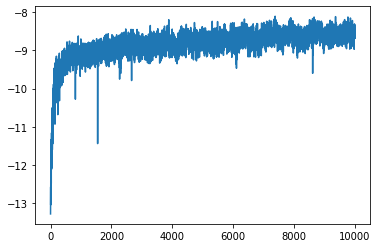

In [6]:
plt.plot(reward_records_)

In [7]:
import misc

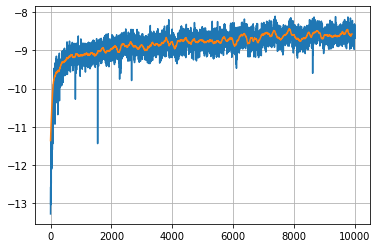

In [8]:
plt.plot(reward_records_)
plt.plot(misc.smooth(reward_records_,100))
plt.grid()


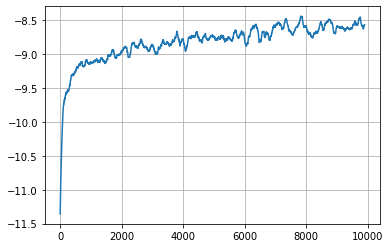

In [9]:
# plt.plot(reward_records_)
plt.plot(misc.smooth(reward_records_,100))
plt.grid()

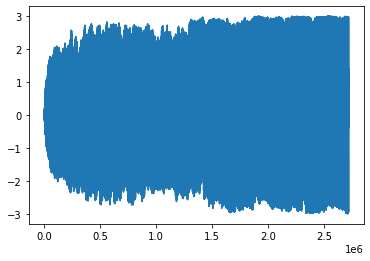

In [10]:
plt.plot(np.array(action_statmean_records).reshape([-1,8])[:,0])

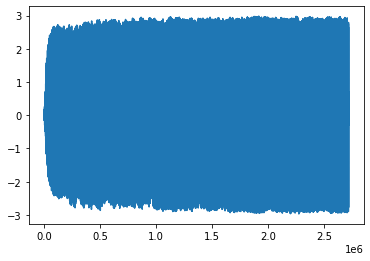

In [11]:
plt.plot(np.array(action_statmean_records).reshape([-1,8])[:,1])

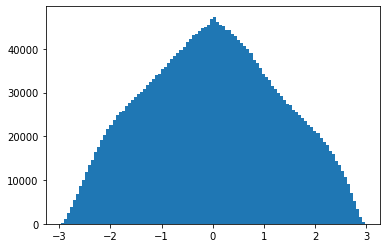

In [12]:
_=plt.hist(np.array(action_statmean_records).reshape([-1,8])[:,1],bins=100)

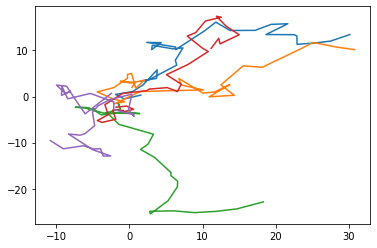

In [13]:
for these_actions in actions[:5]:
    plt.plot(np.cumsum(these_actions[:,0]),np.cumsum(these_actions[:,1]))

In [14]:
# actor_model.save('actor_model_vanilla_det_singleImg_Adv')

In [15]:
batch_of_actions = np.array(actions).transpose([1,0,2])

(-10.0, 10.0)

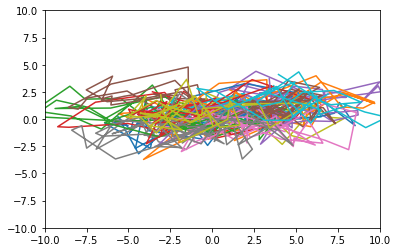

In [16]:
for these_actions in batch_of_actions[:20]:
    plt.plot(np.cumsum(these_actions[:,0]),np.cumsum(these_actions[:,1]))
plt.xlim([-10,10])
plt.ylim([-10,10])


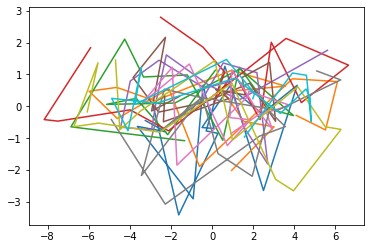

In [17]:
for ii in range(10):
    plt.plot(env.location_history[ii][0],env.location_history[ii][1])